##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

    16384/252872794 [..............................] - ETA: 46:21

    49152/252872794 [..............................] - ETA: 30:56

   106496/252872794 [..............................] - ETA: 21:26

   196608/252872794 [..............................] - ETA: 15:28

   409600/252872794 [..............................] - ETA: 9:16 

   827392/252872794 [..............................] - ETA: 5:30

  1654784/252872794 [..............................] - ETA: 3:12

  3325952/252872794 [..............................] - ETA: 1:48

  6373376/252872794 [..............................] - ETA: 1:02

  9396224/252872794 [>.............................] - ETA: 46s 

 12541952/252872794 [>.............................] - ETA: 38s

 15581184/252872794 [>.............................] - ETA: 33s

 18661376/252872794 [=>............................] - ETA: 29s

 21749760/252872794 [=>............................] - ETA: 26s

 24862720/252872794 [=>............................] - ETA: 24s

 27860992/252872794 [==>...........................] - ETA: 23s

 30941184/252872794 [==>...........................] - ETA: 22s

 33964032/252872794 [===>..........................] - ETA: 20s

 37068800/252872794 [===>..........................] - ETA: 19s

 40148992/252872794 [===>..........................] - ETA: 19s

 43139072/252872794 [====>.........................] - ETA: 18s

 46202880/252872794 [====>.........................] - ETA: 17s

 49266688/252872794 [====>.........................] - ETA: 17s

 52355072/252872794 [=====>........................] - ETA: 16s

 55500800/252872794 [=====>........................] - ETA: 16s

 58474496/252872794 [=====>........................] - ETA: 15s

 61513728/252872794 [======>.......................] - ETA: 15s

 64602112/252872794 [======>.......................] - ETA: 14s

 67682304/252872794 [=======>......................] - ETA: 14s

 70787072/252872794 [=======>......................] - ETA: 13s

 73850880/252872794 [=======>......................] - ETA: 13s

 76931072/252872794 [========>.....................] - ETA: 13s

 80011264/252872794 [========>.....................] - ETA: 12s

 83058688/252872794 [========>.....................] - ETA: 12s

 86138880/252872794 [=========>....................] - ETA: 12s

 89235456/252872794 [=========>....................] - ETA: 11s

 92332032/252872794 [=========>....................] - ETA: 11s

 95453184/252872794 [==========>...................] - ETA: 11s

 98557952/252872794 [==========>...................] - ETA: 11s

101646336/252872794 [===========>..................] - ETA: 10s

104660992/252872794 [===========>..................] - ETA: 10s

107749376/252872794 [===========>..................] - ETA: 10s

110854144/252872794 [============>.................] - ETA: 9s 

113991680/252872794 [============>.................] - ETA: 9s

117080064/252872794 [============>.................] - ETA: 9s

120127488/252872794 [=============>................] - ETA: 9s

123248640/252872794 [=============>................] - ETA: 8s

126361600/252872794 [=============>................] - ETA: 8s

129507328/252872794 [==============>...............] - ETA: 8s

132366336/252872794 [==============>...............] - ETA: 8s

135462912/252872794 [===============>..............] - ETA: 7s

138608640/252872794 [===============>..............] - ETA: 7s

141721600/252872794 [===============>..............] - ETA: 7s

144850944/252872794 [================>.............] - ETA: 7s

147914752/252872794 [================>.............] - ETA: 7s

150970368/252872794 [================>.............] - ETA: 6s

154050560/252872794 [=================>............] - ETA: 6s

157130752/252872794 [=================>............] - ETA: 6s

160243712/252872794 [==================>...........] - ETA: 6s

163332096/252872794 [==================>...........] - ETA: 5s

166428672/252872794 [==================>...........] - ETA: 5s

169525248/252872794 [===================>..........] - ETA: 5s

172654592/252872794 [===================>..........] - ETA: 5s

175767552/252872794 [===================>..........] - ETA: 5s

178896896/252872794 [====================>.........] - ETA: 4s

182001664/252872794 [====================>.........] - ETA: 4s

185098240/252872794 [====================>.........] - ETA: 4s

188211200/252872794 [=====================>........] - ETA: 4s

191324160/252872794 [=====================>........] - ETA: 4s

194445312/252872794 [======================>.......] - ETA: 3s

197574656/252872794 [======================>.......] - ETA: 3s

200572928/252872794 [======================>.......] - ETA: 3s

203620352/252872794 [=======================>......] - ETA: 3s

206692352/252872794 [=======================>......] - ETA: 2s

209715200/252872794 [=======================>......] - ETA: 2s

212803584/252872794 [========================>.....] - ETA: 2s

215867392/252872794 [========================>.....] - ETA: 2s

218963968/252872794 [========================>.....] - ETA: 2s

222068736/252872794 [=========================>....] - ETA: 1s

225148928/252872794 [=========================>....] - ETA: 1s

228294656/252872794 [==========================>...] - ETA: 1s

231415808/252872794 [==========================>...] - ETA: 1s

234536960/252872794 [==========================>...] - ETA: 1s

237658112/252872794 [===========================>..] - ETA: 0s

240779264/252872794 [===========================>..] - ETA: 0s

242360320/252872794 [===========================>..] - ETA: 0s

245481472/252872794 [============================>.] - ETA: 0s

247529472/252872794 [============================>.] - ETA: 0s

249929728/252872794 [============================>.] - ETA: 0s

251969536/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 16s 0us/step


252887040/252872794 [==============================] - 16s 0us/step


      16384/13510573713 [..............................] - ETA: 41:29:24

      49152/13510573713 [..............................] - ETA: 27:42:05

     106496/13510573713 [..............................] - ETA: 19:11:49

     196608/13510573713 [..............................] - ETA: 13:51:57

     409600/13510573713 [..............................] - ETA: 8:19:11 

     827392/13510573713 [..............................] - ETA: 4:56:32

    1671168/13510573713 [..............................] - ETA: 2:51:15

    3350528/13510573713 [..............................] - ETA: 1:37:38

    6430720/13510573713 [..............................] - ETA: 57:13  

    9568256/13510573713 [..............................] - ETA: 42:43

   12705792/13510573713 [..............................] - ETA: 35:22

   15810560/13510573713 [..............................] - ETA: 31:00

   18923520/13510573713 [..............................] - ETA: 28:03

   22069248/13510573713 [..............................] - ETA: 25:55

   25198592/13510573713 [..............................] - ETA: 24:18

   28311552/13510573713 [..............................] - ETA: 23:04

   31449088/13510573713 [..............................] - ETA: 22:03

   34545664/13510573713 [..............................] - ETA: 21:15

   37666816/13510573713 [..............................] - ETA: 20:34

   40787968/13510573713 [..............................] - ETA: 19:59

   43859968/13510573713 [..............................] - ETA: 19:31

   46899200/13510573713 [..............................] - ETA: 19:07

   50044928/13510573713 [..............................] - ETA: 18:44

   53190656/13510573713 [..............................] - ETA: 18:23

   56311808/13510573713 [..............................] - ETA: 18:06

   59424768/13510573713 [..............................] - ETA: 17:49

   62545920/13510573713 [..............................] - ETA: 17:35

   65675264/13510573713 [..............................] - ETA: 17:21

   68820992/13510573713 [..............................] - ETA: 17:09

   71909376/13510573713 [..............................] - ETA: 16:58

   75030528/13510573713 [..............................] - ETA: 16:48

   78176256/13510573713 [..............................] - ETA: 16:40

   81313792/13510573713 [..............................] - ETA: 16:30

   84434944/13510573713 [..............................] - ETA: 16:25

   87564288/13510573713 [..............................] - ETA: 16:15

   90644480/13510573713 [..............................] - ETA: 16:08

   93757440/13510573713 [..............................] - ETA: 16:04

   96845824/13510573713 [..............................] - ETA: 15:56

   99926016/13510573713 [..............................] - ETA: 15:51

  103038976/13510573713 [..............................] - ETA: 15:45

  106160128/13510573713 [..............................] - ETA: 15:40

  109289472/13510573713 [..............................] - ETA: 15:35

  112418816/13510573713 [..............................] - ETA: 15:33

  115564544/13510573713 [..............................] - ETA: 15:28

  118661120/13510573713 [..............................] - ETA: 15:22

  121782272/13510573713 [..............................] - ETA: 15:19

  124911616/13510573713 [..............................] - ETA: 15:15

  128040960/13510573713 [..............................] - ETA: 15:11

  131129344/13510573713 [..............................] - ETA: 15:08

  134275072/13510573713 [..............................] - ETA: 15:05

  137388032/13510573713 [..............................] - ETA: 15:02

  140492800/13510573713 [..............................] - ETA: 14:59

  143638528/13510573713 [..............................] - ETA: 14:56

  146784256/13510573713 [..............................] - ETA: 14:53

  149889024/13510573713 [..............................] - ETA: 14:50

  152993792/13510573713 [..............................] - ETA: 14:48

  156139520/13510573713 [..............................] - ETA: 14:45

  159244288/13510573713 [..............................] - ETA: 14:43

  162283520/13510573713 [..............................] - ETA: 14:41

  165347328/13510573713 [..............................] - ETA: 14:40

  168427520/13510573713 [..............................] - ETA: 14:38

  171540480/13510573713 [..............................] - ETA: 14:36

  174612480/13510573713 [..............................] - ETA: 14:34

  177700864/13510573713 [..............................] - ETA: 14:32

  180822016/13510573713 [..............................] - ETA: 14:30

  183967744/13510573713 [..............................] - ETA: 14:28

  187072512/13510573713 [..............................] - ETA: 14:27

  190185472/13510573713 [..............................] - ETA: 14:25

  193298432/13510573713 [..............................] - ETA: 14:23

  196378624/13510573713 [..............................] - ETA: 14:22

  199524352/13510573713 [..............................] - ETA: 14:20

  202604544/13510573713 [..............................] - ETA: 14:19

  205717504/13510573713 [..............................] - ETA: 14:17

  208822272/13510573713 [..............................] - ETA: 14:16

  211968000/13510573713 [..............................] - ETA: 14:15

  215064576/13510573713 [..............................] - ETA: 14:13

  218193920/13510573713 [..............................] - ETA: 14:12

  221315072/13510573713 [..............................] - ETA: 14:11

  224419840/13510573713 [..............................] - ETA: 14:09

  227540992/13510573713 [..............................] - ETA: 14:08

  230670336/13510573713 [..............................] - ETA: 14:07

  232873984/13510573713 [..............................] - ETA: 14:02

  233807872/13510573713 [..............................] - ETA: 14:06

  235978752/13510573713 [..............................] - ETA: 14:01

  236953600/13510573713 [..............................] - ETA: 14:04

  238305280/13510573713 [..............................] - ETA: 14:02

  240099328/13510573713 [..............................] - ETA: 14:04

  243236864/13510573713 [..............................] - ETA: 14:02

  244498432/13510573713 [..............................] - ETA: 14:00

  246358016/13510573713 [..............................] - ETA: 14:01

  247570432/13510573713 [..............................] - ETA: 13:59

  249446400/13510573713 [..............................] - ETA: 14:00

  250699776/13510573713 [..............................] - ETA: 13:58

  252592128/13510573713 [..............................] - ETA: 13:59

  253763584/13510573713 [..............................] - ETA: 13:58

  255729664/13510573713 [..............................] - ETA: 13:58

  256835584/13510573713 [..............................] - ETA: 13:57

  258859008/13510573713 [..............................] - ETA: 13:57

  259899392/13510573713 [..............................] - ETA: 13:56

  262004736/13510573713 [..............................] - ETA: 13:56

  262971392/13510573713 [..............................] - ETA: 13:55

  265076736/13510573713 [..............................] - ETA: 13:55

  266100736/13510573713 [..............................] - ETA: 13:54

  268189696/13510573713 [..............................] - ETA: 13:54

  269164544/13510573713 [..............................] - ETA: 13:53

  271286272/13510573713 [..............................] - ETA: 13:53

  272236544/13510573713 [..............................] - ETA: 13:53

  274399232/13510573713 [..............................] - ETA: 13:52

  275300352/13510573713 [..............................] - ETA: 13:52

  277544960/13510573713 [..............................] - ETA: 13:52

  280182784/13510573713 [..............................] - ETA: 13:46

  280666112/13510573713 [..............................] - ETA: 13:51

  283287552/13510573713 [..............................] - ETA: 13:46

  283811840/13510573713 [..............................] - ETA: 13:50

  286294016/13510573713 [..............................] - ETA: 13:45

  286777344/13510573713 [..............................] - ETA: 13:49

  287637504/13510573713 [..............................] - ETA: 13:49

  289775616/13510573713 [..............................] - ETA: 13:49

  290635776/13510573713 [..............................] - ETA: 13:48

  292921344/13510573713 [..............................] - ETA: 13:48

  293707776/13510573713 [..............................] - ETA: 13:48

  296017920/13510573713 [..............................] - ETA: 13:47

  296779776/13510573713 [..............................] - ETA: 13:47

  299122688/13510573713 [..............................] - ETA: 13:46

  299851776/13510573713 [..............................] - ETA: 13:46

  302243840/13510573713 [..............................] - ETA: 13:45

  302972928/13510573713 [..............................] - ETA: 13:46

  305389568/13510573713 [..............................] - ETA: 13:45

  306102272/13510573713 [..............................] - ETA: 13:45

  308486144/13510573713 [..............................] - ETA: 13:44

  309166080/13510573713 [..............................] - ETA: 13:44

  311607296/13510573713 [..............................] - ETA: 13:43

  312238080/13510573713 [..............................] - ETA: 13:44

  314736640/13510573713 [..............................] - ETA: 13:42

  315367424/13510573713 [..............................] - ETA: 13:43

  317849600/13510573713 [..............................] - ETA: 13:42

  318431232/13510573713 [..............................] - ETA: 13:42

  320995328/13510573713 [..............................] - ETA: 13:42

  324075520/13510573713 [..............................] - ETA: 13:40

  324632576/13510573713 [..............................] - ETA: 13:41

  327188480/13510573713 [..............................] - ETA: 13:40

  327696384/13510573713 [..............................] - ETA: 13:40

  330309632/13510573713 [..............................] - ETA: 13:39

  330768384/13510573713 [..............................] - ETA: 13:40

  333422592/13510573713 [..............................] - ETA: 13:38

  333832192/13510573713 [..............................] - ETA: 13:39

  336568320/13510573713 [..............................] - ETA: 13:37

  336904192/13510573713 [..............................] - ETA: 13:39

  339689472/13510573713 [..............................] - ETA: 13:37

  339968000/13510573713 [..............................] - ETA: 13:38

  342777856/13510573713 [..............................] - ETA: 13:36

  343031808/13510573713 [..............................] - ETA: 13:38

  345899008/13510573713 [..............................] - ETA: 13:36

  346103808/13510573713 [..............................] - ETA: 13:37

  349044736/13510573713 [..............................] - ETA: 13:35

  349167616/13510573713 [..............................] - ETA: 13:37

  352157696/13510573713 [..............................] - ETA: 13:34

  352296960/13510573713 [..............................] - ETA: 13:36

  355303424/13510573713 [..............................] - ETA: 13:34

  355401728/13510573713 [..............................] - ETA: 13:35

  358416384/13510573713 [..............................] - ETA: 13:33

  358531072/13510573713 [..............................] - ETA: 13:35

  361553920/13510573713 [..............................] - ETA: 13:32

  361660416/13510573713 [..............................] - ETA: 13:34

  364699648/13510573713 [..............................] - ETA: 13:32

  364789760/13510573713 [..............................] - ETA: 13:33

  367837184/13510573713 [..............................] - ETA: 13:31

  367894528/13510573713 [..............................] - ETA: 13:33

  370950144/13510573713 [..............................] - ETA: 13:30

  371023872/13510573713 [..............................] - ETA: 13:32

  374071296/13510573713 [..............................] - ETA: 13:30

  374161408/13510573713 [..............................] - ETA: 13:32

  377208832/13510573713 [..............................] - ETA: 13:29

  377282560/13510573713 [..............................] - ETA: 13:31

  380354560/13510573713 [..............................] - ETA: 13:29

  380420096/13510573713 [..............................] - ETA: 13:30

  383500288/13510573713 [..............................] - ETA: 13:29

  385163264/13510573713 [..............................] - ETA: 13:27

  386613248/13510573713 [..............................] - ETA: 13:28

  388194304/13510573713 [..............................] - ETA: 13:26

  389758976/13510573713 [..............................] - ETA: 13:27

  391340032/13510573713 [..............................] - ETA: 13:26

  392871936/13510573713 [..............................] - ETA: 13:27

  394338304/13510573713 [..............................] - ETA: 13:26

  395976704/13510573713 [..............................] - ETA: 13:26

  397475840/13510573713 [..............................] - ETA: 13:25

  399073280/13510573713 [..............................] - ETA: 13:26

  400678912/13510573713 [..............................] - ETA: 13:24

  402210816/13510573713 [..............................] - ETA: 13:25

  403529728/13510573713 [..............................] - ETA: 13:24

  405356544/13510573713 [..............................] - ETA: 13:25

  407060480/13510573713 [..............................] - ETA: 13:23

  408494080/13510573713 [..............................] - ETA: 13:24

  410132480/13510573713 [..............................] - ETA: 13:23

  411631616/13510573713 [..............................] - ETA: 13:24

  413261824/13510573713 [..............................] - ETA: 13:22

  414777344/13510573713 [..............................] - ETA: 13:23

  416325632/13510573713 [..............................] - ETA: 13:22

  417923072/13510573713 [..............................] - ETA: 13:23

  421019648/13510573713 [..............................] - ETA: 13:22

  422395904/13510573713 [..............................] - ETA: 13:21

  424157184/13510573713 [..............................] - ETA: 13:22

  425467904/13510573713 [..............................] - ETA: 13:21

  427302912/13510573713 [..............................] - ETA: 13:21

  428531712/13510573713 [..............................] - ETA: 13:20

  430424064/13510573713 [..............................] - ETA: 13:21

  431603712/13510573713 [..............................] - ETA: 13:20

  433512448/13510573713 [..............................] - ETA: 13:20

  434733056/13510573713 [..............................] - ETA: 13:20

  436658176/13510573713 [..............................] - ETA: 13:20

  439009280/13510573713 [..............................] - ETA: 13:17

  439779328/13510573713 [..............................] - ETA: 13:20

  442081280/13510573713 [..............................] - ETA: 13:17

  442908672/13510573713 [..............................] - ETA: 13:19

  445145088/13510573713 [..............................] - ETA: 13:17

  446054400/13510573713 [..............................] - ETA: 13:19

  448217088/13510573713 [..............................] - ETA: 13:16

  449183744/13510573713 [..............................] - ETA: 13:18

  451305472/13510573713 [>.............................] - ETA: 13:16

  452304896/13510573713 [>.............................] - ETA: 13:18

  454410240/13510573713 [>.............................] - ETA: 13:15

  455417856/13510573713 [>.............................] - ETA: 13:17

  457482240/13510573713 [>.............................] - ETA: 13:15

  458506240/13510573713 [>.............................] - ETA: 13:17

  460546048/13510573713 [>.............................] - ETA: 13:15

  461619200/13510573713 [>.............................] - ETA: 13:17

  463618048/13510573713 [>.............................] - ETA: 13:14

  464764928/13510573713 [>.............................] - ETA: 13:16

  466698240/13510573713 [>.............................] - ETA: 13:14

  467894272/13510573713 [>.............................] - ETA: 13:16

  471015424/13510573713 [>.............................] - ETA: 13:15

  472883200/13510573713 [>.............................] - ETA: 13:13

  474161152/13510573713 [>.............................] - ETA: 13:15

  475947008/13510573713 [>.............................] - ETA: 13:13

  477298688/13510573713 [>.............................] - ETA: 13:14

  479010816/13510573713 [>.............................] - ETA: 13:13

  480444416/13510573713 [>.............................] - ETA: 13:14

  482148352/13510573713 [>.............................] - ETA: 13:12

  483590144/13510573713 [>.............................] - ETA: 13:14

  486621184/13510573713 [>.............................] - ETA: 13:10

  486735872/13510573713 [>.............................] - ETA: 13:13

  489635840/13510573713 [>.............................] - ETA: 13:10

  489816064/13510573713 [>.............................] - ETA: 13:12

  491347968/13510573713 [>.............................] - ETA: 13:11

  492855296/13510573713 [>.............................] - ETA: 13:12

  494411776/13510573713 [>.............................] - ETA: 13:11

  496001024/13510573713 [>.............................] - ETA: 13:12

  497491968/13510573713 [>.............................] - ETA: 13:11

  499146752/13510573713 [>.............................] - ETA: 13:12

  501956608/13510573713 [>.............................] - ETA: 13:08

  502267904/13510573713 [>.............................] - ETA: 13:11

  503676928/13510573713 [>.............................] - ETA: 13:10

  505413632/13510573713 [>.............................] - ETA: 13:11

  508149760/13510573713 [>.............................] - ETA: 13:08

  508518400/13510573713 [>.............................] - ETA: 13:10

  509812736/13510573713 [>.............................] - ETA: 13:09

  511500288/13510573713 [>.............................] - ETA: 13:10

  512884736/13510573713 [>.............................] - ETA: 13:09

  514646016/13510573713 [>.............................] - ETA: 13:10

  515948544/13510573713 [>.............................] - ETA: 13:09

  517791744/13510573713 [>.............................] - ETA: 13:09

  519012352/13510573713 [>.............................] - ETA: 13:08

  520904704/13510573713 [>.............................] - ETA: 13:09

  522084352/13510573713 [>.............................] - ETA: 13:08

  524050432/13510573713 [>.............................] - ETA: 13:08

  525148160/13510573713 [>.............................] - ETA: 13:08

  527196160/13510573713 [>.............................] - ETA: 13:08

  529686528/13510573713 [>.............................] - ETA: 13:06

  530268160/13510573713 [>.............................] - ETA: 13:08

  531349504/13510573713 [>.............................] - ETA: 13:07

  533372928/13510573713 [>.............................] - ETA: 13:07

  534413312/13510573713 [>.............................] - ETA: 13:07

  536453120/13510573713 [>.............................] - ETA: 13:07

  537485312/13510573713 [>.............................] - ETA: 13:07

  539598848/13510573713 [>.............................] - ETA: 13:06

  540549120/13510573713 [>.............................] - ETA: 13:06

  542670848/13510573713 [>.............................] - ETA: 13:06

  543621120/13510573713 [>.............................] - ETA: 13:06

  545751040/13510573713 [>.............................] - ETA: 13:06

  546684928/13510573713 [>.............................] - ETA: 13:06

  548839424/13510573713 [>.............................] - ETA: 13:06

  549814272/13510573713 [>.............................] - ETA: 13:05

  551936000/13510573713 [>.............................] - ETA: 13:05

  552886272/13510573713 [>.............................] - ETA: 13:05

  555065344/13510573713 [>.............................] - ETA: 13:05

  556007424/13510573713 [>.............................] - ETA: 13:05

  558194688/13510573713 [>.............................] - ETA: 13:04

  559079424/13510573713 [>.............................] - ETA: 13:04

  561307648/13510573713 [>.............................] - ETA: 13:04

  562151424/13510573713 [>.............................] - ETA: 13:04

  564453376/13510573713 [>.............................] - ETA: 13:04

  565215232/13510573713 [>.............................] - ETA: 13:04

  567582720/13510573713 [>.............................] - ETA: 13:03

  568279040/13510573713 [>.............................] - ETA: 13:04

  570728448/13510573713 [>.............................] - ETA: 13:03

  571351040/13510573713 [>.............................] - ETA: 13:03

  573833216/13510573713 [>.............................] - ETA: 13:03

  574480384/13510573713 [>.............................] - ETA: 13:03

  576946176/13510573713 [>.............................] - ETA: 13:02

  577544192/13510573713 [>.............................] - ETA: 13:03

  580050944/13510573713 [>.............................] - ETA: 13:02

  580616192/13510573713 [>.............................] - ETA: 13:02

  583139328/13510573713 [>.............................] - ETA: 13:02

  583680000/13510573713 [>.............................] - ETA: 13:02

  586244096/13510573713 [>.............................] - ETA: 13:01

  586752000/13510573713 [>.............................] - ETA: 13:02

  589357056/13510573713 [>.............................] - ETA: 13:01

  589815808/13510573713 [>.............................] - ETA: 13:01

  592445440/13510573713 [>.............................] - ETA: 13:01

  592945152/13510573713 [>.............................] - ETA: 13:01

  595591168/13510573713 [>.............................] - ETA: 13:00

  596017152/13510573713 [>.............................] - ETA: 13:01

  598687744/13510573713 [>.............................] - ETA: 13:00

  599121920/13510573713 [>.............................] - ETA: 13:00

  601735168/13510573713 [>.............................] - ETA: 13:00

  602185728/13510573713 [>.............................] - ETA: 13:00

  604864512/13510573713 [>.............................] - ETA: 12:59

  605290496/13510573713 [>.............................] - ETA: 13:00

  607961088/13510573713 [>.............................] - ETA: 13:00

  611106816/13510573713 [>.............................] - ETA: 12:59

  614236160/13510573713 [>.............................] - ETA: 12:58

  614547456/13510573713 [>.............................] - ETA: 12:59

  617340928/13510573713 [>.............................] - ETA: 12:58

  617676800/13510573713 [>.............................] - ETA: 12:59

  620445696/13510573713 [>.............................] - ETA: 12:58

  620740608/13510573713 [>.............................] - ETA: 12:59

  623583232/13510573713 [>.............................] - ETA: 12:57

  623812608/13510573713 [>.............................] - ETA: 12:58

  626679808/13510573713 [>.............................] - ETA: 12:57

  626876416/13510573713 [>.............................] - ETA: 12:58

  629768192/13510573713 [>.............................] - ETA: 12:57

  629948416/13510573713 [>.............................] - ETA: 12:58

  632897536/13510573713 [>.............................] - ETA: 12:57

  633077760/13510573713 [>.............................] - ETA: 12:57

  636018688/13510573713 [>.............................] - ETA: 12:57

  639107072/13510573713 [>.............................] - ETA: 12:56

  639279104/13510573713 [>.............................] - ETA: 12:57

  642211840/13510573713 [>.............................] - ETA: 12:56

  642342912/13510573713 [>.............................] - ETA: 12:57

  645357568/13510573713 [>.............................] - ETA: 12:55

  645472256/13510573713 [>.............................] - ETA: 12:56

  648421376/13510573713 [>.............................] - ETA: 12:55

  648601600/13510573713 [>.............................] - ETA: 12:56

  651550720/13510573713 [>.............................] - ETA: 12:55

  651730944/13510573713 [>.............................] - ETA: 12:56

  654663680/13510573713 [>.............................] - ETA: 12:54

  654843904/13510573713 [>.............................] - ETA: 12:55

  657793024/13510573713 [>.............................] - ETA: 12:54

  657965056/13510573713 [>.............................] - ETA: 12:55

  660922368/13510573713 [>.............................] - ETA: 12:54

  661061632/13510573713 [>.............................] - ETA: 12:55

  664018944/13510573713 [>.............................] - ETA: 12:53

  664150016/13510573713 [>.............................] - ETA: 12:54

  667123712/13510573713 [>.............................] - ETA: 12:53

  667262976/13510573713 [>.............................] - ETA: 12:54

  670236672/13510573713 [>.............................] - ETA: 12:53

  670392320/13510573713 [>.............................] - ETA: 12:54

  673341440/13510573713 [>.............................] - ETA: 12:53

  673464320/13510573713 [>.............................] - ETA: 12:53

  676454400/13510573713 [>.............................] - ETA: 12:52

  676569088/13510573713 [>.............................] - ETA: 12:53

  679542784/13510573713 [>.............................] - ETA: 12:52

  679682048/13510573713 [>.............................] - ETA: 12:53

  682672128/13510573713 [>.............................] - ETA: 12:52

  682795008/13510573713 [>.............................] - ETA: 12:53

  685785088/13510573713 [>.............................] - ETA: 12:51

  685858816/13510573713 [>.............................] - ETA: 12:52

  688889856/13510573713 [>.............................] - ETA: 12:51

  688996352/13510573713 [>.............................] - ETA: 12:52

  692002816/13510573713 [>.............................] - ETA: 12:51

  692142080/13510573713 [>.............................] - ETA: 12:52

  695083008/13510573713 [>.............................] - ETA: 12:51

  695255040/13510573713 [>.............................] - ETA: 12:51

  698179584/13510573713 [>.............................] - ETA: 12:50

  698359808/13510573713 [>.............................] - ETA: 12:51

  701267968/13510573713 [>.............................] - ETA: 12:50

  701448192/13510573713 [>.............................] - ETA: 12:51

  704380928/13510573713 [>.............................] - ETA: 12:50

  704536576/13510573713 [>.............................] - ETA: 12:51

  707518464/13510573713 [>.............................] - ETA: 12:50

  709246976/13510573713 [>.............................] - ETA: 12:49

  710647808/13510573713 [>.............................] - ETA: 12:49

  710811648/13510573713 [>.............................] - ETA: 12:50

  713793536/13510573713 [>.............................] - ETA: 12:49

  713908224/13510573713 [>.............................] - ETA: 12:50

  716865536/13510573713 [>.............................] - ETA: 12:49

  716955648/13510573713 [>.............................] - ETA: 12:49

  719929344/13510573713 [>.............................] - ETA: 12:48

  720093184/13510573713 [>.............................] - ETA: 12:49

  723001344/13510573713 [>.............................] - ETA: 12:48

  723222528/13510573713 [>.............................] - ETA: 12:49

  726106112/13510573713 [>.............................] - ETA: 12:48

  726310912/13510573713 [>.............................] - ETA: 12:49

  729194496/13510573713 [>.............................] - ETA: 12:48

  729374720/13510573713 [>.............................] - ETA: 12:48

  732266496/13510573713 [>.............................] - ETA: 12:47

  732504064/13510573713 [>.............................] - ETA: 12:48

  735363072/13510573713 [>.............................] - ETA: 12:47

  735576064/13510573713 [>.............................] - ETA: 12:48

  738508800/13510573713 [>.............................] - ETA: 12:47

  738705408/13510573713 [>.............................] - ETA: 12:48

  741629952/13510573713 [>.............................] - ETA: 12:46

  741769216/13510573713 [>.............................] - ETA: 12:47

  744710144/13510573713 [>.............................] - ETA: 12:46

  744841216/13510573713 [>.............................] - ETA: 12:47

  747782144/13510573713 [>.............................] - ETA: 12:46

  747970560/13510573713 [>.............................] - ETA: 12:47

  750927872/13510573713 [>.............................] - ETA: 12:46

  751034368/13510573713 [>.............................] - ETA: 12:46

  754073600/13510573713 [>.............................] - ETA: 12:45

  754163712/13510573713 [>.............................] - ETA: 12:46

  757219328/13510573713 [>.............................] - ETA: 12:45

  757252096/13510573713 [>.............................] - ETA: 12:46

  760209408/13510573713 [>.............................] - ETA: 12:45

  760389632/13510573713 [>.............................] - ETA: 12:46

  763265024/13510573713 [>.............................] - ETA: 12:45

  763527168/13510573713 [>.............................] - ETA: 12:45

  766386176/13510573713 [>.............................] - ETA: 12:44

  766631936/13510573713 [>.............................] - ETA: 12:45

  769490944/13510573713 [>.............................] - ETA: 12:44

  769695744/13510573713 [>.............................] - ETA: 12:45

  772579328/13510573713 [>.............................] - ETA: 12:44

  772759552/13510573713 [>.............................] - ETA: 12:45

  775659520/13510573713 [>.............................] - ETA: 12:44

  775831552/13510573713 [>.............................] - ETA: 12:44

  778764288/13510573713 [>.............................] - ETA: 12:43

  778928128/13510573713 [>.............................] - ETA: 12:44

  781844480/13510573713 [>.............................] - ETA: 12:43

  782024704/13510573713 [>.............................] - ETA: 12:44

  784949248/13510573713 [>.............................] - ETA: 12:43

  785096704/13510573713 [>.............................] - ETA: 12:44

  788070400/13510573713 [>.............................] - ETA: 12:43

  788160512/13510573713 [>.............................] - ETA: 12:43

  791207936/13510573713 [>.............................] - ETA: 12:42

  791289856/13510573713 [>.............................] - ETA: 12:43

  794288128/13510573713 [>.............................] - ETA: 12:42

  794402816/13510573713 [>.............................] - ETA: 12:43

  797384704/13510573713 [>.............................] - ETA: 12:42

  797532160/13510573713 [>.............................] - ETA: 12:43

  800456704/13510573713 [>.............................] - ETA: 12:42

  800620544/13510573713 [>.............................] - ETA: 12:42

  803602432/13510573713 [>.............................] - ETA: 12:41

  803758080/13510573713 [>.............................] - ETA: 12:42

  806748160/13510573713 [>.............................] - ETA: 12:41

  806887424/13510573713 [>.............................] - ETA: 12:42

  809877504/13510573713 [>.............................] - ETA: 12:41

  809951232/13510573713 [>.............................] - ETA: 12:42

  813023232/13510573713 [>.............................] - ETA: 12:40

  813080576/13510573713 [>.............................] - ETA: 12:41

  816128000/13510573713 [>.............................] - ETA: 12:40

  816218112/13510573713 [>.............................] - ETA: 12:41

  819232768/13510573713 [>.............................] - ETA: 12:40

  819347456/13510573713 [>.............................] - ETA: 12:41

  822337536/13510573713 [>.............................] - ETA: 12:40

  822476800/13510573713 [>.............................] - ETA: 12:40

  825434112/13510573713 [>.............................] - ETA: 12:39

  825606144/13510573713 [>.............................] - ETA: 12:40

  828547072/13510573713 [>.............................] - ETA: 12:39

  828735488/13510573713 [>.............................] - ETA: 12:40

  831692800/13510573713 [>.............................] - ETA: 12:39

  831897600/13510573713 [>.............................] - ETA: 12:40

  834797568/13510573713 [>.............................] - ETA: 12:39

  834936832/13510573713 [>.............................] - ETA: 12:39

  837935104/13510573713 [>.............................] - ETA: 12:38

  838066176/13510573713 [>.............................] - ETA: 12:39

  841064448/13510573713 [>.............................] - ETA: 12:38

  841195520/13510573713 [>.............................] - ETA: 12:39

  844210176/13510573713 [>.............................] - ETA: 12:38

  844333056/13510573713 [>.............................] - ETA: 12:39

  847323136/13510573713 [>.............................] - ETA: 12:38

  847405056/13510573713 [>.............................] - ETA: 12:38

  850403328/13510573713 [>.............................] - ETA: 12:37

  850526208/13510573713 [>.............................] - ETA: 12:38

  853508096/13510573713 [>.............................] - ETA: 12:37

  853663744/13510573713 [>.............................] - ETA: 12:38

  856596480/13510573713 [>.............................] - ETA: 12:37

  856793088/13510573713 [>.............................] - ETA: 12:38

  859742208/13510573713 [>.............................] - ETA: 12:37

  859922432/13510573713 [>.............................] - ETA: 12:37

  862838784/13510573713 [>.............................] - ETA: 12:36

  862986240/13510573713 [>.............................] - ETA: 12:37

  865902592/13510573713 [>.............................] - ETA: 12:36

  866123776/13510573713 [>.............................] - ETA: 12:37

  869007360/13510573713 [>.............................] - ETA: 12:36

  869187584/13510573713 [>.............................] - ETA: 12:37

  872153088/13510573713 [>.............................] - ETA: 12:36

  872316928/13510573713 [>.............................] - ETA: 12:36

  875298816/13510573713 [>.............................] - ETA: 12:35

  875413504/13510573713 [>.............................] - ETA: 12:36

  878444544/13510573713 [>.............................] - ETA: 12:35

  878518272/13510573713 [>.............................] - ETA: 12:36

  881524736/13510573713 [>.............................] - ETA: 12:35

  881664000/13510573713 [>.............................] - ETA: 12:36

  884662272/13510573713 [>.............................] - ETA: 12:35

  884776960/13510573713 [>.............................] - ETA: 12:35

  887767040/13510573713 [>.............................] - ETA: 12:34

  887906304/13510573713 [>.............................] - ETA: 12:35

  890896384/13510573713 [>.............................] - ETA: 12:34

  891043840/13510573713 [>.............................] - ETA: 12:35

  894033920/13510573713 [>.............................] - ETA: 12:34

  894173184/13510573713 [>.............................] - ETA: 12:34

  897155072/13510573713 [>.............................] - ETA: 12:33

  897302528/13510573713 [>.............................] - ETA: 12:34

  900276224/13510573713 [>.............................] - ETA: 12:33

  900390912/13510573713 [>.............................] - ETA: 12:34

  903421952/13510573713 [=>............................] - ETA: 12:33

  903528448/13510573713 [=>............................] - ETA: 12:34

  906567680/13510573713 [=>............................] - ETA: 12:33

  906682368/13510573713 [=>............................] - ETA: 12:34

  909713408/13510573713 [=>............................] - ETA: 12:33

  909778944/13510573713 [=>............................] - ETA: 12:33

  912826368/13510573713 [=>............................] - ETA: 12:32

  912891904/13510573713 [=>............................] - ETA: 12:33

  915947520/13510573713 [=>............................] - ETA: 12:32

  916029440/13510573713 [=>............................] - ETA: 12:33

  919044096/13510573713 [=>............................] - ETA: 12:32

  919158784/13510573713 [=>............................] - ETA: 12:32

  922148864/13510573713 [=>............................] - ETA: 12:31

  922288128/13510573713 [=>............................] - ETA: 12:32

  925237248/13510573713 [=>............................] - ETA: 12:31

  925417472/13510573713 [=>............................] - ETA: 12:32

  928243712/13510573713 [=>............................] - ETA: 12:31

  928489472/13510573713 [=>............................] - ETA: 12:32

  931356672/13510573713 [=>............................] - ETA: 12:31

  931618816/13510573713 [=>............................] - ETA: 12:31

  934494208/13510573713 [=>............................] - ETA: 12:31

  934739968/13510573713 [=>............................] - ETA: 12:31

  937582592/13510573713 [=>............................] - ETA: 12:30

  937820160/13510573713 [=>............................] - ETA: 12:31

  940728320/13510573713 [=>............................] - ETA: 12:30

  940883968/13510573713 [=>............................] - ETA: 12:31

  943816704/13510573713 [=>............................] - ETA: 12:30

  943996928/13510573713 [=>............................] - ETA: 12:30

  946855936/13510573713 [=>............................] - ETA: 12:30

  947093504/13510573713 [=>............................] - ETA: 12:30

  949960704/13510573713 [=>............................] - ETA: 12:29

  950214656/13510573713 [=>............................] - ETA: 12:30

  953040896/13510573713 [=>............................] - ETA: 12:29

  953278464/13510573713 [=>............................] - ETA: 12:30

  956104704/13510573713 [=>............................] - ETA: 12:29

  956391424/13510573713 [=>............................] - ETA: 12:30

  959209472/13510573713 [=>............................] - ETA: 12:29

  959479808/13510573713 [=>............................] - ETA: 12:29

  962314240/13510573713 [=>............................] - ETA: 12:29

  962609152/13510573713 [=>............................] - ETA: 12:29

  965459968/13510573713 [=>............................] - ETA: 12:28

  965738496/13510573713 [=>............................] - ETA: 12:29

  968548352/13510573713 [=>............................] - ETA: 12:28

  968851456/13510573713 [=>............................] - ETA: 12:29

  971677696/13510573713 [=>............................] - ETA: 12:28

  971915264/13510573713 [=>............................] - ETA: 12:28

  974823424/13510573713 [=>............................] - ETA: 12:28

  977534976/13510573713 [=>............................] - ETA: 12:26

  977969152/13510573713 [=>............................] - ETA: 12:28

  980631552/13510573713 [=>............................] - ETA: 12:26

  981114880/13510573713 [=>............................] - ETA: 12:28

  984129536/13510573713 [=>............................] - ETA: 12:27

  984268800/13510573713 [=>............................] - ETA: 12:27

  987209728/13510573713 [=>............................] - ETA: 12:27

  987406336/13510573713 [=>............................] - ETA: 12:27

  990322688/13510573713 [=>............................] - ETA: 12:26

  990502912/13510573713 [=>............................] - ETA: 12:27

  993402880/13510573713 [=>............................] - ETA: 12:26

  993599488/13510573713 [=>............................] - ETA: 12:27

  996491264/13510573713 [=>............................] - ETA: 12:26

  996671488/13510573713 [=>............................] - ETA: 12:27

  999636992/13510573713 [=>............................] - ETA: 12:26

  999809024/13510573713 [=>............................] - ETA: 12:26

 1002782720/13510573713 [=>............................] - ETA: 12:25

 1002930176/13510573713 [=>............................] - ETA: 12:26

 1005928448/13510573713 [=>............................] - ETA: 12:25

 1006059520/13510573713 [=>............................] - ETA: 12:26

 1009033216/13510573713 [=>............................] - ETA: 12:25

 1009131520/13510573713 [=>............................] - ETA: 12:26

 1012121600/13510573713 [=>............................] - ETA: 12:25

 1012260864/13510573713 [=>............................] - ETA: 12:25

 1015234560/13510573713 [=>............................] - ETA: 12:24

 1015390208/13510573713 [=>............................] - ETA: 12:25

 1018331136/13510573713 [=>............................] - ETA: 12:24

 1018519552/13510573713 [=>............................] - ETA: 12:25

 1021468672/13510573713 [=>............................] - ETA: 12:24

 1021616128/13510573713 [=>............................] - ETA: 12:25

 1024573440/13510573713 [=>............................] - ETA: 12:24

 1024720896/13510573713 [=>............................] - ETA: 12:24

 1027620864/13510573713 [=>............................] - ETA: 12:24

 1027825664/13510573713 [=>............................] - ETA: 12:24

 1030676480/13510573713 [=>............................] - ETA: 12:23

 1030930432/13510573713 [=>............................] - ETA: 12:24

 1033814016/13510573713 [=>............................] - ETA: 12:23

 1034051584/13510573713 [=>............................] - ETA: 12:24

 1036926976/13510573713 [=>............................] - ETA: 12:23

 1037115392/13510573713 [=>............................] - ETA: 12:23

 1040039936/13510573713 [=>............................] - ETA: 12:23

 1040187392/13510573713 [=>............................] - ETA: 12:23

 1043136512/13510573713 [=>............................] - ETA: 12:22

 1043316736/13510573713 [=>............................] - ETA: 12:23

 1046249472/13510573713 [=>............................] - ETA: 12:22

 1046380544/13510573713 [=>............................] - ETA: 12:23

 1049346048/13510573713 [=>............................] - ETA: 12:22

 1049509888/13510573713 [=>............................] - ETA: 12:23

 1052475392/13510573713 [=>............................] - ETA: 12:22

 1052622848/13510573713 [=>............................] - ETA: 12:22

 1055621120/13510573713 [=>............................] - ETA: 12:22

 1055711232/13510573713 [=>............................] - ETA: 12:22

 1058725888/13510573713 [=>............................] - ETA: 12:21

 1058840576/13510573713 [=>............................] - ETA: 12:22

 1061863424/13510573713 [=>............................] - ETA: 12:21

 1061969920/13510573713 [=>............................] - ETA: 12:22

 1064968192/13510573713 [=>............................] - ETA: 12:21

 1065058304/13510573713 [=>............................] - ETA: 12:21

 1068105728/13510573713 [=>............................] - ETA: 12:21

 1068171264/13510573713 [=>............................] - ETA: 12:21

 1071235072/13510573713 [=>............................] - ETA: 12:20

 1071292416/13510573713 [=>............................] - ETA: 12:21

 1074339840/13510573713 [=>............................] - ETA: 12:20

 1074438144/13510573713 [=>............................] - ETA: 12:21

 1077485568/13510573713 [=>............................] - ETA: 12:20

 1077567488/13510573713 [=>............................] - ETA: 12:20

 1080631296/13510573713 [=>............................] - ETA: 12:20

 1080696832/13510573713 [=>............................] - ETA: 12:20

 1083744256/13510573713 [=>............................] - ETA: 12:19

 1083793408/13510573713 [=>............................] - ETA: 12:20

 1086832640/13510573713 [=>............................] - ETA: 12:19

 1086930944/13510573713 [=>............................] - ETA: 12:20

 1089912832/13510573713 [=>............................] - ETA: 12:19

 1090068480/13510573713 [=>............................] - ETA: 12:19

 1093058560/13510573713 [=>............................] - ETA: 12:19

 1093189632/13510573713 [=>............................] - ETA: 12:19

 1095958528/13510573713 [=>............................] - ETA: 12:19

 1096286208/13510573713 [=>............................] - ETA: 12:19

 1098997760/13510573713 [=>............................] - ETA: 12:19

 1099407360/13510573713 [=>............................] - ETA: 12:19

 1102077952/13510573713 [=>............................] - ETA: 12:18

 1102553088/13510573713 [=>............................] - ETA: 12:19

 1105223680/13510573713 [=>............................] - ETA: 12:18

 1105616896/13510573713 [=>............................] - ETA: 12:19

 1108303872/13510573713 [=>............................] - ETA: 12:18

 1108688896/13510573713 [=>............................] - ETA: 12:18

 1111400448/13510573713 [=>............................] - ETA: 12:18

 1111752704/13510573713 [=>............................] - ETA: 12:18

 1114505216/13510573713 [=>............................] - ETA: 12:17

 1114816512/13510573713 [=>............................] - ETA: 12:18

 1117609984/13510573713 [=>............................] - ETA: 12:17

 1117888512/13510573713 [=>............................] - ETA: 12:18

 1120755712/13510573713 [=>............................] - ETA: 12:17

 1120952320/13510573713 [=>............................] - ETA: 12:18

 1123827712/13510573713 [=>............................] - ETA: 12:17

 1124024320/13510573713 [=>............................] - ETA: 12:17

 1126940672/13510573713 [=>............................] - ETA: 12:17

 1127088128/13510573713 [=>............................] - ETA: 12:17

 1130029056/13510573713 [=>............................] - ETA: 12:16

 1130233856/13510573713 [=>............................] - ETA: 12:17

 1133158400/13510573713 [=>............................] - ETA: 12:16

 1133346816/13510573713 [=>............................] - ETA: 12:17

 1136279552/13510573713 [=>............................] - ETA: 12:16

 1136467968/13510573713 [=>............................] - ETA: 12:16

 1139425280/13510573713 [=>............................] - ETA: 12:16

 1139548160/13510573713 [=>............................] - ETA: 12:16

 1142521856/13510573713 [=>............................] - ETA: 12:15

 1142693888/13510573713 [=>............................] - ETA: 12:16

 1145536512/13510573713 [=>............................] - ETA: 12:15

 1145806848/13510573713 [=>............................] - ETA: 12:16

 1148624896/13510573713 [=>............................] - ETA: 12:15

 1148928000/13510573713 [=>............................] - ETA: 12:16

 1151713280/13510573713 [=>............................] - ETA: 12:15

 1152049152/13510573713 [=>............................] - ETA: 12:15

 1154834432/13510573713 [=>............................] - ETA: 12:15

 1155178496/13510573713 [=>............................] - ETA: 12:15

 1157947392/13510573713 [=>............................] - ETA: 12:14

 1158275072/13510573713 [=>............................] - ETA: 12:15

 1161093120/13510573713 [=>............................] - ETA: 12:14

 1161338880/13510573713 [=>............................] - ETA: 12:15

 1164197888/13510573713 [=>............................] - ETA: 12:14

 1164402688/13510573713 [=>............................] - ETA: 12:15

 1167302656/13510573713 [=>............................] - ETA: 12:14

 1167474688/13510573713 [=>............................] - ETA: 12:14

 1170448384/13510573713 [=>............................] - ETA: 12:14

 1170554880/13510573713 [=>............................] - ETA: 12:14

 1173471232/13510573713 [=>............................] - ETA: 12:13

 1173692416/13510573713 [=>............................] - ETA: 12:14

 1176559616/13510573713 [=>............................] - ETA: 12:13

 1176805376/13510573713 [=>............................] - ETA: 12:14

 1179656192/13510573713 [=>............................] - ETA: 12:13

 1179869184/13510573713 [=>............................] - ETA: 12:13

 1182801920/13510573713 [=>............................] - ETA: 12:13

 1182982144/13510573713 [=>............................] - ETA: 12:13

 1185931264/13510573713 [=>............................] - ETA: 12:12

 1186095104/13510573713 [=>............................] - ETA: 12:13

 1189052416/13510573713 [=>............................] - ETA: 12:12

 1189199872/13510573713 [=>............................] - ETA: 12:13

 1192157184/13510573713 [=>............................] - ETA: 12:12

 1192263680/13510573713 [=>............................] - ETA: 12:13

 1195270144/13510573713 [=>............................] - ETA: 12:12

 1195401216/13510573713 [=>............................] - ETA: 12:12

 1198399488/13510573713 [=>............................] - ETA: 12:12

 1198530560/13510573713 [=>............................] - ETA: 12:12

 1201528832/13510573713 [=>............................] - ETA: 12:11

 1201659904/13510573713 [=>............................] - ETA: 12:12

 1204600832/13510573713 [=>............................] - ETA: 12:11

 1204781056/13510573713 [=>............................] - ETA: 12:12

 1207664640/13510573713 [=>............................] - ETA: 12:11

 1207894016/13510573713 [=>............................] - ETA: 12:11

 1210736640/13510573713 [=>............................] - ETA: 12:11

 1210990592/13510573713 [=>............................] - ETA: 12:11

 1213800448/13510573713 [=>............................] - ETA: 12:11

 1214054400/13510573713 [=>............................] - ETA: 12:11

 1216864256/13510573713 [=>............................] - ETA: 12:10

 1217183744/13510573713 [=>............................] - ETA: 12:11

 1219993600/13510573713 [=>............................] - ETA: 12:10

 1220255744/13510573713 [=>............................] - ETA: 12:11

 1223065600/13510573713 [=>............................] - ETA: 12:10

 1223319552/13510573713 [=>............................] - ETA: 12:10

 1226121216/13510573713 [=>............................] - ETA: 12:09

 1226178560/13510573713 [=>............................] - ETA: 12:10

 1226391552/13510573713 [=>............................] - ETA: 12:10

 1229201408/13510573713 [=>............................] - ETA: 12:09

 1229283328/13510573713 [=>............................] - ETA: 12:09

 1229496320/13510573713 [=>............................] - ETA: 12:10

 1232265216/13510573713 [=>............................] - ETA: 12:09

 1232396288/13510573713 [=>............................] - ETA: 12:09

 1232584704/13510573713 [=>............................] - ETA: 12:10

 1235337216/13510573713 [=>............................] - ETA: 12:08

 1235460096/13510573713 [=>............................] - ETA: 12:09

 1235656704/13510573713 [=>............................] - ETA: 12:09

 1238401024/13510573713 [=>............................] - ETA: 12:08

 1238573056/13510573713 [=>............................] - ETA: 12:09

 1238786048/13510573713 [=>............................] - ETA: 12:09

 1241473024/13510573713 [=>............................] - ETA: 12:08

 1241694208/13510573713 [=>............................] - ETA: 12:09

 1241849856/13510573713 [=>............................] - ETA: 12:09

 1244577792/13510573713 [=>............................] - ETA: 12:08

 1244790784/13510573713 [=>............................] - ETA: 12:08

 1244938240/13510573713 [=>............................] - ETA: 12:09

 1247666176/13510573713 [=>............................] - ETA: 12:08

 1247920128/13510573713 [=>............................] - ETA: 12:08

 1248002048/13510573713 [=>............................] - ETA: 12:09

 1250385920/13510573713 [=>............................] - ETA: 12:07

 1250992128/13510573713 [=>............................] - ETA: 12:08

 1251139584/13510573713 [=>............................] - ETA: 12:08

 1253294080/13510573713 [=>............................] - ETA: 12:07

 1254055936/13510573713 [=>............................] - ETA: 12:08

 1254252544/13510573713 [=>............................] - ETA: 12:08

 1256423424/13510573713 [=>............................] - ETA: 12:07

 1257127936/13510573713 [=>............................] - ETA: 12:07

 1257381888/13510573713 [=>............................] - ETA: 12:08

 1257463808/13510573713 [=>............................] - ETA: 12:08

 1260191744/13510573713 [=>............................] - ETA: 12:07

 1260445696/13510573713 [=>............................] - ETA: 12:08

 1260576768/13510573713 [=>............................] - ETA: 12:08

 1263321088/13510573713 [=>............................] - ETA: 12:07

 1263517696/13510573713 [=>............................] - ETA: 12:07

 1263706112/13510573713 [=>............................] - ETA: 12:08

 1266327552/13510573713 [=>............................] - ETA: 12:07

 1266647040/13510573713 [=>............................] - ETA: 12:07

 1266769920/13510573713 [=>............................] - ETA: 12:08

 1269391360/13510573713 [=>............................] - ETA: 12:07

 1269710848/13510573713 [=>............................] - ETA: 12:07

 1269866496/13510573713 [=>............................] - ETA: 12:07

 1272463360/13510573713 [=>............................] - ETA: 12:06

 1272782848/13510573713 [=>............................] - ETA: 12:07

 1272995840/13510573713 [=>............................] - ETA: 12:07

 1275527168/13510573713 [=>............................] - ETA: 12:06

 1275846656/13510573713 [=>............................] - ETA: 12:07

 1276133376/13510573713 [=>............................] - ETA: 12:07

 1278590976/13510573713 [=>............................] - ETA: 12:06

 1278910464/13510573713 [=>............................] - ETA: 12:06

 1279229952/13510573713 [=>............................] - ETA: 12:07

 1281662976/13510573713 [=>............................] - ETA: 12:06

 1281982464/13510573713 [=>............................] - ETA: 12:06

 1282301952/13510573713 [=>............................] - ETA: 12:06

 1284726784/13510573713 [=>............................] - ETA: 12:06

 1285046272/13510573713 [=>............................] - ETA: 12:06

 1285406720/13510573713 [=>............................] - ETA: 12:06

 1287798784/13510573713 [=>............................] - ETA: 12:06

 1288118272/13510573713 [=>............................] - ETA: 12:06

 1288503296/13510573713 [=>............................] - ETA: 12:06

 1290862592/13510573713 [=>............................] - ETA: 12:05

 1291182080/13510573713 [=>............................] - ETA: 12:06

 1291624448/13510573713 [=>............................] - ETA: 12:06

 1293934592/13510573713 [=>............................] - ETA: 12:05

 1294262272/13510573713 [=>............................] - ETA: 12:05

 1294761984/13510573713 [=>............................] - ETA: 12:06

 1297063936/13510573713 [=>............................] - ETA: 12:05

 1297383424/13510573713 [=>............................] - ETA: 12:05

 1297850368/13510573713 [=>............................] - ETA: 12:05

 1300127744/13510573713 [=>............................] - ETA: 12:05

 1300447232/13510573713 [=>............................] - ETA: 12:05

 1300979712/13510573713 [=>............................] - ETA: 12:05

 1303199744/13510573713 [=>............................] - ETA: 12:05

 1303519232/13510573713 [=>............................] - ETA: 12:05

 1304092672/13510573713 [=>............................] - ETA: 12:05

 1306304512/13510573713 [=>............................] - ETA: 12:04

 1306583040/13510573713 [=>............................] - ETA: 12:05

 1307156480/13510573713 [=>............................] - ETA: 12:05

 1309392896/13510573713 [=>............................] - ETA: 12:04

 1309646848/13510573713 [=>............................] - ETA: 12:04

 1310228480/13510573713 [=>............................] - ETA: 12:05

 1312464896/13510573713 [=>............................] - ETA: 12:04

 1312784384/13510573713 [=>............................] - ETA: 12:04

 1313292288/13510573713 [=>............................] - ETA: 12:04

 1315528704/13510573713 [=>............................] - ETA: 12:04

 1315848192/13510573713 [=>............................] - ETA: 12:04

 1316356096/13510573713 [=>............................] - ETA: 12:04

 1318658048/13510573713 [=>............................] - ETA: 12:04

 1318912000/13510573713 [=>............................] - ETA: 12:04

 1319428096/13510573713 [=>............................] - ETA: 12:04

 1321730048/13510573713 [=>............................] - ETA: 12:03

 1321984000/13510573713 [=>............................] - ETA: 12:04

 1322491904/13510573713 [=>............................] - ETA: 12:04

 1324793856/13510573713 [=>............................] - ETA: 12:03

 1325047808/13510573713 [=>............................] - ETA: 12:03

 1325629440/13510573713 [=>............................] - ETA: 12:04

 1327865856/13510573713 [=>............................] - ETA: 12:03

 1328119808/13510573713 [=>............................] - ETA: 12:03

 1328693248/13510573713 [=>............................] - ETA: 12:03

 1330929664/13510573713 [=>............................] - ETA: 12:03

 1331183616/13510573713 [=>............................] - ETA: 12:03

 1331757056/13510573713 [=>............................] - ETA: 12:03

 1333993472/13510573713 [=>............................] - ETA: 12:02

 1334255616/13510573713 [=>............................] - ETA: 12:03

 1334829056/13510573713 [=>............................] - ETA: 12:03

 1337065472/13510573713 [=>............................] - ETA: 12:02

 1337319424/13510573713 [=>............................] - ETA: 12:03

 1337958400/13510573713 [=>............................] - ETA: 12:03

 1340129280/13510573713 [=>............................] - ETA: 12:02

 1340383232/13510573713 [=>............................] - ETA: 12:03

 1341022208/13510573713 [=>............................] - ETA: 12:03

 1343201280/13510573713 [=>............................] - ETA: 12:02

 1343455232/13510573713 [=>............................] - ETA: 12:02

 1344094208/13510573713 [=>............................] - ETA: 12:02

 1346265088/13510573713 [=>............................] - ETA: 12:02

 1346584576/13510573713 [=>............................] - ETA: 12:02

 1347158016/13510573713 [=>............................] - ETA: 12:02

 1349328896/13510573713 [=>............................] - ETA: 12:01

 1349648384/13510573713 [=>............................] - ETA: 12:02

 1350230016/13510573713 [=>............................] - ETA: 12:02

 1352400896/13510573713 [==>...........................] - ETA: 12:01

 1352720384/13510573713 [==>...........................] - ETA: 12:02

 1353293824/13510573713 [==>...........................] - ETA: 12:02

 1355530240/13510573713 [==>...........................] - ETA: 12:01

 1355784192/13510573713 [==>...........................] - ETA: 12:02

 1356357632/13510573713 [==>...........................] - ETA: 12:02

 1358659584/13510573713 [==>...........................] - ETA: 12:01

 1358856192/13510573713 [==>...........................] - ETA: 12:01

 1359429632/13510573713 [==>...........................] - ETA: 12:02

 1361731584/13510573713 [==>...........................] - ETA: 12:01

 1361936384/13510573713 [==>...........................] - ETA: 12:01

 1362493440/13510573713 [==>...........................] - ETA: 12:01

 1364795392/13510573713 [==>...........................] - ETA: 12:00

 1365049344/13510573713 [==>...........................] - ETA: 12:01

 1365565440/13510573713 [==>...........................] - ETA: 12:01

 1367867392/13510573713 [==>...........................] - ETA: 12:00

 1368186880/13510573713 [==>...........................] - ETA: 12:01

 1368629248/13510573713 [==>...........................] - ETA: 12:01

 1370931200/13510573713 [==>...........................] - ETA: 12:00

 1371250688/13510573713 [==>...........................] - ETA: 12:01

 1371701248/13510573713 [==>...........................] - ETA: 12:01

 1373995008/13510573713 [==>...........................] - ETA: 12:00

 1374314496/13510573713 [==>...........................] - ETA: 12:00

 1374765056/13510573713 [==>...........................] - ETA: 12:01

 1377067008/13510573713 [==>...........................] - ETA: 12:00

 1377386496/13510573713 [==>...........................] - ETA: 12:00

 1377828864/13510573713 [==>...........................] - ETA: 12:00

 1380171776/13510573713 [==>...........................] - ETA: 12:00

 1380450304/13510573713 [==>...........................] - ETA: 12:00

 1380900864/13510573713 [==>...........................] - ETA: 12:00

 1383260160/13510573713 [==>...........................] - ETA: 11:59

 1383522304/13510573713 [==>...........................] - ETA: 12:00

 1383964672/13510573713 [==>...........................] - ETA: 12:00

 1386332160/13510573713 [==>...........................] - ETA: 11:59

 1386586112/13510573713 [==>...........................] - ETA: 12:00

 1387036672/13510573713 [==>...........................] - ETA: 12:00

 1389395968/13510573713 [==>...........................] - ETA: 11:59

 1389649920/13510573713 [==>...........................] - ETA: 11:59

 1390100480/13510573713 [==>...........................] - ETA: 12:00

 1392467968/13510573713 [==>...........................] - ETA: 11:59

 1392721920/13510573713 [==>...........................] - ETA: 11:59

 1393164288/13510573713 [==>...........................] - ETA: 11:59

 1395531776/13510573713 [==>...........................] - ETA: 11:59

 1395785728/13510573713 [==>...........................] - ETA: 11:59

 1396236288/13510573713 [==>...........................] - ETA: 11:59

 1398595584/13510573713 [==>...........................] - ETA: 11:58

 1398857728/13510573713 [==>...........................] - ETA: 11:59

 1399300096/13510573713 [==>...........................] - ETA: 11:59

 1401667584/13510573713 [==>...........................] - ETA: 11:58

 1401921536/13510573713 [==>...........................] - ETA: 11:59

 1402372096/13510573713 [==>...........................] - ETA: 11:59

 1404731392/13510573713 [==>...........................] - ETA: 11:58

 1404985344/13510573713 [==>...........................] - ETA: 11:58

 1405435904/13510573713 [==>...........................] - ETA: 11:59

 1407803392/13510573713 [==>...........................] - ETA: 11:58

 1408073728/13510573713 [==>...........................] - ETA: 11:58

 1408499712/13510573713 [==>...........................] - ETA: 11:59

 1410867200/13510573713 [==>...........................] - ETA: 11:58

 1411186688/13510573713 [==>...........................] - ETA: 11:58

 1411571712/13510573713 [==>...........................] - ETA: 11:58

 1413980160/13510573713 [==>...........................] - ETA: 11:57

 1414258688/13510573713 [==>...........................] - ETA: 11:58

 1414635520/13510573713 [==>...........................] - ETA: 11:58

 1417068544/13510573713 [==>...........................] - ETA: 11:57

 1417322496/13510573713 [==>...........................] - ETA: 11:58

 1417707520/13510573713 [==>...........................] - ETA: 11:58

 1420132352/13510573713 [==>...........................] - ETA: 11:57

 1420386304/13510573713 [==>...........................] - ETA: 11:57

 1420804096/13510573713 [==>...........................] - ETA: 11:58

 1423204352/13510573713 [==>...........................] - ETA: 11:57

 1423515648/13510573713 [==>...........................] - ETA: 11:57

 1423917056/13510573713 [==>...........................] - ETA: 11:58

 1426268160/13510573713 [==>...........................] - ETA: 11:57

 1426653184/13510573713 [==>...........................] - ETA: 11:57

 1427038208/13510573713 [==>...........................] - ETA: 11:57

 1429331968/13510573713 [==>...........................] - ETA: 11:56

 1429716992/13510573713 [==>...........................] - ETA: 11:57

 1430102016/13510573713 [==>...........................] - ETA: 11:57

 1432403968/13510573713 [==>...........................] - ETA: 11:56

 1432788992/13510573713 [==>...........................] - ETA: 11:57

 1433165824/13510573713 [==>...........................] - ETA: 11:57

 1435467776/13510573713 [==>...........................] - ETA: 11:56

 1435852800/13510573713 [==>...........................] - ETA: 11:56

 1436237824/13510573713 [==>...........................] - ETA: 11:57

 1438539776/13510573713 [==>...........................] - ETA: 11:56

 1438916608/13510573713 [==>...........................] - ETA: 11:56

 1439367168/13510573713 [==>...........................] - ETA: 11:57

 1441603584/13510573713 [==>...........................] - ETA: 11:56

 1441988608/13510573713 [==>...........................] - ETA: 11:56

 1442430976/13510573713 [==>...........................] - ETA: 11:56

 1444667392/13510573713 [==>...........................] - ETA: 11:56

 1445052416/13510573713 [==>...........................] - ETA: 11:56

 1445502976/13510573713 [==>...........................] - ETA: 11:56

 1447739392/13510573713 [==>...........................] - ETA: 11:55

 1448124416/13510573713 [==>...........................] - ETA: 11:56

 1448566784/13510573713 [==>...........................] - ETA: 11:56

 1450803200/13510573713 [==>...........................] - ETA: 11:55

 1451188224/13510573713 [==>...........................] - ETA: 11:56

 1451638784/13510573713 [==>...........................] - ETA: 11:56

 1453875200/13510573713 [==>...........................] - ETA: 11:55

 1454260224/13510573713 [==>...........................] - ETA: 11:55

 1454702592/13510573713 [==>...........................] - ETA: 11:56

 1457004544/13510573713 [==>...........................] - ETA: 11:55

 1457389568/13510573713 [==>...........................] - ETA: 11:55

 1457774592/13510573713 [==>...........................] - ETA: 11:55

 1460068352/13510573713 [==>...........................] - ETA: 11:55

 1460453376/13510573713 [==>...........................] - ETA: 11:55

 1460838400/13510573713 [==>...........................] - ETA: 11:55

 1463140352/13510573713 [==>...........................] - ETA: 11:54

 1463525376/13510573713 [==>...........................] - ETA: 11:55

 1463902208/13510573713 [==>...........................] - ETA: 11:55

 1466204160/13510573713 [==>...........................] - ETA: 11:54

 1466654720/13510573713 [==>...........................] - ETA: 11:55

 1466974208/13510573713 [==>...........................] - ETA: 11:55

 1469276160/13510573713 [==>...........................] - ETA: 11:54

 1469767680/13510573713 [==>...........................] - ETA: 11:54

 1470038016/13510573713 [==>...........................] - ETA: 11:55

 1472339968/13510573713 [==>...........................] - ETA: 11:54

 1472847872/13510573713 [==>...........................] - ETA: 11:54

 1473110016/13510573713 [==>...........................] - ETA: 11:54

 1475452928/13510573713 [==>...........................] - ETA: 11:54

 1475919872/13510573713 [==>...........................] - ETA: 11:54

 1476214784/13510573713 [==>...........................] - ETA: 11:54

 1478541312/13510573713 [==>...........................] - ETA: 11:53

 1478983680/13510573713 [==>...........................] - ETA: 11:54

 1479303168/13510573713 [==>...........................] - ETA: 11:54

 1481605120/13510573713 [==>...........................] - ETA: 11:53

 1482113024/13510573713 [==>...........................] - ETA: 11:54

 1482448896/13510573713 [==>...........................] - ETA: 11:54

 1484668928/13510573713 [==>...........................] - ETA: 11:53

 1485185024/13510573713 [==>...........................] - ETA: 11:53

 1485570048/13510573713 [==>...........................] - ETA: 11:54

 1487740928/13510573713 [==>...........................] - ETA: 11:53

 1488248832/13510573713 [==>...........................] - ETA: 11:53

 1488699392/13510573713 [==>...........................] - ETA: 11:53

 1490804736/13510573713 [==>...........................] - ETA: 11:53

 1491320832/13510573713 [==>...........................] - ETA: 11:53

 1491763200/13510573713 [==>...........................] - ETA: 11:53

 1493917696/13510573713 [==>...........................] - ETA: 11:52

 1494433792/13510573713 [==>...........................] - ETA: 11:53

 1494835200/13510573713 [==>...........................] - ETA: 11:53

 1497006080/13510573713 [==>...........................] - ETA: 11:52

 1497513984/13510573713 [==>...........................] - ETA: 11:53

 1497899008/13510573713 [==>...........................] - ETA: 11:53

 1500069888/13510573713 [==>...........................] - ETA: 11:52

 1500585984/13510573713 [==>...........................] - ETA: 11:52

 1500971008/13510573713 [==>...........................] - ETA: 11:53

 1503141888/13510573713 [==>...........................] - ETA: 11:52

 1503649792/13510573713 [==>...........................] - ETA: 11:52

 1504034816/13510573713 [==>...........................] - ETA: 11:52

 1506205696/13510573713 [==>...........................] - ETA: 11:52

 1506721792/13510573713 [==>...........................] - ETA: 11:52

 1507098624/13510573713 [==>...........................] - ETA: 11:52

 1509277696/13510573713 [==>...........................] - ETA: 11:52

 1509785600/13510573713 [==>...........................] - ETA: 11:52

 1510219776/13510573713 [==>...........................] - ETA: 11:52

 1512341504/13510573713 [==>...........................] - ETA: 11:51

 1512849408/13510573713 [==>...........................] - ETA: 11:52

 1513299968/13510573713 [==>...........................] - ETA: 11:52

 1515405312/13510573713 [==>...........................] - ETA: 11:51

 1515921408/13510573713 [==>...........................] - ETA: 11:51

 1516363776/13510573713 [==>...........................] - ETA: 11:52

 1518477312/13510573713 [==>...........................] - ETA: 11:51

 1518985216/13510573713 [==>...........................] - ETA: 11:51

 1519435776/13510573713 [==>...........................] - ETA: 11:51

 1521541120/13510573713 [==>...........................] - ETA: 11:51

 1522057216/13510573713 [==>...........................] - ETA: 11:51

 1522499584/13510573713 [==>...........................] - ETA: 11:51

 1524613120/13510573713 [==>...........................] - ETA: 11:51

 1525121024/13510573713 [==>...........................] - ETA: 11:51

 1525571584/13510573713 [==>...........................] - ETA: 11:51

 1527676928/13510573713 [==>...........................] - ETA: 11:50

 1528184832/13510573713 [==>...........................] - ETA: 11:51

 1528700928/13510573713 [==>...........................] - ETA: 11:51

 1530740736/13510573713 [==>...........................] - ETA: 11:50

 1531256832/13510573713 [==>...........................] - ETA: 11:50

 1531445248/13510573713 [==>...........................] - ETA: 11:51

 1533616128/13510573713 [==>...........................] - ETA: 11:50

 1534132224/13510573713 [==>...........................] - ETA: 11:50

 1534451712/13510573713 [==>...........................] - ETA: 11:50

 1536172032/13510573713 [==>...........................] - ETA: 11:50

 1537130496/13510573713 [==>...........................] - ETA: 11:50

 1537449984/13510573713 [==>...........................] - ETA: 11:50

 1537835008/13510573713 [==>...........................] - ETA: 11:50

 1539948544/13510573713 [==>...........................] - ETA: 11:50

 1540390912/13510573713 [==>...........................] - ETA: 11:50

 1540775936/13510573713 [==>...........................] - ETA: 11:50

 1542889472/13510573713 [==>...........................] - ETA: 11:49

 1543331840/13510573713 [==>...........................] - ETA: 11:50

 1543651328/13510573713 [==>...........................] - ETA: 11:50

 1545379840/13510573713 [==>...........................] - ETA: 11:49

 1546338304/13510573713 [==>...........................] - ETA: 11:49

 1546657792/13510573713 [==>...........................] - ETA: 11:50

 1547042816/13510573713 [==>...........................] - ETA: 11:50

 1549148160/13510573713 [==>...........................] - ETA: 11:49

 1549656064/13510573713 [==>...........................] - ETA: 11:49

 1549975552/13510573713 [==>...........................] - ETA: 11:50

 1552130048/13510573713 [==>...........................] - ETA: 11:49

 1552531456/13510573713 [==>...........................] - ETA: 11:49

 1552916480/13510573713 [==>...........................] - ETA: 11:49

 1554579456/13510573713 [==>...........................] - ETA: 11:49

 1555537920/13510573713 [==>...........................] - ETA: 11:49

 1555857408/13510573713 [==>...........................] - ETA: 11:49

 1556242432/13510573713 [==>...........................] - ETA: 11:49

 1558347776/13510573713 [==>...........................] - ETA: 11:49

 1558863872/13510573713 [==>...........................] - ETA: 11:49

 1559183360/13510573713 [==>...........................] - ETA: 11:49

 1561354240/13510573713 [==>...........................] - ETA: 11:48

 1561927680/13510573713 [==>...........................] - ETA: 11:49

 1562247168/13510573713 [==>...........................] - ETA: 11:49

 1564418048/13510573713 [==>...........................] - ETA: 11:48

 1564991488/13510573713 [==>...........................] - ETA: 11:48

 1565327360/13510573713 [==>...........................] - ETA: 11:49

 1567490048/13510573713 [==>...........................] - ETA: 11:48

 1568063488/13510573713 [==>...........................] - ETA: 11:48

 1568448512/13510573713 [==>...........................] - ETA: 11:48

 1570553856/13510573713 [==>...........................] - ETA: 11:48

 1571127296/13510573713 [==>...........................] - ETA: 11:48

 1571512320/13510573713 [==>...........................] - ETA: 11:48

 1573617664/13510573713 [==>...........................] - ETA: 11:48

 1574199296/13510573713 [==>...........................] - ETA: 11:48

 1574576128/13510573713 [==>...........................] - ETA: 11:48

 1576689664/13510573713 [==>...........................] - ETA: 11:47

 1577263104/13510573713 [==>...........................] - ETA: 11:48

 1577648128/13510573713 [==>...........................] - ETA: 11:48

 1579753472/13510573713 [==>...........................] - ETA: 11:47

 1580326912/13510573713 [==>...........................] - ETA: 11:47

 1580752896/13510573713 [==>...........................] - ETA: 11:48

 1582825472/13510573713 [==>...........................] - ETA: 11:47

 1583464448/13510573713 [==>...........................] - ETA: 11:47

 1583841280/13510573713 [==>...........................] - ETA: 11:47

 1585889280/13510573713 [==>...........................] - ETA: 11:47

 1586528256/13510573713 [==>...........................] - ETA: 11:47

 1586913280/13510573713 [==>...........................] - ETA: 11:47

 1588961280/13510573713 [==>...........................] - ETA: 11:47

 1589600256/13510573713 [==>...........................] - ETA: 11:47

 1589977088/13510573713 [==>...........................] - ETA: 11:47

 1592025088/13510573713 [==>...........................] - ETA: 11:46

 1592664064/13510573713 [==>...........................] - ETA: 11:47

 1593049088/13510573713 [==>...........................] - ETA: 11:47

 1595088896/13510573713 [==>...........................] - ETA: 11:46

 1595777024/13510573713 [==>...........................] - ETA: 11:46

 1596112896/13510573713 [==>...........................] - ETA: 11:47

 1598160896/13510573713 [==>...........................] - ETA: 11:46

 1598865408/13510573713 [==>...........................] - ETA: 11:46

 1599184896/13510573713 [==>...........................] - ETA: 11:47

 1601224704/13510573713 [==>...........................] - ETA: 11:46

 1601929216/13510573713 [==>...........................] - ETA: 11:46

 1602289664/13510573713 [==>...........................] - ETA: 11:46

 1604296704/13510573713 [==>...........................] - ETA: 11:46

 1604993024/13510573713 [==>...........................] - ETA: 11:46

 1605378048/13510573713 [==>...........................] - ETA: 11:46

 1607426048/13510573713 [==>...........................] - ETA: 11:46

 1608065024/13510573713 [==>...........................] - ETA: 11:46

 1608450048/13510573713 [==>...........................] - ETA: 11:46

 1610489856/13510573713 [==>...........................] - ETA: 11:45

 1611128832/13510573713 [==>...........................] - ETA: 11:46

 1611513856/13510573713 [==>...........................] - ETA: 11:46

 1613496320/13510573713 [==>...........................] - ETA: 11:45

 1614258176/13510573713 [==>...........................] - ETA: 11:45

 1614577664/13510573713 [==>...........................] - ETA: 11:46

 1616560128/13510573713 [==>...........................] - ETA: 11:45

 1617338368/13510573713 [==>...........................] - ETA: 11:45

 1617649664/13510573713 [==>...........................] - ETA: 11:45

 1619632128/13510573713 [==>...........................] - ETA: 11:45

 1620459520/13510573713 [==>...........................] - ETA: 11:45

 1620713472/13510573713 [==>...........................] - ETA: 11:45

 1622695936/13510573713 [==>...........................] - ETA: 11:45

 1623523328/13510573713 [==>...........................] - ETA: 11:45

 1623826432/13510573713 [==>...........................] - ETA: 11:45

 1625817088/13510573713 [==>...........................] - ETA: 11:44

 1626595328/13510573713 [==>...........................] - ETA: 11:45

 1626914816/13510573713 [==>...........................] - ETA: 11:45

 1628897280/13510573713 [==>...........................] - ETA: 11:44

 1629659136/13510573713 [==>...........................] - ETA: 11:44

 1629855744/13510573713 [==>...........................] - ETA: 11:45

 1631518720/13510573713 [==>...........................] - ETA: 11:44

 1632411648/13510573713 [==>...........................] - ETA: 11:44

 1632960512/13510573713 [==>...........................] - ETA: 11:44

 1634582528/13510573713 [==>...........................] - ETA: 11:44

 1635475456/13510573713 [==>...........................] - ETA: 11:44

 1636048896/13510573713 [==>...........................] - ETA: 11:44

 1637646336/13510573713 [==>...........................] - ETA: 11:44

 1638604800/13510573713 [==>...........................] - ETA: 11:44

 1639120896/13510573713 [==>...........................] - ETA: 11:44

 1640718336/13510573713 [==>...........................] - ETA: 11:44

 1641676800/13510573713 [==>...........................] - ETA: 11:44

 1642184704/13510573713 [==>...........................] - ETA: 11:44

 1643782144/13510573713 [==>...........................] - ETA: 11:43

 1644740608/13510573713 [==>...........................] - ETA: 11:43

 1645256704/13510573713 [==>...........................] - ETA: 11:44

 1646854144/13510573713 [==>...........................] - ETA: 11:43

 1647812608/13510573713 [==>...........................] - ETA: 11:43

 1648320512/13510573713 [==>...........................] - ETA: 11:43

 1649958912/13510573713 [==>...........................] - ETA: 11:43

 1650933760/13510573713 [==>...........................] - ETA: 11:43

 1651384320/13510573713 [==>...........................] - ETA: 11:43

 1652981760/13510573713 [==>...........................] - ETA: 11:43

 1654071296/13510573713 [==>...........................] - ETA: 11:43

 1654456320/13510573713 [==>...........................] - ETA: 11:43

 1656053760/13510573713 [==>...........................] - ETA: 11:43

 1657135104/13510573713 [==>...........................] - ETA: 11:43

 1657520128/13510573713 [==>...........................] - ETA: 11:43

 1659117568/13510573713 [==>...........................] - ETA: 11:42

 1660207104/13510573713 [==>...........................] - ETA: 11:42

 1660592128/13510573713 [==>...........................] - ETA: 11:43

 1662189568/13510573713 [==>...........................] - ETA: 11:42

 1663082496/13510573713 [==>...........................] - ETA: 11:42

 1663590400/13510573713 [==>...........................] - ETA: 11:42

 1663909888/13510573713 [==>...........................] - ETA: 11:43

 1666023424/13510573713 [==>...........................] - ETA: 11:42

 1666531328/13510573713 [==>...........................] - ETA: 11:42

 1666850816/13510573713 [==>...........................] - ETA: 11:42

 1668956160/13510573713 [==>...........................] - ETA: 11:42

 1669472256/13510573713 [==>...........................] - ETA: 11:42

 1669799936/13510573713 [==>...........................] - ETA: 11:42

 1671389184/13510573713 [==>...........................] - ETA: 11:42

 1672347648/13510573713 [==>...........................] - ETA: 11:42

 1672921088/13510573713 [==>...........................] - ETA: 11:42

 1674452992/13510573713 [==>...........................] - ETA: 11:41

 1675411456/13510573713 [==>...........................] - ETA: 11:41

 1675993088/13510573713 [==>...........................] - ETA: 11:42

 1677524992/13510573713 [==>...........................] - ETA: 11:41

 1678483456/13510573713 [==>...........................] - ETA: 11:41

 1679056896/13510573713 [==>...........................] - ETA: 11:41

 1680588800/13510573713 [==>...........................] - ETA: 11:41

 1681547264/13510573713 [==>...........................] - ETA: 11:41

 1682120704/13510573713 [==>...........................] - ETA: 11:41

 1682792448/13510573713 [==>...........................] - ETA: 11:41

 1684422656/13510573713 [==>...........................] - ETA: 11:41

 1684938752/13510573713 [==>...........................] - ETA: 11:41

 1685364736/13510573713 [==>...........................] - ETA: 11:41

 1687429120/13510573713 [==>...........................] - ETA: 11:41

 1688002560/13510573713 [==>...........................] - ETA: 11:41

 1688322048/13510573713 [==>...........................] - ETA: 11:41

 1689731072/13510573713 [==>...........................] - ETA: 11:41

 1690796032/13510573713 [==>...........................] - ETA: 11:40

 1691328512/13510573713 [==>...........................] - ETA: 11:41

 1692024832/13510573713 [==>...........................] - ETA: 11:41

 1693687808/13510573713 [==>...........................] - ETA: 11:40

 1694203904/13510573713 [==>...........................] - ETA: 11:40

 1694580736/13510573713 [==>...........................] - ETA: 11:41

 1696628736/13510573713 [==>...........................] - ETA: 11:40

 1697202176/13510573713 [==>...........................] - ETA: 11:40

 1697587200/13510573713 [==>...........................] - ETA: 11:40

 1698799616/13510573713 [==>...........................] - ETA: 11:40

 1700012032/13510573713 [==>...........................] - ETA: 11:40

 1700528128/13510573713 [==>...........................] - ETA: 11:40

 1700847616/13510573713 [==>...........................] - ETA: 11:40

 1702838272/13510573713 [==>...........................] - ETA: 11:40

 1703403520/13510573713 [==>...........................] - ETA: 11:40

 1703845888/13510573713 [==>...........................] - ETA: 11:40

 1705893888/13510573713 [==>...........................] - ETA: 11:39

 1706401792/13510573713 [==>...........................] - ETA: 11:39

 1706786816/13510573713 [==>...........................] - ETA: 11:40

 1707999232/13510573713 [==>...........................] - ETA: 11:39

 1709219840/13510573713 [==>...........................] - ETA: 11:39

 1709727744/13510573713 [==>...........................] - ETA: 11:39

 1710178304/13510573713 [==>...........................] - ETA: 11:40

 1712095232/13510573713 [==>...........................] - ETA: 11:39

 1712603136/13510573713 [==>...........................] - ETA: 11:39

 1713053696/13510573713 [==>...........................] - ETA: 11:39

 1714585600/13510573713 [==>...........................] - ETA: 11:39

 1715478528/13510573713 [==>...........................] - ETA: 11:39

 1715994624/13510573713 [==>...........................] - ETA: 11:39

 1717207040/13510573713 [==>...........................] - ETA: 11:39

 1718419456/13510573713 [==>...........................] - ETA: 11:39

 1718992896/13510573713 [==>...........................] - ETA: 11:39

 1719410688/13510573713 [==>...........................] - ETA: 11:39

 1721425920/13510573713 [==>...........................] - ETA: 11:38

 1721802752/13510573713 [==>...........................] - ETA: 11:39

 1722253312/13510573713 [==>...........................] - ETA: 11:39

 1723785216/13510573713 [==>...........................] - ETA: 11:38

 1724743680/13510573713 [==>...........................] - ETA: 11:38

 1725259776/13510573713 [==>...........................] - ETA: 11:39

 1726472192/13510573713 [==>...........................] - ETA: 11:38

 1727684608/13510573713 [==>...........................] - ETA: 11:38

 1728258048/13510573713 [==>...........................] - ETA: 11:38

 1728643072/13510573713 [==>...........................] - ETA: 11:38

 1730625536/13510573713 [==>...........................] - ETA: 11:38

 1731010560/13510573713 [==>...........................] - ETA: 11:38

 1731452928/13510573713 [==>...........................] - ETA: 11:38

 1733050368/13510573713 [==>...........................] - ETA: 11:38

 1733943296/13510573713 [==>...........................] - ETA: 11:38

 1734524928/13510573713 [==>...........................] - ETA: 11:38

 1735737344/13510573713 [==>...........................] - ETA: 11:38

 1736949760/13510573713 [==>...........................] - ETA: 11:38

 1737457664/13510573713 [==>...........................] - ETA: 11:38

 1737859072/13510573713 [==>...........................] - ETA: 11:38

 1739825152/13510573713 [==>...........................] - ETA: 11:37

 1740210176/13510573713 [==>...........................] - ETA: 11:37

 1740718080/13510573713 [==>...........................] - ETA: 11:38

 1742061568/13510573713 [==>...........................] - ETA: 11:37

 1743151104/13510573713 [==>...........................] - ETA: 11:37

 1743724544/13510573713 [==>...........................] - ETA: 11:37

 1745002496/13510573713 [==>...........................] - ETA: 11:37

 1746083840/13510573713 [==>...........................] - ETA: 11:37

 1746722816/13510573713 [==>...........................] - ETA: 11:37

 1747124224/13510573713 [==>...........................] - ETA: 11:37

 1749155840/13510573713 [==>...........................] - ETA: 11:37

 1749475328/13510573713 [==>...........................] - ETA: 11:37

 1749983232/13510573713 [==>...........................] - ETA: 11:37

 1751261184/13510573713 [==>...........................] - ETA: 11:37

 1752350720/13510573713 [==>...........................] - ETA: 11:37

 1752989696/13510573713 [==>...........................] - ETA: 11:37

 1753751552/13510573713 [==>...........................] - ETA: 11:37

 1755348992/13510573713 [==>...........................] - ETA: 11:36

 1755930624/13510573713 [==>...........................] - ETA: 11:37

 1756372992/13510573713 [==>...........................] - ETA: 11:37

 1758420992/13510573713 [==>...........................] - ETA: 11:36

 1758994432/13510573713 [==>...........................] - ETA: 11:36

 1759444992/13510573713 [==>...........................] - ETA: 11:36

 1761484800/13510573713 [==>...........................] - ETA: 11:36

 1762066432/13510573713 [==>...........................] - ETA: 11:36

 1762476032/13510573713 [==>...........................] - ETA: 11:36

 1764573184/13510573713 [==>...........................] - ETA: 11:36

 1764810752/13510573713 [==>...........................] - ETA: 11:36

 1765384192/13510573713 [==>...........................] - ETA: 11:36

 1766596608/13510573713 [==>...........................] - ETA: 11:36

 1767751680/13510573713 [==>...........................] - ETA: 11:36

 1768390656/13510573713 [==>...........................] - ETA: 11:36

 1768964096/13510573713 [==>...........................] - ETA: 11:36

 1770881024/13510573713 [==>...........................] - ETA: 11:35

 1771200512/13510573713 [==>...........................] - ETA: 11:36

 1771708416/13510573713 [==>...........................] - ETA: 11:36

 1773944832/13510573713 [==>...........................] - ETA: 11:35

 1774264320/13510573713 [==>...........................] - ETA: 11:35

 1774845952/13510573713 [==>...........................] - ETA: 11:36

 1777082368/13510573713 [==>...........................] - ETA: 11:35

 1777336320/13510573713 [==>...........................] - ETA: 11:35

 1777909760/13510573713 [==>...........................] - ETA: 11:35

 1780146176/13510573713 [==>...........................] - ETA: 11:35

 1780400128/13510573713 [==>...........................] - ETA: 11:35

 1781039104/13510573713 [==>...........................] - ETA: 11:35

 1783209984/13510573713 [==>...........................] - ETA: 11:35

 1783521280/13510573713 [==>...........................] - ETA: 11:35

 1784168448/13510573713 [==>...........................] - ETA: 11:35

 1786281984/13510573713 [==>...........................] - ETA: 11:34

 1786617856/13510573713 [==>...........................] - ETA: 11:35

 1787240448/13510573713 [==>...........................] - ETA: 11:35

 1789345792/13510573713 [==>...........................] - ETA: 11:34

 1789763584/13510573713 [==>...........................] - ETA: 11:34

 1790369792/13510573713 [==>...........................] - ETA: 11:34

 1792417792/13510573713 [==>...........................] - ETA: 11:34

 1792860160/13510573713 [==>...........................] - ETA: 11:34

 1793433600/13510573713 [==>...........................] - ETA: 11:34

 1795481600/13510573713 [==>...........................] - ETA: 11:34

 1795932160/13510573713 [==>...........................] - ETA: 11:34

 1796505600/13510573713 [==>...........................] - ETA: 11:34

 1798545408/13510573713 [==>...........................] - ETA: 11:34

 1799061504/13510573713 [==>...........................] - ETA: 11:34

 1799569408/13510573713 [==>...........................] - ETA: 11:34

 1801617408/13510573713 [===>..........................] - ETA: 11:33

 1802125312/13510573713 [===>..........................] - ETA: 11:34

 1802641408/13510573713 [===>..........................] - ETA: 11:34

 1804681216/13510573713 [===>..........................] - ETA: 11:33

 1805066240/13510573713 [===>..........................] - ETA: 11:33

 1805639680/13510573713 [===>..........................] - ETA: 11:33

 1807622144/13510573713 [===>..........................] - ETA: 11:33

 1807941632/13510573713 [===>..........................] - ETA: 11:33

 1808515072/13510573713 [===>..........................] - ETA: 11:33

 1809670144/13510573713 [===>..........................] - ETA: 11:33

 1810948096/13510573713 [===>..........................] - ETA: 11:33

 1811390464/13510573713 [===>..........................] - ETA: 11:33

 1811906560/13510573713 [===>..........................] - ETA: 11:33

 1813889024/13510573713 [===>..........................] - ETA: 11:33

 1814208512/13510573713 [===>..........................] - ETA: 11:33

 1814847488/13510573713 [===>..........................] - ETA: 11:33

 1816870912/13510573713 [===>..........................] - ETA: 11:32

 1817272320/13510573713 [===>..........................] - ETA: 11:33

 1817722880/13510573713 [===>..........................] - ETA: 11:33

 1818869760/13510573713 [===>..........................] - ETA: 11:33

 1820213248/13510573713 [===>..........................] - ETA: 11:32

 1820598272/13510573713 [===>..........................] - ETA: 11:32

 1821171712/13510573713 [===>..........................] - ETA: 11:33

 1823154176/13510573713 [===>..........................] - ETA: 11:32

 1823473664/13510573713 [===>..........................] - ETA: 11:32

 1824047104/13510573713 [===>..........................] - ETA: 11:32

 1826127872/13510573713 [===>..........................] - ETA: 11:32

 1826406400/13510573713 [===>..........................] - ETA: 11:32

 1826922496/13510573713 [===>..........................] - ETA: 11:32

 1828200448/13510573713 [===>..........................] - ETA: 11:32

 1829412864/13510573713 [===>..........................] - ETA: 11:32

 1829797888/13510573713 [===>..........................] - ETA: 11:32

 1830502400/13510573713 [===>..........................] - ETA: 11:32

 1832353792/13510573713 [===>..........................] - ETA: 11:31

 1832738816/13510573713 [===>..........................] - ETA: 11:32

 1833312256/13510573713 [===>..........................] - ETA: 11:32

 1835352064/13510573713 [===>..........................] - ETA: 11:31

 1835737088/13510573713 [===>..........................] - ETA: 11:31

 1836122112/13510573713 [===>..........................] - ETA: 11:32

 1837400064/13510573713 [===>..........................] - ETA: 11:31

 1838612480/13510573713 [===>..........................] - ETA: 11:31

 1839128576/13510573713 [===>..........................] - ETA: 11:31

 1839702016/13510573713 [===>..........................] - ETA: 11:31

 1841618944/13510573713 [===>..........................] - ETA: 11:31

 1841938432/13510573713 [===>..........................] - ETA: 11:31

 1842577408/13510573713 [===>..........................] - ETA: 11:31

 1844559872/13510573713 [===>..........................] - ETA: 11:31

 1844879360/13510573713 [===>..........................] - ETA: 11:31

 1845321728/13510573713 [===>..........................] - ETA: 11:31

 1846599680/13510573713 [===>..........................] - ETA: 11:31

 1847877632/13510573713 [===>..........................] - ETA: 11:31

 1848328192/13510573713 [===>..........................] - ETA: 11:31

 1848836096/13510573713 [===>..........................] - ETA: 11:31

 1850818560/13510573713 [===>..........................] - ETA: 11:30

 1851138048/13510573713 [===>..........................] - ETA: 11:31

 1851777024/13510573713 [===>..........................] - ETA: 11:31

 1853890560/13510573713 [===>..........................] - ETA: 11:30

 1854078976/13510573713 [===>..........................] - ETA: 11:30

 1854529536/13510573713 [===>..........................] - ETA: 11:30

 1855832064/13510573713 [===>..........................] - ETA: 11:30

 1857142784/13510573713 [===>..........................] - ETA: 11:30

 1857593344/13510573713 [===>..........................] - ETA: 11:30

 1858043904/13510573713 [===>..........................] - ETA: 11:30

 1860083712/13510573713 [===>..........................] - ETA: 11:30

 1860337664/13510573713 [===>..........................] - ETA: 11:30

 1860976640/13510573713 [===>..........................] - ETA: 11:30

 1863090176/13510573713 [===>..........................] - ETA: 11:29

 1863344128/13510573713 [===>..........................] - ETA: 11:30

 1863794688/13510573713 [===>..........................] - ETA: 11:30

 1865072640/13510573713 [===>..........................] - ETA: 11:30

 1866350592/13510573713 [===>..........................] - ETA: 11:29

 1866792960/13510573713 [===>..........................] - ETA: 11:30

 1867243520/13510573713 [===>..........................] - ETA: 11:30

 1869348864/13510573713 [===>..........................] - ETA: 11:29

 1869602816/13510573713 [===>..........................] - ETA: 11:29

 1870184448/13510573713 [===>..........................] - ETA: 11:29

 1872289792/13510573713 [===>..........................] - ETA: 11:29

 1872543744/13510573713 [===>..........................] - ETA: 11:29

 1873059840/13510573713 [===>..........................] - ETA: 11:29

 1874288640/13510573713 [===>..........................] - ETA: 11:29

 1875550208/13510573713 [===>..........................] - ETA: 11:29

 1875992576/13510573713 [===>..........................] - ETA: 11:29

 1876443136/13510573713 [===>..........................] - ETA: 11:29

 1878614016/13510573713 [===>..........................] - ETA: 11:29

 1878810624/13510573713 [===>..........................] - ETA: 11:29

 1879384064/13510573713 [===>..........................] - ETA: 11:29

 1881432064/13510573713 [===>..........................] - ETA: 11:28

 1881808896/13510573713 [===>..........................] - ETA: 11:29

 1882341376/13510573713 [===>..........................] - ETA: 11:29

 1883660288/13510573713 [===>..........................] - ETA: 11:28

 1884815360/13510573713 [===>..........................] - ETA: 11:28

 1885257728/13510573713 [===>..........................] - ETA: 11:28

 1885773824/13510573713 [===>..........................] - ETA: 11:29

 1887813632/13510573713 [===>..........................] - ETA: 11:28

 1888010240/13510573713 [===>..........................] - ETA: 11:28

 1888649216/13510573713 [===>..........................] - ETA: 11:28

 1890631680/13510573713 [===>..........................] - ETA: 11:28

 1891074048/13510573713 [===>..........................] - ETA: 11:28

 1891590144/13510573713 [===>..........................] - ETA: 11:28

 1892868096/13510573713 [===>..........................] - ETA: 11:28

 1894121472/13510573713 [===>..........................] - ETA: 11:28

 1894465536/13510573713 [===>..........................] - ETA: 11:28

 1895038976/13510573713 [===>..........................] - ETA: 11:28

 1897021440/13510573713 [===>..........................] - ETA: 11:27

 1897291776/13510573713 [===>..........................] - ETA: 11:28

 1897914368/13510573713 [===>..........................] - ETA: 11:28

 1899896832/13510573713 [===>..........................] - ETA: 11:27

 1900339200/13510573713 [===>..........................] - ETA: 11:27

 1900855296/13510573713 [===>..........................] - ETA: 11:27

 1902067712/13510573713 [===>..........................] - ETA: 11:27

 1903362048/13510573713 [===>..........................] - ETA: 11:27

 1903665152/13510573713 [===>..........................] - ETA: 11:27

 1904238592/13510573713 [===>..........................] - ETA: 11:27

 1906221056/13510573713 [===>..........................] - ETA: 11:27

 1906540544/13510573713 [===>..........................] - ETA: 11:27

 1907113984/13510573713 [===>..........................] - ETA: 11:27

 1909161984/13510573713 [===>..........................] - ETA: 11:27

 1909604352/13510573713 [===>..........................] - ETA: 11:27

 1910054912/13510573713 [===>..........................] - ETA: 11:27

 1911398400/13510573713 [===>..........................] - ETA: 11:27

 1912610816/13510573713 [===>..........................] - ETA: 11:27

 1912864768/13510573713 [===>..........................] - ETA: 11:27

 1913438208/13510573713 [===>..........................] - ETA: 11:27

 1915461632/13510573713 [===>..........................] - ETA: 11:26

 1915805696/13510573713 [===>..........................] - ETA: 11:26

 1916379136/13510573713 [===>..........................] - ETA: 11:27

 1918320640/13510573713 [===>..........................] - ETA: 11:26

 1918853120/13510573713 [===>..........................] - ETA: 11:26

 1919254528/13510573713 [===>..........................] - ETA: 11:26

 1920663552/13510573713 [===>..........................] - ETA: 11:26

 1921810432/13510573713 [===>..........................] - ETA: 11:26

 1922064384/13510573713 [===>..........................] - ETA: 11:26

 1922768896/13510573713 [===>..........................] - ETA: 11:26

 1924751360/13510573713 [===>..........................] - ETA: 11:26

 1925070848/13510573713 [===>..........................] - ETA: 11:26

 1925578752/13510573713 [===>..........................] - ETA: 11:26

 1927577600/13510573713 [===>..........................] - ETA: 11:25

 1928077312/13510573713 [===>..........................] - ETA: 11:26

 1928585216/13510573713 [===>..........................] - ETA: 11:26

 1929863168/13510573713 [===>..........................] - ETA: 11:26

 1931034624/13510573713 [===>..........................] - ETA: 11:25

 1931329536/13510573713 [===>..........................] - ETA: 11:26

 1931968512/13510573713 [===>..........................] - ETA: 11:26

 1934016512/13510573713 [===>..........................] - ETA: 11:25

 1934336000/13510573713 [===>..........................] - ETA: 11:25

 1934868480/13510573713 [===>..........................] - ETA: 11:25

 1936826368/13510573713 [===>..........................] - ETA: 11:25

 1937342464/13510573713 [===>..........................] - ETA: 11:25

 1937850368/13510573713 [===>..........................] - ETA: 11:25

 1939193856/13510573713 [===>..........................] - ETA: 11:25

 1940332544/13510573713 [===>..........................] - ETA: 11:25

 1940602880/13510573713 [===>..........................] - ETA: 11:25

 1941176320/13510573713 [===>..........................] - ETA: 11:25

 1943216128/13510573713 [===>..........................] - ETA: 11:25

 1943535616/13510573713 [===>..........................] - ETA: 11:25

 1944117248/13510573713 [===>..........................] - ETA: 11:25

 1946157056/13510573713 [===>..........................] - ETA: 11:24

 1946607616/13510573713 [===>..........................] - ETA: 11:24

 1947049984/13510573713 [===>..........................] - ETA: 11:25

 1948393472/13510573713 [===>..........................] - ETA: 11:24

 1949548544/13510573713 [===>..........................] - ETA: 11:24

 1949868032/13510573713 [===>..........................] - ETA: 11:24

 1950375936/13510573713 [===>..........................] - ETA: 11:24

 1952423936/13510573713 [===>..........................] - ETA: 11:24

 1952866304/13510573713 [===>..........................] - ETA: 11:24

 1953316864/13510573713 [===>..........................] - ETA: 11:24

 1955422208/13510573713 [===>..........................] - ETA: 11:24

 1955815424/13510573713 [===>..........................] - ETA: 11:24

 1956315136/13510573713 [===>..........................] - ETA: 11:24

 1957593088/13510573713 [===>..........................] - ETA: 11:24

 1958813696/13510573713 [===>..........................] - ETA: 11:24

 1959190528/13510573713 [===>..........................] - ETA: 11:24

 1959616512/13510573713 [===>..........................] - ETA: 11:24

 1961689088/13510573713 [===>..........................] - ETA: 11:23

 1962065920/13510573713 [===>..........................] - ETA: 11:24

 1962582016/13510573713 [===>..........................] - ETA: 11:24

 1964621824/13510573713 [===>..........................] - ETA: 11:23

 1965072384/13510573713 [===>..........................] - ETA: 11:23

 1965522944/13510573713 [===>..........................] - ETA: 11:23

 1966800896/13510573713 [===>..........................] - ETA: 11:23

 1968078848/13510573713 [===>..........................] - ETA: 11:23

 1968398336/13510573713 [===>..........................] - ETA: 11:23

 1968840704/13510573713 [===>..........................] - ETA: 11:23

 1970888704/13510573713 [===>..........................] - ETA: 11:23

 1971331072/13510573713 [===>..........................] - ETA: 11:23

 1971781632/13510573713 [===>..........................] - ETA: 11:23

 1973764096/13510573713 [===>..........................] - ETA: 11:23

 1974272000/13510573713 [===>..........................] - ETA: 11:23

 1974722560/13510573713 [===>..........................] - ETA: 11:23

 1976000512/13510573713 [===>..........................] - ETA: 11:23

 1977344000/13510573713 [===>..........................] - ETA: 11:22

 1977597952/13510573713 [===>..........................] - ETA: 11:23

 1978171392/13510573713 [===>..........................] - ETA: 11:23

 1980022784/13510573713 [===>..........................] - ETA: 11:22

 1980538880/13510573713 [===>..........................] - ETA: 11:22

 1980981248/13510573713 [===>..........................] - ETA: 11:23

 1983029248/13510573713 [===>..........................] - ETA: 11:22

 1983553536/13510573713 [===>..........................] - ETA: 11:22

 1983799296/13510573713 [===>..........................] - ETA: 11:22

 1985265664/13510573713 [===>..........................] - ETA: 11:22

 1986478080/13510573713 [===>..........................] - ETA: 11:22

 1986830336/13510573713 [===>..........................] - ETA: 11:22

 1987371008/13510573713 [===>..........................] - ETA: 11:22

 1989230592/13510573713 [===>..........................] - ETA: 11:22

 1989869568/13510573713 [===>..........................] - ETA: 11:22

 1990189056/13510573713 [===>..........................] - ETA: 11:22

 1992228864/13510573713 [===>..........................] - ETA: 11:21

 1992777728/13510573713 [===>..........................] - ETA: 11:22

 1993064448/13510573713 [===>..........................] - ETA: 11:22

 1994530816/13510573713 [===>..........................] - ETA: 11:22

 1995677696/13510573713 [===>..........................] - ETA: 11:21

 1996062720/13510573713 [===>..........................] - ETA: 11:22

 1996701696/13510573713 [===>..........................] - ETA: 11:22

 1998430208/13510573713 [===>..........................] - ETA: 11:21

 1999134720/13510573713 [===>..........................] - ETA: 11:21

 1999454208/13510573713 [===>..........................] - ETA: 11:21

 2001428480/13510573713 [===>..........................] - ETA: 11:21

 2002026496/13510573713 [===>..........................] - ETA: 11:21

 2002329600/13510573713 [===>..........................] - ETA: 11:21

 2003861504/13510573713 [===>..........................] - ETA: 11:21

 2004885504/13510573713 [===>..........................] - ETA: 11:21

 2005442560/13510573713 [===>..........................] - ETA: 11:21

 2005966848/13510573713 [===>..........................] - ETA: 11:21

 2007629824/13510573713 [===>..........................] - ETA: 11:21

 2008399872/13510573713 [===>..........................] - ETA: 11:21

 2008694784/13510573713 [===>..........................] - ETA: 11:21

 2010693632/13510573713 [===>..........................] - ETA: 11:20

 2011308032/13510573713 [===>..........................] - ETA: 11:20

 2011652096/13510573713 [===>..........................] - ETA: 11:21

 2013061120/13510573713 [===>..........................] - ETA: 11:20

 2014085120/13510573713 [===>..........................] - ETA: 11:20

 2014699520/13510573713 [===>..........................] - ETA: 11:20

 2015297536/13510573713 [===>..........................] - ETA: 11:20

 2016894976/13510573713 [===>..........................] - ETA: 11:20

 2017599488/13510573713 [===>..........................] - ETA: 11:20

 2018041856/13510573713 [===>..........................] - ETA: 11:20

 2019901440/13510573713 [===>..........................] - ETA: 11:20

 2020343808/13510573713 [===>..........................] - ETA: 11:20

 2020925440/13510573713 [===>..........................] - ETA: 11:20

 2022391808/13510573713 [===>..........................] - ETA: 11:20

 2023284736/13510573713 [===>..........................] - ETA: 11:20

 2023940096/13510573713 [===>..........................] - ETA: 11:20

 2024562688/13510573713 [===>..........................] - ETA: 11:20

 2026160128/13510573713 [===>..........................] - ETA: 11:19

 2026864640/13510573713 [===>..........................] - ETA: 11:19

 2027249664/13510573713 [===>..........................] - ETA: 11:20

 2029101056/13510573713 [===>..........................] - ETA: 11:19

 2029551616/13510573713 [===>..........................] - ETA: 11:19

 2030190592/13510573713 [===>..........................] - ETA: 11:19

 2031591424/13510573713 [===>..........................] - ETA: 11:19

 2032484352/13510573713 [===>..........................] - ETA: 11:19

 2033188864/13510573713 [===>..........................] - ETA: 11:19

 2033885184/13510573713 [===>..........................] - ETA: 11:19

 2035359744/13510573713 [===>..........................] - ETA: 11:19

 2036129792/13510573713 [===>..........................] - ETA: 11:19

 2036449280/13510573713 [===>..........................] - ETA: 11:19

 2038300672/13510573713 [===>..........................] - ETA: 11:19

 2038775808/13510573713 [===>..........................] - ETA: 11:19

 2039390208/13510573713 [===>..........................] - ETA: 11:19

 2040791040/13510573713 [===>..........................] - ETA: 11:19

 2041749504/13510573713 [===>..........................] - ETA: 11:19

 2042454016/13510573713 [===>..........................] - ETA: 11:19

 2043092992/13510573713 [===>..........................] - ETA: 11:19

 2044567552/13510573713 [===>..........................] - ETA: 11:18

 2045526016/13510573713 [===>..........................] - ETA: 11:18

 2045689856/13510573713 [===>..........................] - ETA: 11:19

 2047565824/13510573713 [===>..........................] - ETA: 11:18

 2048016384/13510573713 [===>..........................] - ETA: 11:18

 2048745472/13510573713 [===>..........................] - ETA: 11:18

 2050056192/13510573713 [===>..........................] - ETA: 11:18

 2050908160/13510573713 [===>..........................] - ETA: 11:18

 2051719168/13510573713 [===>..........................] - ETA: 11:18

 2052292608/13510573713 [===>..........................] - ETA: 11:18

 2053767168/13510573713 [===>..........................] - ETA: 11:18

 2054725632/13510573713 [===>..........................] - ETA: 11:18

 2055045120/13510573713 [===>..........................] - ETA: 11:18

 2056765440/13510573713 [===>..........................] - ETA: 11:18

 2057281536/13510573713 [===>..........................] - ETA: 11:18

 2058043392/13510573713 [===>..........................] - ETA: 11:18

 2059264000/13510573713 [===>..........................] - ETA: 11:17

 2060156928/13510573713 [===>..........................] - ETA: 11:17

 2061115392/13510573713 [===>..........................] - ETA: 11:17

 2062352384/13510573713 [===>..........................] - ETA: 11:17

 2063155200/13510573713 [===>..........................] - ETA: 11:17

 2064056320/13510573713 [===>..........................] - ETA: 11:17

 2064564224/13510573713 [===>..........................] - ETA: 11:17

 2066096128/13510573713 [===>..........................] - ETA: 11:17

 2066997248/13510573713 [===>..........................] - ETA: 11:17

 2067357696/13510573713 [===>..........................] - ETA: 11:17

 2068594688/13510573713 [===>..........................] - ETA: 11:17

 2069422080/13510573713 [===>..........................] - ETA: 11:17

 2070380544/13510573713 [===>..........................] - ETA: 11:17

 2071592960/13510573713 [===>..........................] - ETA: 11:17

 2072428544/13510573713 [===>..........................] - ETA: 11:17

 2073509888/13510573713 [===>..........................] - ETA: 11:17

 2074664960/13510573713 [===>..........................] - ETA: 11:16

 2075533312/13510573713 [===>..........................] - ETA: 11:16

 2076581888/13510573713 [===>..........................] - ETA: 11:16

 2077728768/13510573713 [===>..........................] - ETA: 11:16

 2078621696/13510573713 [===>..........................] - ETA: 11:16

 2079711232/13510573713 [===>..........................] - ETA: 11:16

 2080858112/13510573713 [===>..........................] - ETA: 11:16

 2081751040/13510573713 [===>..........................] - ETA: 11:16

 2082775040/13510573713 [===>..........................] - ETA: 11:16

 2083028992/13510573713 [===>..........................] - ETA: 11:16

 2084569088/13510573713 [===>..........................] - ETA: 11:16

 2085527552/13510573713 [===>..........................] - ETA: 11:16

 2086019072/13510573713 [===>..........................] - ETA: 11:16

 2087378944/13510573713 [===>..........................] - ETA: 11:16

 2088083456/13510573713 [===>..........................] - ETA: 11:16

 2088976384/13510573713 [===>..........................] - ETA: 11:16

 2090123264/13510573713 [===>..........................] - ETA: 11:16

 2091016192/13510573713 [===>..........................] - ETA: 11:15

 2091991040/13510573713 [===>..........................] - ETA: 11:15

 2092294144/13510573713 [===>..........................] - ETA: 11:16

 2093768704/13510573713 [===>..........................] - ETA: 11:15

 2094727168/13510573713 [===>..........................] - ETA: 11:15

 2095251456/13510573713 [===>..........................] - ETA: 11:15

 2096513024/13510573713 [===>..........................] - ETA: 11:15

 2097283072/13510573713 [===>..........................] - ETA: 11:15

 2098176000/13510573713 [===>..........................] - ETA: 11:15

 2099322880/13510573713 [===>..........................] - ETA: 11:15

 2100281344/13510573713 [===>..........................] - ETA: 11:15

 2101239808/13510573713 [===>..........................] - ETA: 11:15

 2102452224/13510573713 [===>..........................] - ETA: 11:15

 2103353344/13510573713 [===>..........................] - ETA: 11:15

 2104377344/13510573713 [===>..........................] - ETA: 11:15

 2105589760/13510573713 [===>..........................] - ETA: 11:15

 2106433536/13510573713 [===>..........................] - ETA: 11:15

 2107506688/13510573713 [===>..........................] - ETA: 11:14

 2107760640/13510573713 [===>..........................] - ETA: 11:15

 2109292544/13510573713 [===>..........................] - ETA: 11:14

 2110193664/13510573713 [===>..........................] - ETA: 11:14

 2110701568/13510573713 [===>..........................] - ETA: 11:14

 2111979520/13510573713 [===>..........................] - ETA: 11:14

 2112684032/13510573713 [===>..........................] - ETA: 11:14

 2113708032/13510573713 [===>..........................] - ETA: 11:14

 2114666496/13510573713 [===>..........................] - ETA: 11:14

 2115682304/13510573713 [===>..........................] - ETA: 11:14

 2116706304/13510573713 [===>..........................] - ETA: 11:14

 2117009408/13510573713 [===>..........................] - ETA: 11:14

 2118500352/13510573713 [===>..........................] - ETA: 11:14

 2119393280/13510573713 [===>..........................] - ETA: 11:14

 2120097792/13510573713 [===>..........................] - ETA: 11:14

 2121433088/13510573713 [===>..........................] - ETA: 11:14

 2122334208/13510573713 [===>..........................] - ETA: 11:14

 2123161600/13510573713 [===>..........................] - ETA: 11:14

 2124251136/13510573713 [===>..........................] - ETA: 11:13

 2124947456/13510573713 [===>..........................] - ETA: 11:13

 2125971456/13510573713 [===>..........................] - ETA: 11:13

 2126897152/13510573713 [===>..........................] - ETA: 11:13

 2127634432/13510573713 [===>..........................] - ETA: 11:13

 2128592896/13510573713 [===>..........................] - ETA: 11:13

 2129362944/13510573713 [===>..........................] - ETA: 11:13

 2130575360/13510573713 [===>..........................] - ETA: 11:13

 2131468288/13510573713 [===>..........................] - ETA: 11:13

 2132361216/13510573713 [===>..........................] - ETA: 11:13

 2133516288/13510573713 [===>..........................] - ETA: 11:13

 2134212608/13510573713 [===>..........................] - ETA: 11:13

 2135236608/13510573713 [===>..........................] - ETA: 11:13

 2136129536/13510573713 [===>..........................] - ETA: 11:13

 2137120768/13510573713 [===>..........................] - ETA: 11:13

 2138243072/13510573713 [===>..........................] - ETA: 11:13

 2138685440/13510573713 [===>..........................] - ETA: 11:13

 2139938816/13510573713 [===>..........................] - ETA: 11:12

 2140864512/13510573713 [===>..........................] - ETA: 11:12

 2141691904/13510573713 [===>..........................] - ETA: 11:12

 2142838784/13510573713 [===>..........................] - ETA: 11:12

 2143797248/13510573713 [===>..........................] - ETA: 11:12

 2144632832/13510573713 [===>..........................] - ETA: 11:12

 2145337344/13510573713 [===>..........................] - ETA: 11:12

 2146304000/13510573713 [===>..........................] - ETA: 11:12

 2147442688/13510573713 [===>..........................] - ETA: 11:12

 2147950592/13510573713 [===>..........................] - ETA: 11:12

 2149171200/13510573713 [===>..........................] - ETA: 11:12

 2150064128/13510573713 [===>..........................] - ETA: 11:12

 2150891520/13510573713 [===>..........................] - ETA: 11:12

 2152112128/13510573713 [===>..........................] - ETA: 11:12

 2153127936/13510573713 [===>..........................] - ETA: 11:12

 2154029056/13510573713 [===>..........................] - ETA: 11:12

 2155216896/13510573713 [===>..........................] - ETA: 11:12

 2156142592/13510573713 [===>..........................] - ETA: 11:11

 2156961792/13510573713 [===>..........................] - ETA: 11:11

 2157600768/13510573713 [===>..........................] - ETA: 11:11

 2158559232/13510573713 [===>..........................] - ETA: 11:11

 2159714304/13510573713 [===>..........................] - ETA: 11:11

 2160222208/13510573713 [===>..........................] - ETA: 11:11

 2161500160/13510573713 [===>..........................] - ETA: 11:11

 2162335744/13510573713 [===>..........................] - ETA: 11:11

 2163245056/13510573713 [===>..........................] - ETA: 11:11

 2164441088/13510573713 [===>..........................] - ETA: 11:11

 2165383168/13510573713 [===>..........................] - ETA: 11:11

 2166169600/13510573713 [===>..........................] - ETA: 11:11

 2166865920/13510573713 [===>..........................] - ETA: 11:11

 2167889920/13510573713 [===>..........................] - ETA: 11:11

 2169044992/13510573713 [===>..........................] - ETA: 11:11

 2169937920/13510573713 [===>..........................] - ETA: 11:11

 2170961920/13510573713 [===>..........................] - ETA: 11:11

 2172108800/13510573713 [===>..........................] - ETA: 11:11

 2173001728/13510573713 [===>..........................] - ETA: 11:11

 2174025728/13510573713 [===>..........................] - ETA: 11:10

 2175238144/13510573713 [===>..........................] - ETA: 11:10

 2176073728/13510573713 [===>..........................] - ETA: 11:10

 2177089536/13510573713 [===>..........................] - ETA: 11:10

 2178310144/13510573713 [===>..........................] - ETA: 11:10

 2179137536/13510573713 [===>..........................] - ETA: 11:10

 2180161536/13510573713 [===>..........................] - ETA: 11:10

 2181439488/13510573713 [===>..........................] - ETA: 11:10

 2182250496/13510573713 [===>..........................] - ETA: 11:10

 2183225344/13510573713 [===>..........................] - ETA: 11:10

 2184503296/13510573713 [===>..........................] - ETA: 11:10

 2185338880/13510573713 [===>..........................] - ETA: 11:10

 2186297344/13510573713 [===>..........................] - ETA: 11:10

 2187575296/13510573713 [===>..........................] - ETA: 11:10

 2188402688/13510573713 [===>..........................] - ETA: 11:10

 2189361152/13510573713 [===>..........................] - ETA: 11:09

 2190639104/13510573713 [===>..........................] - ETA: 11:09

 2191466496/13510573713 [===>..........................] - ETA: 11:09

 2192424960/13510573713 [===>..........................] - ETA: 11:09

 2193702912/13510573713 [===>..........................] - ETA: 11:09

 2194538496/13510573713 [===>..........................] - ETA: 11:09

 2195496960/13510573713 [===>..........................] - ETA: 11:09

 2196774912/13510573713 [===>..........................] - ETA: 11:09

 2197602304/13510573713 [===>..........................] - ETA: 11:09

 2198560768/13510573713 [===>..........................] - ETA: 11:09

 2199838720/13510573713 [===>..........................] - ETA: 11:09

 2200674304/13510573713 [===>..........................] - ETA: 11:09

 2201632768/13510573713 [===>..........................] - ETA: 11:09

 2202910720/13510573713 [===>..........................] - ETA: 11:09

 2203738112/13510573713 [===>..........................] - ETA: 11:09

 2204696576/13510573713 [===>..........................] - ETA: 11:09

 2206040064/13510573713 [===>..........................] - ETA: 11:08

 2206810112/13510573713 [===>..........................] - ETA: 11:08

 2207768576/13510573713 [===>..........................] - ETA: 11:08

 2209103872/13510573713 [===>..........................] - ETA: 11:08

 2209873920/13510573713 [===>..........................] - ETA: 11:08

 2210832384/13510573713 [===>..........................] - ETA: 11:08

 2212175872/13510573713 [===>..........................] - ETA: 11:08

 2212937728/13510573713 [===>..........................] - ETA: 11:08

 2213896192/13510573713 [===>..........................] - ETA: 11:08

 2215239680/13510573713 [===>..........................] - ETA: 11:08

 2216009728/13510573713 [===>..........................] - ETA: 11:08

 2216968192/13510573713 [===>..........................] - ETA: 11:08

 2218369024/13510573713 [===>..........................] - ETA: 11:08

 2219073536/13510573713 [===>..........................] - ETA: 11:08

 2220097536/13510573713 [===>..........................] - ETA: 11:08

 2221441024/13510573713 [===>..........................] - ETA: 11:07

 2222145536/13510573713 [===>..........................] - ETA: 11:08

 2223226880/13510573713 [===>..........................] - ETA: 11:07

 2224504832/13510573713 [===>..........................] - ETA: 11:07

 2225209344/13510573713 [===>..........................] - ETA: 11:07

 2226298880/13510573713 [===>..........................] - ETA: 11:07

 2227576832/13510573713 [===>..........................] - ETA: 11:07

 2228273152/13510573713 [===>..........................] - ETA: 11:07

 2229362688/13510573713 [===>..........................] - ETA: 11:07

 2230640640/13510573713 [===>..........................] - ETA: 11:07

 2231345152/13510573713 [===>..........................] - ETA: 11:07

 2232426496/13510573713 [===>..........................] - ETA: 11:07

 2233704448/13510573713 [===>..........................] - ETA: 11:07

 2234474496/13510573713 [===>..........................] - ETA: 11:07

 2235498496/13510573713 [===>..........................] - ETA: 11:07

 2236776448/13510573713 [===>..........................] - ETA: 11:07

 2237538304/13510573713 [===>..........................] - ETA: 11:07

 2238562304/13510573713 [===>..........................] - ETA: 11:06

 2239840256/13510573713 [===>..........................] - ETA: 11:06

 2240544768/13510573713 [===>..........................] - ETA: 11:06

 2241691648/13510573713 [===>..........................] - ETA: 11:06

 2242912256/13510573713 [===>..........................] - ETA: 11:06

 2243551232/13510573713 [===>..........................] - ETA: 11:06

 2244829184/13510573713 [===>..........................] - ETA: 11:06

 2246041600/13510573713 [===>..........................] - ETA: 11:06

 2246615040/13510573713 [===>..........................] - ETA: 11:06

 2247958528/13510573713 [===>..........................] - ETA: 11:06

 2249105408/13510573713 [===>..........................] - ETA: 11:06

 2249687040/13510573713 [===>..........................] - ETA: 11:06

 2251087872/13510573713 [===>..........................] - ETA: 11:06

 2252177408/13510573713 [====>.........................] - ETA: 11:06

 2252750848/13510573713 [====>.........................] - ETA: 11:06

 2254159872/13510573713 [====>.........................] - ETA: 11:05

 2255241216/13510573713 [====>.........................] - ETA: 11:05

 2255814656/13510573713 [====>.........................] - ETA: 11:05

 2257289216/13510573713 [====>.........................] - ETA: 11:05

 2258313216/13510573713 [====>.........................] - ETA: 11:05

 2258952192/13510573713 [====>.........................] - ETA: 11:05

 2260353024/13510573713 [====>.........................] - ETA: 11:05

 2261377024/13510573713 [====>.........................] - ETA: 11:05

 2262016000/13510573713 [====>.........................] - ETA: 11:05

 2263425024/13510573713 [====>.........................] - ETA: 11:05

 2264440832/13510573713 [====>.........................] - ETA: 11:05

 2265145344/13510573713 [====>.........................] - ETA: 11:05

 2266488832/13510573713 [====>.........................] - ETA: 11:05

 2267512832/13510573713 [====>.........................] - ETA: 11:05

 2268274688/13510573713 [====>.........................] - ETA: 11:05

 2269552640/13510573713 [====>.........................] - ETA: 11:05

 2270576640/13510573713 [====>.........................] - ETA: 11:04

 2271346688/13510573713 [====>.........................] - ETA: 11:04

 2272305152/13510573713 [====>.........................] - ETA: 11:04

 2273009664/13510573713 [====>.........................] - ETA: 11:04

 2274058240/13510573713 [====>.........................] - ETA: 11:04

 2275180544/13510573713 [====>.........................] - ETA: 11:04

 2276073472/13510573713 [====>.........................] - ETA: 11:04

 2277097472/13510573713 [====>.........................] - ETA: 11:04

 2278178816/13510573713 [====>.........................] - ETA: 11:04

 2279014400/13510573713 [====>.........................] - ETA: 11:04

 2279899136/13510573713 [====>.........................] - ETA: 11:04

 2280611840/13510573713 [====>.........................] - ETA: 11:04

 2281480192/13510573713 [====>.........................] - ETA: 11:04

 2282291200/13510573713 [====>.........................] - ETA: 11:04

 2283315200/13510573713 [====>.........................] - ETA: 11:04

 2284396544/13510573713 [====>.........................] - ETA: 11:04

 2285338624/13510573713 [====>.........................] - ETA: 11:04

 2286428160/13510573713 [====>.........................] - ETA: 11:03

 2287386624/13510573713 [====>.........................] - ETA: 11:03

 2288066560/13510573713 [====>.........................] - ETA: 11:03

 2289049600/13510573713 [====>.........................] - ETA: 11:03

 2289942528/13510573713 [====>.........................] - ETA: 11:03

 2291089408/13510573713 [====>.........................] - ETA: 11:03

 2292113408/13510573713 [====>.........................] - ETA: 11:03

 2293006336/13510573713 [====>.........................] - ETA: 11:03

 2293841920/13510573713 [====>.........................] - ETA: 11:03

 2294734848/13510573713 [====>.........................] - ETA: 11:03

 2295758848/13510573713 [====>.........................] - ETA: 11:03

 2296717312/13510573713 [====>.........................] - ETA: 11:03

 2297675776/13510573713 [====>.........................] - ETA: 11:03

 2298757120/13510573713 [====>.........................] - ETA: 11:03

 2299461632/13510573713 [====>.........................] - ETA: 11:03

 2300354560/13510573713 [====>.........................] - ETA: 11:03

 2301378560/13510573713 [====>.........................] - ETA: 11:03

 2302205952/13510573713 [====>.........................] - ETA: 11:03

 2303107072/13510573713 [====>.........................] - ETA: 11:02

 2304000000/13510573713 [====>.........................] - ETA: 11:02

 2305024000/13510573713 [====>.........................] - ETA: 11:02

 2306039808/13510573713 [====>.........................] - ETA: 11:02

 2306965504/13510573713 [====>.........................] - ETA: 11:02

 2307956736/13510573713 [====>.........................] - ETA: 11:02

 2308792320/13510573713 [====>.........................] - ETA: 11:02

 2309619712/13510573713 [====>.........................] - ETA: 11:02

 2310578176/13510573713 [====>.........................] - ETA: 11:02

 2311471104/13510573713 [====>.........................] - ETA: 11:02

 2312626176/13510573713 [====>.........................] - ETA: 11:02

 2313617408/13510573713 [====>.........................] - ETA: 11:02

 2314223616/13510573713 [====>.........................] - ETA: 11:02

 2315304960/13510573713 [====>.........................] - ETA: 11:02

 2316328960/13510573713 [====>.........................] - ETA: 11:02

 2317287424/13510573713 [====>.........................] - ETA: 11:02

 2318057472/13510573713 [====>.........................] - ETA: 11:02

 2318819328/13510573713 [====>.........................] - ETA: 11:02

 2319908864/13510573713 [====>.........................] - ETA: 11:01

 2320736256/13510573713 [====>.........................] - ETA: 11:01

 2321891328/13510573713 [====>.........................] - ETA: 11:01

 2322972672/13510573713 [====>.........................] - ETA: 11:01

 2323808256/13510573713 [====>.........................] - ETA: 11:01

 2325020672/13510573713 [====>.........................] - ETA: 11:01

 2326044672/13510573713 [====>.........................] - ETA: 11:01

 2326872064/13510573713 [====>.........................] - ETA: 11:01

 2328092672/13510573713 [====>.........................] - ETA: 11:01

 2329174016/13510573713 [====>.........................] - ETA: 11:01

 2329944064/13510573713 [====>.........................] - ETA: 11:01

 2331156480/13510573713 [====>.........................] - ETA: 11:01

 2332246016/13510573713 [====>.........................] - ETA: 11:01

 2333073408/13510573713 [====>.........................] - ETA: 11:01

 2334220288/13510573713 [====>.........................] - ETA: 11:01

 2335309824/13510573713 [====>.........................] - ETA: 11:00

 2336202752/13510573713 [====>.........................] - ETA: 11:00

 2337292288/13510573713 [====>.........................] - ETA: 11:00

 2338373632/13510573713 [====>.........................] - ETA: 11:00

 2339274752/13510573713 [====>.........................] - ETA: 11:00

 2340356096/13510573713 [====>.........................] - ETA: 11:00

 2341445632/13510573713 [====>.........................] - ETA: 11:00

 2342338560/13510573713 [====>.........................] - ETA: 11:00

 2343428096/13510573713 [====>.........................] - ETA: 11:00

 2344574976/13510573713 [====>.........................] - ETA: 11:00

 2345402368/13510573713 [====>.........................] - ETA: 11:00

 2346491904/13510573713 [====>.........................] - ETA: 11:00

 2347638784/13510573713 [====>.........................] - ETA: 11:00

 2348474368/13510573713 [====>.........................] - ETA: 11:00

 2349555712/13510573713 [====>.........................] - ETA: 11:00

 2350710784/13510573713 [====>.........................] - ETA: 11:00

 2351538176/13510573713 [====>.........................] - ETA: 11:00

 2352627712/13510573713 [====>.........................] - ETA: 10:59

 2353774592/13510573713 [====>.........................] - ETA: 10:59

 2354610176/13510573713 [====>.........................] - ETA: 10:59

 2355691520/13510573713 [====>.........................] - ETA: 10:59

 2356846592/13510573713 [====>.........................] - ETA: 10:59

 2357673984/13510573713 [====>.........................] - ETA: 10:59

 2358820864/13510573713 [====>.........................] - ETA: 10:59

 2359910400/13510573713 [====>.........................] - ETA: 10:59

 2360737792/13510573713 [====>.........................] - ETA: 10:59

 2361892864/13510573713 [====>.........................] - ETA: 10:59

 2362974208/13510573713 [====>.........................] - ETA: 10:59

 2363809792/13510573713 [====>.........................] - ETA: 10:59

 2364956672/13510573713 [====>.........................] - ETA: 10:59

 2366070784/13510573713 [====>.........................] - ETA: 10:59

 2366906368/13510573713 [====>.........................] - ETA: 10:59

 2368028672/13510573713 [====>.........................] - ETA: 10:59

 2369175552/13510573713 [====>.........................] - ETA: 10:58

 2370011136/13510573713 [====>.........................] - ETA: 10:58

 2371092480/13510573713 [====>.........................] - ETA: 10:58

 2372247552/13510573713 [====>.........................] - ETA: 10:58

 2373074944/13510573713 [====>.........................] - ETA: 10:58

 2374164480/13510573713 [====>.........................] - ETA: 10:58

 2375311360/13510573713 [====>.........................] - ETA: 10:58

 2376138752/13510573713 [====>.........................] - ETA: 10:58

 2377228288/13510573713 [====>.........................] - ETA: 10:58

 2378375168/13510573713 [====>.........................] - ETA: 10:58

 2379210752/13510573713 [====>.........................] - ETA: 10:58

 2380357632/13510573713 [====>.........................] - ETA: 10:58

 2381471744/13510573713 [====>.........................] - ETA: 10:58

 2382274560/13510573713 [====>.........................] - ETA: 10:58

 2383429632/13510573713 [====>.........................] - ETA: 10:58

 2384576512/13510573713 [====>.........................] - ETA: 10:57

 2385346560/13510573713 [====>.........................] - ETA: 10:57

 2386305024/13510573713 [====>.........................] - ETA: 10:57

 2387197952/13510573713 [====>.........................] - ETA: 10:57

 2388344832/13510573713 [====>.........................] - ETA: 10:57

 2389352448/13510573713 [====>.........................] - ETA: 10:57

 2389762048/13510573713 [====>.........................] - ETA: 10:57

 2390794240/13510573713 [====>.........................] - ETA: 10:57

 2391605248/13510573713 [====>.........................] - ETA: 10:57

 2392694784/13510573713 [====>.........................] - ETA: 10:57

 2393841664/13510573713 [====>.........................] - ETA: 10:57

 2394546176/13510573713 [====>.........................] - ETA: 10:57

 2395627520/13510573713 [====>.........................] - ETA: 10:57

 2396463104/13510573713 [====>.........................] - ETA: 10:57

 2397544448/13510573713 [====>.........................] - ETA: 10:57

 2398633984/13510573713 [====>.........................] - ETA: 10:57

 2399526912/13510573713 [====>.........................] - ETA: 10:57

 2400681984/13510573713 [====>.........................] - ETA: 10:56

 2401673216/13510573713 [====>.........................] - ETA: 10:56

 2402107392/13510573713 [====>.........................] - ETA: 10:56

 2403172352/13510573713 [====>.........................] - ETA: 10:56

 2403999744/13510573713 [====>.........................] - ETA: 10:56

 2405040128/13510573713 [====>.........................] - ETA: 10:56

 2406170624/13510573713 [====>.........................] - ETA: 10:56

 2406940672/13510573713 [====>.........................] - ETA: 10:56

 2407915520/13510573713 [====>.........................] - ETA: 10:56

 2408792064/13510573713 [====>.........................] - ETA: 10:56

 2409955328/13510573713 [====>.........................] - ETA: 10:56

 2410905600/13510573713 [====>.........................] - ETA: 10:56

 2411380736/13510573713 [====>.........................] - ETA: 10:56

 2412371968/13510573713 [====>.........................] - ETA: 10:56

 2413199360/13510573713 [====>.........................] - ETA: 10:56

 2414288896/13510573713 [====>.........................] - ETA: 10:56

 2415378432/13510573713 [====>.........................] - ETA: 10:56

 2416263168/13510573713 [====>.........................] - ETA: 10:56

 2417164288/13510573713 [====>.........................] - ETA: 10:55

 2417999872/13510573713 [====>.........................] - ETA: 10:55

 2419212288/13510573713 [====>.........................] - ETA: 10:55

 2420105216/13510573713 [====>.........................] - ETA: 10:55

 2420613120/13510573713 [====>.........................] - ETA: 10:55

 2421587968/13510573713 [====>.........................] - ETA: 10:55

 2422472704/13510573713 [====>.........................] - ETA: 10:55

 2423488512/13510573713 [====>.........................] - ETA: 10:55

 2424643584/13510573713 [====>.........................] - ETA: 10:55

 2425536512/13510573713 [====>.........................] - ETA: 10:55

 2426363904/13510573713 [====>.........................] - ETA: 10:55

 2427265024/13510573713 [====>.........................] - ETA: 10:55

 2428542976/13510573713 [====>.........................] - ETA: 10:55

 2429370368/13510573713 [====>.........................] - ETA: 10:55

 2430328832/13510573713 [====>.........................] - ETA: 10:55

 2431606784/13510573713 [====>.........................] - ETA: 10:55

 2432393216/13510573713 [====>.........................] - ETA: 10:54

 2433015808/13510573713 [====>.........................] - ETA: 10:55

 2433974272/13510573713 [====>.........................] - ETA: 10:54

 2434867200/13510573713 [====>.........................] - ETA: 10:54

 2435891200/13510573713 [====>.........................] - ETA: 10:54

 2436972544/13510573713 [====>.........................] - ETA: 10:54

 2437824512/13510573713 [====>.........................] - ETA: 10:54

 2438635520/13510573713 [====>.........................] - ETA: 10:54

 2439528448/13510573713 [====>.........................] - ETA: 10:54

 2440937472/13510573713 [====>.........................] - ETA: 10:54

 2441699328/13510573713 [====>.........................] - ETA: 10:54

 2442641408/13510573713 [====>.........................] - ETA: 10:54

 2444017664/13510573713 [====>.........................] - ETA: 10:54

 2444673024/13510573713 [====>.........................] - ETA: 10:54

 2445279232/13510573713 [====>.........................] - ETA: 10:54

 2446237696/13510573713 [====>.........................] - ETA: 10:54

 2447196160/13510573713 [====>.........................] - ETA: 10:54

 2448285696/13510573713 [====>.........................] - ETA: 10:54

 2449309696/13510573713 [====>.........................] - ETA: 10:54

 2450325504/13510573713 [====>.........................] - ETA: 10:53

 2451349504/13510573713 [====>.........................] - ETA: 10:53

 2452373504/13510573713 [====>.........................] - ETA: 10:53

 2453413888/13510573713 [====>.........................] - ETA: 10:53

 2454421504/13510573713 [====>.........................] - ETA: 10:53

 2455388160/13510573713 [====>.........................] - ETA: 10:53

 2456526848/13510573713 [====>.........................] - ETA: 10:53

 2457255936/13510573713 [====>.........................] - ETA: 10:53

 2458124288/13510573713 [====>.........................] - ETA: 10:53

 2459467776/13510573713 [====>.........................] - ETA: 10:53

 2460139520/13510573713 [====>.........................] - ETA: 10:53

 2460745728/13510573713 [====>.........................] - ETA: 10:53

 2461573120/13510573713 [====>.........................] - ETA: 10:53

 2462801920/13510573713 [====>.........................] - ETA: 10:53

 2463686656/13510573713 [====>.........................] - ETA: 10:53

 2464645120/13510573713 [====>.........................] - ETA: 10:53

 2465923072/13510573713 [====>.........................] - ETA: 10:52

 2466807808/13510573713 [====>.........................] - ETA: 10:52

 2467774464/13510573713 [====>.........................] - ETA: 10:52

 2469052416/13510573713 [====>.........................] - ETA: 10:52

 2469879808/13510573713 [====>.........................] - ETA: 10:52

 2470838272/13510573713 [====>.........................] - ETA: 10:52

 2471927808/13510573713 [====>.........................] - ETA: 10:52

 2472820736/13510573713 [====>.........................] - ETA: 10:52

 2473656320/13510573713 [====>.........................] - ETA: 10:52

 2474868736/13510573713 [====>.........................] - ETA: 10:52

 2475524096/13510573713 [====>.........................] - ETA: 10:52

 2476146688/13510573713 [====>.........................] - ETA: 10:52

 2477105152/13510573713 [====>.........................] - ETA: 10:52

 2478317568/13510573713 [====>.........................] - ETA: 10:52

 2479087616/13510573713 [====>.........................] - ETA: 10:52

 2480103424/13510573713 [====>.........................] - ETA: 10:52

 2481258496/13510573713 [====>.........................] - ETA: 10:51

 2482110464/13510573713 [====>.........................] - ETA: 10:51

 2482978816/13510573713 [====>.........................] - ETA: 10:51

 2484199424/13510573713 [====>.........................] - ETA: 10:51

 2484772864/13510573713 [====>.........................] - ETA: 10:51

 2485444608/13510573713 [====>.........................] - ETA: 10:51

 2486370304/13510573713 [====>.........................] - ETA: 10:51

 2487648256/13510573713 [====>.........................] - ETA: 10:51

 2488352768/13510573713 [====>.........................] - ETA: 10:51

 2489434112/13510573713 [====>.........................] - ETA: 10:51

 2490712064/13510573713 [====>.........................] - ETA: 10:51

 2491416576/13510573713 [====>.........................] - ETA: 10:51

 2492563456/13510573713 [====>.........................] - ETA: 10:51

 2493784064/13510573713 [====>.........................] - ETA: 10:51

 2494545920/13510573713 [====>.........................] - ETA: 10:51

 2495635456/13510573713 [====>.........................] - ETA: 10:51

 2496872448/13510573713 [====>.........................] - ETA: 10:51

 2497675264/13510573713 [====>.........................] - ETA: 10:51

 2498764800/13510573713 [====>.........................] - ETA: 10:50

 2500018176/13510573713 [====>.........................] - ETA: 10:50

 2500747264/13510573713 [====>.........................] - ETA: 10:50

 2501836800/13510573713 [====>.........................] - ETA: 10:50

 2503114752/13510573713 [====>.........................] - ETA: 10:50

 2503811072/13510573713 [====>.........................] - ETA: 10:50

 2504900608/13510573713 [====>.........................] - ETA: 10:50

 2506178560/13510573713 [====>.........................] - ETA: 10:50

 2506948608/13510573713 [====>.........................] - ETA: 10:50

 2508029952/13510573713 [====>.........................] - ETA: 10:50

 2509242368/13510573713 [====>.........................] - ETA: 10:50

 2510077952/13510573713 [====>.........................] - ETA: 10:50

 2511101952/13510573713 [====>.........................] - ETA: 10:50

 2512314368/13510573713 [====>.........................] - ETA: 10:50

 2513141760/13510573713 [====>.........................] - ETA: 10:50

 2514231296/13510573713 [====>.........................] - ETA: 10:50

 2515419136/13510573713 [====>.........................] - ETA: 10:49

 2516213760/13510573713 [====>.........................] - ETA: 10:49

 2517360640/13510573713 [====>.........................] - ETA: 10:49

 2518507520/13510573713 [====>.........................] - ETA: 10:49

 2519277568/13510573713 [====>.........................] - ETA: 10:49

 2520424448/13510573713 [====>.........................] - ETA: 10:49

 2521579520/13510573713 [====>.........................] - ETA: 10:49

 2522341376/13510573713 [====>.........................] - ETA: 10:49

 2523496448/13510573713 [====>.........................] - ETA: 10:49

 2524643328/13510573713 [====>.........................] - ETA: 10:49

 2525413376/13510573713 [====>.........................] - ETA: 10:49

 2526560256/13510573713 [====>.........................] - ETA: 10:49

 2527715328/13510573713 [====>.........................] - ETA: 10:49

 2528477184/13510573713 [====>.........................] - ETA: 10:49

 2529632256/13510573713 [====>.........................] - ETA: 10:49

 2530779136/13510573713 [====>.........................] - ETA: 10:48

 2531549184/13510573713 [====>.........................] - ETA: 10:48

 2532696064/13510573713 [====>.........................] - ETA: 10:48

 2533908480/13510573713 [====>.........................] - ETA: 10:48

 2534612992/13510573713 [====>.........................] - ETA: 10:48

 2535759872/13510573713 [====>.........................] - ETA: 10:48

 2536980480/13510573713 [====>.........................] - ETA: 10:48

 2537676800/13510573713 [====>.........................] - ETA: 10:48

 2538831872/13510573713 [====>.........................] - ETA: 10:48

 2540044288/13510573713 [====>.........................] - ETA: 10:48

 2540707840/13510573713 [====>.........................] - ETA: 10:48

 2541576192/13510573713 [====>.........................] - ETA: 10:48

 2542919680/13510573713 [====>.........................] - ETA: 10:48

 2543370240/13510573713 [====>.........................] - ETA: 10:48

 2543943680/13510573713 [====>.........................] - ETA: 10:48

 2544967680/13510573713 [====>.........................] - ETA: 10:48

 2546245632/13510573713 [====>.........................] - ETA: 10:47

 2546884608/13510573713 [====>.........................] - ETA: 10:47

 2547736576/13510573713 [====>.........................] - ETA: 10:47

 2549121024/13510573713 [====>.........................] - ETA: 10:47

 2549882880/13510573713 [====>.........................] - ETA: 10:47

 2550784000/13510573713 [====>.........................] - ETA: 10:47

 2552250368/13510573713 [====>.........................] - ETA: 10:47

 2552954880/13510573713 [====>.........................] - ETA: 10:47

 2553847808/13510573713 [====>.........................] - ETA: 10:47

 2555379712/13510573713 [====>.........................] - ETA: 10:47

 2556084224/13510573713 [====>.........................] - ETA: 10:47

 2556977152/13510573713 [====>.........................] - ETA: 10:47

 2558451712/13510573713 [====>.........................] - ETA: 10:47

 2559213568/13510573713 [====>.........................] - ETA: 10:47

 2560106496/13510573713 [====>.........................] - ETA: 10:47

 2561581056/13510573713 [====>.........................] - ETA: 10:46

 2562342912/13510573713 [====>.........................] - ETA: 10:47

 2563178496/13510573713 [====>.........................] - ETA: 10:46

 2564644864/13510573713 [====>.........................] - ETA: 10:46

 2565414912/13510573713 [====>.........................] - ETA: 10:46

 2566307840/13510573713 [====>.........................] - ETA: 10:46

 2567716864/13510573713 [====>.........................] - ETA: 10:46

 2568478720/13510573713 [====>.........................] - ETA: 10:46

 2569371648/13510573713 [====>.........................] - ETA: 10:46

 2570780672/13510573713 [====>.........................] - ETA: 10:46

 2571608064/13510573713 [====>.........................] - ETA: 10:46

 2572443648/13510573713 [====>.........................] - ETA: 10:46

 2573844480/13510573713 [====>.........................] - ETA: 10:46

 2574295040/13510573713 [====>.........................] - ETA: 10:46

 2574934016/13510573713 [====>.........................] - ETA: 10:46

 2576023552/13510573713 [====>.........................] - ETA: 10:46

 2577170432/13510573713 [====>.........................] - ETA: 10:46

 2577817600/13510573713 [====>.........................] - ETA: 10:46

 2578636800/13510573713 [====>.........................] - ETA: 10:46

 2580111360/13510573713 [====>.........................] - ETA: 10:45

 2580873216/13510573713 [====>.........................] - ETA: 10:45

 2581643264/13510573713 [====>.........................] - ETA: 10:45

 2583052288/13510573713 [====>.........................] - ETA: 10:45

 2583560192/13510573713 [====>.........................] - ETA: 10:45

 2584199168/13510573713 [====>.........................] - ETA: 10:45

 2585223168/13510573713 [====>.........................] - ETA: 10:45

 2586435584/13510573713 [====>.........................] - ETA: 10:45

 2587074560/13510573713 [====>.........................] - ETA: 10:45

 2587844608/13510573713 [====>.........................] - ETA: 10:45

 2589376512/13510573713 [====>.........................] - ETA: 10:45

 2589925376/13510573713 [====>.........................] - ETA: 10:45

 2590408704/13510573713 [====>.........................] - ETA: 10:45

 2591358976/13510573713 [====>.........................] - ETA: 10:45

 2592587776/13510573713 [====>.........................] - ETA: 10:45

 2593226752/13510573713 [====>.........................] - ETA: 10:45

 2594021376/13510573713 [====>.........................] - ETA: 10:45

 2595635200/13510573713 [====>.........................] - ETA: 10:44

 2596028416/13510573713 [====>.........................] - ETA: 10:44

 2596593664/13510573713 [====>.........................] - ETA: 10:44

 2597535744/13510573713 [====>.........................] - ETA: 10:44

 2598813696/13510573713 [====>.........................] - ETA: 10:44

 2599411712/13510573713 [====>.........................] - ETA: 10:44

 2600239104/13510573713 [====>.........................] - ETA: 10:44

 2601771008/13510573713 [====>.........................] - ETA: 10:44

 2602156032/13510573713 [====>.........................] - ETA: 10:44

 2602860544/13510573713 [====>.........................] - ETA: 10:44

 2603753472/13510573713 [====>.........................] - ETA: 10:44

 2605096960/13510573713 [====>.........................] - ETA: 10:44

 2605858816/13510573713 [====>.........................] - ETA: 10:44

 2606817280/13510573713 [====>.........................] - ETA: 10:44

 2608160768/13510573713 [====>.........................] - ETA: 10:44

 2608676864/13510573713 [====>.........................] - ETA: 10:44

 2609528832/13510573713 [====>.........................] - ETA: 10:44

 2611036160/13510573713 [====>.........................] - ETA: 10:43

 2611486720/13510573713 [====>.........................] - ETA: 10:43

 2612125696/13510573713 [====>.........................] - ETA: 10:44

 2613084160/13510573713 [====>.........................] - ETA: 10:43

 2614362112/13510573713 [====>.........................] - ETA: 10:43

 2615066624/13510573713 [====>.........................] - ETA: 10:43

 2616147968/13510573713 [====>.........................] - ETA: 10:43

 2617466880/13510573713 [====>.........................] - ETA: 10:43

 2618195968/13510573713 [====>.........................] - ETA: 10:43

 2619219968/13510573713 [====>.........................] - ETA: 10:43

 2620555264/13510573713 [====>.........................] - ETA: 10:43

 2621259776/13510573713 [====>.........................] - ETA: 10:43

 2622349312/13510573713 [====>.........................] - ETA: 10:43

 2623627264/13510573713 [====>.........................] - ETA: 10:43

 2624331776/13510573713 [====>.........................] - ETA: 10:43

 2625413120/13510573713 [====>.........................] - ETA: 10:43

 2626691072/13510573713 [====>.........................] - ETA: 10:43

 2627395584/13510573713 [====>.........................] - ETA: 10:43

 2628485120/13510573713 [====>.........................] - ETA: 10:43

 2629763072/13510573713 [====>.........................] - ETA: 10:42

 2630270976/13510573713 [====>.........................] - ETA: 10:42

 2630975488/13510573713 [====>.........................] - ETA: 10:42

 2632572928/13510573713 [====>.........................] - ETA: 10:42

 2633211904/13510573713 [====>.........................] - ETA: 10:42

 2633916416/13510573713 [====>.........................] - ETA: 10:42

 2635317248/13510573713 [====>.........................] - ETA: 10:42

 2636070912/13510573713 [====>.........................] - ETA: 10:42

 2636537856/13510573713 [====>.........................] - ETA: 10:42

 2637815808/13510573713 [====>.........................] - ETA: 10:42

 2639093760/13510573713 [====>.........................] - ETA: 10:42

 2639470592/13510573713 [====>.........................] - ETA: 10:42

 2640175104/13510573713 [====>.........................] - ETA: 10:42

 2641772544/13510573713 [====>.........................] - ETA: 10:42

 2642411520/13510573713 [====>.........................] - ETA: 10:42

 2643116032/13510573713 [====>.........................] - ETA: 10:42

 2644647936/13510573713 [====>.........................] - ETA: 10:41

 2645417984/13510573713 [====>.........................] - ETA: 10:41

 2645737472/13510573713 [====>.........................] - ETA: 10:42

 2646958080/13510573713 [====>.........................] - ETA: 10:41

 2648162304/13510573713 [====>.........................] - ETA: 10:41

 2648662016/13510573713 [====>.........................] - ETA: 10:41

 2649505792/13510573713 [====>.........................] - ETA: 10:41

 2650972160/13510573713 [====>.........................] - ETA: 10:41

 2651676672/13510573713 [====>.........................] - ETA: 10:41

 2652143616/13510573713 [====>.........................] - ETA: 10:41

 2653208576/13510573713 [====>.........................] - ETA: 10:41

 2654429184/13510573713 [====>.........................] - ETA: 10:41

 2654937088/13510573713 [====>.........................] - ETA: 10:41

 2655707136/13510573713 [====>.........................] - ETA: 10:41

 2657230848/13510573713 [====>.........................] - ETA: 10:41

 2657812480/13510573713 [====>.........................] - ETA: 10:41

 2658263040/13510573713 [====>.........................] - ETA: 10:41

 2659409920/13510573713 [====>.........................] - ETA: 10:41

 2660573184/13510573713 [====>.........................] - ETA: 10:41

 2661195776/13510573713 [====>.........................] - ETA: 10:41

 2661924864/13510573713 [====>.........................] - ETA: 10:41

 2663374848/13510573713 [====>.........................] - ETA: 10:40

 2664013824/13510573713 [====>.........................] - ETA: 10:40

 2664841216/13510573713 [====>.........................] - ETA: 10:40

 2666135552/13510573713 [====>.........................] - ETA: 10:40

 2666946560/13510573713 [====>.........................] - ETA: 10:40

 2667462656/13510573713 [====>.........................] - ETA: 10:40

 2668609536/13510573713 [====>.........................] - ETA: 10:40

 2669633536/13510573713 [====>.........................] - ETA: 10:40

 2670231552/13510573713 [====>.........................] - ETA: 10:40

 2671099904/13510573713 [====>.........................] - ETA: 10:40

 2672443392/13510573713 [====>.........................] - ETA: 10:40

 2673213440/13510573713 [====>.........................] - ETA: 10:40

 2673655808/13510573713 [====>.........................] - ETA: 10:40

 2674810880/13510573713 [====>.........................] - ETA: 10:40

 2675900416/13510573713 [====>.........................] - ETA: 10:40

 2676596736/13510573713 [====>.........................] - ETA: 10:40

 2677334016/13510573713 [====>.........................] - ETA: 10:40

 2678775808/13510573713 [====>.........................] - ETA: 10:39

 2679472128/13510573713 [====>.........................] - ETA: 10:39

 2680176640/13510573713 [====>.........................] - ETA: 10:39

 2681528320/13510573713 [====>.........................] - ETA: 10:39

 2682413056/13510573713 [====>.........................] - ETA: 10:39

 2682798080/13510573713 [====>.........................] - ETA: 10:39

 2683887616/13510573713 [====>.........................] - ETA: 10:39

 2685034496/13510573713 [====>.........................] - ETA: 10:39

 2685673472/13510573713 [====>.........................] - ETA: 10:39

 2686500864/13510573713 [====>.........................] - ETA: 10:39

 2687844352/13510573713 [====>.........................] - ETA: 10:39

 2688614400/13510573713 [====>.........................] - ETA: 10:39

 2689122304/13510573713 [====>.........................] - ETA: 10:39

 2690146304/13510573713 [====>.........................] - ETA: 10:39

 2691276800/13510573713 [====>.........................] - ETA: 10:39

 2691932160/13510573713 [====>.........................] - ETA: 10:39

 2692833280/13510573713 [====>.........................] - ETA: 10:39

 2694299648/13510573713 [====>.........................] - ETA: 10:39

 2694938624/13510573713 [====>.........................] - ETA: 10:39

 2695708672/13510573713 [====>.........................] - ETA: 10:39

 2697109504/13510573713 [====>.........................] - ETA: 10:38

 2697879552/13510573713 [====>.........................] - ETA: 10:38

 2698452992/13510573713 [====>.........................] - ETA: 10:38

 2699444224/13510573713 [====>.........................] - ETA: 10:38

 2700623872/13510573713 [====>.........................] - ETA: 10:38

 2701197312/13510573713 [====>.........................] - ETA: 10:38

 2701991936/13510573713 [====>.........................] - ETA: 10:38

 2703335424/13510573713 [=====>........................] - ETA: 10:38

 2704072704/13510573713 [=====>........................] - ETA: 10:38

 2704654336/13510573713 [=====>........................] - ETA: 10:38

 2705612800/13510573713 [=====>........................] - ETA: 10:38

 2706792448/13510573713 [=====>........................] - ETA: 10:38

 2707464192/13510573713 [=====>........................] - ETA: 10:38

 2708611072/13510573713 [=====>........................] - ETA: 10:38

 2709831680/13510573713 [=====>........................] - ETA: 10:38

 2710528000/13510573713 [=====>........................] - ETA: 10:38

 2711683072/13510573713 [=====>........................] - ETA: 10:38

 2712936448/13510573713 [=====>........................] - ETA: 10:37

 2713657344/13510573713 [=====>........................] - ETA: 10:37

 2714812416/13510573713 [=====>........................] - ETA: 10:37

 2715959296/13510573713 [=====>........................] - ETA: 10:37

 2716598272/13510573713 [=====>........................] - ETA: 10:37

 2717302784/13510573713 [=====>........................] - ETA: 10:37

 2718834688/13510573713 [=====>........................] - ETA: 10:37

 2719416320/13510573713 [=====>........................] - ETA: 10:37

 2719899648/13510573713 [=====>........................] - ETA: 10:37

 2721071104/13510573713 [=====>........................] - ETA: 10:37

 2722226176/13510573713 [=====>........................] - ETA: 10:37

 2722988032/13510573713 [=====>........................] - ETA: 10:37

 2724077568/13510573713 [=====>........................] - ETA: 10:37

 2725289984/13510573713 [=====>........................] - ETA: 10:37

 2725863424/13510573713 [=====>........................] - ETA: 10:37

 2726502400/13510573713 [=====>........................] - ETA: 10:37

 2728099840/13510573713 [=====>........................] - ETA: 10:36

 2728615936/13510573713 [=====>........................] - ETA: 10:36

 2729254912/13510573713 [=====>........................] - ETA: 10:37

 2730278912/13510573713 [=====>........................] - ETA: 10:36

 2731606016/13510573713 [=====>........................] - ETA: 10:36

 2732195840/13510573713 [=====>........................] - ETA: 10:36

 2732777472/13510573713 [=====>........................] - ETA: 10:36

 2734366720/13510573713 [=====>........................] - ETA: 10:36

 2734940160/13510573713 [=====>........................] - ETA: 10:36

 2735579136/13510573713 [=====>........................] - ETA: 10:36

 2737111040/13510573713 [=====>........................] - ETA: 10:36

 2737881088/13510573713 [=====>........................] - ETA: 10:36

 2738520064/13510573713 [=====>........................] - ETA: 10:36

 2739986432/13510573713 [=====>........................] - ETA: 10:36

 2740879360/13510573713 [=====>........................] - ETA: 10:36

 2741518336/13510573713 [=====>........................] - ETA: 10:36

 2742411264/13510573713 [=====>........................] - ETA: 10:36

 2743697408/13510573713 [=====>........................] - ETA: 10:36

 2744352768/13510573713 [=====>........................] - ETA: 10:36

 2744975360/13510573713 [=====>........................] - ETA: 10:36

 2746630144/13510573713 [=====>........................] - ETA: 10:35

 2747334656/13510573713 [=====>........................] - ETA: 10:35

 2747850752/13510573713 [=====>........................] - ETA: 10:35

 2749251584/13510573713 [=====>........................] - ETA: 10:35

 2750087168/13510573713 [=====>........................] - ETA: 10:35

 2750849024/13510573713 [=====>........................] - ETA: 10:35

 2751684608/13510573713 [=====>........................] - ETA: 10:35

 2752962560/13510573713 [=====>........................] - ETA: 10:35

 2753634304/13510573713 [=====>........................] - ETA: 10:35

 2754297856/13510573713 [=====>........................] - ETA: 10:35

 2755895296/13510573713 [=====>........................] - ETA: 10:35

 2756665344/13510573713 [=====>........................] - ETA: 10:35

 2757115904/13510573713 [=====>........................] - ETA: 10:35

 2758516736/13510573713 [=====>........................] - ETA: 10:35

 2759409664/13510573713 [=====>........................] - ETA: 10:35

 2760114176/13510573713 [=====>........................] - ETA: 10:35

 2760884224/13510573713 [=====>........................] - ETA: 10:35

 2762227712/13510573713 [=====>........................] - ETA: 10:34

 2762948608/13510573713 [=====>........................] - ETA: 10:34

 2763505664/13510573713 [=====>........................] - ETA: 10:35

 2765291520/13510573713 [=====>........................] - ETA: 10:34

 2765996032/13510573713 [=====>........................] - ETA: 10:34

 2766315520/13510573713 [=====>........................] - ETA: 10:34

 2767781888/13510573713 [=====>........................] - ETA: 10:34

 2768683008/13510573713 [=====>........................] - ETA: 10:34

 2769379328/13510573713 [=====>........................] - ETA: 10:34

 2770214912/13510573713 [=====>........................] - ETA: 10:34

 2771492864/13510573713 [=====>........................] - ETA: 10:34

 2772213760/13510573713 [=====>........................] - ETA: 10:34

 2772770816/13510573713 [=====>........................] - ETA: 10:34

 2774491136/13510573713 [=====>........................] - ETA: 10:34

 2775261184/13510573713 [=====>........................] - ETA: 10:34

 2775646208/13510573713 [=====>........................] - ETA: 10:34

 2776989696/13510573713 [=====>........................] - ETA: 10:34

 2777882624/13510573713 [=====>........................] - ETA: 10:34

 2778587136/13510573713 [=====>........................] - ETA: 10:34

 2779422720/13510573713 [=====>........................] - ETA: 10:33

 2780758016/13510573713 [=====>........................] - ETA: 10:33

 2781462528/13510573713 [=====>........................] - ETA: 10:33

 2781970432/13510573713 [=====>........................] - ETA: 10:33

 2783698944/13510573713 [=====>........................] - ETA: 10:33

 2784460800/13510573713 [=====>........................] - ETA: 10:33

 2784845824/13510573713 [=====>........................] - ETA: 10:33

 2786254848/13510573713 [=====>........................] - ETA: 10:33

 2787147776/13510573713 [=====>........................] - ETA: 10:33

 2787909632/13510573713 [=====>........................] - ETA: 10:33

 2788614144/13510573713 [=====>........................] - ETA: 10:33

 2789957632/13510573713 [=====>........................] - ETA: 10:33

 2790662144/13510573713 [=====>........................] - ETA: 10:33

 2791235584/13510573713 [=====>........................] - ETA: 10:33

 2792939520/13510573713 [=====>........................] - ETA: 10:33

 2793660416/13510573713 [=====>........................] - ETA: 10:33

 2794110976/13510573713 [=====>........................] - ETA: 10:33

 2795454464/13510573713 [=====>........................] - ETA: 10:32

 2796347392/13510573713 [=====>........................] - ETA: 10:32

 2797174784/13510573713 [=====>........................] - ETA: 10:32

 2798583808/13510573713 [=====>........................] - ETA: 10:32

 2799411200/13510573713 [=====>........................] - ETA: 10:32

 2800246784/13510573713 [=====>........................] - ETA: 10:32

 2801074176/13510573713 [=====>........................] - ETA: 10:32

 2802352128/13510573713 [=====>........................] - ETA: 10:32

 2803187712/13510573713 [=====>........................] - ETA: 10:32

 2803507200/13510573713 [=====>........................] - ETA: 10:32

 2805284864/13510573713 [=====>........................] - ETA: 10:32

 2805997568/13510573713 [=====>........................] - ETA: 10:32

 2806448128/13510573713 [=====>........................] - ETA: 10:32

 2807783424/13510573713 [=====>........................] - ETA: 10:32

 2808619008/13510573713 [=====>........................] - ETA: 10:32

 2809446400/13510573713 [=====>........................] - ETA: 10:32

 2810281984/13510573713 [=====>........................] - ETA: 10:32

 2811559936/13510573713 [=====>........................] - ETA: 10:32

 2812452864/13510573713 [=====>........................] - ETA: 10:31

 2812706816/13510573713 [=====>........................] - ETA: 10:32

 2814558208/13510573713 [=====>........................] - ETA: 10:31

 2815336448/13510573713 [=====>........................] - ETA: 10:31

 2815836160/13510573713 [=====>........................] - ETA: 10:31

 2817630208/13510573713 [=====>........................] - ETA: 10:31

 2818392064/13510573713 [=====>........................] - ETA: 10:31

 2818965504/13510573713 [=====>........................] - ETA: 10:31

 2820694016/13510573713 [=====>........................] - ETA: 10:31

 2821521408/13510573713 [=====>........................] - ETA: 10:31

 2822037504/13510573713 [=====>........................] - ETA: 10:31

 2823184384/13510573713 [=====>........................] - ETA: 10:31

 2824019968/13510573713 [=====>........................] - ETA: 10:31

 2824978432/13510573713 [=====>........................] - ETA: 10:31

 2826190848/13510573713 [=====>........................] - ETA: 10:31

 2827083776/13510573713 [=====>........................] - ETA: 10:31

 2827976704/13510573713 [=====>........................] - ETA: 10:31

 2828828672/13510573713 [=====>........................] - ETA: 10:31

 2830024704/13510573713 [=====>........................] - ETA: 10:30

 2830786560/13510573713 [=====>........................] - ETA: 10:30

 2831368192/13510573713 [=====>........................] - ETA: 10:30

 2832965632/13510573713 [=====>........................] - ETA: 10:30

 2833760256/13510573713 [=====>........................] - ETA: 10:30

 2834243584/13510573713 [=====>........................] - ETA: 10:30

 2835390464/13510573713 [=====>........................] - ETA: 10:30

 2836348928/13510573713 [=====>........................] - ETA: 10:30

 2837176320/13510573713 [=====>........................] - ETA: 10:30

 2838134784/13510573713 [=====>........................] - ETA: 10:30

 2839289856/13510573713 [=====>........................] - ETA: 10:30

 2840248320/13510573713 [=====>........................] - ETA: 10:30

 2841272320/13510573713 [=====>........................] - ETA: 10:30

 2842353664/13510573713 [=====>........................] - ETA: 10:30

 2843246592/13510573713 [=====>........................] - ETA: 10:30

 2843631616/13510573713 [=====>........................] - ETA: 10:30

 2845229056/13510573713 [=====>........................] - ETA: 10:30

 2845876224/13510573713 [=====>........................] - ETA: 10:30

 2846507008/13510573713 [=====>........................] - ETA: 10:30

 2847784960/13510573713 [=====>........................] - ETA: 10:29

 2848620544/13510573713 [=====>........................] - ETA: 10:29

 2849513472/13510573713 [=====>........................] - ETA: 10:29

 2850471936/13510573713 [=====>........................] - ETA: 10:29

 2851495936/13510573713 [=====>........................] - ETA: 10:29

 2852519936/13510573713 [=====>........................] - ETA: 10:29

 2852896768/13510573713 [=====>........................] - ETA: 10:29

 2854469632/13510573713 [=====>........................] - ETA: 10:29

 2855206912/13510573713 [=====>........................] - ETA: 10:29

 2855714816/13510573713 [=====>........................] - ETA: 10:29

 2856992768/13510573713 [=====>........................] - ETA: 10:29

 2857951232/13510573713 [=====>........................] - ETA: 10:29

 2858713088/13510573713 [=====>........................] - ETA: 10:29

 2859606016/13510573713 [=====>........................] - ETA: 10:29

 2860695552/13510573713 [=====>........................] - ETA: 10:29

 2861719552/13510573713 [=====>........................] - ETA: 10:29

 2862104576/13510573713 [=====>........................] - ETA: 10:29

 2863570944/13510573713 [=====>........................] - ETA: 10:28

 2864463872/13510573713 [=====>........................] - ETA: 10:28

 2865168384/13510573713 [=====>........................] - ETA: 10:28

 2866634752/13510573713 [=====>........................] - ETA: 10:28

 2867535872/13510573713 [=====>........................] - ETA: 10:28

 2868232192/13510573713 [=====>........................] - ETA: 10:28

 2869772288/13510573713 [=====>........................] - ETA: 10:28

 2870665216/13510573713 [=====>........................] - ETA: 10:28

 2871304192/13510573713 [=====>........................] - ETA: 10:28

 2872836096/13510573713 [=====>........................] - ETA: 10:28

 2873729024/13510573713 [=====>........................] - ETA: 10:28

 2874368000/13510573713 [=====>........................] - ETA: 10:28

 2875899904/13510573713 [=====>........................] - ETA: 10:28

 2876801024/13510573713 [=====>........................] - ETA: 10:28

 2877440000/13510573713 [=====>........................] - ETA: 10:28

 2878971904/13510573713 [=====>........................] - ETA: 10:28

 2879864832/13510573713 [=====>........................] - ETA: 10:28

 2880569344/13510573713 [=====>........................] - ETA: 10:28

 2882035712/13510573713 [=====>........................] - ETA: 10:27

 2882928640/13510573713 [=====>........................] - ETA: 10:27

 2883633152/13510573713 [=====>........................] - ETA: 10:27

 2885165056/13510573713 [=====>........................] - ETA: 10:27

 2886041600/13510573713 [=====>........................] - ETA: 10:27

 2886705152/13510573713 [=====>........................] - ETA: 10:27

 2888237056/13510573713 [=====>........................] - ETA: 10:27

 2889129984/13510573713 [=====>........................] - ETA: 10:27

 2889768960/13510573713 [=====>........................] - ETA: 10:27

 2891300864/13510573713 [=====>........................] - ETA: 10:27

 2892193792/13510573713 [=====>........................] - ETA: 10:27

 2892832768/13510573713 [=====>........................] - ETA: 10:27

 2894372864/13510573713 [=====>........................] - ETA: 10:27

 2895134720/13510573713 [=====>........................] - ETA: 10:27

 2895773696/13510573713 [=====>........................] - ETA: 10:27

 2896994304/13510573713 [=====>........................] - ETA: 10:26

 2898010112/13510573713 [=====>........................] - ETA: 10:26

 2898780160/13510573713 [=====>........................] - ETA: 10:26

 2899484672/13510573713 [=====>........................] - ETA: 10:26

 2900697088/13510573713 [=====>........................] - ETA: 10:26

 2901590016/13510573713 [=====>........................] - ETA: 10:26

 2902106112/13510573713 [=====>........................] - ETA: 10:26

 2903703552/13510573713 [=====>........................] - ETA: 10:26

 2904596480/13510573713 [=====>........................] - ETA: 10:26

 2905169920/13510573713 [=====>........................] - ETA: 10:26

 2906701824/13510573713 [=====>........................] - ETA: 10:26

 2907406336/13510573713 [=====>........................] - ETA: 10:26

 2908110848/13510573713 [=====>........................] - ETA: 10:26

 2909323264/13510573713 [=====>........................] - ETA: 10:26

 2910281728/13510573713 [=====>........................] - ETA: 10:26

 2911051776/13510573713 [=====>........................] - ETA: 10:26

 2911813632/13510573713 [=====>........................] - ETA: 10:26

 2913026048/13510573713 [=====>........................] - ETA: 10:26

 2913927168/13510573713 [=====>........................] - ETA: 10:26

 2914435072/13510573713 [=====>........................] - ETA: 10:26

 2916163584/13510573713 [=====>........................] - ETA: 10:25

 2917056512/13510573713 [=====>........................] - ETA: 10:25

 2917498880/13510573713 [=====>........................] - ETA: 10:25

 2919161856/13510573713 [=====>........................] - ETA: 10:25

 2920054784/13510573713 [=====>........................] - ETA: 10:25

 2920374272/13510573713 [=====>........................] - ETA: 10:25

 2921652224/13510573713 [=====>........................] - ETA: 10:25

 2922676224/13510573713 [=====>........................] - ETA: 10:25

 2923315200/13510573713 [=====>........................] - ETA: 10:25

 2924150784/13510573713 [=====>........................] - ETA: 10:25

 2925363200/13510573713 [=====>........................] - ETA: 10:25

 2926321664/13510573713 [=====>........................] - ETA: 10:25

 2926731264/13510573713 [=====>........................] - ETA: 10:25

 2928427008/13510573713 [=====>........................] - ETA: 10:25

 2929262592/13510573713 [=====>........................] - ETA: 10:25

 2929582080/13510573713 [=====>........................] - ETA: 10:25

 2930860032/13510573713 [=====>........................] - ETA: 10:24

 2931875840/13510573713 [=====>........................] - ETA: 10:24

 2932514816/13510573713 [=====>........................] - ETA: 10:24

 2933473280/13510573713 [=====>........................] - ETA: 10:24

 2934652928/13510573713 [=====>........................] - ETA: 10:24

 2935586816/13510573713 [=====>........................] - ETA: 10:24

 2935971840/13510573713 [=====>........................] - ETA: 10:24

 2937675776/13510573713 [=====>........................] - ETA: 10:24

 2938527744/13510573713 [=====>........................] - ETA: 10:24

 2938781696/13510573713 [=====>........................] - ETA: 10:24

 2940190720/13510573713 [=====>........................] - ETA: 10:24

 2941083648/13510573713 [=====>........................] - ETA: 10:24

 2941829120/13510573713 [=====>........................] - ETA: 10:24

 2942681088/13510573713 [=====>........................] - ETA: 10:24

 2943950848/13510573713 [=====>........................] - ETA: 10:24

 2944786432/13510573713 [=====>........................] - ETA: 10:24

 2945171456/13510573713 [=====>........................] - ETA: 10:24

 2946957312/13510573713 [=====>........................] - ETA: 10:23

 2947858432/13510573713 [=====>........................] - ETA: 10:23

 2948177920/13510573713 [=====>........................] - ETA: 10:24

 2949963776/13510573713 [=====>........................] - ETA: 10:23

 2950471680/13510573713 [=====>........................] - ETA: 10:23

 2951053312/13510573713 [=====>........................] - ETA: 10:23

 2951880704/13510573713 [=====>........................] - ETA: 10:23

 2953158656/13510573713 [=====>........................] - ETA: 10:23

 2954051584/13510573713 [=====>........................] - ETA: 10:23

 2954436608/13510573713 [=====>........................] - ETA: 10:23

 2956222464/13510573713 [=====>........................] - ETA: 10:23

 2957123584/13510573713 [=====>........................] - ETA: 10:23

 2957500416/13510573713 [=====>........................] - ETA: 10:23

 2959294464/13510573713 [=====>........................] - ETA: 10:23

 2960121856/13510573713 [=====>........................] - ETA: 10:23

 2960572416/13510573713 [=====>........................] - ETA: 10:23

 2962235392/13510573713 [=====>........................] - ETA: 10:23

 2962808832/13510573713 [=====>........................] - ETA: 10:23

 2963447808/13510573713 [=====>........................] - ETA: 10:23

 2964209664/13510573713 [=====>........................] - ETA: 10:23

 2965487616/13510573713 [=====>........................] - ETA: 10:22

 2966388736/13510573713 [=====>........................] - ETA: 10:22

 2966765568/13510573713 [=====>........................] - ETA: 10:22

 2968494080/13510573713 [=====>........................] - ETA: 10:22

 2969387008/13510573713 [=====>........................] - ETA: 10:22

 2969772032/13510573713 [=====>........................] - ETA: 10:22

 2971435008/13510573713 [=====>........................] - ETA: 10:22

 2972008448/13510573713 [=====>........................] - ETA: 10:22

 2972712960/13510573713 [=====>........................] - ETA: 10:22

 2973540352/13510573713 [=====>........................] - ETA: 10:22

 2974695424/13510573713 [=====>........................] - ETA: 10:22

 2975588352/13510573713 [=====>........................] - ETA: 10:22

 2976030720/13510573713 [=====>........................] - ETA: 10:22

 2977693696/13510573713 [=====>........................] - ETA: 10:22

 2978586624/13510573713 [=====>........................] - ETA: 10:22

 2978971648/13510573713 [=====>........................] - ETA: 10:22

 2980634624/13510573713 [=====>........................] - ETA: 10:21

 2981208064/13510573713 [=====>........................] - ETA: 10:21

 2981920768/13510573713 [=====>........................] - ETA: 10:21

 2982748160/13510573713 [=====>........................] - ETA: 10:21

 2983895040/13510573713 [=====>........................] - ETA: 10:21

 2984853504/13510573713 [=====>........................] - ETA: 10:21

 2985238528/13510573713 [=====>........................] - ETA: 10:21

 2986901504/13510573713 [=====>........................] - ETA: 10:21

 2987917312/13510573713 [=====>........................] - ETA: 10:21

 2988236800/13510573713 [=====>........................] - ETA: 10:21

 2989834240/13510573713 [=====>........................] - ETA: 10:21

 2990415872/13510573713 [=====>........................] - ETA: 10:21

 2991161344/13510573713 [=====>........................] - ETA: 10:21

 2992070656/13510573713 [=====>........................] - ETA: 10:21

 2993094656/13510573713 [=====>........................] - ETA: 10:21

 2994184192/13510573713 [=====>........................] - ETA: 10:21

 2994503680/13510573713 [=====>........................] - ETA: 10:21

 2996101120/13510573713 [=====>........................] - ETA: 10:21

 2997182464/13510573713 [=====>........................] - ETA: 10:20

 2997444608/13510573713 [=====>........................] - ETA: 10:21

 2999123968/13510573713 [=====>........................] - ETA: 10:20

 2999681024/13510573713 [=====>........................] - ETA: 10:20

 3000492032/13510573713 [=====>........................] - ETA: 10:20

 3001212928/13510573713 [=====>........................] - ETA: 10:20

 3002294272/13510573713 [=====>........................] - ETA: 10:20

 3003465728/13510573713 [=====>........................] - ETA: 10:20

 3003768832/13510573713 [=====>........................] - ETA: 10:20

 3005341696/13510573713 [=====>........................] - ETA: 10:20

 3006513152/13510573713 [=====>........................] - ETA: 10:20

 3006767104/13510573713 [=====>........................] - ETA: 10:20

 3008364544/13510573713 [=====>........................] - ETA: 10:20

 3008946176/13510573713 [=====>........................] - ETA: 10:20

 3009814528/13510573713 [=====>........................] - ETA: 10:20

 3010412544/13510573713 [=====>........................] - ETA: 10:20

 3011559424/13510573713 [=====>........................] - ETA: 10:20

 3012780032/13510573713 [=====>........................] - ETA: 10:20

 3012993024/13510573713 [=====>........................] - ETA: 10:20

 3014565888/13510573713 [=====>........................] - ETA: 10:19

 3015655424/13510573713 [=====>........................] - ETA: 10:19

 3016097792/13510573713 [=====>........................] - ETA: 10:19

 3017580544/13510573713 [=====>........................] - ETA: 10:19

 3018145792/13510573713 [=====>........................] - ETA: 10:19

 3019104256/13510573713 [=====>........................] - ETA: 10:19

 3020128256/13510573713 [=====>........................] - ETA: 10:19

 3021144064/13510573713 [=====>........................] - ETA: 10:19

 3022102528/13510573713 [=====>........................] - ETA: 10:19

 3022741504/13510573713 [=====>........................] - ETA: 10:19

 3023831040/13510573713 [=====>........................] - ETA: 10:19

 3025043456/13510573713 [=====>........................] - ETA: 10:19

 3025428480/13510573713 [=====>........................] - ETA: 10:19

 3026837504/13510573713 [=====>........................] - ETA: 10:19

 3027861504/13510573713 [=====>........................] - ETA: 10:19

 3028434944/13510573713 [=====>........................] - ETA: 10:19

 3029901312/13510573713 [=====>........................] - ETA: 10:19

 3030990848/13510573713 [=====>........................] - ETA: 10:18

 3031498752/13510573713 [=====>........................] - ETA: 10:19

 3032973312/13510573713 [=====>........................] - ETA: 10:18

 3033481216/13510573713 [=====>........................] - ETA: 10:18

 3034505216/13510573713 [=====>........................] - ETA: 10:18

 3035463680/13510573713 [=====>........................] - ETA: 10:18

 3036545024/13510573713 [=====>........................] - ETA: 10:18

 3037503488/13510573713 [=====>........................] - ETA: 10:18

 3038142464/13510573713 [=====>........................] - ETA: 10:18

 3039232000/13510573713 [=====>........................] - ETA: 10:18

 3040378880/13510573713 [=====>........................] - ETA: 10:18

 3040829440/13510573713 [=====>........................] - ETA: 10:18

 3042328576/13510573713 [=====>........................] - ETA: 10:18

 3043450880/13510573713 [=====>........................] - ETA: 10:18

 3043893248/13510573713 [=====>........................] - ETA: 10:18

 3045433344/13510573713 [=====>........................] - ETA: 10:18

 3046514688/13510573713 [=====>........................] - ETA: 10:18

 3046965248/13510573713 [=====>........................] - ETA: 10:18

 3048439808/13510573713 [=====>........................] - ETA: 10:17

 3049521152/13510573713 [=====>........................] - ETA: 10:17

 3049906176/13510573713 [=====>........................] - ETA: 10:17

 3051503616/13510573713 [=====>........................] - ETA: 10:17

 3052650496/13510573713 [=====>........................] - ETA: 10:17

 3052904448/13510573713 [=====>........................] - ETA: 10:17

 3053674496/13510573713 [=====>........................] - ETA: 10:17

 3055140864/13510573713 [=====>........................] - ETA: 10:17

 3055910912/13510573713 [=====>........................] - ETA: 10:17

 3056615424/13510573713 [=====>........................] - ETA: 10:17

 3057811456/13510573713 [=====>........................] - ETA: 10:17

 3058909184/13510573713 [=====>........................] - ETA: 10:17

 3059228672/13510573713 [=====>........................] - ETA: 10:17

 3060768768/13510573713 [=====>........................] - ETA: 10:17

 3061850112/13510573713 [=====>........................] - ETA: 10:17

 3062169600/13510573713 [=====>........................] - ETA: 10:17

 3062931456/13510573713 [=====>........................] - ETA: 10:17

 3064020992/13510573713 [=====>........................] - ETA: 10:17

 3065044992/13510573713 [=====>........................] - ETA: 10:16

 3065364480/13510573713 [=====>........................] - ETA: 10:17

 3066961920/13510573713 [=====>........................] - ETA: 10:16

 3067985920/13510573713 [=====>........................] - ETA: 10:16

 3068305408/13510573713 [=====>........................] - ETA: 10:16

 3069009920/13510573713 [=====>........................] - ETA: 10:16

 3070222336/13510573713 [=====>........................] - ETA: 10:16

 3071246336/13510573713 [=====>........................] - ETA: 10:16

 3071565824/13510573713 [=====>........................] - ETA: 10:16

 3073171456/13510573713 [=====>........................] - ETA: 10:16

 3074351104/13510573713 [=====>........................] - ETA: 10:16

 3074629632/13510573713 [=====>........................] - ETA: 10:16

 3076292608/13510573713 [=====>........................] - ETA: 10:16

 3077447680/13510573713 [=====>........................] - ETA: 10:16

 3077701632/13510573713 [=====>........................] - ETA: 10:16

 3079364608/13510573713 [=====>........................] - ETA: 10:16

 3080511488/13510573713 [=====>........................] - ETA: 10:16

 3080765440/13510573713 [=====>........................] - ETA: 10:16

 3082428416/13510573713 [=====>........................] - ETA: 10:15

 3083624448/13510573713 [=====>........................] - ETA: 10:15

 3083886592/13510573713 [=====>........................] - ETA: 10:15

 3085492224/13510573713 [=====>........................] - ETA: 10:15

 3086712832/13510573713 [=====>........................] - ETA: 10:15

 3087015936/13510573713 [=====>........................] - ETA: 10:15

 3088629760/13510573713 [=====>........................] - ETA: 10:15

 3089842176/13510573713 [=====>........................] - ETA: 10:15

 3090096128/13510573713 [=====>........................] - ETA: 10:15

 3091693568/13510573713 [=====>........................] - ETA: 10:15

 3092905984/13510573713 [=====>........................] - ETA: 10:15

 3093192704/13510573713 [=====>........................] - ETA: 10:15

 3094757376/13510573713 [=====>........................] - ETA: 10:15

 3095977984/13510573713 [=====>........................] - ETA: 10:15

 3096297472/13510573713 [=====>........................] - ETA: 10:15

 3097829376/13510573713 [=====>........................] - ETA: 10:15

 3099041792/13510573713 [=====>........................] - ETA: 10:14

 3099361280/13510573713 [=====>........................] - ETA: 10:15

 3100893184/13510573713 [=====>........................] - ETA: 10:14

 3102105600/13510573713 [=====>........................] - ETA: 10:14

 3102425088/13510573713 [=====>........................] - ETA: 10:14

 3103965184/13510573713 [=====>........................] - ETA: 10:14

 3105177600/13510573713 [=====>........................] - ETA: 10:14

 3105538048/13510573713 [=====>........................] - ETA: 10:14

 3107028992/13510573713 [=====>........................] - ETA: 10:14

 3108241408/13510573713 [=====>........................] - ETA: 10:14

 3108626432/13510573713 [=====>........................] - ETA: 10:14

 3110158336/13510573713 [=====>........................] - ETA: 10:14

 3111313408/13510573713 [=====>........................] - ETA: 10:14

 3111632896/13510573713 [=====>........................] - ETA: 10:14

 3113230336/13510573713 [=====>........................] - ETA: 10:14

 3114426368/13510573713 [=====>........................] - ETA: 10:13

 3114696704/13510573713 [=====>........................] - ETA: 10:14

 3116294144/13510573713 [=====>........................] - ETA: 10:13

 3117506560/13510573713 [=====>........................] - ETA: 10:13

 3117768704/13510573713 [=====>........................] - ETA: 10:13

 3119423488/13510573713 [=====>........................] - ETA: 10:13

 3120513024/13510573713 [=====>........................] - ETA: 10:13

 3120857088/13510573713 [=====>........................] - ETA: 10:13

 3122495488/13510573713 [=====>........................] - ETA: 10:13

 3123642368/13510573713 [=====>........................] - ETA: 10:13

 3123961856/13510573713 [=====>........................] - ETA: 10:13

 3125559296/13510573713 [=====>........................] - ETA: 10:13

 3126771712/13510573713 [=====>........................] - ETA: 10:13

 3127091200/13510573713 [=====>........................] - ETA: 10:13

 3128631296/13510573713 [=====>........................] - ETA: 10:13

 3129843712/13510573713 [=====>........................] - ETA: 10:13

 3130163200/13510573713 [=====>........................] - ETA: 10:13

 3131695104/13510573713 [=====>........................] - ETA: 10:12

 3132907520/13510573713 [=====>........................] - ETA: 10:12

 3133227008/13510573713 [=====>........................] - ETA: 10:12

 3134824448/13510573713 [=====>........................] - ETA: 10:12

 3135979520/13510573713 [=====>........................] - ETA: 10:12

 3136299008/13510573713 [=====>........................] - ETA: 10:12

 3137896448/13510573713 [=====>........................] - ETA: 10:12

 3139043328/13510573713 [=====>........................] - ETA: 10:12

 3139362816/13510573713 [=====>........................] - ETA: 10:12

 3140960256/13510573713 [=====>........................] - ETA: 10:12

 3142107136/13510573713 [=====>........................] - ETA: 10:12

 3142426624/13510573713 [=====>........................] - ETA: 10:12

 3143581696/13510573713 [=====>........................] - ETA: 10:12

 3144220672/13510573713 [=====>........................] - ETA: 10:12

 3145433088/13510573713 [=====>........................] - ETA: 10:12

 3145940992/13510573713 [=====>........................] - ETA: 10:12

 3147161600/13510573713 [=====>........................] - ETA: 10:12

 3148333056/13510573713 [=====>........................] - ETA: 10:12

 3148783616/13510573713 [=====>........................] - ETA: 10:12

 3150290944/13510573713 [=====>........................] - ETA: 10:11

 3151437824/13510573713 [=====>........................] - ETA: 10:11

 3151757312/13510573713 [=====>........................] - ETA: 10:11

 3153289216/13510573713 [======>.......................] - ETA: 10:11

 3154427904/13510573713 [======>.......................] - ETA: 10:11

 3154698240/13510573713 [======>.......................] - ETA: 10:11

 3155886080/13510573713 [======>.......................] - ETA: 10:11

 3156492288/13510573713 [======>.......................] - ETA: 10:11

 3157704704/13510573713 [======>.......................] - ETA: 10:11

 3158147072/13510573713 [======>.......................] - ETA: 10:11

 3159490560/13510573713 [======>.......................] - ETA: 10:11

 3160645632/13510573713 [======>.......................] - ETA: 10:11

 3160965120/13510573713 [======>.......................] - ETA: 10:11

 3162497024/13510573713 [======>.......................] - ETA: 10:11

 3163643904/13510573713 [======>.......................] - ETA: 10:11

 3163897856/13510573713 [======>.......................] - ETA: 10:11

 3165118464/13510573713 [======>.......................] - ETA: 10:11

 3165691904/13510573713 [======>.......................] - ETA: 10:11

 3166904320/13510573713 [======>.......................] - ETA: 10:10

 3167354880/13510573713 [======>.......................] - ETA: 10:11

 3168706560/13510573713 [======>.......................] - ETA: 10:10

 3169845248/13510573713 [======>.......................] - ETA: 10:10

 3170230272/13510573713 [======>.......................] - ETA: 10:10

 3171803136/13510573713 [======>.......................] - ETA: 10:10

 3172843520/13510573713 [======>.......................] - ETA: 10:10

 3173163008/13510573713 [======>.......................] - ETA: 10:10

 3174318080/13510573713 [======>.......................] - ETA: 10:10

 3175022592/13510573713 [======>.......................] - ETA: 10:10

 3176103936/13510573713 [======>.......................] - ETA: 10:10

 3176554496/13510573713 [======>.......................] - ETA: 10:10

 3178020864/13510573713 [======>.......................] - ETA: 10:10

 3179044864/13510573713 [======>.......................] - ETA: 10:10

 3179446272/13510573713 [======>.......................] - ETA: 10:10

 3181027328/13510573713 [======>.......................] - ETA: 10:10

 3182108672/13510573713 [======>.......................] - ETA: 10:10

 3182559232/13510573713 [======>.......................] - ETA: 10:10

 3184099328/13510573713 [======>.......................] - ETA: 10:09

 3185180672/13510573713 [======>.......................] - ETA: 10:09

 3185623040/13510573713 [======>.......................] - ETA: 10:09

 3187154944/13510573713 [======>.......................] - ETA: 10:09

 3188244480/13510573713 [======>.......................] - ETA: 10:09

 3188711424/13510573713 [======>.......................] - ETA: 10:09

 3190169600/13510573713 [======>.......................] - ETA: 10:09

 3191316480/13510573713 [======>.......................] - ETA: 10:09

 3191824384/13510573713 [======>.......................] - ETA: 10:09

 3193290752/13510573713 [======>.......................] - ETA: 10:09

 3194380288/13510573713 [======>.......................] - ETA: 10:09

 3194830848/13510573713 [======>.......................] - ETA: 10:09

 3196362752/13510573713 [======>.......................] - ETA: 10:09

 3197444096/13510573713 [======>.......................] - ETA: 10:09

 3197894656/13510573713 [======>.......................] - ETA: 10:09

 3199426560/13510573713 [======>.......................] - ETA: 10:08

 3200516096/13510573713 [======>.......................] - ETA: 10:08

 3200966656/13510573713 [======>.......................] - ETA: 10:08

 3202498560/13510573713 [======>.......................] - ETA: 10:08

 3203579904/13510573713 [======>.......................] - ETA: 10:08

 3204030464/13510573713 [======>.......................] - ETA: 10:08

 3205562368/13510573713 [======>.......................] - ETA: 10:08

 3206651904/13510573713 [======>.......................] - ETA: 10:08

 3207094272/13510573713 [======>.......................] - ETA: 10:08

 3208634368/13510573713 [======>.......................] - ETA: 10:08

 3209715712/13510573713 [======>.......................] - ETA: 10:08

 3210166272/13510573713 [======>.......................] - ETA: 10:08

 3211698176/13510573713 [======>.......................] - ETA: 10:08

 3212787712/13510573713 [======>.......................] - ETA: 10:08

 3213230080/13510573713 [======>.......................] - ETA: 10:08

 3214761984/13510573713 [======>.......................] - ETA: 10:08

 3215851520/13510573713 [======>.......................] - ETA: 10:08

 3216302080/13510573713 [======>.......................] - ETA: 10:08

 3217833984/13510573713 [======>.......................] - ETA: 10:07

 3218915328/13510573713 [======>.......................] - ETA: 10:07

 3219382272/13510573713 [======>.......................] - ETA: 10:07

 3220897792/13510573713 [======>.......................] - ETA: 10:07

 3221987328/13510573713 [======>.......................] - ETA: 10:07

 3222495232/13510573713 [======>.......................] - ETA: 10:07

 3223969792/13510573713 [======>.......................] - ETA: 10:07

 3225051136/13510573713 [======>.......................] - ETA: 10:07

 3225567232/13510573713 [======>.......................] - ETA: 10:07

 3227033600/13510573713 [======>.......................] - ETA: 10:07

 3228123136/13510573713 [======>.......................] - ETA: 10:07

 3228631040/13510573713 [======>.......................] - ETA: 10:07

 3230097408/13510573713 [======>.......................] - ETA: 10:07

 3231186944/13510573713 [======>.......................] - ETA: 10:07

 3231694848/13510573713 [======>.......................] - ETA: 10:07

 3233169408/13510573713 [======>.......................] - ETA: 10:07

 3234250752/13510573713 [======>.......................] - ETA: 10:06

 3234766848/13510573713 [======>.......................] - ETA: 10:07

 3236233216/13510573713 [======>.......................] - ETA: 10:06

 3237363712/13510573713 [======>.......................] - ETA: 10:06

 3237830656/13510573713 [======>.......................] - ETA: 10:06

 3239305216/13510573713 [======>.......................] - ETA: 10:06

 3240386560/13510573713 [======>.......................] - ETA: 10:06

 3240902656/13510573713 [======>.......................] - ETA: 10:06

 3242303488/13510573713 [======>.......................] - ETA: 10:06

 3243458560/13510573713 [======>.......................] - ETA: 10:06

 3243900928/13510573713 [======>.......................] - ETA: 10:06

 3245375488/13510573713 [======>.......................] - ETA: 10:06

 3246522368/13510573713 [======>.......................] - ETA: 10:06

 3246972928/13510573713 [======>.......................] - ETA: 10:06

 3248504832/13510573713 [======>.......................] - ETA: 10:06

 3249594368/13510573713 [======>.......................] - ETA: 10:06

 3250036736/13510573713 [======>.......................] - ETA: 10:06

 3251634176/13510573713 [======>.......................] - ETA: 10:05

 3252150272/13510573713 [======>.......................] - ETA: 10:05

 3252977664/13510573713 [======>.......................] - ETA: 10:05

 3253886976/13510573713 [======>.......................] - ETA: 10:05

 3254960128/13510573713 [======>.......................] - ETA: 10:05

 3256041472/13510573713 [======>.......................] - ETA: 10:05

 3256999936/13510573713 [======>.......................] - ETA: 10:05

 3258023936/13510573713 [======>.......................] - ETA: 10:05

 3259113472/13510573713 [======>.......................] - ETA: 10:05

 3260071936/13510573713 [======>.......................] - ETA: 10:05

 3261095936/13510573713 [======>.......................] - ETA: 10:05

 3262177280/13510573713 [======>.......................] - ETA: 10:05

 3263135744/13510573713 [======>.......................] - ETA: 10:05

 3264159744/13510573713 [======>.......................] - ETA: 10:05

 3265249280/13510573713 [======>.......................] - ETA: 10:05

 3266191360/13510573713 [======>.......................] - ETA: 10:05

 3267223552/13510573713 [======>.......................] - ETA: 10:05

 3268313088/13510573713 [======>.......................] - ETA: 10:05

 3269271552/13510573713 [======>.......................] - ETA: 10:04

 3270295552/13510573713 [======>.......................] - ETA: 10:04

 3271376896/13510573713 [======>.......................] - ETA: 10:04

 3272335360/13510573713 [======>.......................] - ETA: 10:04

 3273359360/13510573713 [======>.......................] - ETA: 10:04

 3274448896/13510573713 [======>.......................] - ETA: 10:04

 3275407360/13510573713 [======>.......................] - ETA: 10:04

 3276431360/13510573713 [======>.......................] - ETA: 10:04

 3277512704/13510573713 [======>.......................] - ETA: 10:04

 3278471168/13510573713 [======>.......................] - ETA: 10:04

 3279495168/13510573713 [======>.......................] - ETA: 10:04

 3280584704/13510573713 [======>.......................] - ETA: 10:04

 3281600512/13510573713 [======>.......................] - ETA: 10:04

 3282558976/13510573713 [======>.......................] - ETA: 10:04

 3283648512/13510573713 [======>.......................] - ETA: 10:04

 3284099072/13510573713 [======>.......................] - ETA: 10:04

 3285630976/13510573713 [======>.......................] - ETA: 10:03

 3286720512/13510573713 [======>.......................] - ETA: 10:03

 3287162880/13510573713 [======>.......................] - ETA: 10:03

 3288694784/13510573713 [======>.......................] - ETA: 10:03

 3289784320/13510573713 [======>.......................] - ETA: 10:03

 3290234880/13510573713 [======>.......................] - ETA: 10:03

 3291766784/13510573713 [======>.......................] - ETA: 10:03

 3292848128/13510573713 [======>.......................] - ETA: 10:03

 3293298688/13510573713 [======>.......................] - ETA: 10:03

 3294830592/13510573713 [======>.......................] - ETA: 10:03

 3295920128/13510573713 [======>.......................] - ETA: 10:03

 3296428032/13510573713 [======>.......................] - ETA: 10:03

 3297902592/13510573713 [======>.......................] - ETA: 10:03

 3298983936/13510573713 [======>.......................] - ETA: 10:03

 3299500032/13510573713 [======>.......................] - ETA: 10:03

 3300966400/13510573713 [======>.......................] - ETA: 10:03

 3302072320/13510573713 [======>.......................] - ETA: 10:02

 3302563840/13510573713 [======>.......................] - ETA: 10:03

 3304030208/13510573713 [======>.......................] - ETA: 10:02

 3305185280/13510573713 [======>.......................] - ETA: 10:02

 3305627648/13510573713 [======>.......................] - ETA: 10:02

 3307102208/13510573713 [======>.......................] - ETA: 10:02

 3308249088/13510573713 [======>.......................] - ETA: 10:02

 3308699648/13510573713 [======>.......................] - ETA: 10:02

 3310166016/13510573713 [======>.......................] - ETA: 10:02

 3311321088/13510573713 [======>.......................] - ETA: 10:02

 3311763456/13510573713 [======>.......................] - ETA: 10:02

 3313238016/13510573713 [======>.......................] - ETA: 10:02

 3314384896/13510573713 [======>.......................] - ETA: 10:02

 3314835456/13510573713 [======>.......................] - ETA: 10:02

 3316301824/13510573713 [======>.......................] - ETA: 10:02

 3317448704/13510573713 [======>.......................] - ETA: 10:02

 3317899264/13510573713 [======>.......................] - ETA: 10:02

 3319365632/13510573713 [======>.......................] - ETA: 10:01

 3320520704/13510573713 [======>.......................] - ETA: 10:01

 3320963072/13510573713 [======>.......................] - ETA: 10:01

 3322437632/13510573713 [======>.......................] - ETA: 10:01

 3323265024/13510573713 [======>.......................] - ETA: 10:01

 3323969536/13510573713 [======>.......................] - ETA: 10:01

 3325435904/13510573713 [======>.......................] - ETA: 10:01

 3326271488/13510573713 [======>.......................] - ETA: 10:01

 3326926848/13510573713 [======>.......................] - ETA: 10:01

 3328253952/13510573713 [======>.......................] - ETA: 10:01

 3328917504/13510573713 [======>.......................] - ETA: 10:01

 3329802240/13510573713 [======>.......................] - ETA: 10:01

 3330293760/13510573713 [======>.......................] - ETA: 10:01

 3331833856/13510573713 [======>.......................] - ETA: 10:01

 3332849664/13510573713 [======>.......................] - ETA: 10:01

 3333234688/13510573713 [======>.......................] - ETA: 10:01

 3334832128/13510573713 [======>.......................] - ETA: 10:01

 3335602176/13510573713 [======>.......................] - ETA: 10:00

 3336282112/13510573713 [======>.......................] - ETA: 10:01

 3337707520/13510573713 [======>.......................] - ETA: 10:00

 3338600448/13510573713 [======>.......................] - ETA: 10:00

 3339304960/13510573713 [======>.......................] - ETA: 10:00

 3340582912/13510573713 [======>.......................] - ETA: 10:00

 3341221888/13510573713 [======>.......................] - ETA: 10:00

 3342147584/13510573713 [======>.......................] - ETA: 10:00

 3342630912/13510573713 [======>.......................] - ETA: 10:00

 3344097280/13510573713 [======>.......................] - ETA: 10:00

 3345252352/13510573713 [======>.......................] - ETA: 10:00

 3345571840/13510573713 [======>.......................] - ETA: 10:00

 3347226624/13510573713 [======>.......................] - ETA: 10:00

 3348316160/13510573713 [======>.......................] - ETA: 10:00

 3348676608/13510573713 [======>.......................] - ETA: 10:00

 3350364160/13510573713 [======>.......................] - ETA: 10:00

 3351379968/13510573713 [======>.......................] - ETA: 10:00

 3351764992/13510573713 [======>.......................] - ETA: 10:00

 3353427968/13510573713 [======>.......................] - ETA: 9:59 

 3354451968/13510573713 [======>.......................] - ETA: 9:59

 3354836992/13510573713 [======>.......................] - ETA: 9:59

 3356491776/13510573713 [======>.......................] - ETA: 9:59

 3357581312/13510573713 [======>.......................] - ETA: 9:59

 3358031872/13510573713 [======>.......................] - ETA: 9:59

 3359563776/13510573713 [======>.......................] - ETA: 9:59

 3360645120/13510573713 [======>.......................] - ETA: 9:59

 3360964608/13510573713 [======>.......................] - ETA: 9:59

 3362627584/13510573713 [======>.......................] - ETA: 9:59

 3363782656/13510573713 [======>.......................] - ETA: 9:59

 3364036608/13510573713 [======>.......................] - ETA: 9:59

 3365699584/13510573713 [======>.......................] - ETA: 9:59

 3366354944/13510573713 [======>.......................] - ETA: 9:59

 3367034880/13510573713 [======>.......................] - ETA: 9:59

 3368312832/13510573713 [======>.......................] - ETA: 9:59

 3368894464/13510573713 [======>.......................] - ETA: 9:59

 3369975808/13510573713 [======>.......................] - ETA: 9:58

 3370295296/13510573713 [======>.......................] - ETA: 9:59

 3371933696/13510573713 [======>.......................] - ETA: 9:58

 3372982272/13510573713 [======>.......................] - ETA: 9:58

 3373318144/13510573713 [======>.......................] - ETA: 9:58

 3374964736/13510573713 [======>.......................] - ETA: 9:58

 3375357952/13510573713 [======>.......................] - ETA: 9:58

 3376308224/13510573713 [======>.......................] - ETA: 9:58

 3377586176/13510573713 [======>.......................] - ETA: 9:58

 3378249728/13510573713 [======>.......................] - ETA: 9:58

 3379183616/13510573713 [======>.......................] - ETA: 9:58

 3379560448/13510573713 [======>.......................] - ETA: 9:58

 3381207040/13510573713 [======>.......................] - ETA: 9:58

 3382181888/13510573713 [======>.......................] - ETA: 9:58

 3382566912/13510573713 [======>.......................] - ETA: 9:58

 3383910400/13510573713 [======>.......................] - ETA: 9:58

 3384549376/13510573713 [======>.......................] - ETA: 9:58

 3385548800/13510573713 [======>.......................] - ETA: 9:58

 3386785792/13510573713 [======>.......................] - ETA: 9:57

 3387490304/13510573713 [======>.......................] - ETA: 9:57

 3388383232/13510573713 [======>.......................] - ETA: 9:57

 3388768256/13510573713 [======>.......................] - ETA: 9:57

 3390423040/13510573713 [======>.......................] - ETA: 9:57

 3391381504/13510573713 [======>.......................] - ETA: 9:57

 3391856640/13510573713 [======>.......................] - ETA: 9:57

 3393495040/13510573713 [======>.......................] - ETA: 9:57

 3394453504/13510573713 [======>.......................] - ETA: 9:57

 3394961408/13510573713 [======>.......................] - ETA: 9:57

 3396558848/13510573713 [======>.......................] - ETA: 9:57

 3397517312/13510573713 [======>.......................] - ETA: 9:57

 3398033408/13510573713 [======>.......................] - ETA: 9:57

 3399688192/13510573713 [======>.......................] - ETA: 9:57

 3400589312/13510573713 [======>.......................] - ETA: 9:57

 3401097216/13510573713 [======>.......................] - ETA: 9:57

 3402760192/13510573713 [======>.......................] - ETA: 9:56

 3403653120/13510573713 [======>.......................] - ETA: 9:56

 3404161024/13510573713 [======>.......................] - ETA: 9:57

 3405824000/13510573713 [======>.......................] - ETA: 9:56

 3406716928/13510573713 [======>.......................] - ETA: 9:56

 3407233024/13510573713 [======>.......................] - ETA: 9:56

 3408896000/13510573713 [======>.......................] - ETA: 9:56

 3409788928/13510573713 [======>.......................] - ETA: 9:56

 3410296832/13510573713 [======>.......................] - ETA: 9:56

 3411959808/13510573713 [======>.......................] - ETA: 9:56

 3412852736/13510573713 [======>.......................] - ETA: 9:56

 3413368832/13510573713 [======>.......................] - ETA: 9:56

 3415072768/13510573713 [======>.......................] - ETA: 9:56

 3415982080/13510573713 [======>.......................] - ETA: 9:56

 3416432640/13510573713 [======>.......................] - ETA: 9:56

 3418193920/13510573713 [======>.......................] - ETA: 9:56

 3419054080/13510573713 [======>.......................] - ETA: 9:56

 3419504640/13510573713 [======>.......................] - ETA: 9:56

 3421290496/13510573713 [======>.......................] - ETA: 9:55

 3422117888/13510573713 [======>.......................] - ETA: 9:55

 3422568448/13510573713 [======>.......................] - ETA: 9:55

 3424354304/13510573713 [======>.......................] - ETA: 9:55

 3425189888/13510573713 [======>.......................] - ETA: 9:55

 3425697792/13510573713 [======>.......................] - ETA: 9:55

 3427426304/13510573713 [======>.......................] - ETA: 9:55

 3428253696/13510573713 [======>.......................] - ETA: 9:55

 3428769792/13510573713 [======>.......................] - ETA: 9:55

 3430490112/13510573713 [======>.......................] - ETA: 9:55

 3431325696/13510573713 [======>.......................] - ETA: 9:55

 3431833600/13510573713 [======>.......................] - ETA: 9:55

 3433562112/13510573713 [======>.......................] - ETA: 9:55

 3434389504/13510573713 [======>.......................] - ETA: 9:55

 3434897408/13510573713 [======>.......................] - ETA: 9:55

 3436625920/13510573713 [======>.......................] - ETA: 9:54

 3437453312/13510573713 [======>.......................] - ETA: 9:54

 3437969408/13510573713 [======>.......................] - ETA: 9:55

 3439632384/13510573713 [======>.......................] - ETA: 9:54

 3440140288/13510573713 [======>.......................] - ETA: 9:54

 3440910336/13510573713 [======>.......................] - ETA: 9:54

 3442245632/13510573713 [======>.......................] - ETA: 9:54

 3443146752/13510573713 [======>.......................] - ETA: 9:54

 3443908608/13510573713 [======>.......................] - ETA: 9:54

 3445252096/13510573713 [======>.......................] - ETA: 9:54

 3446022144/13510573713 [======>.......................] - ETA: 9:54

 3446784000/13510573713 [======>.......................] - ETA: 9:54

 3447234560/13510573713 [======>.......................] - ETA: 9:54

 3448897536/13510573713 [======>.......................] - ETA: 9:54

 3449757696/13510573713 [======>.......................] - ETA: 9:54

 3450232832/13510573713 [======>.......................] - ETA: 9:54

 3451895808/13510573713 [======>.......................] - ETA: 9:54

 3452428288/13510573713 [======>.......................] - ETA: 9:54

 3453214720/13510573713 [======>.......................] - ETA: 9:54

 3454517248/13510573713 [======>.......................] - ETA: 9:53

 3455475712/13510573713 [======>.......................] - ETA: 9:53

 3456180224/13510573713 [======>.......................] - ETA: 9:53

 3457523712/13510573713 [======>.......................] - ETA: 9:53

 3458351104/13510573713 [======>.......................] - ETA: 9:53

 3459055616/13510573713 [======>.......................] - ETA: 9:53

 3459563520/13510573713 [======>.......................] - ETA: 9:53

 3461226496/13510573713 [======>.......................] - ETA: 9:53

 3462062080/13510573713 [======>.......................] - ETA: 9:53

 3462569984/13510573713 [======>.......................] - ETA: 9:53

 3464232960/13510573713 [======>.......................] - ETA: 9:53

 3464740864/13510573713 [======>.......................] - ETA: 9:53

 3465510912/13510573713 [======>.......................] - ETA: 9:53

 3466788864/13510573713 [======>.......................] - ETA: 9:53

 3467747328/13510573713 [======>.......................] - ETA: 9:53

 3468386304/13510573713 [======>.......................] - ETA: 9:53

 3469787136/13510573713 [======>.......................] - ETA: 9:53

 3470622720/13510573713 [======>.......................] - ETA: 9:52

 3471384576/13510573713 [======>.......................] - ETA: 9:52

 3471900672/13510573713 [======>.......................] - ETA: 9:53

 3473498112/13510573713 [======>.......................] - ETA: 9:52

 3474391040/13510573713 [======>.......................] - ETA: 9:52

 3474898944/13510573713 [======>.......................] - ETA: 9:52

 3476496384/13510573713 [======>.......................] - ETA: 9:52

 3477012480/13510573713 [======>.......................] - ETA: 9:52

 3477651456/13510573713 [======>.......................] - ETA: 9:52

 3478994944/13510573713 [======>.......................] - ETA: 9:52

 3479822336/13510573713 [======>.......................] - ETA: 9:52

 3480715264/13510573713 [======>.......................] - ETA: 9:52

 3481165824/13510573713 [======>.......................] - ETA: 9:52

 3482763264/13510573713 [======>.......................] - ETA: 9:52

 3483656192/13510573713 [======>.......................] - ETA: 9:52

 3484164096/13510573713 [======>.......................] - ETA: 9:52

 3485827072/13510573713 [======>.......................] - ETA: 9:52

 3486785536/13510573713 [======>.......................] - ETA: 9:52

 3487277056/13510573713 [======>.......................] - ETA: 9:52

 3488899072/13510573713 [======>.......................] - ETA: 9:51

 3489857536/13510573713 [======>.......................] - ETA: 9:51

 3490365440/13510573713 [======>.......................] - ETA: 9:51

 3491962880/13510573713 [======>.......................] - ETA: 9:51

 3492921344/13510573713 [======>.......................] - ETA: 9:51

 3493429248/13510573713 [======>.......................] - ETA: 9:51

 3495026688/13510573713 [======>.......................] - ETA: 9:51

 3495985152/13510573713 [======>.......................] - ETA: 9:51

 3496566784/13510573713 [======>.......................] - ETA: 9:51

 3498098688/13510573713 [======>.......................] - ETA: 9:51

 3499057152/13510573713 [======>.......................] - ETA: 9:51

 3499696128/13510573713 [======>.......................] - ETA: 9:51

 3501228032/13510573713 [======>.......................] - ETA: 9:51

 3502120960/13510573713 [======>.......................] - ETA: 9:51

 3502759936/13510573713 [======>.......................] - ETA: 9:51

 3504300032/13510573713 [======>.......................] - ETA: 9:50

 3505192960/13510573713 [======>.......................] - ETA: 9:50

 3505831936/13510573713 [======>.......................] - ETA: 9:50

 3507363840/13510573713 [======>.......................] - ETA: 9:50

 3508256768/13510573713 [======>.......................] - ETA: 9:50

 3508830208/13510573713 [======>.......................] - ETA: 9:50

 3509985280/13510573713 [======>.......................] - ETA: 9:50

 3511009280/13510573713 [======>.......................] - ETA: 9:50

 3511582720/13510573713 [======>.......................] - ETA: 9:50

 3512983552/13510573713 [======>.......................] - ETA: 9:50

 3513589760/13510573713 [======>.......................] - ETA: 9:50

 3514458112/13510573713 [======>.......................] - ETA: 9:50

 3515219968/13510573713 [======>.......................] - ETA: 9:50

 3516628992/13510573713 [======>.......................] - ETA: 9:50

 3517456384/13510573713 [======>.......................] - ETA: 9:50

 3518038016/13510573713 [======>.......................] - ETA: 9:50

 3519315968/13510573713 [======>.......................] - ETA: 9:50

 3520208896/13510573713 [======>.......................] - ETA: 9:50

 3520782336/13510573713 [======>.......................] - ETA: 9:50

 3521953792/13510573713 [======>.......................] - ETA: 9:49

 3522830336/13510573713 [======>.......................] - ETA: 9:49

 3523723264/13510573713 [======>.......................] - ETA: 9:49

 3524427776/13510573713 [======>.......................] - ETA: 9:49

 3525828608/13510573713 [======>.......................] - ETA: 9:49

 3526721536/13510573713 [======>.......................] - ETA: 9:49

 3527360512/13510573713 [======>.......................] - ETA: 9:49

 3528515584/13510573713 [======>.......................] - ETA: 9:49

 3529408512/13510573713 [======>.......................] - ETA: 9:49

 3529981952/13510573713 [======>.......................] - ETA: 9:49

 3531194368/13510573713 [======>.......................] - ETA: 9:49

 3532029952/13510573713 [======>.......................] - ETA: 9:49

 3532963840/13510573713 [======>.......................] - ETA: 9:49

 3533627392/13510573713 [======>.......................] - ETA: 9:49

 3535028224/13510573713 [======>.......................] - ETA: 9:49

 3535929344/13510573713 [======>.......................] - ETA: 9:49

 3536568320/13510573713 [======>.......................] - ETA: 9:49

 3537715200/13510573713 [======>.......................] - ETA: 9:48

 3538608128/13510573713 [======>.......................] - ETA: 9:48

 3539247104/13510573713 [======>.......................] - ETA: 9:48

 3540402176/13510573713 [======>.......................] - ETA: 9:48

 3541229568/13510573713 [======>.......................] - ETA: 9:48

 3542253568/13510573713 [======>.......................] - ETA: 9:48

 3542892544/13510573713 [======>.......................] - ETA: 9:48

 3544293376/13510573713 [======>.......................] - ETA: 9:48

 3545145344/13510573713 [======>.......................] - ETA: 9:48

 3545735168/13510573713 [======>.......................] - ETA: 9:48

 3546791936/13510573713 [======>.......................] - ETA: 9:48

 3547815936/13510573713 [======>.......................] - ETA: 9:48

 3548479488/13510573713 [======>.......................] - ETA: 9:48

 3549667328/13510573713 [======>.......................] - ETA: 9:48

 3550494720/13510573713 [======>.......................] - ETA: 9:48

 3551518720/13510573713 [======>.......................] - ETA: 9:48

 3552092160/13510573713 [======>.......................] - ETA: 9:48

 3553501184/13510573713 [======>.......................] - ETA: 9:48

 3554328576/13510573713 [======>.......................] - ETA: 9:48

 3554902016/13510573713 [======>.......................] - ETA: 9:48

 3556057088/13510573713 [======>.......................] - ETA: 9:47

 3557081088/13510573713 [======>.......................] - ETA: 9:47

 3557777408/13510573713 [======>.......................] - ETA: 9:47

 3558866944/13510573713 [======>.......................] - ETA: 9:47

 3559694336/13510573713 [======>.......................] - ETA: 9:47

 3560718336/13510573713 [======>.......................] - ETA: 9:47

 3561291776/13510573713 [======>.......................] - ETA: 9:47

 3562700800/13510573713 [======>.......................] - ETA: 9:47

 3563593728/13510573713 [======>.......................] - ETA: 9:47

 3564109824/13510573713 [======>.......................] - ETA: 9:47

 3565256704/13510573713 [======>.......................] - ETA: 9:47

 3566280704/13510573713 [======>.......................] - ETA: 9:47

 3566985216/13510573713 [======>.......................] - ETA: 9:47

 3568132096/13510573713 [======>.......................] - ETA: 9:47

 3568902144/13510573713 [======>.......................] - ETA: 9:47

 3569934336/13510573713 [======>.......................] - ETA: 9:47

 3570499584/13510573713 [======>.......................] - ETA: 9:47

 3571900416/13510573713 [======>.......................] - ETA: 9:46

 3572793344/13510573713 [======>.......................] - ETA: 9:46

 3573374976/13510573713 [======>.......................] - ETA: 9:46

 3574521856/13510573713 [======>.......................] - ETA: 9:46

 3575545856/13510573713 [======>.......................] - ETA: 9:46

 3576250368/13510573713 [======>.......................] - ETA: 9:46

 3577397248/13510573713 [======>.......................] - ETA: 9:46

 3578101760/13510573713 [======>.......................] - ETA: 9:46

 3579191296/13510573713 [======>.......................] - ETA: 9:46

 3579699200/13510573713 [======>.......................] - ETA: 9:46

 3581100032/13510573713 [======>.......................] - ETA: 9:46

 3582001152/13510573713 [======>.......................] - ETA: 9:46

 3582574592/13510573713 [======>.......................] - ETA: 9:46

 3583721472/13510573713 [======>.......................] - ETA: 9:46

 3584679936/13510573713 [======>.......................] - ETA: 9:46

 3585449984/13510573713 [======>.......................] - ETA: 9:46

 3586531328/13510573713 [======>.......................] - ETA: 9:46

 3587301376/13510573713 [======>.......................] - ETA: 9:46

 3588448256/13510573713 [======>.......................] - ETA: 9:45

 3588964352/13510573713 [======>.......................] - ETA: 9:46

 3590307840/13510573713 [======>.......................] - ETA: 9:45

 3591200768/13510573713 [======>.......................] - ETA: 9:45

 3591774208/13510573713 [======>.......................] - ETA: 9:45

 3592929280/13510573713 [======>.......................] - ETA: 9:45

 3593887744/13510573713 [======>.......................] - ETA: 9:45

 3594690560/13510573713 [======>.......................] - ETA: 9:45

 3595804672/13510573713 [======>.......................] - ETA: 9:45

 3596500992/13510573713 [======>.......................] - ETA: 9:45

 3597656064/13510573713 [======>.......................] - ETA: 9:45

 3598163968/13510573713 [======>.......................] - ETA: 9:45

 3599507456/13510573713 [======>.......................] - ETA: 9:45

 3600531456/13510573713 [======>.......................] - ETA: 9:45

 3601047552/13510573713 [======>.......................] - ETA: 9:45

 3602251776/13510573713 [======>.......................] - ETA: 9:45

 3603152896/13510573713 [=======>......................] - ETA: 9:45

 3603914752/13510573713 [=======>......................] - ETA: 9:45

 3605004288/13510573713 [=======>......................] - ETA: 9:45

 3605708800/13510573713 [=======>......................] - ETA: 9:45

 3606790144/13510573713 [=======>......................] - ETA: 9:44

 3607363584/13510573713 [=======>......................] - ETA: 9:44

 3608707072/13510573713 [=======>......................] - ETA: 9:44

 3609837568/13510573713 [=======>......................] - ETA: 9:44

 3610238976/13510573713 [=======>......................] - ETA: 9:44

 3611459584/13510573713 [=======>......................] - ETA: 9:44

 3612418048/13510573713 [=======>......................] - ETA: 9:44

 3613163520/13510573713 [=======>......................] - ETA: 9:44

 3614072832/13510573713 [=======>......................] - ETA: 9:44

 3614908416/13510573713 [=======>......................] - ETA: 9:44

 3616055296/13510573713 [=======>......................] - ETA: 9:44

 3616571392/13510573713 [=======>......................] - ETA: 9:44

 3617972224/13510573713 [=======>......................] - ETA: 9:44

 3619061760/13510573713 [=======>......................] - ETA: 9:44

 3619504128/13510573713 [=======>......................] - ETA: 9:44

 3621044224/13510573713 [=======>......................] - ETA: 9:44

 3621683200/13510573713 [=======>......................] - ETA: 9:44

 3622510592/13510573713 [=======>......................] - ETA: 9:44

 3623723008/13510573713 [=======>......................] - ETA: 9:43

 3624296448/13510573713 [=======>......................] - ETA: 9:43

 3625254912/13510573713 [=======>......................] - ETA: 9:43

 3625836544/13510573713 [=======>......................] - ETA: 9:43

 3627302912/13510573713 [=======>......................] - ETA: 9:43

 3628269568/13510573713 [=======>......................] - ETA: 9:43

 3628834816/13510573713 [=======>......................] - ETA: 9:43

 3630055424/13510573713 [=======>......................] - ETA: 9:43

 3630817280/13510573713 [=======>......................] - ETA: 9:43

 3631644672/13510573713 [=======>......................] - ETA: 9:43

 3632283648/13510573713 [=======>......................] - ETA: 9:43

 3633561600/13510573713 [=======>......................] - ETA: 9:43

 3634462720/13510573713 [=======>......................] - ETA: 9:43

 3635101696/13510573713 [=======>......................] - ETA: 9:43

 3636502528/13510573713 [=======>......................] - ETA: 9:43

 3637460992/13510573713 [=======>......................] - ETA: 9:43

 3638042624/13510573713 [=======>......................] - ETA: 9:43

 3639320576/13510573713 [=======>......................] - ETA: 9:42

 3640082432/13510573713 [=======>......................] - ETA: 9:42

 3640918016/13510573713 [=======>......................] - ETA: 9:42

 3641606144/13510573713 [=======>......................] - ETA: 9:42

 3642769408/13510573713 [=======>......................] - ETA: 9:42

 3643662336/13510573713 [=======>......................] - ETA: 9:42

 3644301312/13510573713 [=======>......................] - ETA: 9:42

 3645710336/13510573713 [=======>......................] - ETA: 9:42

 3646668800/13510573713 [=======>......................] - ETA: 9:42

 3647242240/13510573713 [=======>......................] - ETA: 9:42

 3648520192/13510573713 [=======>......................] - ETA: 9:42

 3649282048/13510573713 [=======>......................] - ETA: 9:42

 3650117632/13510573713 [=======>......................] - ETA: 9:42

 3650822144/13510573713 [=======>......................] - ETA: 9:42

 3652034560/13510573713 [=======>......................] - ETA: 9:42

 3652927488/13510573713 [=======>......................] - ETA: 9:42

 3653500928/13510573713 [=======>......................] - ETA: 9:42

 3654975488/13510573713 [=======>......................] - ETA: 9:42

 3655942144/13510573713 [=======>......................] - ETA: 9:41

 3656441856/13510573713 [=======>......................] - ETA: 9:42

 3657719808/13510573713 [=======>......................] - ETA: 9:41

 3658489856/13510573713 [=======>......................] - ETA: 9:41

 3659317248/13510573713 [=======>......................] - ETA: 9:41

 3660021760/13510573713 [=======>......................] - ETA: 9:41

 3661234176/13510573713 [=======>......................] - ETA: 9:41

 3662184448/13510573713 [=======>......................] - ETA: 9:41

 3662766080/13510573713 [=======>......................] - ETA: 9:41

 3664175104/13510573713 [=======>......................] - ETA: 9:41

 3665149952/13510573713 [=======>......................] - ETA: 9:41

 3665641472/13510573713 [=======>......................] - ETA: 9:41

 3666853888/13510573713 [=======>......................] - ETA: 9:41

 3667689472/13510573713 [=======>......................] - ETA: 9:41

 3668516864/13510573713 [=======>......................] - ETA: 9:41

 3669221376/13510573713 [=======>......................] - ETA: 9:41

 3670433792/13510573713 [=======>......................] - ETA: 9:41

 3671523328/13510573713 [=======>......................] - ETA: 9:41

 3672031232/13510573713 [=======>......................] - ETA: 9:41

 3673309184/13510573713 [=======>......................] - ETA: 9:40

 3674398720/13510573713 [=======>......................] - ETA: 9:40

 3674841088/13510573713 [=======>......................] - ETA: 9:40

 3676061696/13510573713 [=======>......................] - ETA: 9:40

 3677020160/13510573713 [=======>......................] - ETA: 9:40

 3677782016/13510573713 [=======>......................] - ETA: 9:40

 3678486528/13510573713 [=======>......................] - ETA: 9:40

 3679641600/13510573713 [=======>......................] - ETA: 9:40

 3680854016/13510573713 [=======>......................] - ETA: 9:40

 3681239040/13510573713 [=======>......................] - ETA: 9:40

 3682516992/13510573713 [=======>......................] - ETA: 9:40

 3683663872/13510573713 [=======>......................] - ETA: 9:40

 3684114432/13510573713 [=======>......................] - ETA: 9:40

 3685261312/13510573713 [=======>......................] - ETA: 9:40

 3686285312/13510573713 [=======>......................] - ETA: 9:40

 3687112704/13510573713 [=======>......................] - ETA: 9:40

 3687628800/13510573713 [=======>......................] - ETA: 9:40

 3688841216/13510573713 [=======>......................] - ETA: 9:40

 3690053632/13510573713 [=======>......................] - ETA: 9:39

 3690438656/13510573713 [=======>......................] - ETA: 9:40

 3691716608/13510573713 [=======>......................] - ETA: 9:39

 3692863488/13510573713 [=======>......................] - ETA: 9:39

 3693379584/13510573713 [=======>......................] - ETA: 9:39

 3694460928/13510573713 [=======>......................] - ETA: 9:39

 3695550464/13510573713 [=======>......................] - ETA: 9:39

 3696377856/13510573713 [=======>......................] - ETA: 9:39

 3696893952/13510573713 [=======>......................] - ETA: 9:39

 3698106368/13510573713 [=======>......................] - ETA: 9:39

 3699318784/13510573713 [=======>......................] - ETA: 9:39

 3699638272/13510573713 [=======>......................] - ETA: 9:39

 3700916224/13510573713 [=======>......................] - ETA: 9:39

 3702063104/13510573713 [=======>......................] - ETA: 9:39

 3702644736/13510573713 [=======>......................] - ETA: 9:39

 3703922688/13510573713 [=======>......................] - ETA: 9:39

 3704815616/13510573713 [=======>......................] - ETA: 9:39

 3705577472/13510573713 [=======>......................] - ETA: 9:39

 3706159104/13510573713 [=======>......................] - ETA: 9:39

 3707305984/13510573713 [=======>......................] - ETA: 9:38

 3708518400/13510573713 [=======>......................] - ETA: 9:38

 3708837888/13510573713 [=======>......................] - ETA: 9:38

 3710115840/13510573713 [=======>......................] - ETA: 9:38

 3711270912/13510573713 [=======>......................] - ETA: 9:38

 3711893504/13510573713 [=======>......................] - ETA: 9:38

 3713122304/13510573713 [=======>......................] - ETA: 9:38

 3714015232/13510573713 [=======>......................] - ETA: 9:38

 3714842624/13510573713 [=======>......................] - ETA: 9:38

 3715358720/13510573713 [=======>......................] - ETA: 9:38

 3716505600/13510573713 [=======>......................] - ETA: 9:38

 3717849088/13510573713 [=======>......................] - ETA: 9:38

 3718168576/13510573713 [=======>......................] - ETA: 9:38

 3719315456/13510573713 [=======>......................] - ETA: 9:38

 3720536064/13510573713 [=======>......................] - ETA: 9:38

 3721175040/13510573713 [=======>......................] - ETA: 9:38

 3722387456/13510573713 [=======>......................] - ETA: 9:38

 3723599872/13510573713 [=======>......................] - ETA: 9:37

 3724238848/13510573713 [=======>......................] - ETA: 9:38

 3725451264/13510573713 [=======>......................] - ETA: 9:37

 3726671872/13510573713 [=======>......................] - ETA: 9:37

 3727310848/13510573713 [=======>......................] - ETA: 9:37

 3728523264/13510573713 [=======>......................] - ETA: 9:37

 3729735680/13510573713 [=======>......................] - ETA: 9:37

 3730374656/13510573713 [=======>......................] - ETA: 9:37

 3731652608/13510573713 [=======>......................] - ETA: 9:37

 3732799488/13510573713 [=======>......................] - ETA: 9:37

 3733381120/13510573713 [=======>......................] - ETA: 9:37

 3734396928/13510573713 [=======>......................] - ETA: 9:37

 3735404544/13510573713 [=======>......................] - ETA: 9:37

 3736313856/13510573713 [=======>......................] - ETA: 9:37

 3736625152/13510573713 [=======>......................] - ETA: 9:37

 3737788416/13510573713 [=======>......................] - ETA: 9:37

 3738935296/13510573713 [=======>......................] - ETA: 9:37

 3739574272/13510573713 [=======>......................] - ETA: 9:37

 3740532736/13510573713 [=======>......................] - ETA: 9:37

 3741483008/13510573713 [=======>......................] - ETA: 9:36

 3742515200/13510573713 [=======>......................] - ETA: 9:36

 3742769152/13510573713 [=======>......................] - ETA: 9:36

 3743924224/13510573713 [=======>......................] - ETA: 9:36

 3745071104/13510573713 [=======>......................] - ETA: 9:36

 3745710080/13510573713 [=======>......................] - ETA: 9:36

 3746668544/13510573713 [=======>......................] - ETA: 9:36

 3747627008/13510573713 [=======>......................] - ETA: 9:36

 3748667392/13510573713 [=======>......................] - ETA: 9:36

 3748904960/13510573713 [=======>......................] - ETA: 9:36

 3750051840/13510573713 [=======>......................] - ETA: 9:36

 3751272448/13510573713 [=======>......................] - ETA: 9:36

 3751919616/13510573713 [=======>......................] - ETA: 9:36

 3752869888/13510573713 [=======>......................] - ETA: 9:36

 3753377792/13510573713 [=======>......................] - ETA: 9:36

 3754721280/13510573713 [=======>......................] - ETA: 9:36

 3755106304/13510573713 [=======>......................] - ETA: 9:36

 3756187648/13510573713 [=======>......................] - ETA: 9:36

 3757400064/13510573713 [=======>......................] - ETA: 9:35

 3758039040/13510573713 [=======>......................] - ETA: 9:35

 3758997504/13510573713 [=======>......................] - ETA: 9:35

 3759513600/13510573713 [=======>......................] - ETA: 9:35

 3760857088/13510573713 [=======>......................] - ETA: 9:35

 3761233920/13510573713 [=======>......................] - ETA: 9:35

 3762323456/13510573713 [=======>......................] - ETA: 9:35

 3763412992/13510573713 [=======>......................] - ETA: 9:35

 3764240384/13510573713 [=======>......................] - ETA: 9:35

 3765387264/13510573713 [=======>......................] - ETA: 9:35

 3766476800/13510573713 [=======>......................] - ETA: 9:35

 3767328768/13510573713 [=======>......................] - ETA: 9:35

 3768385536/13510573713 [=======>......................] - ETA: 9:35

 3769352192/13510573713 [=======>......................] - ETA: 9:35

 3770376192/13510573713 [=======>......................] - ETA: 9:35

 3771301888/13510573713 [=======>......................] - ETA: 9:35

 3771785216/13510573713 [=======>......................] - ETA: 9:35

 3773186048/13510573713 [=======>......................] - ETA: 9:35

 3773571072/13510573713 [=======>......................] - ETA: 9:35

 3774660608/13510573713 [=======>......................] - ETA: 9:35

 3775676416/13510573713 [=======>......................] - ETA: 9:34

 3776577536/13510573713 [=======>......................] - ETA: 9:34

 3777658880/13510573713 [=======>......................] - ETA: 9:34

 3778617344/13510573713 [=======>......................] - ETA: 9:34

 3779641344/13510573713 [=======>......................] - ETA: 9:34

 3780534272/13510573713 [=======>......................] - ETA: 9:34

 3781107712/13510573713 [=======>......................] - ETA: 9:34

 3782451200/13510573713 [=======>......................] - ETA: 9:34

 3782836224/13510573713 [=======>......................] - ETA: 9:34

 3783860224/13510573713 [=======>......................] - ETA: 9:34

 3784753152/13510573713 [=======>......................] - ETA: 9:34

 3785777152/13510573713 [=======>......................] - ETA: 9:34

 3786670080/13510573713 [=======>......................] - ETA: 9:34

 3787309056/13510573713 [=======>......................] - ETA: 9:34

 3788652544/13510573713 [=======>......................] - ETA: 9:34

 3789037568/13510573713 [=======>......................] - ETA: 9:34

 3790249984/13510573713 [=======>......................] - ETA: 9:34

 3791593472/13510573713 [=======>......................] - ETA: 9:33

 3792101376/13510573713 [=======>......................] - ETA: 9:33

 3793125376/13510573713 [=======>......................] - ETA: 9:33

 3794083840/13510573713 [=======>......................] - ETA: 9:33

 3795165184/13510573713 [=======>......................] - ETA: 9:33

 3796123648/13510573713 [=======>......................] - ETA: 9:33

 3797024768/13510573713 [=======>......................] - ETA: 9:33

 3798040576/13510573713 [=======>......................] - ETA: 9:33

 3798941696/13510573713 [=======>......................] - ETA: 9:33

 3799580672/13510573713 [=======>......................] - ETA: 9:33

 3800915968/13510573713 [=======>......................] - ETA: 9:33

 3801432064/13510573713 [=======>......................] - ETA: 9:33

 3802578944/13510573713 [=======>......................] - ETA: 9:33

 3803922432/13510573713 [=======>......................] - ETA: 9:33

 3804430336/13510573713 [=======>......................] - ETA: 9:33

 3805454336/13510573713 [=======>......................] - ETA: 9:33

 3806412800/13510573713 [=======>......................] - ETA: 9:33

 3807436800/13510573713 [=======>......................] - ETA: 9:33

 3808395264/13510573713 [=======>......................] - ETA: 9:33

 3809288192/13510573713 [=======>......................] - ETA: 9:32

 3810377728/13510573713 [=======>......................] - ETA: 9:32

 3811205120/13510573713 [=======>......................] - ETA: 9:32

 3811909632/13510573713 [=======>......................] - ETA: 9:32

 3813187584/13510573713 [=======>......................] - ETA: 9:32

 3813703680/13510573713 [=======>......................] - ETA: 9:32

 3814850560/13510573713 [=======>......................] - ETA: 9:32

 3816259584/13510573713 [=======>......................] - ETA: 9:32

 3816742912/13510573713 [=======>......................] - ETA: 9:32

 3817725952/13510573713 [=======>......................] - ETA: 9:32

 3818618880/13510573713 [=======>......................] - ETA: 9:32

 3819708416/13510573713 [=======>......................] - ETA: 9:32

 3820666880/13510573713 [=======>......................] - ETA: 9:32

 3821559808/13510573713 [=======>......................] - ETA: 9:32

 3822706688/13510573713 [=======>......................] - ETA: 9:32

 3823476736/13510573713 [=======>......................] - ETA: 9:32

 3824115712/13510573713 [=======>......................] - ETA: 9:32

 3825459200/13510573713 [=======>......................] - ETA: 9:31

 3825967104/13510573713 [=======>......................] - ETA: 9:31

 3826925568/13510573713 [=======>......................] - ETA: 9:31

 3827761152/13510573713 [=======>......................] - ETA: 9:31

 3828842496/13510573713 [=======>......................] - ETA: 9:31

 3829678080/13510573713 [=======>......................] - ETA: 9:31

 3830276096/13510573713 [=======>......................] - ETA: 9:31

 3831652352/13510573713 [=======>......................] - ETA: 9:31

 3832102912/13510573713 [=======>......................] - ETA: 9:31

 3833061376/13510573713 [=======>......................] - ETA: 9:31

 3833888768/13510573713 [=======>......................] - ETA: 9:31

 3834978304/13510573713 [=======>......................] - ETA: 9:31

 3835805696/13510573713 [=======>......................] - ETA: 9:31

 3836428288/13510573713 [=======>......................] - ETA: 9:31

 3837788160/13510573713 [=======>......................] - ETA: 9:31

 3838238720/13510573713 [=======>......................] - ETA: 9:31

 3839197184/13510573713 [=======>......................] - ETA: 9:31

 3840032768/13510573713 [=======>......................] - ETA: 9:31

 3841114112/13510573713 [=======>......................] - ETA: 9:31

 3841941504/13510573713 [=======>......................] - ETA: 9:31

 3842514944/13510573713 [=======>......................] - ETA: 9:31

 3843923968/13510573713 [=======>......................] - ETA: 9:30

 3844374528/13510573713 [=======>......................] - ETA: 9:30

 3845332992/13510573713 [=======>......................] - ETA: 9:30

 3846225920/13510573713 [=======>......................] - ETA: 9:30

 3847249920/13510573713 [=======>......................] - ETA: 9:30

 3848077312/13510573713 [=======>......................] - ETA: 9:30

 3848650752/13510573713 [=======>......................] - ETA: 9:30

 3850059776/13510573713 [=======>......................] - ETA: 9:30

 3850502144/13510573713 [=======>......................] - ETA: 9:30

 3851460608/13510573713 [=======>......................] - ETA: 9:30

 3852361728/13510573713 [=======>......................] - ETA: 9:30

 3853385728/13510573713 [=======>......................] - ETA: 9:30

 3854213120/13510573713 [=======>......................] - ETA: 9:30

 3854852096/13510573713 [=======>......................] - ETA: 9:30

 3856261120/13510573713 [=======>......................] - ETA: 9:30

 3856695296/13510573713 [=======>......................] - ETA: 9:30

 3857596416/13510573713 [=======>......................] - ETA: 9:30

 3858530304/13510573713 [=======>......................] - ETA: 9:30

 3859513344/13510573713 [=======>......................] - ETA: 9:29

 3860348928/13510573713 [=======>......................] - ETA: 9:29

 3860987904/13510573713 [=======>......................] - ETA: 9:29

 3862454272/13510573713 [=======>......................] - ETA: 9:29

 3862904832/13510573713 [=======>......................] - ETA: 9:29

 3863986176/13510573713 [=======>......................] - ETA: 9:29

 3865460736/13510573713 [=======>......................] - ETA: 9:29

 3865903104/13510573713 [=======>......................] - ETA: 9:29

 3866804224/13510573713 [=======>......................] - ETA: 9:29

 3867631616/13510573713 [=======>......................] - ETA: 9:29

 3868721152/13510573713 [=======>......................] - ETA: 9:29

 3869614080/13510573713 [=======>......................] - ETA: 9:29

 3870187520/13510573713 [=======>......................] - ETA: 9:29

 3871678464/13510573713 [=======>......................] - ETA: 9:29

 3872104448/13510573713 [=======>......................] - ETA: 9:29

 3873193984/13510573713 [=======>......................] - ETA: 9:29

 3874725888/13510573713 [=======>......................] - ETA: 9:29

 3875110912/13510573713 [=======>......................] - ETA: 9:29

 3876069376/13510573713 [=======>......................] - ETA: 9:29

 3877027840/13510573713 [=======>......................] - ETA: 9:28

 3878002688/13510573713 [=======>......................] - ETA: 9:28

 3879002112/13510573713 [=======>......................] - ETA: 9:28

 3879657472/13510573713 [=======>......................] - ETA: 9:28

 3881050112/13510573713 [=======>......................] - ETA: 9:28

 3881877504/13510573713 [=======>......................] - ETA: 9:28

 3882459136/13510573713 [=======>......................] - ETA: 9:28

 3883991040/13510573713 [=======>......................] - ETA: 9:28

 3884376064/13510573713 [=======>......................] - ETA: 9:28

 3885457408/13510573713 [=======>......................] - ETA: 9:28

 3886989312/13510573713 [=======>......................] - ETA: 9:28

 3887374336/13510573713 [=======>......................] - ETA: 9:28

 3888332800/13510573713 [=======>......................] - ETA: 9:28

 3889356800/13510573713 [=======>......................] - ETA: 9:28

 3890315264/13510573713 [=======>......................] - ETA: 9:28

 3891273728/13510573713 [=======>......................] - ETA: 9:28

 3892101120/13510573713 [=======>......................] - ETA: 9:28

 3893321728/13510573713 [=======>......................] - ETA: 9:27

 3894214656/13510573713 [=======>......................] - ETA: 9:27

 3894763520/13510573713 [=======>......................] - ETA: 9:27

 3896254464/13510573713 [=======>......................] - ETA: 9:27

 3896639488/13510573713 [=======>......................] - ETA: 9:27

 3897794560/13510573713 [=======>......................] - ETA: 9:27

 3899326464/13510573713 [=======>......................] - ETA: 9:27

 3899711488/13510573713 [=======>......................] - ETA: 9:27

 3900858368/13510573713 [=======>......................] - ETA: 9:27

 3902390272/13510573713 [=======>......................] - ETA: 9:27

 3902783488/13510573713 [=======>......................] - ETA: 9:27

 3903930368/13510573713 [=======>......................] - ETA: 9:27

 3905462272/13510573713 [=======>......................] - ETA: 9:27

 3905904640/13510573713 [=======>......................] - ETA: 9:27

 3907059712/13510573713 [=======>......................] - ETA: 9:27

 3908526080/13510573713 [=======>......................] - ETA: 9:27

 3908976640/13510573713 [=======>......................] - ETA: 9:27

 3910123520/13510573713 [=======>......................] - ETA: 9:27

 3911598080/13510573713 [=======>......................] - ETA: 9:26

 3912105984/13510573713 [=======>......................] - ETA: 9:26

 3913195520/13510573713 [=======>......................] - ETA: 9:26

 3914727424/13510573713 [=======>......................] - ETA: 9:26

 3915169792/13510573713 [=======>......................] - ETA: 9:26

 3916259328/13510573713 [=======>......................] - ETA: 9:26

 3917791232/13510573713 [=======>......................] - ETA: 9:26

 3918241792/13510573713 [=======>......................] - ETA: 9:26

 3919323136/13510573713 [=======>......................] - ETA: 9:26

 3920863232/13510573713 [=======>......................] - ETA: 9:26

 3921305600/13510573713 [=======>......................] - ETA: 9:26

 3922395136/13510573713 [=======>......................] - ETA: 9:26

 3923992576/13510573713 [=======>......................] - ETA: 9:26

 3924377600/13510573713 [=======>......................] - ETA: 9:26

 3925458944/13510573713 [=======>......................] - ETA: 9:26

 3927056384/13510573713 [=======>......................] - ETA: 9:25

 3927441408/13510573713 [=======>......................] - ETA: 9:26

 3928530944/13510573713 [=======>......................] - ETA: 9:25

 3930128384/13510573713 [=======>......................] - ETA: 9:25

 3930505216/13510573713 [=======>......................] - ETA: 9:25

 3931594752/13510573713 [=======>......................] - ETA: 9:25

 3933192192/13510573713 [=======>......................] - ETA: 9:25

 3933577216/13510573713 [=======>......................] - ETA: 9:25

 3934658560/13510573713 [=======>......................] - ETA: 9:25

 3936256000/13510573713 [=======>......................] - ETA: 9:25

 3936641024/13510573713 [=======>......................] - ETA: 9:25

 3937730560/13510573713 [=======>......................] - ETA: 9:25

 3939328000/13510573713 [=======>......................] - ETA: 9:25

 3939713024/13510573713 [=======>......................] - ETA: 9:25

 3940794368/13510573713 [=======>......................] - ETA: 9:25

 3942391808/13510573713 [=======>......................] - ETA: 9:25

 3942776832/13510573713 [=======>......................] - ETA: 9:25

 3943899136/13510573713 [=======>......................] - ETA: 9:25

 3945463808/13510573713 [=======>......................] - ETA: 9:24

 3945848832/13510573713 [=======>......................] - ETA: 9:24

 3946995712/13510573713 [=======>......................] - ETA: 9:24

 3948527616/13510573713 [=======>......................] - ETA: 9:24

 3948978176/13510573713 [=======>......................] - ETA: 9:24

 3950059520/13510573713 [=======>......................] - ETA: 9:24

 3951599616/13510573713 [=======>......................] - ETA: 9:24

 3952041984/13510573713 [=======>......................] - ETA: 9:24

 3953131520/13510573713 [=======>......................] - ETA: 9:24

 3954663424/13510573713 [=======>......................] - ETA: 9:24

 3955171328/13510573713 [=======>......................] - ETA: 9:24

 3956195328/13510573713 [=======>......................] - ETA: 9:24

 3957604352/13510573713 [=======>......................] - ETA: 9:24

 3958046720/13510573713 [=======>......................] - ETA: 9:24

 3958882304/13510573713 [=======>......................] - ETA: 9:24

 3959709696/13510573713 [=======>......................] - ETA: 9:24

 3960987648/13510573713 [=======>......................] - ETA: 9:23

 3961823232/13510573713 [=======>......................] - ETA: 9:23

 3962781696/13510573713 [=======>......................] - ETA: 9:23

 3964059648/13510573713 [=======>......................] - ETA: 9:23

 3964887040/13510573713 [=======>......................] - ETA: 9:23

 3965886464/13510573713 [=======>......................] - ETA: 9:23

 3967123456/13510573713 [=======>......................] - ETA: 9:23

 3967950848/13510573713 [=======>......................] - ETA: 9:23

 3968974848/13510573713 [=======>......................] - ETA: 9:23

 3970187264/13510573713 [=======>......................] - ETA: 9:23

 3971022848/13510573713 [=======>......................] - ETA: 9:23

 3972104192/13510573713 [=======>......................] - ETA: 9:23

 3973259264/13510573713 [=======>......................] - ETA: 9:23

 3974152192/13510573713 [=======>......................] - ETA: 9:23

 3975176192/13510573713 [=======>......................] - ETA: 9:23

 3976323072/13510573713 [=======>......................] - ETA: 9:23

 3977216000/13510573713 [=======>......................] - ETA: 9:23

 3978240000/13510573713 [=======>......................] - ETA: 9:23

 3979436032/13510573713 [=======>......................] - ETA: 9:22

 3980353536/13510573713 [=======>......................] - ETA: 9:22

 3981369344/13510573713 [=======>......................] - ETA: 9:22

 3982524416/13510573713 [=======>......................] - ETA: 9:22

 3983417344/13510573713 [=======>......................] - ETA: 9:22

 3984506880/13510573713 [=======>......................] - ETA: 9:22

 3985588224/13510573713 [=======>......................] - ETA: 9:22

 3986489344/13510573713 [=======>......................] - ETA: 9:22

 3987570688/13510573713 [=======>......................] - ETA: 9:22

 3988660224/13510573713 [=======>......................] - ETA: 9:22

 3989618688/13510573713 [=======>......................] - ETA: 9:22

 3990700032/13510573713 [=======>......................] - ETA: 9:22

 3991773184/13510573713 [=======>......................] - ETA: 9:22

 3992682496/13510573713 [=======>......................] - ETA: 9:22

 3993772032/13510573713 [=======>......................] - ETA: 9:22

 3994853376/13510573713 [=======>......................] - ETA: 9:21

 3995811840/13510573713 [=======>......................] - ETA: 9:21

 3996835840/13510573713 [=======>......................] - ETA: 9:21

 3997925376/13510573713 [=======>......................] - ETA: 9:21

 3998883840/13510573713 [=======>......................] - ETA: 9:21

 3999907840/13510573713 [=======>......................] - ETA: 9:21

 4001046528/13510573713 [=======>......................] - ETA: 9:21

 4001947648/13510573713 [=======>......................] - ETA: 9:21

 4002971648/13510573713 [=======>......................] - ETA: 9:21

 4004118528/13510573713 [=======>......................] - ETA: 9:21

 4005076992/13510573713 [=======>......................] - ETA: 9:21

 4006035456/13510573713 [=======>......................] - ETA: 9:21

 4007247872/13510573713 [=======>......................] - ETA: 9:21

 4008214528/13510573713 [=======>......................] - ETA: 9:21

 4009107456/13510573713 [=======>......................] - ETA: 9:21

 4010319872/13510573713 [=======>......................] - ETA: 9:21

 4011278336/13510573713 [=======>......................] - ETA: 9:21

 4012171264/13510573713 [=======>......................] - ETA: 9:20

 4013449216/13510573713 [=======>......................] - ETA: 9:20

 4014342144/13510573713 [=======>......................] - ETA: 9:20

 4015284224/13510573713 [=======>......................] - ETA: 9:20

 4016521216/13510573713 [=======>......................] - ETA: 9:20

 4017479680/13510573713 [=======>......................] - ETA: 9:20

 4018372608/13510573713 [=======>......................] - ETA: 9:20

 4019585024/13510573713 [=======>......................] - ETA: 9:20

 4020543488/13510573713 [=======>......................] - ETA: 9:20

 4021436416/13510573713 [=======>......................] - ETA: 9:20

 4022714368/13510573713 [=======>......................] - ETA: 9:20

 4023607296/13510573713 [=======>......................] - ETA: 9:20

 4024508416/13510573713 [=======>......................] - ETA: 9:20

 4025802752/13510573713 [=======>......................] - ETA: 9:20

 4026679296/13510573713 [=======>......................] - ETA: 9:20

 4027637760/13510573713 [=======>......................] - ETA: 9:20

 4028850176/13510573713 [=======>......................] - ETA: 9:19

 4029743104/13510573713 [=======>......................] - ETA: 9:19

 4030701568/13510573713 [=======>......................] - ETA: 9:19

 4031922176/13510573713 [=======>......................] - ETA: 9:19

 4032815104/13510573713 [=======>......................] - ETA: 9:19

 4033773568/13510573713 [=======>......................] - ETA: 9:19

 4035010560/13510573713 [=======>......................] - ETA: 9:19

 4035813376/13510573713 [=======>......................] - ETA: 9:19

 4036837376/13510573713 [=======>......................] - ETA: 9:19

 4038115328/13510573713 [=======>......................] - ETA: 9:19

 4038885376/13510573713 [=======>......................] - ETA: 9:19

 4039909376/13510573713 [=======>......................] - ETA: 9:19

 4041187328/13510573713 [=======>......................] - ETA: 9:19

 4041949184/13510573713 [=======>......................] - ETA: 9:19

 4042973184/13510573713 [=======>......................] - ETA: 9:19

 4044251136/13510573713 [=======>......................] - ETA: 9:19

 4045021184/13510573713 [=======>......................] - ETA: 9:19

 4046061568/13510573713 [=======>......................] - ETA: 9:18

 4047314944/13510573713 [=======>......................] - ETA: 9:18

 4048084992/13510573713 [=======>......................] - ETA: 9:18

 4049190912/13510573713 [=======>......................] - ETA: 9:18

 4050386944/13510573713 [=======>......................] - ETA: 9:18

 4051148800/13510573713 [=======>......................] - ETA: 9:18

 4052303872/13510573713 [=======>......................] - ETA: 9:18

 4053450752/13510573713 [========>.....................] - ETA: 9:18

 4054286336/13510573713 [========>.....................] - ETA: 9:18

 4055367680/13510573713 [========>.....................] - ETA: 9:18

 4056555520/13510573713 [========>.....................] - ETA: 9:18

 4057350144/13510573713 [========>.....................] - ETA: 9:18

 4058439680/13510573713 [========>.....................] - ETA: 9:18

 4059693056/13510573713 [========>.....................] - ETA: 9:18

 4060413952/13510573713 [========>.....................] - ETA: 9:18

 4061503488/13510573713 [========>.....................] - ETA: 9:18

 4062724096/13510573713 [========>.....................] - ETA: 9:17

 4062912512/13510573713 [========>.....................] - ETA: 9:18

 4064124928/13510573713 [========>.....................] - ETA: 9:17

 4065337344/13510573713 [========>.....................] - ETA: 9:17

 4065976320/13510573713 [========>.....................] - ETA: 9:17

 4066680832/13510573713 [========>.....................] - ETA: 9:17

 4067762176/13510573713 [========>.....................] - ETA: 9:17

 4068982784/13510573713 [========>.....................] - ETA: 9:17

 4069621760/13510573713 [========>.....................] - ETA: 9:17

 4070703104/13510573713 [========>.....................] - ETA: 9:17

 4071981056/13510573713 [========>.....................] - ETA: 9:17

 4072243200/13510573713 [========>.....................] - ETA: 9:17

 4073390080/13510573713 [========>.....................] - ETA: 9:17

 4074602496/13510573713 [========>.....................] - ETA: 9:17

 4075175936/13510573713 [========>.....................] - ETA: 9:17

 4075945984/13510573713 [========>.....................] - ETA: 9:17

 4077092864/13510573713 [========>.....................] - ETA: 9:17

 4078247936/13510573713 [========>.....................] - ETA: 9:17

 4078821376/13510573713 [========>.....................] - ETA: 9:17

 4079968256/13510573713 [========>.....................] - ETA: 9:16

 4081311744/13510573713 [========>.....................] - ETA: 9:16

 4081508352/13510573713 [========>.....................] - ETA: 9:16

 4082655232/13510573713 [========>.....................] - ETA: 9:16

 4083867648/13510573713 [========>.....................] - ETA: 9:16

 4084498432/13510573713 [========>.....................] - ETA: 9:16

 4085211136/13510573713 [========>.....................] - ETA: 9:16

 4086300672/13510573713 [========>.....................] - ETA: 9:16

 4087513088/13510573713 [========>.....................] - ETA: 9:16

 4088086528/13510573713 [========>.....................] - ETA: 9:16

 4089298944/13510573713 [========>.....................] - ETA: 9:16

 4090576896/13510573713 [========>.....................] - ETA: 9:16

 4090806272/13510573713 [========>.....................] - ETA: 9:16

 4091985920/13510573713 [========>.....................] - ETA: 9:16

 4093329408/13510573713 [========>.....................] - ETA: 9:16

 4093902848/13510573713 [========>.....................] - ETA: 9:16

 4095115264/13510573713 [========>.....................] - ETA: 9:16

 4096458752/13510573713 [========>.....................] - ETA: 9:15

 4096966656/13510573713 [========>.....................] - ETA: 9:15

 4098195456/13510573713 [========>.....................] - ETA: 9:15

 4099014656/13510573713 [========>.....................] - ETA: 9:15

 4099907584/13510573713 [========>.....................] - ETA: 9:15

 4100554752/13510573713 [========>.....................] - ETA: 9:15

 4101693440/13510573713 [========>.....................] - ETA: 9:15

 4102914048/13510573713 [========>.....................] - ETA: 9:15

 4103233536/13510573713 [========>.....................] - ETA: 9:15

 4104380416/13510573713 [========>.....................] - ETA: 9:15

 4105723904/13510573713 [========>.....................] - ETA: 9:15

 4106166272/13510573713 [========>.....................] - ETA: 9:15

 4107444224/13510573713 [========>.....................] - ETA: 9:15

 4108664832/13510573713 [========>.....................] - ETA: 9:15

 4109238272/13510573713 [========>.....................] - ETA: 9:15

 4110516224/13510573713 [========>.....................] - ETA: 9:15

 4111794176/13510573713 [========>.....................] - ETA: 9:15

 4112367616/13510573713 [========>.....................] - ETA: 9:15

 4113580032/13510573713 [========>.....................] - ETA: 9:14

 4114857984/13510573713 [========>.....................] - ETA: 9:14

 4115439616/13510573713 [========>.....................] - ETA: 9:14

 4116652032/13510573713 [========>.....................] - ETA: 9:14

 4117929984/13510573713 [========>.....................] - ETA: 9:14

 4118503424/13510573713 [========>.....................] - ETA: 9:14

 4119715840/13510573713 [========>.....................] - ETA: 9:14

 4121034752/13510573713 [========>.....................] - ETA: 9:14

 4121608192/13510573713 [========>.....................] - ETA: 9:14

 4122845184/13510573713 [========>.....................] - ETA: 9:14

 4124123136/13510573713 [========>.....................] - ETA: 9:14

 4124704768/13510573713 [========>.....................] - ETA: 9:14

 4125917184/13510573713 [========>.....................] - ETA: 9:14

 4127195136/13510573713 [========>.....................] - ETA: 9:14

 4127768576/13510573713 [========>.....................] - ETA: 9:14

 4128980992/13510573713 [========>.....................] - ETA: 9:14

 4130258944/13510573713 [========>.....................] - ETA: 9:13

 4130832384/13510573713 [========>.....................] - ETA: 9:13

 4132052992/13510573713 [========>.....................] - ETA: 9:13

 4133330944/13510573713 [========>.....................] - ETA: 9:13

 4133904384/13510573713 [========>.....................] - ETA: 9:13

 4135116800/13510573713 [========>.....................] - ETA: 9:13

 4136394752/13510573713 [========>.....................] - ETA: 9:13

 4136968192/13510573713 [========>.....................] - ETA: 9:13

 4138180608/13510573713 [========>.....................] - ETA: 9:13

 4139458560/13510573713 [========>.....................] - ETA: 9:13

 4140040192/13510573713 [========>.....................] - ETA: 9:13

 4141252608/13510573713 [========>.....................] - ETA: 9:13

 4142530560/13510573713 [========>.....................] - ETA: 9:13

 4143144960/13510573713 [========>.....................] - ETA: 9:13

 4144316416/13510573713 [========>.....................] - ETA: 9:13

 4145594368/13510573713 [========>.....................] - ETA: 9:13

 4146233344/13510573713 [========>.....................] - ETA: 9:13

 4147388416/13510573713 [========>.....................] - ETA: 9:12

 4148666368/13510573713 [========>.....................] - ETA: 9:12

 4149305344/13510573713 [========>.....................] - ETA: 9:12

 4150452224/13510573713 [========>.....................] - ETA: 9:12

 4151730176/13510573713 [========>.....................] - ETA: 9:12

 4152369152/13510573713 [========>.....................] - ETA: 9:12

 4153516032/13510573713 [========>.....................] - ETA: 9:12

 4154793984/13510573713 [========>.....................] - ETA: 9:12

 4155432960/13510573713 [========>.....................] - ETA: 9:12

 4156588032/13510573713 [========>.....................] - ETA: 9:12

 4157931520/13510573713 [========>.....................] - ETA: 9:12

 4158504960/13510573713 [========>.....................] - ETA: 9:12

 4159651840/13510573713 [========>.....................] - ETA: 9:12

 4160995328/13510573713 [========>.....................] - ETA: 9:12

 4161609728/13510573713 [========>.....................] - ETA: 9:12

 4162723840/13510573713 [========>.....................] - ETA: 9:12

 4164067328/13510573713 [========>.....................] - ETA: 9:11

 4164706304/13510573713 [========>.....................] - ETA: 9:11

 4165787648/13510573713 [========>.....................] - ETA: 9:11

 4167131136/13510573713 [========>.....................] - ETA: 9:11

 4167770112/13510573713 [========>.....................] - ETA: 9:11

 4168859648/13510573713 [========>.....................] - ETA: 9:11

 4170194944/13510573713 [========>.....................] - ETA: 9:11

 4170899456/13510573713 [========>.....................] - ETA: 9:11

 4171923456/13510573713 [========>.....................] - ETA: 9:11

 4173266944/13510573713 [========>.....................] - ETA: 9:11

 4174028800/13510573713 [========>.....................] - ETA: 9:11

 4174987264/13510573713 [========>.....................] - ETA: 9:11

 4176396288/13510573713 [========>.....................] - ETA: 9:11

 4177100800/13510573713 [========>.....................] - ETA: 9:11

 4178059264/13510573713 [========>.....................] - ETA: 9:11

 4179525632/13510573713 [========>.....................] - ETA: 9:11

 4180164608/13510573713 [========>.....................] - ETA: 9:11

 4181188608/13510573713 [========>.....................] - ETA: 9:10

 4182597632/13510573713 [========>.....................] - ETA: 9:10

 4183236608/13510573713 [========>.....................] - ETA: 9:10

 4184252416/13510573713 [========>.....................] - ETA: 9:10

 4185661440/13510573713 [========>.....................] - ETA: 9:10

 4186300416/13510573713 [========>.....................] - ETA: 9:10

 4187324416/13510573713 [========>.....................] - ETA: 9:10

 4188725248/13510573713 [========>.....................] - ETA: 9:10

 4189364224/13510573713 [========>.....................] - ETA: 9:10

 4190388224/13510573713 [========>.....................] - ETA: 9:10

 4191797248/13510573713 [========>.....................] - ETA: 9:10

 4192436224/13510573713 [========>.....................] - ETA: 9:10

 4193517568/13510573713 [========>.....................] - ETA: 9:10

 4194861056/13510573713 [========>.....................] - ETA: 9:10

 4195500032/13510573713 [========>.....................] - ETA: 9:10

 4196589568/13510573713 [========>.....................] - ETA: 9:10

 4197933056/13510573713 [========>.....................] - ETA: 9:09

 4198572032/13510573713 [========>.....................] - ETA: 9:09

 4199653376/13510573713 [========>.....................] - ETA: 9:09

 4200996864/13510573713 [========>.....................] - ETA: 9:09

 4201635840/13510573713 [========>.....................] - ETA: 9:09

 4202725376/13510573713 [========>.....................] - ETA: 9:09

 4204068864/13510573713 [========>.....................] - ETA: 9:09

 4204707840/13510573713 [========>.....................] - ETA: 9:09

 4205789184/13510573713 [========>.....................] - ETA: 9:09

 4207132672/13510573713 [========>.....................] - ETA: 9:09

 4207837184/13510573713 [========>.....................] - ETA: 9:09

 4208861184/13510573713 [========>.....................] - ETA: 9:09

 4210196480/13510573713 [========>.....................] - ETA: 9:09

 4210900992/13510573713 [========>.....................] - ETA: 9:09

 4211924992/13510573713 [========>.....................] - ETA: 9:09

 4213268480/13510573713 [========>.....................] - ETA: 9:09

 4213972992/13510573713 [========>.....................] - ETA: 9:09

 4214988800/13510573713 [========>.....................] - ETA: 9:08

 4216332288/13510573713 [========>.....................] - ETA: 9:08

 4217036800/13510573713 [========>.....................] - ETA: 9:08

 4218126336/13510573713 [========>.....................] - ETA: 9:08

 4219404288/13510573713 [========>.....................] - ETA: 9:08

 4220149760/13510573713 [========>.....................] - ETA: 9:08

 4221190144/13510573713 [========>.....................] - ETA: 9:08

 4222468096/13510573713 [========>.....................] - ETA: 9:08

 4223238144/13510573713 [========>.....................] - ETA: 9:08

 4224253952/13510573713 [========>.....................] - ETA: 9:08

 4225531904/13510573713 [========>.....................] - ETA: 9:08

 4226301952/13510573713 [========>.....................] - ETA: 9:08

 4227325952/13510573713 [========>.....................] - ETA: 9:08

 4228603904/13510573713 [========>.....................] - ETA: 9:08

 4229365760/13510573713 [========>.....................] - ETA: 9:08

 4230389760/13510573713 [========>.....................] - ETA: 9:08

 4231667712/13510573713 [========>.....................] - ETA: 9:07

 4232503296/13510573713 [========>.....................] - ETA: 9:07

 4233461760/13510573713 [========>.....................] - ETA: 9:07

 4234797056/13510573713 [========>.....................] - ETA: 9:07

 4235567104/13510573713 [========>.....................] - ETA: 9:07

 4236525568/13510573713 [========>.....................] - ETA: 9:07

 4237869056/13510573713 [========>.....................] - ETA: 9:07

 4238663680/13510573713 [========>.....................] - ETA: 9:07

 4239654912/13510573713 [========>.....................] - ETA: 9:07

 4240932864/13510573713 [========>.....................] - ETA: 9:07

 4241768448/13510573713 [========>.....................] - ETA: 9:07

 4242784256/13510573713 [========>.....................] - ETA: 9:07

 4244004864/13510573713 [========>.....................] - ETA: 9:07

 4244897792/13510573713 [========>.....................] - ETA: 9:07

 4245856256/13510573713 [========>.....................] - ETA: 9:07

 4247068672/13510573713 [========>.....................] - ETA: 9:07

 4248010752/13510573713 [========>.....................] - ETA: 9:06

 4248920064/13510573713 [========>.....................] - ETA: 9:06

 4250140672/13510573713 [========>.....................] - ETA: 9:06

 4251099136/13510573713 [========>.....................] - ETA: 9:06

 4251992064/13510573713 [========>.....................] - ETA: 9:06

 4253204480/13510573713 [========>.....................] - ETA: 9:06

 4254212096/13510573713 [========>.....................] - ETA: 9:06

 4255055872/13510573713 [========>.....................] - ETA: 9:06

 4256268288/13510573713 [========>.....................] - ETA: 9:06

 4257333248/13510573713 [========>.....................] - ETA: 9:06

 4258127872/13510573713 [========>.....................] - ETA: 9:06

 4259340288/13510573713 [========>.....................] - ETA: 9:06

 4260454400/13510573713 [========>.....................] - ETA: 9:06

 4261257216/13510573713 [========>.....................] - ETA: 9:06

 4262404096/13510573713 [========>.....................] - ETA: 9:06

 4263559168/13510573713 [========>.....................] - ETA: 9:06

 4264321024/13510573713 [========>.....................] - ETA: 9:06

 4265476096/13510573713 [========>.....................] - ETA: 9:05

 4266688512/13510573713 [========>.....................] - ETA: 9:05

 4267393024/13510573713 [========>.....................] - ETA: 9:05

 4268539904/13510573713 [========>.....................] - ETA: 9:05

 4269752320/13510573713 [========>.....................] - ETA: 9:05

 4270456832/13510573713 [========>.....................] - ETA: 9:05

 4271603712/13510573713 [========>.....................] - ETA: 9:05

 4272824320/13510573713 [========>.....................] - ETA: 9:05

 4273586176/13510573713 [========>.....................] - ETA: 9:05

 4274675712/13510573713 [========>.....................] - ETA: 9:05

 4275822592/13510573713 [========>.....................] - ETA: 9:05

 4276658176/13510573713 [========>.....................] - ETA: 9:05

 4277739520/13510573713 [========>.....................] - ETA: 9:05

 4278894592/13510573713 [========>.....................] - ETA: 9:05

 4279721984/13510573713 [========>.....................] - ETA: 9:05

 4280868864/13510573713 [========>.....................] - ETA: 9:05

 4281982976/13510573713 [========>.....................] - ETA: 9:04

 4282785792/13510573713 [========>.....................] - ETA: 9:04

 4283940864/13510573713 [========>.....................] - ETA: 9:04

 4285087744/13510573713 [========>.....................] - ETA: 9:04

 4285857792/13510573713 [========>.....................] - ETA: 9:04

 4287004672/13510573713 [========>.....................] - ETA: 9:04

 4288159744/13510573713 [========>.....................] - ETA: 9:04

 4288921600/13510573713 [========>.....................] - ETA: 9:04

 4290076672/13510573713 [========>.....................] - ETA: 9:04

 4291223552/13510573713 [========>.....................] - ETA: 9:04

 4291993600/13510573713 [========>.....................] - ETA: 9:04

 4293140480/13510573713 [========>.....................] - ETA: 9:04

 4294295552/13510573713 [========>.....................] - ETA: 9:04

 4295057408/13510573713 [========>.....................] - ETA: 9:04

 4296269824/13510573713 [========>.....................] - ETA: 9:04

 4297359360/13510573713 [========>.....................] - ETA: 9:04

 4298129408/13510573713 [========>.....................] - ETA: 9:04

 4299341824/13510573713 [========>.....................] - ETA: 9:03

 4300423168/13510573713 [========>.....................] - ETA: 9:03

 4301193216/13510573713 [========>.....................] - ETA: 9:03

 4302405632/13510573713 [========>.....................] - ETA: 9:03

 4303495168/13510573713 [========>.....................] - ETA: 9:03

 4304257024/13510573713 [========>.....................] - ETA: 9:03

 4305477632/13510573713 [========>.....................] - ETA: 9:03

 4306558976/13510573713 [========>.....................] - ETA: 9:03

 4307329024/13510573713 [========>.....................] - ETA: 9:03

 4308541440/13510573713 [========>.....................] - ETA: 9:03

 4309565440/13510573713 [========>.....................] - ETA: 9:03

 4310392832/13510573713 [========>.....................] - ETA: 9:03

 4311605248/13510573713 [========>.....................] - ETA: 9:03

 4312629248/13510573713 [========>.....................] - ETA: 9:03

 4313464832/13510573713 [========>.....................] - ETA: 9:03

 4314677248/13510573713 [========>.....................] - ETA: 9:03

 4315701248/13510573713 [========>.....................] - ETA: 9:02

 4316528640/13510573713 [========>.....................] - ETA: 9:02

 4317741056/13510573713 [========>.....................] - ETA: 9:02

 4318765056/13510573713 [========>.....................] - ETA: 9:02

 4319592448/13510573713 [========>.....................] - ETA: 9:02

 4320813056/13510573713 [========>.....................] - ETA: 9:02

 4321828864/13510573713 [========>.....................] - ETA: 9:02

 4322664448/13510573713 [========>.....................] - ETA: 9:02

 4323876864/13510573713 [========>.....................] - ETA: 9:02

 4324900864/13510573713 [========>.....................] - ETA: 9:02

 4325728256/13510573713 [========>.....................] - ETA: 9:02

 4326940672/13510573713 [========>.....................] - ETA: 9:02

 4327964672/13510573713 [========>.....................] - ETA: 9:02

 4328816640/13510573713 [========>.....................] - ETA: 9:02

 4330012672/13510573713 [========>.....................] - ETA: 9:02

 4331036672/13510573713 [========>.....................] - ETA: 9:02

 4331929600/13510573713 [========>.....................] - ETA: 9:02

 4333019136/13510573713 [========>.....................] - ETA: 9:01

 4334108672/13510573713 [========>.....................] - ETA: 9:01

 4334993408/13510573713 [========>.....................] - ETA: 9:01

 4336082944/13510573713 [========>.....................] - ETA: 9:01

 4337229824/13510573713 [========>.....................] - ETA: 9:01

 4338065408/13510573713 [========>.....................] - ETA: 9:01

 4339146752/13510573713 [========>.....................] - ETA: 9:01

 4340301824/13510573713 [========>.....................] - ETA: 9:01

 4341129216/13510573713 [========>.....................] - ETA: 9:01

 4342218752/13510573713 [========>.....................] - ETA: 9:01

 4343431168/13510573713 [========>.....................] - ETA: 9:01

 4344201216/13510573713 [========>.....................] - ETA: 9:01

 4345282560/13510573713 [========>.....................] - ETA: 9:01

 4346494976/13510573713 [========>.....................] - ETA: 9:01

 4347265024/13510573713 [========>.....................] - ETA: 9:01

 4348354560/13510573713 [========>.....................] - ETA: 9:01

 4349566976/13510573713 [========>.....................] - ETA: 9:00

 4349820928/13510573713 [========>.....................] - ETA: 9:01

 4350910464/13510573713 [========>.....................] - ETA: 9:00

 4352376832/13510573713 [========>.....................] - ETA: 9:00

 4352827392/13510573713 [========>.....................] - ETA: 9:00

 4353720320/13510573713 [========>.....................] - ETA: 9:00

 4354932736/13510573713 [========>.....................] - ETA: 9:00

 4355760128/13510573713 [========>.....................] - ETA: 9:00

 4356464640/13510573713 [========>.....................] - ETA: 9:00

 4357488640/13510573713 [========>.....................] - ETA: 9:00

 4358766592/13510573713 [========>.....................] - ETA: 9:00

 4359020544/13510573713 [========>.....................] - ETA: 9:00

 4360110080/13510573713 [========>.....................] - ETA: 9:00

 4361576448/13510573713 [========>.....................] - ETA: 9:00

 4362027008/13510573713 [========>.....................] - ETA: 9:00

 4362919936/13510573713 [========>.....................] - ETA: 9:00

 4364132352/13510573713 [========>.....................] - ETA: 9:00

 4364967936/13510573713 [========>.....................] - ETA: 9:00

 4365664256/13510573713 [========>.....................] - ETA: 9:00

 4366688256/13510573713 [========>.....................] - ETA: 8:59

 4367966208/13510573713 [========>.....................] - ETA: 8:59

 4368220160/13510573713 [========>.....................] - ETA: 8:59

 4369309696/13510573713 [========>.....................] - ETA: 8:59

 4370776064/13510573713 [========>.....................] - ETA: 8:59

 4371226624/13510573713 [========>.....................] - ETA: 8:59

 4372119552/13510573713 [========>.....................] - ETA: 8:59

 4373331968/13510573713 [========>.....................] - ETA: 8:59

 4374167552/13510573713 [========>.....................] - ETA: 8:59

 4374872064/13510573713 [========>.....................] - ETA: 8:59

 4375887872/13510573713 [========>.....................] - ETA: 8:59

 4376977408/13510573713 [========>.....................] - ETA: 8:59

 4377362432/13510573713 [========>.....................] - ETA: 8:59

 4378255360/13510573713 [========>.....................] - ETA: 8:59

 4379467776/13510573713 [========>.....................] - ETA: 8:59

 4380303360/13510573713 [========>.....................] - ETA: 8:59

 4381007872/13510573713 [========>.....................] - ETA: 8:59

 4382023680/13510573713 [========>.....................] - ETA: 8:59

 4383178752/13510573713 [========>.....................] - ETA: 8:58

 4383539200/13510573713 [========>.....................] - ETA: 8:59

 4384391168/13510573713 [========>.....................] - ETA: 8:58

 4385603584/13510573713 [========>.....................] - ETA: 8:58

 4386439168/13510573713 [========>.....................] - ETA: 8:58

 4387201024/13510573713 [========>.....................] - ETA: 8:58

 4388159488/13510573713 [========>.....................] - ETA: 8:58

 4389314560/13510573713 [========>.....................] - ETA: 8:58

 4389691392/13510573713 [========>.....................] - ETA: 8:58

 4390461440/13510573713 [========>.....................] - ETA: 8:58

 4391739392/13510573713 [========>.....................] - ETA: 8:58

 4392566784/13510573713 [========>.....................] - ETA: 8:58

 4393336832/13510573713 [========>.....................] - ETA: 8:58

 4394295296/13510573713 [========>.....................] - ETA: 8:58

 4395442176/13510573713 [========>.....................] - ETA: 8:58

 4395827200/13510573713 [========>.....................] - ETA: 8:58

 4396597248/13510573713 [========>.....................] - ETA: 8:58

 4397875200/13510573713 [========>.....................] - ETA: 8:58

 4398702592/13510573713 [========>.....................] - ETA: 8:58

 4399472640/13510573713 [========>.....................] - ETA: 8:58

 4400431104/13510573713 [========>.....................] - ETA: 8:58

 4401577984/13510573713 [========>.....................] - ETA: 8:57

 4401963008/13510573713 [========>.....................] - ETA: 8:57

 4402733056/13510573713 [========>.....................] - ETA: 8:57

 4404068352/13510573713 [========>.....................] - ETA: 8:57

 4404838400/13510573713 [========>.....................] - ETA: 8:57

 4405665792/13510573713 [========>.....................] - ETA: 8:57

 4406566912/13510573713 [========>.....................] - ETA: 8:57

 4407713792/13510573713 [========>.....................] - ETA: 8:57

 4408098816/13510573713 [========>.....................] - ETA: 8:57

 4408926208/13510573713 [========>.....................] - ETA: 8:57

 4410204160/13510573713 [========>.....................] - ETA: 8:57

 4410974208/13510573713 [========>.....................] - ETA: 8:57

 4411801600/13510573713 [========>.....................] - ETA: 8:57

 4412702720/13510573713 [========>.....................] - ETA: 8:57

 4413915136/13510573713 [========>.....................] - ETA: 8:57

 4414275584/13510573713 [========>.....................] - ETA: 8:57

 4415062016/13510573713 [========>.....................] - ETA: 8:57

 4416405504/13510573713 [========>.....................] - ETA: 8:57

 4417110016/13510573713 [========>.....................] - ETA: 8:57

 4417904640/13510573713 [========>.....................] - ETA: 8:56

 4418576384/13510573713 [========>.....................] - ETA: 8:56

 4419985408/13510573713 [========>.....................] - ETA: 8:56

 4420427776/13510573713 [========>.....................] - ETA: 8:56

 4421263360/13510573713 [========>.....................] - ETA: 8:56

 4422541312/13510573713 [========>.....................] - ETA: 8:56

 4423303168/13510573713 [========>.....................] - ETA: 8:56

 4424073216/13510573713 [========>.....................] - ETA: 8:56

 4424802304/13510573713 [========>.....................] - ETA: 8:56

 4426121216/13510573713 [========>.....................] - ETA: 8:56

 4426563584/13510573713 [========>.....................] - ETA: 8:56

 4427448320/13510573713 [========>.....................] - ETA: 8:56

 4428734464/13510573713 [========>.....................] - ETA: 8:56

 4429438976/13510573713 [========>.....................] - ETA: 8:56

 4430209024/13510573713 [========>.....................] - ETA: 8:56

 4430970880/13510573713 [========>.....................] - ETA: 8:56

 4432379904/13510573713 [========>.....................] - ETA: 8:56

 4432699392/13510573713 [========>.....................] - ETA: 8:56

 4433592320/13510573713 [========>.....................] - ETA: 8:56

 4434870272/13510573713 [========>.....................] - ETA: 8:55

 4435574784/13510573713 [========>.....................] - ETA: 8:55

 4436402176/13510573713 [========>.....................] - ETA: 8:55

 4437221376/13510573713 [========>.....................] - ETA: 8:55

 4438515712/13510573713 [========>.....................] - ETA: 8:55

 4438900736/13510573713 [========>.....................] - ETA: 8:55

 4439793664/13510573713 [========>.....................] - ETA: 8:55

 4441006080/13510573713 [========>.....................] - ETA: 8:55

 4441710592/13510573713 [========>.....................] - ETA: 8:55

 4442537984/13510573713 [========>.....................] - ETA: 8:55

 4443373568/13510573713 [========>.....................] - ETA: 8:55

 4444708864/13510573713 [========>.....................] - ETA: 8:55

 4445093888/13510573713 [========>.....................] - ETA: 8:55

 4446248960/13510573713 [========>.....................] - ETA: 8:55

 4447715328/13510573713 [========>.....................] - ETA: 8:55

 4448100352/13510573713 [========>.....................] - ETA: 8:55

 4448993280/13510573713 [========>.....................] - ETA: 8:55

 4450205696/13510573713 [========>.....................] - ETA: 8:55

 4450975744/13510573713 [========>.....................] - ETA: 8:55

 4451803136/13510573713 [========>.....................] - ETA: 8:54

 4452573184/13510573713 [========>.....................] - ETA: 8:54

 4453916672/13510573713 [========>.....................] - ETA: 8:54

 4454293504/13510573713 [========>.....................] - ETA: 8:54

 4455514112/13510573713 [========>.....................] - ETA: 8:54

 4456914944/13510573713 [========>.....................] - ETA: 8:54

 4457299968/13510573713 [========>.....................] - ETA: 8:54

 4458209280/13510573713 [========>.....................] - ETA: 8:54

 4459405312/13510573713 [========>.....................] - ETA: 8:54

 4460175360/13510573713 [========>.....................] - ETA: 8:54

 4461002752/13510573713 [========>.....................] - ETA: 8:54

 4461772800/13510573713 [========>.....................] - ETA: 8:54

 4463181824/13510573713 [========>.....................] - ETA: 8:54

 4463501312/13510573713 [========>.....................] - ETA: 8:54

 4464713728/13510573713 [========>.....................] - ETA: 8:54

 4466122752/13510573713 [========>.....................] - ETA: 8:54

 4466499584/13510573713 [========>.....................] - ETA: 8:54

 4467408896/13510573713 [========>.....................] - ETA: 8:54

 4468613120/13510573713 [========>.....................] - ETA: 8:53

 4469374976/13510573713 [========>.....................] - ETA: 8:53

 4470276096/13510573713 [========>.....................] - ETA: 8:53

 4471103488/13510573713 [========>.....................] - ETA: 8:53

 4472446976/13510573713 [========>.....................] - ETA: 8:53

 4473339904/13510573713 [========>.....................] - ETA: 8:53

 4474232832/13510573713 [========>.....................] - ETA: 8:53

 4475510784/13510573713 [========>.....................] - ETA: 8:53

 4476403712/13510573713 [========>.....................] - ETA: 8:53

 4477304832/13510573713 [========>.....................] - ETA: 8:53

 4478640128/13510573713 [========>.....................] - ETA: 8:53

 4479541248/13510573713 [========>.....................] - ETA: 8:53

 4480368640/13510573713 [========>.....................] - ETA: 8:53

 4481712128/13510573713 [========>.....................] - ETA: 8:53

 4482654208/13510573713 [========>.....................] - ETA: 8:53

 4483497984/13510573713 [========>.....................] - ETA: 8:53

 4484775936/13510573713 [========>.....................] - ETA: 8:53

 4485734400/13510573713 [========>.....................] - ETA: 8:52

 4486610944/13510573713 [========>.....................] - ETA: 8:52

 4487847936/13510573713 [========>.....................] - ETA: 8:52

 4488806400/13510573713 [========>.....................] - ETA: 8:52

 4489699328/13510573713 [========>.....................] - ETA: 8:52

 4490952704/13510573713 [========>.....................] - ETA: 8:52

 4491870208/13510573713 [========>.....................] - ETA: 8:52

 4492763136/13510573713 [========>.....................] - ETA: 8:52

 4494041088/13510573713 [========>.....................] - ETA: 8:52

 4494934016/13510573713 [========>.....................] - ETA: 8:52

 4495892480/13510573713 [========>.....................] - ETA: 8:52

 4497154048/13510573713 [========>.....................] - ETA: 8:52

 4498006016/13510573713 [========>.....................] - ETA: 8:52

 4499030016/13510573713 [========>.....................] - ETA: 8:52

 4500258816/13510573713 [========>.....................] - ETA: 8:52

 4501069824/13510573713 [========>.....................] - ETA: 8:52

 4502175744/13510573713 [========>.....................] - ETA: 8:51

 4503371776/13510573713 [========>.....................] - ETA: 8:51

 4504199168/13510573713 [=========>....................] - ETA: 8:51

 4505288704/13510573713 [=========>....................] - ETA: 8:51

 4506435584/13510573713 [=========>....................] - ETA: 8:51

 4507336704/13510573713 [=========>....................] - ETA: 8:51

 4508360704/13510573713 [=========>....................] - ETA: 8:51

 4509507584/13510573713 [=========>....................] - ETA: 8:51

 4510466048/13510573713 [=========>....................] - ETA: 8:51

 4511490048/13510573713 [=========>....................] - ETA: 8:51

 4512571392/13510573713 [=========>....................] - ETA: 8:51

 4513529856/13510573713 [=========>....................] - ETA: 8:51

 4514553856/13510573713 [=========>....................] - ETA: 8:51

 4515643392/13510573713 [=========>....................] - ETA: 8:51

 4516601856/13510573713 [=========>....................] - ETA: 8:51

 4517666816/13510573713 [=========>....................] - ETA: 8:51

 4518707200/13510573713 [=========>....................] - ETA: 8:51

 4519665664/13510573713 [=========>....................] - ETA: 8:50

 4520755200/13510573713 [=========>....................] - ETA: 8:50

 4521820160/13510573713 [=========>....................] - ETA: 8:50

 4522737664/13510573713 [=========>....................] - ETA: 8:50

 4523819008/13510573713 [=========>....................] - ETA: 8:50

 4524908544/13510573713 [=========>....................] - ETA: 8:50

 4525801472/13510573713 [=========>....................] - ETA: 8:50

 4526891008/13510573713 [=========>....................] - ETA: 8:50

 4527972352/13510573713 [=========>....................] - ETA: 8:50

 4528865280/13510573713 [=========>....................] - ETA: 8:50

 4529954816/13510573713 [=========>....................] - ETA: 8:50

 4531044352/13510573713 [=========>....................] - ETA: 8:50

 4531937280/13510573713 [=========>....................] - ETA: 8:50

 4533084160/13510573713 [=========>....................] - ETA: 8:50

 4534108160/13510573713 [=========>....................] - ETA: 8:50

 4534493184/13510573713 [=========>....................] - ETA: 8:50

 4535836672/13510573713 [=========>....................] - ETA: 8:49

 4536795136/13510573713 [=========>....................] - ETA: 8:49

 4537327616/13510573713 [=========>....................] - ETA: 8:49

 4538261504/13510573713 [=========>....................] - ETA: 8:49

 4539351040/13510573713 [=========>....................] - ETA: 8:49

 4540350464/13510573713 [=========>....................] - ETA: 8:49

 4541259776/13510573713 [=========>....................] - ETA: 8:49

 4542283776/13510573713 [=========>....................] - ETA: 8:49

 4543373312/13510573713 [=========>....................] - ETA: 8:49

 4543758336/13510573713 [=========>....................] - ETA: 8:49

 4545085440/13510573713 [=========>....................] - ETA: 8:49

 4546060288/13510573713 [=========>....................] - ETA: 8:49

 4546633728/13510573713 [=========>....................] - ETA: 8:49

 4547526656/13510573713 [=========>....................] - ETA: 8:49

 4548616192/13510573713 [=========>....................] - ETA: 8:49

 4549574656/13510573713 [=========>....................] - ETA: 8:49

 4550533120/13510573713 [=========>....................] - ETA: 8:49

 4551614464/13510573713 [=========>....................] - ETA: 8:49

 4552572928/13510573713 [=========>....................] - ETA: 8:48

 4553023488/13510573713 [=========>....................] - ETA: 8:49

 4554301440/13510573713 [=========>....................] - ETA: 8:48

 4555325440/13510573713 [=========>....................] - ETA: 8:48

 4555833344/13510573713 [=========>....................] - ETA: 8:48

 4556726272/13510573713 [=========>....................] - ETA: 8:48

 4557881344/13510573713 [=========>....................] - ETA: 8:48

 4558839808/13510573713 [=========>....................] - ETA: 8:48

 4559798272/13510573713 [=========>....................] - ETA: 8:48

 4560822272/13510573713 [=========>....................] - ETA: 8:48

 4561838080/13510573713 [=========>....................] - ETA: 8:48

 4562477056/13510573713 [=========>....................] - ETA: 8:48

 4563566592/13510573713 [=========>....................] - ETA: 8:48

 4564779008/13510573713 [=========>....................] - ETA: 8:48

 4565098496/13510573713 [=========>....................] - ETA: 8:48

 4566122496/13510573713 [=========>....................] - ETA: 8:48

 4567269376/13510573713 [=========>....................] - ETA: 8:48

 4568104960/13510573713 [=========>....................] - ETA: 8:48

 4568997888/13510573713 [=========>....................] - ETA: 8:48

 4569767936/13510573713 [=========>....................] - ETA: 8:47

 4570980352/13510573713 [=========>....................] - ETA: 8:47

 4571340800/13510573713 [=========>....................] - ETA: 8:47

 4572700672/13510573713 [=========>....................] - ETA: 8:47

 4573855744/13510573713 [=========>....................] - ETA: 8:47

 4574298112/13510573713 [=========>....................] - ETA: 8:47

 4575305728/13510573713 [=========>....................] - ETA: 8:47

 4576215040/13510573713 [=========>....................] - ETA: 8:47

 4577239040/13510573713 [=========>....................] - ETA: 8:47

 4578197504/13510573713 [=========>....................] - ETA: 8:47

 4578902016/13510573713 [=========>....................] - ETA: 8:47

 4580179968/13510573713 [=========>....................] - ETA: 8:47

 4580630528/13510573713 [=========>....................] - ETA: 8:47

 4582031360/13510573713 [=========>....................] - ETA: 8:47

 4583243776/13510573713 [=========>....................] - ETA: 8:47

 4583694336/13510573713 [=========>....................] - ETA: 8:47

 4585160704/13510573713 [=========>....................] - ETA: 8:47

 4586315776/13510573713 [=========>....................] - ETA: 8:47

 4586758144/13510573713 [=========>....................] - ETA: 8:47

 4588298240/13510573713 [=========>....................] - ETA: 8:46

 4589379584/13510573713 [=========>....................] - ETA: 8:46

 4589895680/13510573713 [=========>....................] - ETA: 8:46

 4591362048/13510573713 [=========>....................] - ETA: 8:46

 4592508928/13510573713 [=========>....................] - ETA: 8:46

 4592959488/13510573713 [=========>....................] - ETA: 8:46

 4594425856/13510573713 [=========>....................] - ETA: 8:46

 4595580928/13510573713 [=========>....................] - ETA: 8:46

 4596031488/13510573713 [=========>....................] - ETA: 8:46

 4597514240/13510573713 [=========>....................] - ETA: 8:46

 4598644736/13510573713 [=========>....................] - ETA: 8:46

 4599095296/13510573713 [=========>....................] - ETA: 8:46

 4600561664/13510573713 [=========>....................] - ETA: 8:46

 4601716736/13510573713 [=========>....................] - ETA: 8:46

 4602200064/13510573713 [=========>....................] - ETA: 8:46

 4603633664/13510573713 [=========>....................] - ETA: 8:45

 4604780544/13510573713 [=========>....................] - ETA: 8:45

 4605296640/13510573713 [=========>....................] - ETA: 8:45

 4606754816/13510573713 [=========>....................] - ETA: 8:45

 4607909888/13510573713 [=========>....................] - ETA: 8:45

 4608360448/13510573713 [=========>....................] - ETA: 8:45

 4609826816/13510573713 [=========>....................] - ETA: 8:45

 4611047424/13510573713 [=========>....................] - ETA: 8:45

 4611424256/13510573713 [=========>....................] - ETA: 8:45

 4612898816/13510573713 [=========>....................] - ETA: 8:45

 4614111232/13510573713 [=========>....................] - ETA: 8:45

 4614299648/13510573713 [=========>....................] - ETA: 8:45

 4615454720/13510573713 [=========>....................] - ETA: 8:45

 4616478720/13510573713 [=========>....................] - ETA: 8:45

 4617371648/13510573713 [=========>....................] - ETA: 8:45

 4618452992/13510573713 [=========>....................] - ETA: 8:45

 4619411456/13510573713 [=========>....................] - ETA: 8:45

 4620369920/13510573713 [=========>....................] - ETA: 8:44

 4621074432/13510573713 [=========>....................] - ETA: 8:44

 4622163968/13510573713 [=========>....................] - ETA: 8:44

 4623376384/13510573713 [=========>....................] - ETA: 8:44

 4623663104/13510573713 [=========>....................] - ETA: 8:44

 4625252352/13510573713 [=========>....................] - ETA: 8:44

 4626440192/13510573713 [=========>....................] - ETA: 8:44

 4626759680/13510573713 [=========>....................] - ETA: 8:44

 4628357120/13510573713 [=========>....................] - ETA: 8:44

 4629553152/13510573713 [=========>....................] - ETA: 8:44

 4629897216/13510573713 [=========>....................] - ETA: 8:44

 4631429120/13510573713 [=========>....................] - ETA: 8:44

 4632641536/13510573713 [=========>....................] - ETA: 8:44

 4632961024/13510573713 [=========>....................] - ETA: 8:44

 4634492928/13510573713 [=========>....................] - ETA: 8:44

 4635705344/13510573713 [=========>....................] - ETA: 8:44

 4636024832/13510573713 [=========>....................] - ETA: 8:44

 4637564928/13510573713 [=========>....................] - ETA: 8:43

 4638777344/13510573713 [=========>....................] - ETA: 8:43

 4639096832/13510573713 [=========>....................] - ETA: 8:43

 4640628736/13510573713 [=========>....................] - ETA: 8:43

 4641816576/13510573713 [=========>....................] - ETA: 8:43

 4642144256/13510573713 [=========>....................] - ETA: 8:43

 4643061760/13510573713 [=========>....................] - ETA: 8:43

 4644143104/13510573713 [=========>....................] - ETA: 8:43

 4645101568/13510573713 [=========>....................] - ETA: 8:43

 4645994496/13510573713 [=========>....................] - ETA: 8:43

 4647084032/13510573713 [=========>....................] - ETA: 8:43

 4648108032/13510573713 [=========>....................] - ETA: 8:43

 4648681472/13510573713 [=========>....................] - ETA: 8:43

 4649828352/13510573713 [=========>....................] - ETA: 8:43

 4650917888/13510573713 [=========>....................] - ETA: 8:43

 4651368448/13510573713 [=========>....................] - ETA: 8:43

 4652261376/13510573713 [=========>....................] - ETA: 8:43

 4653342720/13510573713 [=========>....................] - ETA: 8:43

 4654301184/13510573713 [=========>....................] - ETA: 8:43

 4655136768/13510573713 [=========>....................] - ETA: 8:42

 4656283648/13510573713 [=========>....................] - ETA: 8:42

 4657356800/13510573713 [=========>....................] - ETA: 8:42

 4657946624/13510573713 [=========>....................] - ETA: 8:42

 4659093504/13510573713 [=========>....................] - ETA: 8:42

 4660191232/13510573713 [=========>....................] - ETA: 8:42

 4660568064/13510573713 [=========>....................] - ETA: 8:42

 4661460992/13510573713 [=========>....................] - ETA: 8:42

 4662484992/13510573713 [=========>....................] - ETA: 8:42

 4663631872/13510573713 [=========>....................] - ETA: 8:42

 4664205312/13510573713 [=========>....................] - ETA: 8:42

 4665360384/13510573713 [=========>....................] - ETA: 8:42

 4666507264/13510573713 [=========>....................] - ETA: 8:42

 4666826752/13510573713 [=========>....................] - ETA: 8:42

 4668301312/13510573713 [=========>....................] - ETA: 8:42

 4669317120/13510573713 [=========>....................] - ETA: 8:42

 4669898752/13510573713 [=========>....................] - ETA: 8:42

 4670791680/13510573713 [=========>....................] - ETA: 8:42

 4671750144/13510573713 [=========>....................] - ETA: 8:41

 4672897024/13510573713 [=========>....................] - ETA: 8:41

 4673413120/13510573713 [=========>....................] - ETA: 8:41

 4674560000/13510573713 [=========>....................] - ETA: 8:41

 4675772416/13510573713 [=========>....................] - ETA: 8:41

 4676091904/13510573713 [=========>....................] - ETA: 8:41

 4677566464/13510573713 [=========>....................] - ETA: 8:41

 4678524928/13510573713 [=========>....................] - ETA: 8:41

 4679163904/13510573713 [=========>....................] - ETA: 8:41

 4680056832/13510573713 [=========>....................] - ETA: 8:41

 4680949760/13510573713 [=========>....................] - ETA: 8:41

 4682121216/13510573713 [=========>....................] - ETA: 8:41

 4682678272/13510573713 [=========>....................] - ETA: 8:41

 4683825152/13510573713 [=========>....................] - ETA: 8:41

 4684980224/13510573713 [=========>....................] - ETA: 8:41

 4685422592/13510573713 [=========>....................] - ETA: 8:41

 4686766080/13510573713 [=========>....................] - ETA: 8:41

 4687724544/13510573713 [=========>....................] - ETA: 8:41

 4688429056/13510573713 [=========>....................] - ETA: 8:40

 4689256448/13510573713 [=========>....................] - ETA: 8:40

 4690214912/13510573713 [=========>....................] - ETA: 8:40

 4691369984/13510573713 [=========>....................] - ETA: 8:40

 4691877888/13510573713 [=========>....................] - ETA: 8:40

 4693024768/13510573713 [=========>....................] - ETA: 8:40

 4694220800/13510573713 [=========>....................] - ETA: 8:40

 4694622208/13510573713 [=========>....................] - ETA: 8:40

 4695965696/13510573713 [=========>....................] - ETA: 8:40

 4696924160/13510573713 [=========>....................] - ETA: 8:40

 4697628672/13510573713 [=========>....................] - ETA: 8:40

 4698398720/13510573713 [=========>....................] - ETA: 8:40

 4699545600/13510573713 [=========>....................] - ETA: 8:40

 4700569600/13510573713 [=========>....................] - ETA: 8:40

 4701077504/13510573713 [=========>....................] - ETA: 8:40

 4702232576/13510573713 [=========>....................] - ETA: 8:40

 4703444992/13510573713 [=========>....................] - ETA: 8:40

 4703887360/13510573713 [=========>....................] - ETA: 8:40

 4705165312/13510573713 [=========>....................] - ETA: 8:39

 4706123776/13510573713 [=========>....................] - ETA: 8:39

 4706828288/13510573713 [=========>....................] - ETA: 8:39

 4707598336/13510573713 [=========>....................] - ETA: 8:39

 4708745216/13510573713 [=========>....................] - ETA: 8:39

 4709769216/13510573713 [=========>....................] - ETA: 8:39

 4710277120/13510573713 [=========>....................] - ETA: 8:39

 4711497728/13510573713 [=========>....................] - ETA: 8:39

 4712710144/13510573713 [=========>....................] - ETA: 8:39

 4713095168/13510573713 [=========>....................] - ETA: 8:39

 4714373120/13510573713 [=========>....................] - ETA: 8:39

 4715331584/13510573713 [=========>....................] - ETA: 8:39

 4716027904/13510573713 [=========>....................] - ETA: 8:39

 4716797952/13510573713 [=========>....................] - ETA: 8:39

 4717862912/13510573713 [=========>....................] - ETA: 8:39

 4718903296/13510573713 [=========>....................] - ETA: 8:39

 4719353856/13510573713 [=========>....................] - ETA: 8:39

 4720566272/13510573713 [=========>....................] - ETA: 8:39

 4721459200/13510573713 [=========>....................] - ETA: 8:39

 4722163712/13510573713 [=========>....................] - ETA: 8:38

 4722933760/13510573713 [=========>....................] - ETA: 8:38

 4723957760/13510573713 [=========>....................] - ETA: 8:38

 4725104640/13510573713 [=========>....................] - ETA: 8:38

 4725489664/13510573713 [=========>....................] - ETA: 8:38

 4726833152/13510573713 [=========>....................] - ETA: 8:38

 4727595008/13510573713 [=========>....................] - ETA: 8:38

 4728340480/13510573713 [=========>....................] - ETA: 8:38

 4729069568/13510573713 [=========>....................] - ETA: 8:38

 4730093568/13510573713 [=========>....................] - ETA: 8:38

 4731305984/13510573713 [=========>....................] - ETA: 8:38

 4731625472/13510573713 [=========>....................] - ETA: 8:38

 4732985344/13510573713 [=========>....................] - ETA: 8:38

 4733730816/13510573713 [=========>....................] - ETA: 8:38

 4734590976/13510573713 [=========>....................] - ETA: 8:38

 4735205376/13510573713 [=========>....................] - ETA: 8:38

 4736221184/13510573713 [=========>....................] - ETA: 8:38

 4737441792/13510573713 [=========>....................] - ETA: 8:38

 4737761280/13510573713 [=========>....................] - ETA: 8:38

 4739162112/13510573713 [=========>....................] - ETA: 8:37

 4739866624/13510573713 [=========>....................] - ETA: 8:37

 4740759552/13510573713 [=========>....................] - ETA: 8:37

 4741406720/13510573713 [=========>....................] - ETA: 8:37

 4742422528/13510573713 [=========>....................] - ETA: 8:37

 4743634944/13510573713 [=========>....................] - ETA: 8:37

 4744060928/13510573713 [=========>....................] - ETA: 8:37

 4745297920/13510573713 [=========>....................] - ETA: 8:37

 4746002432/13510573713 [=========>....................] - ETA: 8:37

 4747018240/13510573713 [=========>....................] - ETA: 8:37

 4747599872/13510573713 [=========>....................] - ETA: 8:37

 4748623872/13510573713 [=========>....................] - ETA: 8:37

 4749836288/13510573713 [=========>....................] - ETA: 8:37

 4750221312/13510573713 [=========>....................] - ETA: 8:37

 4751556608/13510573713 [=========>....................] - ETA: 8:37

 4752728064/13510573713 [=========>....................] - ETA: 8:37

 4753219584/13510573713 [=========>....................] - ETA: 8:37

 4754432000/13510573713 [=========>....................] - ETA: 8:37

 4754817024/13510573713 [=========>....................] - ETA: 8:37

 4756029440/13510573713 [=========>....................] - ETA: 8:36

 4756480000/13510573713 [=========>....................] - ETA: 8:36

 4757733376/13510573713 [=========>....................] - ETA: 8:36

 4758904832/13510573713 [=========>....................] - ETA: 8:36

 4759420928/13510573713 [=========>....................] - ETA: 8:36

 4760633344/13510573713 [=========>....................] - ETA: 8:36

 4761403392/13510573713 [=========>....................] - ETA: 8:36

 4762361856/13510573713 [=========>....................] - ETA: 8:36

 4762935296/13510573713 [=========>....................] - ETA: 8:36

 4764082176/13510573713 [=========>....................] - ETA: 8:36

 4765294592/13510573713 [=========>....................] - ETA: 8:36

 4765679616/13510573713 [=========>....................] - ETA: 8:36

 4766957568/13510573713 [=========>....................] - ETA: 8:36

 4768112640/13510573713 [=========>....................] - ETA: 8:36

 4768620544/13510573713 [=========>....................] - ETA: 8:36

 4769898496/13510573713 [=========>....................] - ETA: 8:36

 4770603008/13510573713 [=========>....................] - ETA: 8:36

 4771561472/13510573713 [=========>....................] - ETA: 8:36

 4772134912/13510573713 [=========>....................] - ETA: 8:36

 4773289984/13510573713 [=========>....................] - ETA: 8:35

 4774502400/13510573713 [=========>....................] - ETA: 8:35

 4774887424/13510573713 [=========>....................] - ETA: 8:35

 4776222720/13510573713 [=========>....................] - ETA: 8:35

 4777312256/13510573713 [=========>....................] - ETA: 8:35

 4777885696/13510573713 [=========>....................] - ETA: 8:35

 4779098112/13510573713 [=========>....................] - ETA: 8:35

 4779843584/13510573713 [=========>....................] - ETA: 8:35

 4780802048/13510573713 [=========>....................] - ETA: 8:35

 4781465600/13510573713 [=========>....................] - ETA: 8:35

 4782555136/13510573713 [=========>....................] - ETA: 8:35

 4783767552/13510573713 [=========>....................] - ETA: 8:35

 4784087040/13510573713 [=========>....................] - ETA: 8:35

 4785487872/13510573713 [=========>....................] - ETA: 8:35

 4786577408/13510573713 [=========>....................] - ETA: 8:35

 4787101696/13510573713 [=========>....................] - ETA: 8:35

 4788428800/13510573713 [=========>....................] - ETA: 8:35

 4789133312/13510573713 [=========>....................] - ETA: 8:35

 4790091776/13510573713 [=========>....................] - ETA: 8:34

 4790730752/13510573713 [=========>....................] - ETA: 8:34

 4791754752/13510573713 [=========>....................] - ETA: 8:34

 4792983552/13510573713 [=========>....................] - ETA: 8:34

 4793352192/13510573713 [=========>....................] - ETA: 8:34

 4794720256/13510573713 [=========>....................] - ETA: 8:34

 4795842560/13510573713 [=========>....................] - ETA: 8:34

 4796416000/13510573713 [=========>....................] - ETA: 8:34

 4797628416/13510573713 [=========>....................] - ETA: 8:34

 4798267392/13510573713 [=========>....................] - ETA: 8:34

 4799291392/13510573713 [=========>....................] - ETA: 8:34

 4799610880/13510573713 [=========>....................] - ETA: 8:34

 4800888832/13510573713 [=========>....................] - ETA: 8:34

 4801978368/13510573713 [=========>....................] - ETA: 8:34

 4802551808/13510573713 [=========>....................] - ETA: 8:34

 4803764224/13510573713 [=========>....................] - ETA: 8:34

 4804403200/13510573713 [=========>....................] - ETA: 8:34

 4805427200/13510573713 [=========>....................] - ETA: 8:34

 4805746688/13510573713 [=========>....................] - ETA: 8:34

 4807090176/13510573713 [=========>....................] - ETA: 8:33

 4808114176/13510573713 [=========>....................] - ETA: 8:33

 4808687616/13510573713 [=========>....................] - ETA: 8:33

 4809900032/13510573713 [=========>....................] - ETA: 8:33

 4810604544/13510573713 [=========>....................] - ETA: 8:33

 4811563008/13510573713 [=========>....................] - ETA: 8:33

 4811882496/13510573713 [=========>....................] - ETA: 8:33

 4813225984/13510573713 [=========>....................] - ETA: 8:33

 4814249984/13510573713 [=========>....................] - ETA: 8:33

 4814888960/13510573713 [=========>....................] - ETA: 8:33

 4816035840/13510573713 [=========>....................] - ETA: 8:33

 4816740352/13510573713 [=========>....................] - ETA: 8:33

 4817723392/13510573713 [=========>....................] - ETA: 8:33

 4818083840/13510573713 [=========>....................] - ETA: 8:33

 4819361792/13510573713 [=========>....................] - ETA: 8:33

 4820377600/13510573713 [=========>....................] - ETA: 8:33

 4821016576/13510573713 [=========>....................] - ETA: 8:33

 4822171648/13510573713 [=========>....................] - ETA: 8:33

 4822933504/13510573713 [=========>....................] - ETA: 8:33

 4823957504/13510573713 [=========>....................] - ETA: 8:32

 4824530944/13510573713 [=========>....................] - ETA: 8:32

 4825554944/13510573713 [=========>....................] - ETA: 8:32

 4826898432/13510573713 [=========>....................] - ETA: 8:32

 4827258880/13510573713 [=========>....................] - ETA: 8:32

 4828561408/13510573713 [=========>....................] - ETA: 8:32

 4829642752/13510573713 [=========>....................] - ETA: 8:32

 4830330880/13510573713 [=========>....................] - ETA: 8:32

 4831371264/13510573713 [=========>....................] - ETA: 8:32

 4831952896/13510573713 [=========>....................] - ETA: 8:32

 4833099776/13510573713 [=========>....................] - ETA: 8:32

 4833525760/13510573713 [=========>....................] - ETA: 8:32

 4834754560/13510573713 [=========>....................] - ETA: 8:32

 4835778560/13510573713 [=========>....................] - ETA: 8:32

 4836483072/13510573713 [=========>....................] - ETA: 8:32

 4837507072/13510573713 [=========>....................] - ETA: 8:32

 4838146048/13510573713 [=========>....................] - ETA: 8:32

 4839227392/13510573713 [=========>....................] - ETA: 8:32

 4839677952/13510573713 [=========>....................] - ETA: 8:32

 4840955904/13510573713 [=========>....................] - ETA: 8:31

 4841979904/13510573713 [=========>....................] - ETA: 8:31

 4842618880/13510573713 [=========>....................] - ETA: 8:31

 4843724800/13510573713 [=========>....................] - ETA: 8:31

 4844339200/13510573713 [=========>....................] - ETA: 8:31

 4845477888/13510573713 [=========>....................] - ETA: 8:31

 4846002176/13510573713 [=========>....................] - ETA: 8:31

 4847214592/13510573713 [=========>....................] - ETA: 8:31

 4848492544/13510573713 [=========>....................] - ETA: 8:31

 4848812032/13510573713 [=========>....................] - ETA: 8:31

 4850221056/13510573713 [=========>....................] - ETA: 8:31

 4851179520/13510573713 [=========>....................] - ETA: 8:31

 4851818496/13510573713 [=========>....................] - ETA: 8:31

 4852965376/13510573713 [=========>....................] - ETA: 8:31

 4853547008/13510573713 [=========>....................] - ETA: 8:31

 4854759424/13510573713 [=========>....................] - ETA: 8:31

 4855529472/13510573713 [=========>....................] - ETA: 8:31

 4856422400/13510573713 [=========>....................] - ETA: 8:31

 4857700352/13510573713 [=========>....................] - ETA: 8:30

 4858019840/13510573713 [=========>....................] - ETA: 8:30

 4859420672/13510573713 [=========>....................] - ETA: 8:30

 4860379136/13510573713 [=========>....................] - ETA: 8:30

 4861018112/13510573713 [=========>....................] - ETA: 8:30

 4862238720/13510573713 [=========>....................] - ETA: 8:30

 4862746624/13510573713 [=========>....................] - ETA: 8:30

 4863959040/13510573713 [=========>....................] - ETA: 8:30

 4864712704/13510573713 [=========>....................] - ETA: 8:30

 4865622016/13510573713 [=========>....................] - ETA: 8:30

 4867031040/13510573713 [=========>....................] - ETA: 8:30

 4867350528/13510573713 [=========>....................] - ETA: 8:30

 4868628480/13510573713 [=========>....................] - ETA: 8:30

 4869586944/13510573713 [=========>....................] - ETA: 8:30

 4870283264/13510573713 [=========>....................] - ETA: 8:30

 4871503872/13510573713 [=========>....................] - ETA: 8:30

 4871946240/13510573713 [=========>....................] - ETA: 8:30

 4873224192/13510573713 [=========>....................] - ETA: 8:30

 4873994240/13510573713 [=========>....................] - ETA: 8:30

 4874919936/13510573713 [=========>....................] - ETA: 8:29

 4876230656/13510573713 [=========>....................] - ETA: 8:29

 4876550144/13510573713 [=========>....................] - ETA: 8:29

 4877893632/13510573713 [=========>....................] - ETA: 8:29

 4878786560/13510573713 [=========>....................] - ETA: 8:29

 4879491072/13510573713 [=========>....................] - ETA: 8:29

 4880711680/13510573713 [=========>....................] - ETA: 8:29

 4881227776/13510573713 [=========>....................] - ETA: 8:29

 4882489344/13510573713 [=========>....................] - ETA: 8:29

 4883193856/13510573713 [=========>....................] - ETA: 8:29

 4884152320/13510573713 [=========>....................] - ETA: 8:29

 4885495808/13510573713 [=========>....................] - ETA: 8:29

 4885815296/13510573713 [=========>....................] - ETA: 8:29

 4887134208/13510573713 [=========>....................] - ETA: 8:29

 4887986176/13510573713 [=========>....................] - ETA: 8:29

 4888690688/13510573713 [=========>....................] - ETA: 8:29

 4889837568/13510573713 [=========>....................] - ETA: 8:29

 4890476544/13510573713 [=========>....................] - ETA: 8:29

 4891688960/13510573713 [=========>....................] - ETA: 8:28

 4892393472/13510573713 [=========>....................] - ETA: 8:28

 4893351936/13510573713 [=========>....................] - ETA: 8:28

 4894695424/13510573713 [=========>....................] - ETA: 8:28

 4895014912/13510573713 [=========>....................] - ETA: 8:28

 4896423936/13510573713 [=========>....................] - ETA: 8:28

 4897759232/13510573713 [=========>....................] - ETA: 8:28

 4898078720/13510573713 [=========>....................] - ETA: 8:28

 4899487744/13510573713 [=========>....................] - ETA: 8:28

 4900831232/13510573713 [=========>....................] - ETA: 8:28

 4901150720/13510573713 [=========>....................] - ETA: 8:28

 4902559744/13510573713 [=========>....................] - ETA: 8:28

 4903895040/13510573713 [=========>....................] - ETA: 8:28

 4904214528/13510573713 [=========>....................] - ETA: 8:28

 4905623552/13510573713 [=========>....................] - ETA: 8:28

 4906991616/13510573713 [=========>....................] - ETA: 8:28

 4907286528/13510573713 [=========>....................] - ETA: 8:28

 4908687360/13510573713 [=========>....................] - ETA: 8:27

 4910096384/13510573713 [=========>....................] - ETA: 8:27

 4910350336/13510573713 [=========>....................] - ETA: 8:27

 4911775744/13510573713 [=========>....................] - ETA: 8:27

 4913160192/13510573713 [=========>....................] - ETA: 8:27

 4913479680/13510573713 [=========>....................] - ETA: 8:27

 4914888704/13510573713 [=========>....................] - ETA: 8:27

 4916166656/13510573713 [=========>....................] - ETA: 8:27

 4916551680/13510573713 [=========>....................] - ETA: 8:27

 4917895168/13510573713 [=========>....................] - ETA: 8:27

 4918788096/13510573713 [=========>....................] - ETA: 8:27

 4919492608/13510573713 [=========>....................] - ETA: 8:27

 4920459264/13510573713 [=========>....................] - ETA: 8:27

 4921147392/13510573713 [=========>....................] - ETA: 8:27

 4922490880/13510573713 [=========>....................] - ETA: 8:27

 4923064320/13510573713 [=========>....................] - ETA: 8:27

 4924153856/13510573713 [=========>....................] - ETA: 8:27

 4925431808/13510573713 [=========>....................] - ETA: 8:26

 4925751296/13510573713 [=========>....................] - ETA: 8:26

 4927094784/13510573713 [=========>....................] - ETA: 8:26

 4927987712/13510573713 [=========>....................] - ETA: 8:26

 4928692224/13510573713 [=========>....................] - ETA: 8:26

 4929773568/13510573713 [=========>....................] - ETA: 8:26

 4930478080/13510573713 [=========>....................] - ETA: 8:26

 4931690496/13510573713 [=========>....................] - ETA: 8:26

 4932272128/13510573713 [=========>....................] - ETA: 8:26

 4933353472/13510573713 [=========>....................] - ETA: 8:26

 4934631424/13510573713 [=========>....................] - ETA: 8:26

 4934885376/13510573713 [=========>....................] - ETA: 8:26

 4936163328/13510573713 [=========>....................] - ETA: 8:26

 4937252864/13510573713 [=========>....................] - ETA: 8:26

 4937990144/13510573713 [=========>....................] - ETA: 8:26

 4938981376/13510573713 [=========>....................] - ETA: 8:26

 4939677696/13510573713 [=========>....................] - ETA: 8:26

 4941021184/13510573713 [=========>....................] - ETA: 8:26

 4941479936/13510573713 [=========>....................] - ETA: 8:26

 4942553088/13510573713 [=========>....................] - ETA: 8:25

 4943839232/13510573713 [=========>....................] - ETA: 8:25

 4944281600/13510573713 [=========>....................] - ETA: 8:25

 4945494016/13510573713 [=========>....................] - ETA: 8:25

 4946452480/13510573713 [=========>....................] - ETA: 8:25

 4947288064/13510573713 [=========>....................] - ETA: 8:25

 4948180992/13510573713 [=========>....................] - ETA: 8:25

 4948951040/13510573713 [=========>....................] - ETA: 8:25

 4950228992/13510573713 [=========>....................] - ETA: 8:25

 4950736896/13510573713 [=========>....................] - ETA: 8:25

 4951760896/13510573713 [=========>....................] - ETA: 8:25

 4953038848/13510573713 [=========>....................] - ETA: 8:25

 4953481216/13510573713 [=========>....................] - ETA: 8:25

 4954701824/13510573713 [==========>...................] - ETA: 8:25

 4955660288/13510573713 [==========>...................] - ETA: 8:25

 4956487680/13510573713 [==========>...................] - ETA: 8:25

 4957380608/13510573713 [==========>...................] - ETA: 8:25

 4958150656/13510573713 [==========>...................] - ETA: 8:25

 4959494144/13510573713 [==========>...................] - ETA: 8:24

 4959936512/13510573713 [==========>...................] - ETA: 8:24

 4960960512/13510573713 [==========>...................] - ETA: 8:24

 4962131968/13510573713 [==========>...................] - ETA: 8:24

 4962713600/13510573713 [==========>...................] - ETA: 8:24

 4963966976/13510573713 [==========>...................] - ETA: 8:24

 4964859904/13510573713 [==========>...................] - ETA: 8:24

 4965752832/13510573713 [==========>...................] - ETA: 8:24

 4966580224/13510573713 [==========>...................] - ETA: 8:24

 4967350272/13510573713 [==========>...................] - ETA: 8:24

 4968693760/13510573713 [==========>...................] - ETA: 8:24

 4968972288/13510573713 [==========>...................] - ETA: 8:24

 4970291200/13510573713 [==========>...................] - ETA: 8:24

 4971372544/13510573713 [==========>...................] - ETA: 8:24

 4972011520/13510573713 [==========>...................] - ETA: 8:24

 4973166592/13510573713 [==========>...................] - ETA: 8:24

 4974059520/13510573713 [==========>...................] - ETA: 8:24

 4975083520/13510573713 [==========>...................] - ETA: 8:24

 4976230400/13510573713 [==========>...................] - ETA: 8:23

 4977188864/13510573713 [==========>...................] - ETA: 8:23

 4978147328/13510573713 [==========>...................] - ETA: 8:23

 4979302400/13510573713 [==========>...................] - ETA: 8:23

 4980318208/13510573713 [==========>...................] - ETA: 8:23

 4981219328/13510573713 [==========>...................] - ETA: 8:23

 4982366208/13510573713 [==========>...................] - ETA: 8:23

 4983390208/13510573713 [==========>...................] - ETA: 8:23

 4983980032/13510573713 [==========>...................] - ETA: 8:23

 4985749504/13510573713 [==========>...................] - ETA: 8:23

 4987027456/13510573713 [==========>...................] - ETA: 8:23

 4987224064/13510573713 [==========>...................] - ETA: 8:23

 4988887040/13510573713 [==========>...................] - ETA: 8:23

 4990099456/13510573713 [==========>...................] - ETA: 8:23

 4990287872/13510573713 [==========>...................] - ETA: 8:23

 4991950848/13510573713 [==========>...................] - ETA: 8:23

 4993163264/13510573713 [==========>...................] - ETA: 8:22

 4993359872/13510573713 [==========>...................] - ETA: 8:23

 4995080192/13510573713 [==========>...................] - ETA: 8:22

 4996235264/13510573713 [==========>...................] - ETA: 8:22

 4996423680/13510573713 [==========>...................] - ETA: 8:22

 4997898240/13510573713 [==========>...................] - ETA: 8:22

 4998791168/13510573713 [==========>...................] - ETA: 8:22

 4999430144/13510573713 [==========>...................] - ETA: 8:22

 5000896512/13510573713 [==========>...................] - ETA: 8:22

 5001895936/13510573713 [==========>...................] - ETA: 8:22

 5002493952/13510573713 [==========>...................] - ETA: 8:22

 5003968512/13510573713 [==========>...................] - ETA: 8:22

 5004984320/13510573713 [==========>...................] - ETA: 8:22

 5005565952/13510573713 [==========>...................] - ETA: 8:22

 5007032320/13510573713 [==========>...................] - ETA: 8:22

 5008056320/13510573713 [==========>...................] - ETA: 8:22

 5008629760/13510573713 [==========>...................] - ETA: 8:22

 5010096128/13510573713 [==========>...................] - ETA: 8:21

 5011120128/13510573713 [==========>...................] - ETA: 8:21

 5011693568/13510573713 [==========>...................] - ETA: 8:21

 5013168128/13510573713 [==========>...................] - ETA: 8:21

 5014192128/13510573713 [==========>...................] - ETA: 8:21

 5014765568/13510573713 [==========>...................] - ETA: 8:21

 5016231936/13510573713 [==========>...................] - ETA: 8:21

 5017255936/13510573713 [==========>...................] - ETA: 8:21

 5017829376/13510573713 [==========>...................] - ETA: 8:21

 5019303936/13510573713 [==========>...................] - ETA: 8:21

 5020368896/13510573713 [==========>...................] - ETA: 8:21

 5020901376/13510573713 [==========>...................] - ETA: 8:21

 5022367744/13510573713 [==========>...................] - ETA: 8:21

 5023457280/13510573713 [==========>...................] - ETA: 8:21

 5024006144/13510573713 [==========>...................] - ETA: 8:21

 5025431552/13510573713 [==========>...................] - ETA: 8:21

 5026521088/13510573713 [==========>...................] - ETA: 8:20

 5027143680/13510573713 [==========>...................] - ETA: 8:20

 5028503552/13510573713 [==========>...................] - ETA: 8:20

 5029584896/13510573713 [==========>...................] - ETA: 8:20

 5030223872/13510573713 [==========>...................] - ETA: 8:20

 5031567360/13510573713 [==========>...................] - ETA: 8:20

 5032656896/13510573713 [==========>...................] - ETA: 8:20

 5033295872/13510573713 [==========>...................] - ETA: 8:20

 5034639360/13510573713 [==========>...................] - ETA: 8:20

 5035786240/13510573713 [==========>...................] - ETA: 8:20

 5036359680/13510573713 [==========>...................] - ETA: 8:20

 5037703168/13510573713 [==========>...................] - ETA: 8:20

 5038858240/13510573713 [==========>...................] - ETA: 8:20

 5039431680/13510573713 [==========>...................] - ETA: 8:20

 5040807936/13510573713 [==========>...................] - ETA: 8:20

 5041922048/13510573713 [==========>...................] - ETA: 8:20

 5042495488/13510573713 [==========>...................] - ETA: 8:20

 5043904512/13510573713 [==========>...................] - ETA: 8:19

 5044985856/13510573713 [==========>...................] - ETA: 8:19

 5045567488/13510573713 [==========>...................] - ETA: 8:19

 5046968320/13510573713 [==========>...................] - ETA: 8:19

 5048057856/13510573713 [==========>...................] - ETA: 8:19

 5048631296/13510573713 [==========>...................] - ETA: 8:19

 5050040320/13510573713 [==========>...................] - ETA: 8:19

 5051121664/13510573713 [==========>...................] - ETA: 8:19

 5051695104/13510573713 [==========>...................] - ETA: 8:19

 5053169664/13510573713 [==========>...................] - ETA: 8:19

 5054251008/13510573713 [==========>...................] - ETA: 8:19

 5054808064/13510573713 [==========>...................] - ETA: 8:19

 5056233472/13510573713 [==========>...................] - ETA: 8:19

 5057323008/13510573713 [==========>...................] - ETA: 8:19

 5057896448/13510573713 [==========>...................] - ETA: 8:19

 5059305472/13510573713 [==========>...................] - ETA: 8:19

 5060386816/13510573713 [==========>...................] - ETA: 8:18

 5060960256/13510573713 [==========>...................] - ETA: 8:18

 5062369280/13510573713 [==========>...................] - ETA: 8:18

 5063458816/13510573713 [==========>...................] - ETA: 8:18

 5064032256/13510573713 [==========>...................] - ETA: 8:18

 5065433088/13510573713 [==========>...................] - ETA: 8:18

 5066522624/13510573713 [==========>...................] - ETA: 8:18

 5067096064/13510573713 [==========>...................] - ETA: 8:18

 5068505088/13510573713 [==========>...................] - ETA: 8:18

 5069586432/13510573713 [==========>...................] - ETA: 8:18

 5070168064/13510573713 [==========>...................] - ETA: 8:18

 5071568896/13510573713 [==========>...................] - ETA: 8:18

 5072658432/13510573713 [==========>...................] - ETA: 8:18

 5073231872/13510573713 [==========>...................] - ETA: 8:18

 5074640896/13510573713 [==========>...................] - ETA: 8:18

 5075722240/13510573713 [==========>...................] - ETA: 8:18

 5076303872/13510573713 [==========>...................] - ETA: 8:18

 5077753856/13510573713 [==========>...................] - ETA: 8:17

 5078794240/13510573713 [==========>...................] - ETA: 8:17

 5079367680/13510573713 [==========>...................] - ETA: 8:17

 5080834048/13510573713 [==========>...................] - ETA: 8:17

 5081858048/13510573713 [==========>...................] - ETA: 8:17

 5082431488/13510573713 [==========>...................] - ETA: 8:17

 5083906048/13510573713 [==========>...................] - ETA: 8:17

 5084930048/13510573713 [==========>...................] - ETA: 8:17

 5085503488/13510573713 [==========>...................] - ETA: 8:17

 5087035392/13510573713 [==========>...................] - ETA: 8:17

 5087993856/13510573713 [==========>...................] - ETA: 8:17

 5088583680/13510573713 [==========>...................] - ETA: 8:17

 5090099200/13510573713 [==========>...................] - ETA: 8:17

 5090992128/13510573713 [==========>...................] - ETA: 8:17

 5091639296/13510573713 [==========>...................] - ETA: 8:17

 5092466688/13510573713 [==========>...................] - ETA: 8:17

 5093359616/13510573713 [==========>...................] - ETA: 8:17

 5094572032/13510573713 [==========>...................] - ETA: 8:16

 5094957056/13510573713 [==========>...................] - ETA: 8:17

 5096366080/13510573713 [==========>...................] - ETA: 8:16

 5097390080/13510573713 [==========>...................] - ETA: 8:16

 5097963520/13510573713 [==========>...................] - ETA: 8:16

 5099307008/13510573713 [==========>...................] - ETA: 8:16

 5100134400/13510573713 [==========>...................] - ETA: 8:16

 5100838912/13510573713 [==========>...................] - ETA: 8:16

 5101666304/13510573713 [==========>...................] - ETA: 8:16

 5102559232/13510573713 [==========>...................] - ETA: 8:16

 5103779840/13510573713 [==========>...................] - ETA: 8:16

 5104156672/13510573713 [==========>...................] - ETA: 8:16

 5105565696/13510573713 [==========>...................] - ETA: 8:16

 5106589696/13510573713 [==========>...................] - ETA: 8:16

 5107163136/13510573713 [==========>...................] - ETA: 8:16

 5108572160/13510573713 [==========>...................] - ETA: 8:16

 5109334016/13510573713 [==========>...................] - ETA: 8:16

 5110104064/13510573713 [==========>...................] - ETA: 8:16

 5110865920/13510573713 [==========>...................] - ETA: 8:16

 5111824384/13510573713 [==========>...................] - ETA: 8:15

 5112979456/13510573713 [==========>...................] - ETA: 8:15

 5113364480/13510573713 [==========>...................] - ETA: 8:15

 5114896384/13510573713 [==========>...................] - ETA: 8:15

 5115789312/13510573713 [==========>...................] - ETA: 8:15

 5116362752/13510573713 [==========>...................] - ETA: 8:15

 5117771776/13510573713 [==========>...................] - ETA: 8:15

 5118541824/13510573713 [==========>...................] - ETA: 8:15

 5119238144/13510573713 [==========>...................] - ETA: 8:15

 5120139264/13510573713 [==========>...................] - ETA: 8:15

 5121097728/13510573713 [==========>...................] - ETA: 8:15

 5121925120/13510573713 [==========>...................] - ETA: 8:15

 5122498560/13510573713 [==========>...................] - ETA: 8:15

 5123973120/13510573713 [==========>...................] - ETA: 8:15

 5124669440/13510573713 [==========>...................] - ETA: 8:15

 5125390336/13510573713 [==========>...................] - ETA: 8:15

 5126266880/13510573713 [==========>...................] - ETA: 8:15

 5127290880/13510573713 [==========>...................] - ETA: 8:15

 5128126464/13510573713 [==========>...................] - ETA: 8:15

 5128675328/13510573713 [==========>...................] - ETA: 8:15

 5130100736/13510573713 [==========>...................] - ETA: 8:14

 5130805248/13510573713 [==========>...................] - ETA: 8:14

 5131509760/13510573713 [==========>...................] - ETA: 8:14

 5132468224/13510573713 [==========>...................] - ETA: 8:14

 5133492224/13510573713 [==========>...................] - ETA: 8:14

 5134254080/13510573713 [==========>...................] - ETA: 8:14

 5134835712/13510573713 [==========>...................] - ETA: 8:14

 5136236544/13510573713 [==========>...................] - ETA: 8:14

 5136941056/13510573713 [==========>...................] - ETA: 8:14

 5137555456/13510573713 [==========>...................] - ETA: 8:14

 5138612224/13510573713 [==========>...................] - ETA: 8:14

 5139628032/13510573713 [==========>...................] - ETA: 8:14

 5140504576/13510573713 [==========>...................] - ETA: 8:14

 5140963328/13510573713 [==========>...................] - ETA: 8:14

 5142372352/13510573713 [==========>...................] - ETA: 8:14

 5143076864/13510573713 [==========>...................] - ETA: 8:14

 5143724032/13510573713 [==========>...................] - ETA: 8:14

 5144739840/13510573713 [==========>...................] - ETA: 8:14

 5145821184/13510573713 [==========>...................] - ETA: 8:13

 5146714112/13510573713 [==========>...................] - ETA: 8:13

 5147140096/13510573713 [==========>...................] - ETA: 8:13

 5148557312/13510573713 [==========>...................] - ETA: 8:13

 5149212672/13510573713 [==========>...................] - ETA: 8:13

 5149908992/13510573713 [==========>...................] - ETA: 8:13

 5150867456/13510573713 [==========>...................] - ETA: 8:13

 5151956992/13510573713 [==========>...................] - ETA: 8:13

 5152849920/13510573713 [==========>...................] - ETA: 8:13

 5153300480/13510573713 [==========>...................] - ETA: 8:13

 5154783232/13510573713 [==========>...................] - ETA: 8:13

 5155340288/13510573713 [==========>...................] - ETA: 8:13

 5156110336/13510573713 [==========>...................] - ETA: 8:13

 5157838848/13510573713 [==========>...................] - ETA: 8:13

 5158469632/13510573713 [==========>...................] - ETA: 8:13

 5159206912/13510573713 [==========>...................] - ETA: 8:13

 5160902656/13510573713 [==========>...................] - ETA: 8:13

 5161607168/13510573713 [==========>...................] - ETA: 8:13

 5162287104/13510573713 [==========>...................] - ETA: 8:13

 5163139072/13510573713 [==========>...................] - ETA: 8:12

 5164294144/13510573713 [==========>...................] - ETA: 8:12

 5165203456/13510573713 [==========>...................] - ETA: 8:12

 5165629440/13510573713 [==========>...................] - ETA: 8:12

 5167104000/13510573713 [==========>...................] - ETA: 8:12

 5167742976/13510573713 [==========>...................] - ETA: 8:12

 5168504832/13510573713 [==========>...................] - ETA: 8:12

 5170167808/13510573713 [==========>...................] - ETA: 8:12

 5170806784/13510573713 [==========>...................] - ETA: 8:12

 5171576832/13510573713 [==========>...................] - ETA: 8:12

 5173239808/13510573713 [==========>...................] - ETA: 8:12

 5173878784/13510573713 [==========>...................] - ETA: 8:12

 5174640640/13510573713 [==========>...................] - ETA: 8:12

 5176303616/13510573713 [==========>...................] - ETA: 8:12

 5176942592/13510573713 [==========>...................] - ETA: 8:12

 5177712640/13510573713 [==========>...................] - ETA: 8:12

 5179367424/13510573713 [==========>...................] - ETA: 8:11

 5180006400/13510573713 [==========>...................] - ETA: 8:11

 5180776448/13510573713 [==========>...................] - ETA: 8:11

 5182439424/13510573713 [==========>...................] - ETA: 8:11

 5183078400/13510573713 [==========>...................] - ETA: 8:11

 5183905792/13510573713 [==========>...................] - ETA: 8:11

 5185437696/13510573713 [==========>...................] - ETA: 8:11

 5186142208/13510573713 [==========>...................] - ETA: 8:11

 5186977792/13510573713 [==========>...................] - ETA: 8:11

 5188509696/13510573713 [==========>...................] - ETA: 8:11

 5189214208/13510573713 [==========>...................] - ETA: 8:11

 5190041600/13510573713 [==========>...................] - ETA: 8:11

 5191573504/13510573713 [==========>...................] - ETA: 8:11

 5192343552/13510573713 [==========>...................] - ETA: 8:11

 5193105408/13510573713 [==========>...................] - ETA: 8:11

 5194645504/13510573713 [==========>...................] - ETA: 8:11

 5195407360/13510573713 [==========>...................] - ETA: 8:11

 5196177408/13510573713 [==========>...................] - ETA: 8:11

 5197709312/13510573713 [==========>...................] - ETA: 8:10

 5198479360/13510573713 [==========>...................] - ETA: 8:10

 5199241216/13510573713 [==========>...................] - ETA: 8:10

 5200773120/13510573713 [==========>...................] - ETA: 8:10

 5201543168/13510573713 [==========>...................] - ETA: 8:10

 5202313216/13510573713 [==========>...................] - ETA: 8:10

 5203779584/13510573713 [==========>...................] - ETA: 8:10

 5204606976/13510573713 [==========>...................] - ETA: 8:10

 5205377024/13510573713 [==========>...................] - ETA: 8:10

 5206851584/13510573713 [==========>...................] - ETA: 8:10

 5207744512/13510573713 [==========>...................] - ETA: 8:10

 5208449024/13510573713 [==========>...................] - ETA: 8:10

 5209915392/13510573713 [==========>...................] - ETA: 8:10

 5210685440/13510573713 [==========>...................] - ETA: 8:10

 5211512832/13510573713 [==========>...................] - ETA: 8:10

 5212979200/13510573713 [==========>...................] - ETA: 8:09

 5213749248/13510573713 [==========>...................] - ETA: 8:09

 5214642176/13510573713 [==========>...................] - ETA: 8:09

 5216051200/13510573713 [==========>...................] - ETA: 8:09

 5216755712/13510573713 [==========>...................] - ETA: 8:09

 5217714176/13510573713 [==========>...................] - ETA: 8:09

 5219049472/13510573713 [==========>...................] - ETA: 8:09

 5219819520/13510573713 [==========>...................] - ETA: 8:09

 5220777984/13510573713 [==========>...................] - ETA: 8:09

 5222121472/13510573713 [==========>...................] - ETA: 8:09

 5222825984/13510573713 [==========>...................] - ETA: 8:09

 5223841792/13510573713 [==========>...................] - ETA: 8:09

 5225119744/13510573713 [==========>...................] - ETA: 8:09

 5225889792/13510573713 [==========>...................] - ETA: 8:09

 5226913792/13510573713 [==========>...................] - ETA: 8:09

 5228191744/13510573713 [==========>...................] - ETA: 8:09

 5228953600/13510573713 [==========>...................] - ETA: 8:09

 5229977600/13510573713 [==========>...................] - ETA: 8:09

 5231255552/13510573713 [==========>...................] - ETA: 8:08

 5232025600/13510573713 [==========>...................] - ETA: 8:08

 5233049600/13510573713 [==========>...................] - ETA: 8:08

 5234327552/13510573713 [==========>...................] - ETA: 8:08

 5235089408/13510573713 [==========>...................] - ETA: 8:08

 5236154368/13510573713 [==========>...................] - ETA: 8:08

 5237391360/13510573713 [==========>...................] - ETA: 8:08

 5238161408/13510573713 [==========>...................] - ETA: 8:08

 5239242752/13510573713 [==========>...................] - ETA: 8:08

 5240455168/13510573713 [==========>...................] - ETA: 8:08

 5241225216/13510573713 [==========>...................] - ETA: 8:08

 5242314752/13510573713 [==========>...................] - ETA: 8:08

 5243592704/13510573713 [==========>...................] - ETA: 8:08

 5244354560/13510573713 [==========>...................] - ETA: 8:08

 5245378560/13510573713 [==========>...................] - ETA: 8:08

 5246656512/13510573713 [==========>...................] - ETA: 8:08

 5247426560/13510573713 [==========>...................] - ETA: 8:07

 5248516096/13510573713 [==========>...................] - ETA: 8:07

 5249662976/13510573713 [==========>...................] - ETA: 8:07

 5250490368/13510573713 [==========>...................] - ETA: 8:07

 5251645440/13510573713 [==========>...................] - ETA: 8:07

 5252726784/13510573713 [==========>...................] - ETA: 8:07

 5253562368/13510573713 [==========>...................] - ETA: 8:07

 5254643712/13510573713 [==========>...................] - ETA: 8:07

 5255479296/13510573713 [==========>...................] - ETA: 8:07

 5256626176/13510573713 [==========>...................] - ETA: 8:07

 5257715712/13510573713 [==========>...................] - ETA: 8:07

 5258543104/13510573713 [==========>...................] - ETA: 8:07

 5259689984/13510573713 [==========>...................] - ETA: 8:07

 5260779520/13510573713 [==========>...................] - ETA: 8:07

 5261672448/13510573713 [==========>...................] - ETA: 8:07

 5262761984/13510573713 [==========>...................] - ETA: 8:07

 5263843328/13510573713 [==========>...................] - ETA: 8:06

 5264744448/13510573713 [==========>...................] - ETA: 8:06

 5265825792/13510573713 [==========>...................] - ETA: 8:06

 5266915328/13510573713 [==========>...................] - ETA: 8:06

 5267873792/13510573713 [==========>...................] - ETA: 8:06

 5268938752/13510573713 [==========>...................] - ETA: 8:06

 5269979136/13510573713 [==========>...................] - ETA: 8:06

 5270937600/13510573713 [==========>...................] - ETA: 8:06

 5272027136/13510573713 [==========>...................] - ETA: 8:06

 5273051136/13510573713 [==========>...................] - ETA: 8:06

 5273690112/13510573713 [==========>...................] - ETA: 8:06

 5274836992/13510573713 [==========>...................] - ETA: 8:06

 5275860992/13510573713 [==========>...................] - ETA: 8:06

 5276303360/13510573713 [==========>...................] - ETA: 8:06

 5277777920/13510573713 [==========>...................] - ETA: 8:06

 5278220288/13510573713 [==========>...................] - ETA: 8:06

 5279309824/13510573713 [==========>...................] - ETA: 8:06

 5280137216/13510573713 [==========>...................] - ETA: 8:06

 5281226752/13510573713 [==========>...................] - ETA: 8:05

 5282250752/13510573713 [==========>...................] - ETA: 8:05

 5282955264/13510573713 [==========>...................] - ETA: 8:05

 5284036608/13510573713 [==========>...................] - ETA: 8:05

 5285126144/13510573713 [==========>...................] - ETA: 8:05

 5285568512/13510573713 [==========>...................] - ETA: 8:05

 5286977536/13510573713 [==========>...................] - ETA: 8:05

 5287485440/13510573713 [==========>...................] - ETA: 8:05

 5288525824/13510573713 [==========>...................] - ETA: 8:05

 5289345024/13510573713 [==========>...................] - ETA: 8:05

 5290426368/13510573713 [==========>...................] - ETA: 8:05

 5291515904/13510573713 [==========>...................] - ETA: 8:05

 5292163072/13510573713 [==========>...................] - ETA: 8:05

 5293244416/13510573713 [==========>...................] - ETA: 8:05

 5294325760/13510573713 [==========>...................] - ETA: 8:05

 5294841856/13510573713 [==========>...................] - ETA: 8:05

 5296177152/13510573713 [==========>...................] - ETA: 8:05

 5296693248/13510573713 [==========>...................] - ETA: 8:05

 5297774592/13510573713 [==========>...................] - ETA: 8:05

 5298610176/13510573713 [==========>...................] - ETA: 8:04

 5299634176/13510573713 [==========>...................] - ETA: 8:04

 5300715520/13510573713 [==========>...................] - ETA: 8:04

 5301420032/13510573713 [==========>...................] - ETA: 8:04

 5302444032/13510573713 [==========>...................] - ETA: 8:04

 5303590912/13510573713 [==========>...................] - ETA: 8:04

 5304107008/13510573713 [==========>...................] - ETA: 8:04

 5305319424/13510573713 [==========>...................] - ETA: 8:04

 5305892864/13510573713 [==========>...................] - ETA: 8:04

 5306982400/13510573713 [==========>...................] - ETA: 8:04

 5307809792/13510573713 [==========>...................] - ETA: 8:04

 5308940288/13510573713 [==========>...................] - ETA: 8:04

 5309915136/13510573713 [==========>...................] - ETA: 8:04

 5310644224/13510573713 [==========>...................] - ETA: 8:04

 5311643648/13510573713 [==========>...................] - ETA: 8:04

 5312790528/13510573713 [==========>...................] - ETA: 8:04

 5313241088/13510573713 [==========>...................] - ETA: 8:04

 5314584576/13510573713 [==========>...................] - ETA: 8:03

 5315117056/13510573713 [==========>...................] - ETA: 8:03

 5316247552/13510573713 [==========>...................] - ETA: 8:03

 5317009408/13510573713 [==========>...................] - ETA: 8:03

 5318221824/13510573713 [==========>...................] - ETA: 8:03

 5319311360/13510573713 [==========>...................] - ETA: 8:03

 5320081408/13510573713 [==========>...................] - ETA: 8:03

 5321302016/13510573713 [==========>...................] - ETA: 8:03

 5322227712/13510573713 [==========>...................] - ETA: 8:03

 5323014144/13510573713 [==========>...................] - ETA: 8:03

 5324292096/13510573713 [==========>...................] - ETA: 8:03

 5325193216/13510573713 [==========>...................] - ETA: 8:03

 5325635584/13510573713 [==========>...................] - ETA: 8:03

 5327085568/13510573713 [==========>...................] - ETA: 8:03

 5328191488/13510573713 [==========>...................] - ETA: 8:03

 5328576512/13510573713 [==========>...................] - ETA: 8:03

 5329920000/13510573713 [==========>...................] - ETA: 8:03

 5330558976/13510573713 [==========>...................] - ETA: 8:03

 5331582976/13510573713 [==========>...................] - ETA: 8:03

 5332410368/13510573713 [==========>...................] - ETA: 8:02

 5333557248/13510573713 [==========>...................] - ETA: 8:02

 5334581248/13510573713 [==========>...................] - ETA: 8:02

 5334835200/13510573713 [==========>...................] - ETA: 8:02

 5336309760/13510573713 [==========>...................] - ETA: 8:02

 5337268224/13510573713 [==========>...................] - ETA: 8:02

 5337800704/13510573713 [==========>...................] - ETA: 8:02

 5339185152/13510573713 [==========>...................] - ETA: 8:02

 5339758592/13510573713 [==========>...................] - ETA: 8:02

 5340913664/13510573713 [==========>...................] - ETA: 8:02

 5341609984/13510573713 [==========>...................] - ETA: 8:02

 5342765056/13510573713 [==========>...................] - ETA: 8:02

 5343846400/13510573713 [==========>...................] - ETA: 8:02

 5344108544/13510573713 [==========>...................] - ETA: 8:02

 5345509376/13510573713 [==========>...................] - ETA: 8:02

 5346344960/13510573713 [==========>...................] - ETA: 8:02

 5347172352/13510573713 [==========>...................] - ETA: 8:02

 5348450304/13510573713 [==========>...................] - ETA: 8:01

 5349023744/13510573713 [==========>...................] - ETA: 8:01

 5350154240/13510573713 [==========>...................] - ETA: 8:01

 5350817792/13510573713 [==========>...................] - ETA: 8:01

 5351981056/13510573713 [==========>...................] - ETA: 8:01

 5353111552/13510573713 [==========>...................] - ETA: 8:01

 5353750528/13510573713 [==========>...................] - ETA: 8:01

 5354971136/13510573713 [==========>...................] - ETA: 8:01

 5355929600/13510573713 [==========>...................] - ETA: 8:01

 5356437504/13510573713 [==========>...................] - ETA: 8:01

 5357780992/13510573713 [==========>...................] - ETA: 8:01

 5358673920/13510573713 [==========>...................] - ETA: 8:01

 5359484928/13510573713 [==========>...................] - ETA: 8:01

 5360721920/13510573713 [==========>...................] - ETA: 8:01

 5361295360/13510573713 [==========>...................] - ETA: 8:01

 5362507776/13510573713 [==========>...................] - ETA: 8:01

 5363146752/13510573713 [==========>...................] - ETA: 8:01

 5364359168/13510573713 [==========>...................] - ETA: 8:01

 5365637120/13510573713 [==========>...................] - ETA: 8:00

 5366210560/13510573713 [==========>...................] - ETA: 8:00

 5367431168/13510573713 [==========>...................] - ETA: 8:00

 5368446976/13510573713 [==========>...................] - ETA: 8:00

 5369028608/13510573713 [==========>...................] - ETA: 8:00

 5370306560/13510573713 [==========>...................] - ETA: 8:00

 5371322368/13510573713 [==========>...................] - ETA: 8:00

 5371961344/13510573713 [==========>...................] - ETA: 8:00

 5373181952/13510573713 [==========>...................] - ETA: 8:00

 5374140416/13510573713 [==========>...................] - ETA: 8:00

 5374902272/13510573713 [==========>...................] - ETA: 8:00

 5376114688/13510573713 [==========>...................] - ETA: 8:00

 5376819200/13510573713 [==========>...................] - ETA: 8:00

 5377974272/13510573713 [==========>...................] - ETA: 8:00

 5378547712/13510573713 [==========>...................] - ETA: 8:00

 5379751936/13510573713 [==========>...................] - ETA: 8:00

 5380784128/13510573713 [==========>...................] - ETA: 8:00

 5381332992/13510573713 [==========>...................] - ETA: 8:00

 5382701056/13510573713 [==========>...................] - ETA: 7:59

 5383593984/13510573713 [==========>...................] - ETA: 7:59

 5384298496/13510573713 [==========>...................] - ETA: 7:59

 5385510912/13510573713 [==========>...................] - ETA: 7:59

 5386403840/13510573713 [==========>...................] - ETA: 7:59

 5387239424/13510573713 [==========>...................] - ETA: 7:59

 5388378112/13510573713 [==========>...................] - ETA: 7:59

 5389156352/13510573713 [==========>...................] - ETA: 7:59

 5390237696/13510573713 [==========>...................] - ETA: 7:59

 5390819328/13510573713 [==========>...................] - ETA: 7:59

 5392097280/13510573713 [==========>...................] - ETA: 7:59

 5393055744/13510573713 [==========>...................] - ETA: 7:59

 5393629184/13510573713 [==========>...................] - ETA: 7:59

 5394972672/13510573713 [==========>...................] - ETA: 7:59

 5395931136/13510573713 [==========>...................] - ETA: 7:59

 5396570112/13510573713 [==========>...................] - ETA: 7:59

 5397848064/13510573713 [==========>...................] - ETA: 7:59

 5398740992/13510573713 [==========>...................] - ETA: 7:59

 5399568384/13510573713 [==========>...................] - ETA: 7:58

 5400698880/13510573713 [==========>...................] - ETA: 7:58

 5401485312/13510573713 [==========>...................] - ETA: 7:58

 5402509312/13510573713 [==========>...................] - ETA: 7:58

 5403082752/13510573713 [==========>...................] - ETA: 7:58

 5404377088/13510573713 [===========>..................] - ETA: 7:58

 5405319168/13510573713 [===========>..................] - ETA: 7:58

 5406023680/13510573713 [===========>..................] - ETA: 7:58

 5407170560/13510573713 [===========>..................] - ETA: 7:58

 5408194560/13510573713 [===========>..................] - ETA: 7:58

 5409030144/13510573713 [===========>..................] - ETA: 7:58

 5410177024/13510573713 [===========>..................] - ETA: 7:58

 5411069952/13510573713 [===========>..................] - ETA: 7:58

 5411840000/13510573713 [===========>..................] - ETA: 7:58

 5413052416/13510573713 [===========>..................] - ETA: 7:58

 5413691392/13510573713 [===========>..................] - ETA: 7:58

 5414715392/13510573713 [===========>..................] - ETA: 7:58

 5415477248/13510573713 [===========>..................] - ETA: 7:58

 5416501248/13510573713 [===========>..................] - ETA: 7:57

 5417590784/13510573713 [===========>..................] - ETA: 7:57

 5418352640/13510573713 [===========>..................] - ETA: 7:57

 5419507712/13510573713 [===========>..................] - ETA: 7:57

 5420466176/13510573713 [===========>..................] - ETA: 7:57

 5421228032/13510573713 [===========>..................] - ETA: 7:57

 5422383104/13510573713 [===========>..................] - ETA: 7:57

 5423087616/13510573713 [===========>..................] - ETA: 7:57

 5423915008/13510573713 [===========>..................] - ETA: 7:57

 5424619520/13510573713 [===========>..................] - ETA: 7:57

 5425799168/13510573713 [===========>..................] - ETA: 7:57

 5426790400/13510573713 [===========>..................] - ETA: 7:57

 5427560448/13510573713 [===========>..................] - ETA: 7:57

 5428740096/13510573713 [===========>..................] - ETA: 7:57

 5429665792/13510573713 [===========>..................] - ETA: 7:57

 5430435840/13510573713 [===========>..................] - ETA: 7:57

 5431648256/13510573713 [===========>..................] - ETA: 7:57

 5432336384/13510573713 [===========>..................] - ETA: 7:57

 5433180160/13510573713 [===========>..................] - ETA: 7:57

 5433819136/13510573713 [===========>..................] - ETA: 7:56

 5435064320/13510573713 [===========>..................] - ETA: 7:56

 5435990016/13510573713 [===========>..................] - ETA: 7:56

 5436760064/13510573713 [===========>..................] - ETA: 7:56

 5437972480/13510573713 [===========>..................] - ETA: 7:56

 5438808064/13510573713 [===========>..................] - ETA: 7:56

 5439635456/13510573713 [===========>..................] - ETA: 7:56

 5440847872/13510573713 [===========>..................] - ETA: 7:56

 5441552384/13510573713 [===========>..................] - ETA: 7:56

 5442445312/13510573713 [===========>..................] - ETA: 7:56

 5443018752/13510573713 [===========>..................] - ETA: 7:56

 5444296704/13510573713 [===========>..................] - ETA: 7:56

 5445517312/13510573713 [===========>..................] - ETA: 7:56

 5446090752/13510573713 [===========>..................] - ETA: 7:56

 5447368704/13510573713 [===========>..................] - ETA: 7:56

 5448327168/13510573713 [===========>..................] - ETA: 7:56

 5449089024/13510573713 [===========>..................] - ETA: 7:56

 5450309632/13510573713 [===========>..................] - ETA: 7:55

 5451071488/13510573713 [===========>..................] - ETA: 7:55

 5451907072/13510573713 [===========>..................] - ETA: 7:55

 5453185024/13510573713 [===========>..................] - ETA: 7:55

 5453692928/13510573713 [===========>..................] - ETA: 7:55

 5454782464/13510573713 [===========>..................] - ETA: 7:55

 5455290368/13510573713 [===========>..................] - ETA: 7:55

 5456568320/13510573713 [===========>..................] - ETA: 7:55

 5457657856/13510573713 [===========>..................] - ETA: 7:55

 5458296832/13510573713 [===========>..................] - ETA: 7:55

 5459632128/13510573713 [===========>..................] - ETA: 7:55

 5460533248/13510573713 [===========>..................] - ETA: 7:55

 5461295104/13510573713 [===========>..................] - ETA: 7:55

 5462638592/13510573713 [===========>..................] - ETA: 7:55

 5463212032/13510573713 [===========>..................] - ETA: 7:55

 5464055808/13510573713 [===========>..................] - ETA: 7:55

 5465260032/13510573713 [===========>..................] - ETA: 7:55

 5465964544/13510573713 [===========>..................] - ETA: 7:55

 5466980352/13510573713 [===========>..................] - ETA: 7:55

 5467561984/13510573713 [===========>..................] - ETA: 7:55

 5468962816/13510573713 [===========>..................] - ETA: 7:54

 5469921280/13510573713 [===========>..................] - ETA: 7:54

 5470560256/13510573713 [===========>..................] - ETA: 7:54

 5471969280/13510573713 [===========>..................] - ETA: 7:54

 5472796672/13510573713 [===========>..................] - ETA: 7:54

 5473435648/13510573713 [===========>..................] - ETA: 7:54

 5474656256/13510573713 [===========>..................] - ETA: 7:54

 5475229696/13510573713 [===========>..................] - ETA: 7:54

 5476188160/13510573713 [===========>..................] - ETA: 7:54

 5476827136/13510573713 [===========>..................] - ETA: 7:54

 5478227968/13510573713 [===========>..................] - ETA: 7:54

 5479129088/13510573713 [===========>..................] - ETA: 7:54

 5479825408/13510573713 [===========>..................] - ETA: 7:54

 5481234432/13510573713 [===========>..................] - ETA: 7:54

 5482061824/13510573713 [===========>..................] - ETA: 7:54

 5482700800/13510573713 [===========>..................] - ETA: 7:54

 5483855872/13510573713 [===========>..................] - ETA: 7:54

 5484445696/13510573713 [===========>..................] - ETA: 7:53

 5485387776/13510573713 [===========>..................] - ETA: 7:53

 5486092288/13510573713 [===========>..................] - ETA: 7:53

 5487435776/13510573713 [===========>..................] - ETA: 7:53

 5488394240/13510573713 [===========>..................] - ETA: 7:53

 5489090560/13510573713 [===========>..................] - ETA: 7:53

 5490434048/13510573713 [===========>..................] - ETA: 7:53

 5491269632/13510573713 [===========>..................] - ETA: 7:53

 5491843072/13510573713 [===========>..................] - ETA: 7:53

 5492736000/13510573713 [===========>..................] - ETA: 7:53

 5493694464/13510573713 [===========>..................] - ETA: 7:53

 5494652928/13510573713 [===========>..................] - ETA: 7:53

 5495357440/13510573713 [===========>..................] - ETA: 7:53

 5496635392/13510573713 [===========>..................] - ETA: 7:53

 5497462784/13510573713 [===========>..................] - ETA: 7:53

 5498036224/13510573713 [===========>..................] - ETA: 7:53

 5498937344/13510573713 [===========>..................] - ETA: 7:53

 5499863040/13510573713 [===========>..................] - ETA: 7:53

 5500788736/13510573713 [===========>..................] - ETA: 7:53

 5501550592/13510573713 [===========>..................] - ETA: 7:52

 5502771200/13510573713 [===========>..................] - ETA: 7:52

 5503598592/13510573713 [===========>..................] - ETA: 7:52

 5504172032/13510573713 [===========>..................] - ETA: 7:52

 5505130496/13510573713 [===========>..................] - ETA: 7:52

 5506072576/13510573713 [===========>..................] - ETA: 7:52

 5506924544/13510573713 [===========>..................] - ETA: 7:52

 5507686400/13510573713 [===========>..................] - ETA: 7:52

 5508964352/13510573713 [===========>..................] - ETA: 7:52

 5509734400/13510573713 [===========>..................] - ETA: 7:52

 5510373376/13510573713 [===========>..................] - ETA: 7:52

 5511397376/13510573713 [===========>..................] - ETA: 7:52

 5512290304/13510573713 [===========>..................] - ETA: 7:52

 5513183232/13510573713 [===========>..................] - ETA: 7:52

 5514395648/13510573713 [===========>..................] - ETA: 7:52

 5515231232/13510573713 [===========>..................] - ETA: 7:52

 5516255232/13510573713 [===========>..................] - ETA: 7:52

 5516951552/13510573713 [===========>..................] - ETA: 7:52

 5518229504/13510573713 [===========>..................] - ETA: 7:51

 5519187968/13510573713 [===========>..................] - ETA: 7:51

 5520023552/13510573713 [===========>..................] - ETA: 7:51

 5521104896/13510573713 [===========>..................] - ETA: 7:51

 5521940480/13510573713 [===========>..................] - ETA: 7:51

 5522513920/13510573713 [===========>..................] - ETA: 7:51

 5523660800/13510573713 [===========>..................] - ETA: 7:51

 5524561920/13510573713 [===========>..................] - ETA: 7:51

 5525520384/13510573713 [===========>..................] - ETA: 7:51

 5526732800/13510573713 [===========>..................] - ETA: 7:51

 5527535616/13510573713 [===========>..................] - ETA: 7:51

 5528584192/13510573713 [===========>..................] - ETA: 7:51

 5529288704/13510573713 [===========>..................] - ETA: 7:51

 5530435584/13510573713 [===========>..................] - ETA: 7:51

 5531525120/13510573713 [===========>..................] - ETA: 7:51

 5532286976/13510573713 [===========>..................] - ETA: 7:51

 5533376512/13510573713 [===========>..................] - ETA: 7:51

 5534203904/13510573713 [===========>..................] - ETA: 7:51

 5534908416/13510573713 [===========>..................] - ETA: 7:51

 5536063488/13510573713 [===========>..................] - ETA: 7:50

 5536866304/13510573713 [===========>..................] - ETA: 7:50

 5537914880/13510573713 [===========>..................] - ETA: 7:50

 5538996224/13510573713 [===========>..................] - ETA: 7:50

 5539766272/13510573713 [===========>..................] - ETA: 7:50

 5540913152/13510573713 [===========>..................] - ETA: 7:50

 5541552128/13510573713 [===========>..................] - ETA: 7:50

 5542772736/13510573713 [===========>..................] - ETA: 7:50

 5543788544/13510573713 [===========>..................] - ETA: 7:50

 5544558592/13510573713 [===========>..................] - ETA: 7:50

 5545705472/13510573713 [===========>..................] - ETA: 7:50

 5546475520/13510573713 [===========>..................] - ETA: 7:50

 5547368448/13510573713 [===========>..................] - ETA: 7:50

 5548326912/13510573713 [===========>..................] - ETA: 7:50

 5549096960/13510573713 [===========>..................] - ETA: 7:50

 5550243840/13510573713 [===========>..................] - ETA: 7:50

 5551333376/13510573713 [===========>..................] - ETA: 7:50

 5552144384/13510573713 [===========>..................] - ETA: 7:49

 5553315840/13510573713 [===========>..................] - ETA: 7:49

 5554462720/13510573713 [===========>..................] - ETA: 7:49

 5555232768/13510573713 [===========>..................] - ETA: 7:49

 5556379648/13510573713 [===========>..................] - ETA: 7:49

 5556895744/13510573713 [===========>..................] - ETA: 7:49

 5558108160/13510573713 [===========>..................] - ETA: 7:49

 5559001088/13510573713 [===========>..................] - ETA: 7:49

 5559894016/13510573713 [===========>..................] - ETA: 7:49

 5561049088/13510573713 [===========>..................] - ETA: 7:49

 5561688064/13510573713 [===========>..................] - ETA: 7:49

 5562703872/13510573713 [===========>..................] - ETA: 7:49

 5563793408/13510573713 [===========>..................] - ETA: 7:49

 5564563456/13510573713 [===========>..................] - ETA: 7:49

 5565644800/13510573713 [===========>..................] - ETA: 7:49

 5566799872/13510573713 [===========>..................] - ETA: 7:49

 5567496192/13510573713 [===========>..................] - ETA: 7:49

 5568651264/13510573713 [===========>..................] - ETA: 7:48

 5569159168/13510573713 [===========>..................] - ETA: 7:49

 5570371584/13510573713 [===========>..................] - ETA: 7:48

 5571207168/13510573713 [===========>..................] - ETA: 7:48

 5572231168/13510573713 [===========>..................] - ETA: 7:48

 5573443584/13510573713 [===========>..................] - ETA: 7:48

 5574205440/13510573713 [===========>..................] - ETA: 7:48

 5575294976/13510573713 [===========>..................] - ETA: 7:48

 5576507392/13510573713 [===========>..................] - ETA: 7:48

 5577277440/13510573713 [===========>..................] - ETA: 7:48

 5578358784/13510573713 [===========>..................] - ETA: 7:48

 5579579392/13510573713 [===========>..................] - ETA: 7:48

 5580341248/13510573713 [===========>..................] - ETA: 7:48

 5581430784/13510573713 [===========>..................] - ETA: 7:48

 5582643200/13510573713 [===========>..................] - ETA: 7:48

 5583413248/13510573713 [===========>..................] - ETA: 7:48

 5584494592/13510573713 [===========>..................] - ETA: 7:48

 5585772544/13510573713 [===========>..................] - ETA: 7:47

 5586477056/13510573713 [===========>..................] - ETA: 7:47

 5587623936/13510573713 [===========>..................] - ETA: 7:47

 5588779008/13510573713 [===========>..................] - ETA: 7:47

 5589540864/13510573713 [===========>..................] - ETA: 7:47

 5590695936/13510573713 [===========>..................] - ETA: 7:47

 5591842816/13510573713 [===========>..................] - ETA: 7:47

 5592612864/13510573713 [===========>..................] - ETA: 7:47

 5593817088/13510573713 [===========>..................] - ETA: 7:47

 5594914816/13510573713 [===========>..................] - ETA: 7:47

 5595676672/13510573713 [===========>..................] - ETA: 7:47

 5596889088/13510573713 [===========>..................] - ETA: 7:47

 5597978624/13510573713 [===========>..................] - ETA: 7:47

 5598748672/13510573713 [===========>..................] - ETA: 7:47

 5599961088/13510573713 [===========>..................] - ETA: 7:47

 5601050624/13510573713 [===========>..................] - ETA: 7:47

 5601812480/13510573713 [===========>..................] - ETA: 7:47

 5603024896/13510573713 [===========>..................] - ETA: 7:46

 5604114432/13510573713 [===========>..................] - ETA: 7:46

 5604884480/13510573713 [===========>..................] - ETA: 7:46

 5606162432/13510573713 [===========>..................] - ETA: 7:46

 5607178240/13510573713 [===========>..................] - ETA: 7:46

 5607948288/13510573713 [===========>..................] - ETA: 7:46

 5609226240/13510573713 [===========>..................] - ETA: 7:46

 5610250240/13510573713 [===========>..................] - ETA: 7:46

 5611012096/13510573713 [===========>..................] - ETA: 7:46

 5612290048/13510573713 [===========>..................] - ETA: 7:46

 5613314048/13510573713 [===========>..................] - ETA: 7:46

 5614084096/13510573713 [===========>..................] - ETA: 7:46

 5615362048/13510573713 [===========>..................] - ETA: 7:46

 5616451584/13510573713 [===========>..................] - ETA: 7:46

 5617147904/13510573713 [===========>..................] - ETA: 7:46

 5618425856/13510573713 [===========>..................] - ETA: 7:46

 5619580928/13510573713 [===========>..................] - ETA: 7:46

 5620219904/13510573713 [===========>..................] - ETA: 7:45

 5621497856/13510573713 [===========>..................] - ETA: 7:45

 5622644736/13510573713 [===========>..................] - ETA: 7:45

 5623283712/13510573713 [===========>..................] - ETA: 7:45

 5624561664/13510573713 [===========>..................] - ETA: 7:45

 5625765888/13510573713 [===========>..................] - ETA: 7:45

 5626347520/13510573713 [===========>..................] - ETA: 7:45

 5627625472/13510573713 [===========>..................] - ETA: 7:45

 5628887040/13510573713 [===========>..................] - ETA: 7:45

 5629419520/13510573713 [===========>..................] - ETA: 7:45

 5630763008/13510573713 [===========>..................] - ETA: 7:45

 5631975424/13510573713 [===========>..................] - ETA: 7:45

 5632483328/13510573713 [===========>..................] - ETA: 7:45

 5633826816/13510573713 [===========>..................] - ETA: 7:45

 5635039232/13510573713 [===========>..................] - ETA: 7:45

 5635555328/13510573713 [===========>..................] - ETA: 7:45

 5636890624/13510573713 [===========>..................] - ETA: 7:44

 5638152192/13510573713 [===========>..................] - ETA: 7:44

 5638684672/13510573713 [===========>..................] - ETA: 7:44

 5639962624/13510573713 [===========>..................] - ETA: 7:44

 5641240576/13510573713 [===========>..................] - ETA: 7:44

 5641748480/13510573713 [===========>..................] - ETA: 7:44

 5643026432/13510573713 [===========>..................] - ETA: 7:44

 5644369920/13510573713 [===========>..................] - ETA: 7:44

 5644820480/13510573713 [===========>..................] - ETA: 7:44

 5646098432/13510573713 [===========>..................] - ETA: 7:44

 5647499264/13510573713 [===========>..................] - ETA: 7:44

 5647884288/13510573713 [===========>..................] - ETA: 7:44

 5649162240/13510573713 [===========>..................] - ETA: 7:44

 5650571264/13510573713 [===========>..................] - ETA: 7:44

 5650956288/13510573713 [===========>..................] - ETA: 7:44

 5652234240/13510573713 [===========>..................] - ETA: 7:44

 5653676032/13510573713 [===========>..................] - ETA: 7:43

 5654020096/13510573713 [===========>..................] - ETA: 7:44

 5655298048/13510573713 [===========>..................] - ETA: 7:43

 5656821760/13510573713 [===========>..................] - ETA: 7:43

 5657214976/13510573713 [===========>..................] - ETA: 7:43

 5658361856/13510573713 [===========>..................] - ETA: 7:43

 5659836416/13510573713 [===========>..................] - ETA: 7:43

 5660344320/13510573713 [===========>..................] - ETA: 7:43

 5661433856/13510573713 [===========>..................] - ETA: 7:43

 5662834688/13510573713 [===========>..................] - ETA: 7:43

 5663096832/13510573713 [===========>..................] - ETA: 7:43

 5664374784/13510573713 [===========>..................] - ETA: 7:43

 5665685504/13510573713 [===========>..................] - ETA: 7:43

 5666095104/13510573713 [===========>..................] - ETA: 7:43

 5667438592/13510573713 [===========>..................] - ETA: 7:43

 5667889152/13510573713 [===========>..................] - ETA: 7:43

 5669101568/13510573713 [===========>..................] - ETA: 7:43

 5669543936/13510573713 [===========>..................] - ETA: 7:43

 5670633472/13510573713 [===========>..................] - ETA: 7:43

 5672099840/13510573713 [===========>..................] - ETA: 7:42

 5672296448/13510573713 [===========>..................] - ETA: 7:42

 5673639936/13510573713 [===========>..................] - ETA: 7:42

 5674950656/13510573713 [===========>..................] - ETA: 7:42

 5675294720/13510573713 [===========>..................] - ETA: 7:42

 5676703744/13510573713 [===========>..................] - ETA: 7:42

 5677154304/13510573713 [===========>..................] - ETA: 7:42

 5678301184/13510573713 [===========>..................] - ETA: 7:42

 5678751744/13510573713 [===========>..................] - ETA: 7:42

 5679874048/13510573713 [===========>..................] - ETA: 7:42

 5681242112/13510573713 [===========>..................] - ETA: 7:42

 5681496064/13510573713 [===========>..................] - ETA: 7:42

 5682987008/13510573713 [===========>..................] - ETA: 7:42

 5684305920/13510573713 [===========>..................] - ETA: 7:42

 5684559872/13510573713 [===========>..................] - ETA: 7:42

 5686132736/13510573713 [===========>..................] - ETA: 7:42

 5687377920/13510573713 [===========>..................] - ETA: 7:41

 5687607296/13510573713 [===========>..................] - ETA: 7:41

 5689098240/13510573713 [===========>..................] - ETA: 7:41

 5689417728/13510573713 [===========>..................] - ETA: 7:41

 5690638336/13510573713 [===========>..................] - ETA: 7:41

 5691211776/13510573713 [===========>..................] - ETA: 7:41

 5692399616/13510573713 [===========>..................] - ETA: 7:41

 5693636608/13510573713 [===========>..................] - ETA: 7:41

 5693833216/13510573713 [===========>..................] - ETA: 7:41

 5695406080/13510573713 [===========>..................] - ETA: 7:41

 5696487424/13510573713 [===========>..................] - ETA: 7:41

 5696905216/13510573713 [===========>..................] - ETA: 7:41

 5698240512/13510573713 [===========>..................] - ETA: 7:41

 5698682880/13510573713 [===========>..................] - ETA: 7:41

 5700018176/13510573713 [===========>..................] - ETA: 7:41

 5700411392/13510573713 [===========>..................] - ETA: 7:41

 5701689344/13510573713 [===========>..................] - ETA: 7:41

 5703032832/13510573713 [===========>..................] - ETA: 7:41

 5703417856/13510573713 [===========>..................] - ETA: 7:41

 5704695808/13510573713 [===========>..................] - ETA: 7:40

 5705916416/13510573713 [===========>..................] - ETA: 7:40

 5706293248/13510573713 [===========>..................] - ETA: 7:40

 5707694080/13510573713 [===========>..................] - ETA: 7:40

 5708791808/13510573713 [===========>..................] - ETA: 7:40

 5709291520/13510573713 [===========>..................] - ETA: 7:40

 5710503936/13510573713 [===========>..................] - ETA: 7:40

 5711020032/13510573713 [===========>..................] - ETA: 7:40

 5712297984/13510573713 [===========>..................] - ETA: 7:40

 5712699392/13510573713 [===========>..................] - ETA: 7:40

 5713960960/13510573713 [===========>..................] - ETA: 7:40

 5715296256/13510573713 [===========>..................] - ETA: 7:40

 5715746816/13510573713 [===========>..................] - ETA: 7:40

 5716959232/13510573713 [===========>..................] - ETA: 7:40

 5718237184/13510573713 [===========>..................] - ETA: 7:40

 5718556672/13510573713 [===========>..................] - ETA: 7:40

 5719900160/13510573713 [===========>..................] - ETA: 7:40

 5721112576/13510573713 [===========>..................] - ETA: 7:39

 5721563136/13510573713 [===========>..................] - ETA: 7:39

 5722841088/13510573713 [===========>..................] - ETA: 7:39

 5723283456/13510573713 [===========>..................] - ETA: 7:39

 5724561408/13510573713 [===========>..................] - ETA: 7:39

 5725011968/13510573713 [===========>..................] - ETA: 7:39

 5726224384/13510573713 [===========>..................] - ETA: 7:39

 5727567872/13510573713 [===========>..................] - ETA: 7:39

 5728018432/13510573713 [===========>..................] - ETA: 7:39

 5729230848/13510573713 [===========>..................] - ETA: 7:39

 5730508800/13510573713 [===========>..................] - ETA: 7:39

 5730893824/13510573713 [===========>..................] - ETA: 7:39

 5732261888/13510573713 [===========>..................] - ETA: 7:39

 5733449728/13510573713 [===========>..................] - ETA: 7:39

 5733834752/13510573713 [===========>..................] - ETA: 7:39

 5735235584/13510573713 [===========>..................] - ETA: 7:39

 5735555072/13510573713 [===========>..................] - ETA: 7:39

 5736833024/13510573713 [===========>..................] - ETA: 7:39

 5737332736/13510573713 [===========>..................] - ETA: 7:39

 5738561536/13510573713 [===========>..................] - ETA: 7:38

 5739708416/13510573713 [===========>..................] - ETA: 7:38

 5740093440/13510573713 [===========>..................] - ETA: 7:38

 5741502464/13510573713 [===========>..................] - ETA: 7:38

 5742460928/13510573713 [===========>..................] - ETA: 7:38

 5743034368/13510573713 [===========>..................] - ETA: 7:38

 5744058368/13510573713 [===========>..................] - ETA: 7:38

 5744754688/13510573713 [===========>..................] - ETA: 7:38

 5746016256/13510573713 [===========>..................] - ETA: 7:38

 5746417664/13510573713 [===========>..................] - ETA: 7:38

 5747761152/13510573713 [===========>..................] - ETA: 7:38

 5748908032/13510573713 [===========>..................] - ETA: 7:38

 5749334016/13510573713 [===========>..................] - ETA: 7:38

 5750718464/13510573713 [===========>..................] - ETA: 7:38

 5751783424/13510573713 [===========>..................] - ETA: 7:38

 5752299520/13510573713 [===========>..................] - ETA: 7:38

 5753643008/13510573713 [===========>..................] - ETA: 7:38

 5754085376/13510573713 [===========>..................] - ETA: 7:38

 5755297792/13510573713 [===========>..................] - ETA: 7:37

 5755813888/13510573713 [===========>..................] - ETA: 7:37

 5757018112/13510573713 [===========>..................] - ETA: 7:37

 5758050304/13510573713 [===========>..................] - ETA: 7:37

 5758558208/13510573713 [===========>..................] - ETA: 7:37

 5760032768/13510573713 [===========>..................] - ETA: 7:37

 5760991232/13510573713 [===========>..................] - ETA: 7:37

 5761499136/13510573713 [===========>..................] - ETA: 7:37

 5762908160/13510573713 [===========>..................] - ETA: 7:37

 5763284992/13510573713 [===========>..................] - ETA: 7:37

 5764628480/13510573713 [===========>..................] - ETA: 7:37

 5766037504/13510573713 [===========>..................] - ETA: 7:37

 5766356992/13510573713 [===========>..................] - ETA: 7:37

 5767700480/13510573713 [===========>..................] - ETA: 7:37

 5769166848/13510573713 [===========>..................] - ETA: 7:37

 5769420800/13510573713 [===========>..................] - ETA: 7:37

 5770764288/13510573713 [===========>..................] - ETA: 7:37

 5772230656/13510573713 [===========>..................] - ETA: 7:36

 5772492800/13510573713 [===========>..................] - ETA: 7:36

 5773836288/13510573713 [===========>..................] - ETA: 7:36

 5775302656/13510573713 [===========>..................] - ETA: 7:36

 5775556608/13510573713 [===========>..................] - ETA: 7:36

 5776916480/13510573713 [===========>..................] - ETA: 7:36

 5778366464/13510573713 [===========>..................] - ETA: 7:36

 5778628608/13510573713 [===========>..................] - ETA: 7:36

 5780029440/13510573713 [===========>..................] - ETA: 7:36

 5781438464/13510573713 [===========>..................] - ETA: 7:36

 5781692416/13510573713 [===========>..................] - ETA: 7:36

 5783101440/13510573713 [===========>..................] - ETA: 7:36

 5784567808/13510573713 [===========>..................] - ETA: 7:36

 5784756224/13510573713 [===========>..................] - ETA: 7:36

 5786165248/13510573713 [===========>..................] - ETA: 7:36

 5787631616/13510573713 [===========>..................] - ETA: 7:36

 5787828224/13510573713 [===========>..................] - ETA: 7:36

 5789229056/13510573713 [===========>..................] - ETA: 7:35

 5790703616/13510573713 [===========>..................] - ETA: 7:35

 5790957568/13510573713 [===========>..................] - ETA: 7:35

 5792301056/13510573713 [===========>..................] - ETA: 7:35

 5793767424/13510573713 [===========>..................] - ETA: 7:35

 5794086912/13510573713 [===========>..................] - ETA: 7:35

 5795364864/13510573713 [===========>..................] - ETA: 7:35

 5796839424/13510573713 [===========>..................] - ETA: 7:35

 5797175296/13510573713 [===========>..................] - ETA: 7:35

 5798436864/13510573713 [===========>..................] - ETA: 7:35

 5799903232/13510573713 [===========>..................] - ETA: 7:35

 5800288256/13510573713 [===========>..................] - ETA: 7:35

 5801500672/13510573713 [===========>..................] - ETA: 7:35

 5802967040/13510573713 [===========>..................] - ETA: 7:35

 5803352064/13510573713 [===========>..................] - ETA: 7:35

 5804630016/13510573713 [===========>..................] - ETA: 7:35

 5806088192/13510573713 [===========>..................] - ETA: 7:34

 5806424064/13510573713 [===========>..................] - ETA: 7:34

 5807702016/13510573713 [===========>..................] - ETA: 7:34

 5809168384/13510573713 [===========>..................] - ETA: 7:34

 5809504256/13510573713 [===========>..................] - ETA: 7:34

 5810765824/13510573713 [===========>..................] - ETA: 7:34

 5812232192/13510573713 [===========>..................] - ETA: 7:34

 5812617216/13510573713 [===========>..................] - ETA: 7:34

 5813829632/13510573713 [===========>..................] - ETA: 7:34

 5815304192/13510573713 [===========>..................] - ETA: 7:34

 5815689216/13510573713 [===========>..................] - ETA: 7:34

 5816901632/13510573713 [===========>..................] - ETA: 7:34

 5818368000/13510573713 [===========>..................] - ETA: 7:34

 5818753024/13510573713 [===========>..................] - ETA: 7:34

 5819015168/13510573713 [===========>..................] - ETA: 7:34

 5822152704/13510573713 [===========>..................] - ETA: 7:34

 5825019904/13510573713 [===========>..................] - ETA: 7:34

 5828001792/13510573713 [===========>..................] - ETA: 7:33

 5830787072/13510573713 [===========>..................] - ETA: 7:33

 5833932800/13510573713 [===========>..................] - ETA: 7:33

 5837053952/13510573713 [===========>..................] - ETA: 7:33

 5840166912/13510573713 [===========>..................] - ETA: 7:33

 5843304448/13510573713 [===========>..................] - ETA: 7:33

 5846441984/13510573713 [===========>..................] - ETA: 7:32

 5849579520/13510573713 [===========>..................] - ETA: 7:32

 5852618752/13510573713 [===========>..................] - ETA: 7:32

 5855698944/13510573713 [============>.................] - ETA: 7:32

 5858820096/13510573713 [============>.................] - ETA: 7:32

 5861924864/13510573713 [============>.................] - ETA: 7:31

 5865046016/13510573713 [============>.................] - ETA: 7:31

 5868183552/13510573713 [============>.................] - ETA: 7:31

 5871312896/13510573713 [============>.................] - ETA: 7:31

 5874458624/13510573713 [============>.................] - ETA: 7:31

 5877587968/13510573713 [============>.................] - ETA: 7:30

 5880700928/13510573713 [============>.................] - ETA: 7:30

 5883805696/13510573713 [============>.................] - ETA: 7:30

 5886935040/13510573713 [============>.................] - ETA: 7:30

 5886951424/13510573713 [============>.................] - ETA: 7:30

 5890056192/13510573713 [============>.................] - ETA: 7:30

 5890097152/13510573713 [============>.................] - ETA: 7:30

 5893193728/13510573713 [============>.................] - ETA: 7:29

 5893226496/13510573713 [============>.................] - ETA: 7:30

 5896290304/13510573713 [============>.................] - ETA: 7:29

 5896355840/13510573713 [============>.................] - ETA: 7:29

 5899362304/13510573713 [============>.................] - ETA: 7:29

 5899485184/13510573713 [============>.................] - ETA: 7:29

 5902458880/13510573713 [============>.................] - ETA: 7:29

 5902614528/13510573713 [============>.................] - ETA: 7:29

 5905604608/13510573713 [============>.................] - ETA: 7:29

 5905743872/13510573713 [============>.................] - ETA: 7:29

 5908742144/13510573713 [============>.................] - ETA: 7:28

 5908856832/13510573713 [============>.................] - ETA: 7:29

 5911887872/13510573713 [============>.................] - ETA: 7:28

 5911961600/13510573713 [============>.................] - ETA: 7:28

 5914984448/13510573713 [============>.................] - ETA: 7:28

 5915082752/13510573713 [============>.................] - ETA: 7:28

 5918113792/13510573713 [============>.................] - ETA: 7:28

 5918212096/13510573713 [============>.................] - ETA: 7:28

 5921210368/13510573713 [============>.................] - ETA: 7:28

 5921325056/13510573713 [============>.................] - ETA: 7:28

 5924315136/13510573713 [============>.................] - ETA: 7:28

 5924454400/13510573713 [============>.................] - ETA: 7:28

 5927444480/13510573713 [============>.................] - ETA: 7:27

 5927559168/13510573713 [============>.................] - ETA: 7:27

 5930582016/13510573713 [============>.................] - ETA: 7:27

 5930704896/13510573713 [============>.................] - ETA: 7:27

 5933694976/13510573713 [============>.................] - ETA: 7:27

 5933842432/13510573713 [============>.................] - ETA: 7:27

 5936824320/13510573713 [============>.................] - ETA: 7:27

 5936963584/13510573713 [============>.................] - ETA: 7:27

 5939961856/13510573713 [============>.................] - ETA: 7:27

 5940092928/13510573713 [============>.................] - ETA: 7:27

 5943066624/13510573713 [============>.................] - ETA: 7:26

 5943238656/13510573713 [============>.................] - ETA: 7:27

 5946195968/13510573713 [============>.................] - ETA: 7:26

 5946376192/13510573713 [============>.................] - ETA: 7:26

 5949267968/13510573713 [============>.................] - ETA: 7:26

 5949505536/13510573713 [============>.................] - ETA: 7:26

 5952331776/13510573713 [============>.................] - ETA: 7:26

 5952643072/13510573713 [============>.................] - ETA: 7:26

 5955436544/13510573713 [============>.................] - ETA: 7:26

 5955780608/13510573713 [============>.................] - ETA: 7:26

 5958533120/13510573713 [============>.................] - ETA: 7:25

 5958893568/13510573713 [============>.................] - ETA: 7:26

 5961637888/13510573713 [============>.................] - ETA: 7:25

 5962031104/13510573713 [============>.................] - ETA: 7:25

 5964767232/13510573713 [============>.................] - ETA: 7:25

 5965168640/13510573713 [============>.................] - ETA: 7:25

 5967896576/13510573713 [============>.................] - ETA: 7:25

 5968306176/13510573713 [============>.................] - ETA: 7:25

 5971025920/13510573713 [============>.................] - ETA: 7:25

 5971435520/13510573713 [============>.................] - ETA: 7:25

 5974155264/13510573713 [============>.................] - ETA: 7:25

 5974573056/13510573713 [============>.................] - ETA: 7:25

 5977251840/13510573713 [============>.................] - ETA: 7:24

 5977694208/13510573713 [============>.................] - ETA: 7:24

 5980356608/13510573713 [============>.................] - ETA: 7:24

 5980831744/13510573713 [============>.................] - ETA: 7:24

 5983453184/13510573713 [============>.................] - ETA: 7:24

 5983977472/13510573713 [============>.................] - ETA: 7:24

 5986582528/13510573713 [============>.................] - ETA: 7:24

 5987123200/13510573713 [============>.................] - ETA: 7:24

 5989711872/13510573713 [============>.................] - ETA: 7:24

 5990219776/13510573713 [============>.................] - ETA: 7:24

 5992849408/13510573713 [============>.................] - ETA: 7:23

 5993332736/13510573713 [============>.................] - ETA: 7:24

 5995954176/13510573713 [============>.................] - ETA: 7:23

 5996470272/13510573713 [============>.................] - ETA: 7:23

 5999099904/13510573713 [============>.................] - ETA: 7:23

 5999607808/13510573713 [============>.................] - ETA: 7:23

 6002212864/13510573713 [============>.................] - ETA: 7:23

 6002753536/13510573713 [============>.................] - ETA: 7:23

 6005342208/13510573713 [============>.................] - ETA: 7:23

 6005874688/13510573713 [============>.................] - ETA: 7:23

 6008463360/13510573713 [============>.................] - ETA: 7:22

 6009012224/13510573713 [============>.................] - ETA: 7:23

 6011568128/13510573713 [============>.................] - ETA: 7:22

 6012149760/13510573713 [============>.................] - ETA: 7:22

 6014697472/13510573713 [============>.................] - ETA: 7:22

 6015295488/13510573713 [============>.................] - ETA: 7:22

 6017826816/13510573713 [============>.................] - ETA: 7:22

 6018433024/13510573713 [============>.................] - ETA: 7:22

 6020931584/13510573713 [============>.................] - ETA: 7:22

 6021554176/13510573713 [============>.................] - ETA: 7:22

 6024060928/13510573713 [============>.................] - ETA: 7:22

 6024699904/13510573713 [============>.................] - ETA: 7:22

 6027190272/13510573713 [============>.................] - ETA: 7:21

 6027812864/13510573713 [============>.................] - ETA: 7:21

 6030295040/13510573713 [============>.................] - ETA: 7:21

 6030950400/13510573713 [============>.................] - ETA: 7:21

 6033391616/13510573713 [============>.................] - ETA: 7:21

 6034096128/13510573713 [============>.................] - ETA: 7:21

 6036529152/13510573713 [============>.................] - ETA: 7:21

 6037200896/13510573713 [============>.................] - ETA: 7:21

 6039650304/13510573713 [============>.................] - ETA: 7:21

 6040322048/13510573713 [============>.................] - ETA: 7:21

 6042755072/13510573713 [============>.................] - ETA: 7:20

 6043459584/13510573713 [============>.................] - ETA: 7:20

 6045851648/13510573713 [============>.................] - ETA: 7:20

 6046588928/13510573713 [============>.................] - ETA: 7:20

 6048989184/13510573713 [============>.................] - ETA: 7:20

 6049718272/13510573713 [============>.................] - ETA: 7:20

 6052118528/13510573713 [============>.................] - ETA: 7:20

 6052847616/13510573713 [============>.................] - ETA: 7:20

 6055239680/13510573713 [============>.................] - ETA: 7:20

 6055993344/13510573713 [============>.................] - ETA: 7:20

 6058369024/13510573713 [============>.................] - ETA: 7:19

 6059130880/13510573713 [============>.................] - ETA: 7:20

 6061473792/13510573713 [============>.................] - ETA: 7:19

 6062276608/13510573713 [============>.................] - ETA: 7:19

 6064578560/13510573713 [============>.................] - ETA: 7:19

 6065405952/13510573713 [============>.................] - ETA: 7:19

 6067683328/13510573713 [============>.................] - ETA: 7:19

 6068494336/13510573713 [============>.................] - ETA: 7:19

 6070771712/13510573713 [============>.................] - ETA: 7:19

 6071615488/13510573713 [============>.................] - ETA: 7:19

 6073909248/13510573713 [============>.................] - ETA: 7:19

 6074761216/13510573713 [============>.................] - ETA: 7:19

 6077038592/13510573713 [============>.................] - ETA: 7:18

 6077874176/13510573713 [============>.................] - ETA: 7:18

 6080159744/13510573713 [============>.................] - ETA: 7:18

 6081011712/13510573713 [============>.................] - ETA: 7:18

 6083289088/13510573713 [============>.................] - ETA: 7:18

 6084157440/13510573713 [============>.................] - ETA: 7:18

 6086393856/13510573713 [============>.................] - ETA: 7:18

 6087303168/13510573713 [============>.................] - ETA: 7:18

 6089539584/13510573713 [============>.................] - ETA: 7:18

 6090448896/13510573713 [============>.................] - ETA: 7:18

 6092685312/13510573713 [============>.................] - ETA: 7:17

 6093586432/13510573713 [============>.................] - ETA: 7:17

 6095781888/13510573713 [============>.................] - ETA: 7:17

 6096723968/13510573713 [============>.................] - ETA: 7:17

 6098919424/13510573713 [============>.................] - ETA: 7:17

 6099853312/13510573713 [============>.................] - ETA: 7:17

 6102048768/13510573713 [============>.................] - ETA: 7:17

 6102982656/13510573713 [============>.................] - ETA: 7:17

 6105153536/13510573713 [============>.................] - ETA: 7:17

 6106120192/13510573713 [============>.................] - ETA: 7:17

 6108020736/13510573713 [============>.................] - ETA: 7:17

 6111158272/13510573713 [============>.................] - ETA: 7:17

 6113861632/13510573713 [============>.................] - ETA: 7:16

 6116745216/13510573713 [============>.................] - ETA: 7:16

 6119399424/13510573713 [============>.................] - ETA: 7:16

 6122389504/13510573713 [============>.................] - ETA: 7:16

 6125494272/13510573713 [============>.................] - ETA: 7:16

 6128558080/13510573713 [============>.................] - ETA: 7:16

 6131343360/13510573713 [============>.................] - ETA: 7:15

 6134464512/13510573713 [============>.................] - ETA: 7:15

 6137503744/13510573713 [============>.................] - ETA: 7:15

 6140633088/13510573713 [============>.................] - ETA: 7:15

 6143770624/13510573713 [============>.................] - ETA: 7:15

 6146899968/13510573713 [============>.................] - ETA: 7:14

 6150045696/13510573713 [============>.................] - ETA: 7:14

 6153183232/13510573713 [============>.................] - ETA: 7:14

 6156304384/13510573713 [============>.................] - ETA: 7:14

 6159433728/13510573713 [============>.................] - ETA: 7:14

 6162571264/13510573713 [============>.................] - ETA: 7:14

 6165716992/13510573713 [============>.................] - ETA: 7:13

 6168862720/13510573713 [============>.................] - ETA: 7:13

 6171983872/13510573713 [============>.................] - ETA: 7:13

 6175129600/13510573713 [============>.................] - ETA: 7:13

 6178250752/13510573713 [============>.................] - ETA: 7:13

 6181355520/13510573713 [============>.................] - ETA: 7:12

 6184468480/13510573713 [============>.................] - ETA: 7:12

 6187614208/13510573713 [============>.................] - ETA: 7:12

 6190759936/13510573713 [============>.................] - ETA: 7:12

 6193905664/13510573713 [============>.................] - ETA: 7:12

 6196977664/13510573713 [============>.................] - ETA: 7:11

 6200090624/13510573713 [============>.................] - ETA: 7:11

 6203236352/13510573713 [============>.................] - ETA: 7:11

 6206357504/13510573713 [============>.................] - ETA: 7:11

 6209495040/13510573713 [============>.................] - ETA: 7:11

 6212624384/13510573713 [============>.................] - ETA: 7:11

 6215770112/13510573713 [============>.................] - ETA: 7:10

 6218915840/13510573713 [============>.................] - ETA: 7:10

 6222045184/13510573713 [============>.................] - ETA: 7:10

 6225166336/13510573713 [============>.................] - ETA: 7:10

 6228303872/13510573713 [============>.................] - ETA: 7:10

 6231449600/13510573713 [============>.................] - ETA: 7:09

 6234578944/13510573713 [============>.................] - ETA: 7:09

 6237724672/13510573713 [============>.................] - ETA: 7:09

 6240854016/13510573713 [============>.................] - ETA: 7:09

 6243999744/13510573713 [============>.................] - ETA: 7:09

 6247145472/13510573713 [============>.................] - ETA: 7:08

 6250291200/13510573713 [============>.................] - ETA: 7:08

 6253412352/13510573713 [============>.................] - ETA: 7:08

 6256533504/13510573713 [============>.................] - ETA: 7:08

 6259662848/13510573713 [============>.................] - ETA: 7:08

 6262808576/13510573713 [============>.................] - ETA: 7:07

 6265946112/13510573713 [============>.................] - ETA: 7:07

 6269091840/13510573713 [============>.................] - ETA: 7:07

 6272188416/13510573713 [============>.................] - ETA: 7:07

 6275325952/13510573713 [============>.................] - ETA: 7:07

 6278438912/13510573713 [============>.................] - ETA: 7:07

 6281584640/13510573713 [============>.................] - ETA: 7:06

 6284713984/13510573713 [============>.................] - ETA: 7:06

 6287835136/13510573713 [============>.................] - ETA: 7:06

 6290948096/13510573713 [============>.................] - ETA: 7:06

 6294093824/13510573713 [============>.................] - ETA: 7:06

 6297223168/13510573713 [============>.................] - ETA: 7:05

 6300352512/13510573713 [============>.................] - ETA: 7:05

 6303498240/13510573713 [============>.................] - ETA: 7:05

 6306611200/13510573713 [=============>................] - ETA: 7:05

 6309756928/13510573713 [=============>................] - ETA: 7:05

 6312878080/13510573713 [=============>................] - ETA: 7:04

 6316007424/13510573713 [=============>................] - ETA: 7:04

 6319120384/13510573713 [=============>................] - ETA: 7:04

 6322216960/13510573713 [=============>................] - ETA: 7:04

 6325362688/13510573713 [=============>................] - ETA: 7:04

 6328492032/13510573713 [=============>................] - ETA: 7:04

 6331629568/13510573713 [=============>................] - ETA: 7:03

 6334767104/13510573713 [=============>................] - ETA: 7:03

 6337896448/13510573713 [=============>................] - ETA: 7:03

 6341025792/13510573713 [=============>................] - ETA: 7:03

 6344163328/13510573713 [=============>................] - ETA: 7:03

 6347292672/13510573713 [=============>................] - ETA: 7:02

 6350438400/13510573713 [=============>................] - ETA: 7:02

 6353559552/13510573713 [=============>................] - ETA: 7:02

 6356705280/13510573713 [=============>................] - ETA: 7:02

 6359842816/13510573713 [=============>................] - ETA: 7:02

 6362972160/13510573713 [=============>................] - ETA: 7:01

 6366101504/13510573713 [=============>................] - ETA: 7:01

 6369214464/13510573713 [=============>................] - ETA: 7:01

 6372343808/13510573713 [=============>................] - ETA: 7:01

 6375481344/13510573713 [=============>................] - ETA: 7:01

 6378602496/13510573713 [=============>................] - ETA: 7:01

 6381731840/13510573713 [=============>................] - ETA: 7:00

 6384877568/13510573713 [=============>................] - ETA: 7:00

 6388006912/13510573713 [=============>................] - ETA: 7:00

 6391144448/13510573713 [=============>................] - ETA: 7:00

 6394281984/13510573713 [=============>................] - ETA: 7:00

 6397411328/13510573713 [=============>................] - ETA: 6:59

 6400548864/13510573713 [=============>................] - ETA: 6:59

 6403678208/13510573713 [=============>................] - ETA: 6:59

 6406815744/13510573713 [=============>................] - ETA: 6:59

 6409945088/13510573713 [=============>................] - ETA: 6:59

 6413082624/13510573713 [=============>................] - ETA: 6:58

 6416203776/13510573713 [=============>................] - ETA: 6:58

 6419349504/13510573713 [=============>................] - ETA: 6:58

 6422478848/13510573713 [=============>................] - ETA: 6:58

 6422495232/13510573713 [=============>................] - ETA: 6:58

 6425608192/13510573713 [=============>................] - ETA: 6:58

 6425632768/13510573713 [=============>................] - ETA: 6:58

 6428753920/13510573713 [=============>................] - ETA: 6:57

 6428770304/13510573713 [=============>................] - ETA: 6:58

 6431891456/13510573713 [=============>................] - ETA: 6:57

 6431907840/13510573713 [=============>................] - ETA: 6:57

 6435028992/13510573713 [=============>................] - ETA: 6:57

 6435053568/13510573713 [=============>................] - ETA: 6:57

 6438133760/13510573713 [=============>................] - ETA: 6:57

 6438191104/13510573713 [=============>................] - ETA: 6:57

 6441263104/13510573713 [=============>................] - ETA: 6:57

 6441304064/13510573713 [=============>................] - ETA: 6:57

 6444400640/13510573713 [=============>................] - ETA: 6:56

 6444449792/13510573713 [=============>................] - ETA: 6:57

 6447513600/13510573713 [=============>................] - ETA: 6:56

 6447570944/13510573713 [=============>................] - ETA: 6:56

 6450618368/13510573713 [=============>................] - ETA: 6:56

 6450683904/13510573713 [=============>................] - ETA: 6:56

 6453731328/13510573713 [=============>................] - ETA: 6:56

 6453829632/13510573713 [=============>................] - ETA: 6:56

 6456860672/13510573713 [=============>................] - ETA: 6:56

 6456942592/13510573713 [=============>................] - ETA: 6:56

 6459990016/13510573713 [=============>................] - ETA: 6:55

 6460080128/13510573713 [=============>................] - ETA: 6:56

 6463119360/13510573713 [=============>................] - ETA: 6:55

 6463184896/13510573713 [=============>................] - ETA: 6:55

 6466248704/13510573713 [=============>................] - ETA: 6:55

 6466306048/13510573713 [=============>................] - ETA: 6:55

 6469386240/13510573713 [=============>................] - ETA: 6:55

 6469451776/13510573713 [=============>................] - ETA: 6:55

 6472515584/13510573713 [=============>................] - ETA: 6:55

 6472572928/13510573713 [=============>................] - ETA: 6:55

 6475653120/13510573713 [=============>................] - ETA: 6:55

 6475694080/13510573713 [=============>................] - ETA: 6:55

 6478774272/13510573713 [=============>................] - ETA: 6:54

 6478831616/13510573713 [=============>................] - ETA: 6:54

 6481911808/13510573713 [=============>................] - ETA: 6:54

 6481960960/13510573713 [=============>................] - ETA: 6:54

 6485024768/13510573713 [=============>................] - ETA: 6:54

 6485090304/13510573713 [=============>................] - ETA: 6:54

 6488129536/13510573713 [=============>................] - ETA: 6:54

 6488219648/13510573713 [=============>................] - ETA: 6:54

 6491234304/13510573713 [=============>................] - ETA: 6:54

 6491340800/13510573713 [=============>................] - ETA: 6:54

 6494355456/13510573713 [=============>................] - ETA: 6:53

 6494478336/13510573713 [=============>................] - ETA: 6:54

 6497484800/13510573713 [=============>................] - ETA: 6:53

 6497591296/13510573713 [=============>................] - ETA: 6:53

 6500589568/13510573713 [=============>................] - ETA: 6:53

 6500728832/13510573713 [=============>................] - ETA: 6:53

 6503718912/13510573713 [=============>................] - ETA: 6:53

 6503849984/13510573713 [=============>................] - ETA: 6:53

 6506831872/13510573713 [=============>................] - ETA: 6:53

 6506987520/13510573713 [=============>................] - ETA: 6:53

 6509944832/13510573713 [=============>................] - ETA: 6:53

 6510133248/13510573713 [=============>................] - ETA: 6:53

 6513074176/13510573713 [=============>................] - ETA: 6:52

 6513262592/13510573713 [=============>................] - ETA: 6:52

 6516203520/13510573713 [=============>................] - ETA: 6:52

 6516383744/13510573713 [=============>................] - ETA: 6:52

 6519341056/13510573713 [=============>................] - ETA: 6:52

 6519513088/13510573713 [=============>................] - ETA: 6:52

 6522445824/13510573713 [=============>................] - ETA: 6:52

 6522617856/13510573713 [=============>................] - ETA: 6:52

 6525575168/13510573713 [=============>................] - ETA: 6:52

 6525722624/13510573713 [=============>................] - ETA: 6:52

 6528679936/13510573713 [=============>................] - ETA: 6:51

 6528868352/13510573713 [=============>................] - ETA: 6:51

 6531801088/13510573713 [=============>................] - ETA: 6:51

 6531981312/13510573713 [=============>................] - ETA: 6:51

 6534930432/13510573713 [=============>................] - ETA: 6:51

 6535127040/13510573713 [=============>................] - ETA: 6:51

 6538035200/13510573713 [=============>................] - ETA: 6:51

 6538264576/13510573713 [=============>................] - ETA: 6:51

 6541139968/13510573713 [=============>................] - ETA: 6:51

 6541410304/13510573713 [=============>................] - ETA: 6:51

 6544277504/13510573713 [=============>................] - ETA: 6:50

 6544515072/13510573713 [=============>................] - ETA: 6:51

 6547390464/13510573713 [=============>................] - ETA: 6:50

 6547595264/13510573713 [=============>................] - ETA: 6:50

 6550470656/13510573713 [=============>................] - ETA: 6:50

 6550732800/13510573713 [=============>................] - ETA: 6:50

 6553591808/13510573713 [=============>................] - ETA: 6:50

 6553837568/13510573713 [=============>................] - ETA: 6:50

 6556696576/13510573713 [=============>................] - ETA: 6:50

 6556975104/13510573713 [=============>................] - ETA: 6:50

 6559825920/13510573713 [=============>................] - ETA: 6:50

 6560096256/13510573713 [=============>................] - ETA: 6:50

 6562930688/13510573713 [=============>................] - ETA: 6:49

 6563233792/13510573713 [=============>................] - ETA: 6:49

 6566051840/13510573713 [=============>................] - ETA: 6:49

 6566338560/13510573713 [=============>................] - ETA: 6:49

 6569156608/13510573713 [=============>................] - ETA: 6:49

 6569467904/13510573713 [=============>................] - ETA: 6:49

 6572285952/13510573713 [=============>................] - ETA: 6:49

 6572613632/13510573713 [=============>................] - ETA: 6:49

 6575415296/13510573713 [=============>................] - ETA: 6:49

 6575742976/13510573713 [=============>................] - ETA: 6:49

 6578552832/13510573713 [=============>................] - ETA: 6:48

 6578872320/13510573713 [=============>................] - ETA: 6:48

 6581657600/13510573713 [=============>................] - ETA: 6:48

 6582001664/13510573713 [=============>................] - ETA: 6:48

 6584786944/13510573713 [=============>................] - ETA: 6:48

 6585147392/13510573713 [=============>................] - ETA: 6:48

 6587916288/13510573713 [=============>................] - ETA: 6:48

 6588260352/13510573713 [=============>................] - ETA: 6:48

 6591037440/13510573713 [=============>................] - ETA: 6:48

 6591397888/13510573713 [=============>................] - ETA: 6:48

 6594142208/13510573713 [=============>................] - ETA: 6:47

 6594527232/13510573713 [=============>................] - ETA: 6:48

 6597246976/13510573713 [=============>................] - ETA: 6:47

 6597664768/13510573713 [=============>................] - ETA: 6:47

 6600376320/13510573713 [=============>................] - ETA: 6:47

 6600794112/13510573713 [=============>................] - ETA: 6:47

 6603513856/13510573713 [=============>................] - ETA: 6:47

 6603923456/13510573713 [=============>................] - ETA: 6:47

 6606643200/13510573713 [=============>................] - ETA: 6:47

 6607044608/13510573713 [=============>................] - ETA: 6:47

 6609788928/13510573713 [=============>................] - ETA: 6:47

 6610182144/13510573713 [=============>................] - ETA: 6:47

 6612901888/13510573713 [=============>................] - ETA: 6:46

 6613303296/13510573713 [=============>................] - ETA: 6:46

 6616031232/13510573713 [=============>................] - ETA: 6:46

 6616416256/13510573713 [=============>................] - ETA: 6:46

 6619168768/13510573713 [=============>................] - ETA: 6:46

 6619553792/13510573713 [=============>................] - ETA: 6:46

 6622281728/13510573713 [=============>................] - ETA: 6:46

 6622674944/13510573713 [=============>................] - ETA: 6:46

 6625386496/13510573713 [=============>................] - ETA: 6:46

 6625796096/13510573713 [=============>................] - ETA: 6:46

 6628515840/13510573713 [=============>................] - ETA: 6:45

 6628925440/13510573713 [=============>................] - ETA: 6:45

 6631653376/13510573713 [=============>................] - ETA: 6:45

 6632062976/13510573713 [=============>................] - ETA: 6:45

 6634782720/13510573713 [=============>................] - ETA: 6:45

 6635192320/13510573713 [=============>................] - ETA: 6:45

 6637912064/13510573713 [=============>................] - ETA: 6:45

 6638321664/13510573713 [=============>................] - ETA: 6:45

 6641041408/13510573713 [=============>................] - ETA: 6:45

 6641451008/13510573713 [=============>................] - ETA: 6:45

 6644170752/13510573713 [=============>................] - ETA: 6:44

 6644596736/13510573713 [=============>................] - ETA: 6:45

 6647300096/13510573713 [=============>................] - ETA: 6:44

 6647734272/13510573713 [=============>................] - ETA: 6:44

 6650429440/13510573713 [=============>................] - ETA: 6:44

 6650830848/13510573713 [=============>................] - ETA: 6:44

 6653542400/13510573713 [=============>................] - ETA: 6:44

 6653960192/13510573713 [=============>................] - ETA: 6:44

 6656671744/13510573713 [=============>................] - ETA: 6:44

 6657097728/13510573713 [=============>................] - ETA: 6:44

 6659809280/13510573713 [=============>................] - ETA: 6:44

 6660235264/13510573713 [=============>................] - ETA: 6:44

 6662922240/13510573713 [=============>................] - ETA: 6:43

 6663380992/13510573713 [=============>................] - ETA: 6:43

 6666174464/13510573713 [=============>................] - ETA: 6:43

 6666493952/13510573713 [=============>................] - ETA: 6:43

 6669180928/13510573713 [=============>................] - ETA: 6:43

 6669484032/13510573713 [=============>................] - ETA: 6:43

 6672318464/13510573713 [=============>................] - ETA: 6:43

 6672629760/13510573713 [=============>................] - ETA: 6:43

 6675447808/13510573713 [=============>................] - ETA: 6:43

 6675750912/13510573713 [=============>................] - ETA: 6:43

 6678577152/13510573713 [=============>................] - ETA: 6:42

 6678880256/13510573713 [=============>................] - ETA: 6:43

 6681706496/13510573713 [=============>................] - ETA: 6:42

 6681993216/13510573713 [=============>................] - ETA: 6:42

 6684835840/13510573713 [=============>................] - ETA: 6:42

 6685138944/13510573713 [=============>................] - ETA: 6:42

 6687973376/13510573713 [=============>................] - ETA: 6:42

 6688284672/13510573713 [=============>................] - ETA: 6:42

 6691078144/13510573713 [=============>................] - ETA: 6:42

 6691430400/13510573713 [=============>................] - ETA: 6:42

 6694182912/13510573713 [=============>................] - ETA: 6:41

 6694559744/13510573713 [=============>................] - ETA: 6:42

 6697271296/13510573713 [=============>................] - ETA: 6:41

 6697680896/13510573713 [=============>................] - ETA: 6:41

 6700408832/13510573713 [=============>................] - ETA: 6:41

 6700826624/13510573713 [=============>................] - ETA: 6:41

 6703792128/13510573713 [=============>................] - ETA: 6:41

 6703972352/13510573713 [=============>................] - ETA: 6:41

 6706946048/13510573713 [=============>................] - ETA: 6:41

 6707019776/13510573713 [=============>................] - ETA: 6:41

 6710075392/13510573713 [=============>................] - ETA: 6:41

 6710124544/13510573713 [=============>................] - ETA: 6:41

 6713188352/13510573713 [=============>................] - ETA: 6:40

 6713253888/13510573713 [=============>................] - ETA: 6:40

 6716317696/13510573713 [=============>................] - ETA: 6:40

 6716375040/13510573713 [=============>................] - ETA: 6:40

 6719447040/13510573713 [=============>................] - ETA: 6:40

 6719520768/13510573713 [=============>................] - ETA: 6:40

 6722576384/13510573713 [=============>................] - ETA: 6:40

 6722625536/13510573713 [=============>................] - ETA: 6:40

 6725713920/13510573713 [=============>................] - ETA: 6:40

 6725746688/13510573713 [=============>................] - ETA: 6:40

 6728818688/13510573713 [=============>................] - ETA: 6:39

 6728867840/13510573713 [=============>................] - ETA: 6:40

 6731948032/13510573713 [=============>................] - ETA: 6:39

 6731988992/13510573713 [=============>................] - ETA: 6:39

 6735077376/13510573713 [=============>................] - ETA: 6:39

 6735110144/13510573713 [=============>................] - ETA: 6:39

 6738214912/13510573713 [=============>................] - ETA: 6:39

 6738239488/13510573713 [=============>................] - ETA: 6:39

 6741319680/13510573713 [=============>................] - ETA: 6:39

 6741368832/13510573713 [=============>................] - ETA: 6:39

 6744432640/13510573713 [=============>................] - ETA: 6:38

 6744489984/13510573713 [=============>................] - ETA: 6:39

 6747561984/13510573713 [=============>................] - ETA: 6:38

 6747602944/13510573713 [=============>................] - ETA: 6:38

 6750699520/13510573713 [=============>................] - ETA: 6:38

 6750724096/13510573713 [=============>................] - ETA: 6:38

 6753828864/13510573713 [=============>................] - ETA: 6:38

 6753853440/13510573713 [=============>................] - ETA: 6:38

 6756958208/13510573713 [==============>...............] - ETA: 6:38

 6756982784/13510573713 [==============>...............] - ETA: 6:38

 6760087552/13510573713 [==============>...............] - ETA: 6:38

 6760112128/13510573713 [==============>...............] - ETA: 6:38

 6763192320/13510573713 [==============>...............] - ETA: 6:37

 6763241472/13510573713 [==============>...............] - ETA: 6:37

 6766329856/13510573713 [==============>...............] - ETA: 6:37

 6766379008/13510573713 [==============>...............] - ETA: 6:37

 6769459200/13510573713 [==============>...............] - ETA: 6:37

 6769508352/13510573713 [==============>...............] - ETA: 6:37

 6772588544/13510573713 [==============>...............] - ETA: 6:37

 6772637696/13510573713 [==============>...............] - ETA: 6:37

 6775701504/13510573713 [==============>...............] - ETA: 6:37

 6775767040/13510573713 [==============>...............] - ETA: 6:37

 6778839040/13510573713 [==============>...............] - ETA: 6:36

 6778888192/13510573713 [==============>...............] - ETA: 6:37

 6781943808/13510573713 [==============>...............] - ETA: 6:36

 6782033920/13510573713 [==============>...............] - ETA: 6:36

 6785048576/13510573713 [==============>...............] - ETA: 6:36

 6785138688/13510573713 [==============>...............] - ETA: 6:36

 6788161536/13510573713 [==============>...............] - ETA: 6:36

 6788268032/13510573713 [==============>...............] - ETA: 6:36

 6791299072/13510573713 [==============>...............] - ETA: 6:36

 6791397376/13510573713 [==============>...............] - ETA: 6:36

 6794428416/13510573713 [==============>...............] - ETA: 6:35

 6794518528/13510573713 [==============>...............] - ETA: 6:36

 6797557760/13510573713 [==============>...............] - ETA: 6:35

 6797647872/13510573713 [==============>...............] - ETA: 6:35

 6800662528/13510573713 [==============>...............] - ETA: 6:35

 6800777216/13510573713 [==============>...............] - ETA: 6:35

 6803800064/13510573713 [==============>...............] - ETA: 6:35

 6803922944/13510573713 [==============>...............] - ETA: 6:35

 6806929408/13510573713 [==============>...............] - ETA: 6:35

 6807003136/13510573713 [==============>...............] - ETA: 6:35

 6810058752/13510573713 [==============>...............] - ETA: 6:35

 6810107904/13510573713 [==============>...............] - ETA: 6:35

 6813188096/13510573713 [==============>...............] - ETA: 6:34

 6813220864/13510573713 [==============>...............] - ETA: 6:34

 6816292864/13510573713 [==============>...............] - ETA: 6:34

 6816350208/13510573713 [==============>...............] - ETA: 6:34

 6819414016/13510573713 [==============>...............] - ETA: 6:34

 6819463168/13510573713 [==============>...............] - ETA: 6:34

 6822543360/13510573713 [==============>...............] - ETA: 6:34

 6822592512/13510573713 [==============>...............] - ETA: 6:34

 6825648128/13510573713 [==============>...............] - ETA: 6:34

 6825721856/13510573713 [==============>...............] - ETA: 6:34

 6828777472/13510573713 [==============>...............] - ETA: 6:33

 6828826624/13510573713 [==============>...............] - ETA: 6:34

 6831874048/13510573713 [==============>...............] - ETA: 6:33

 6831947776/13510573713 [==============>...............] - ETA: 6:33

 6834978816/13510573713 [==============>...............] - ETA: 6:33

 6835052544/13510573713 [==============>...............] - ETA: 6:33

 6838108160/13510573713 [==============>...............] - ETA: 6:33

 6838157312/13510573713 [==============>...............] - ETA: 6:33

 6841245696/13510573713 [==============>...............] - ETA: 6:33

 6841286656/13510573713 [==============>...............] - ETA: 6:33

 6844375040/13510573713 [==============>...............] - ETA: 6:32

 6844416000/13510573713 [==============>...............] - ETA: 6:33

 6847479808/13510573713 [==============>...............] - ETA: 6:32

 6847537152/13510573713 [==============>...............] - ETA: 6:32

 6850592768/13510573713 [==============>...............] - ETA: 6:32

 6850650112/13510573713 [==============>...............] - ETA: 6:32

 6853730304/13510573713 [==============>...............] - ETA: 6:32

 6853763072/13510573713 [==============>...............] - ETA: 6:32

 6856835072/13510573713 [==============>...............] - ETA: 6:32

 6856900608/13510573713 [==============>...............] - ETA: 6:32

 6859964416/13510573713 [==============>...............] - ETA: 6:32

 6860005376/13510573713 [==============>...............] - ETA: 6:32

 6863085568/13510573713 [==============>...............] - ETA: 6:31

 6863134720/13510573713 [==============>...............] - ETA: 6:31

 6866206720/13510573713 [==============>...............] - ETA: 6:31

 6866272256/13510573713 [==============>...............] - ETA: 6:31

 6869319680/13510573713 [==============>...............] - ETA: 6:31

 6869393408/13510573713 [==============>...............] - ETA: 6:31

 6872449024/13510573713 [==============>...............] - ETA: 6:31

 6872514560/13510573713 [==============>...............] - ETA: 6:31

 6875553792/13510573713 [==============>...............] - ETA: 6:31

 6875643904/13510573713 [==============>...............] - ETA: 6:31

 6878691328/13510573713 [==============>...............] - ETA: 6:30

 6878773248/13510573713 [==============>...............] - ETA: 6:31

 6881820672/13510573713 [==============>...............] - ETA: 6:30

 6881894400/13510573713 [==============>...............] - ETA: 6:30

 6884925440/13510573713 [==============>...............] - ETA: 6:30

 6885040128/13510573713 [==============>...............] - ETA: 6:30

 6888038400/13510573713 [==============>...............] - ETA: 6:30

 6888153088/13510573713 [==============>...............] - ETA: 6:30

 6891175936/13510573713 [==============>...............] - ETA: 6:30

 6891282432/13510573713 [==============>...............] - ETA: 6:30

 6894305280/13510573713 [==============>...............] - ETA: 6:30

 6894395392/13510573713 [==============>...............] - ETA: 6:30

 6897410048/13510573713 [==============>...............] - ETA: 6:29

 6897524736/13510573713 [==============>...............] - ETA: 6:29

 6900539392/13510573713 [==============>...............] - ETA: 6:29

 6900670464/13510573713 [==============>...............] - ETA: 6:29

 6903668736/13510573713 [==============>...............] - ETA: 6:29

 6903775232/13510573713 [==============>...............] - ETA: 6:29

 6906781696/13510573713 [==============>...............] - ETA: 6:29

 6906896384/13510573713 [==============>...............] - ETA: 6:29

 6909894656/13510573713 [==============>...............] - ETA: 6:29

 6910042112/13510573713 [==============>...............] - ETA: 6:29

 6913024000/13510573713 [==============>...............] - ETA: 6:28

 6913130496/13510573713 [==============>...............] - ETA: 6:29

 6916153344/13510573713 [==============>...............] - ETA: 6:28

 6916235264/13510573713 [==============>...............] - ETA: 6:28

 6919290880/13510573713 [==============>...............] - ETA: 6:28

 6919348224/13510573713 [==============>...............] - ETA: 6:28

 6922412032/13510573713 [==============>...............] - ETA: 6:28

 6922493952/13510573713 [==============>...............] - ETA: 6:28

 6925524992/13510573713 [==============>...............] - ETA: 6:28

 6925623296/13510573713 [==============>...............] - ETA: 6:28

 6928654336/13510573713 [==============>...............] - ETA: 6:27

 6928752640/13510573713 [==============>...............] - ETA: 6:28

 6931791872/13510573713 [==============>...............] - ETA: 6:27

 6931881984/13510573713 [==============>...............] - ETA: 6:27

 6934896640/13510573713 [==============>...............] - ETA: 6:27

 6935011328/13510573713 [==============>...............] - ETA: 6:27

 6938025984/13510573713 [==============>...............] - ETA: 6:27

 6938132480/13510573713 [==============>...............] - ETA: 6:27

 6941155328/13510573713 [==============>...............] - ETA: 6:27

 6941253632/13510573713 [==============>...............] - ETA: 6:27

 6944276480/13510573713 [==============>...............] - ETA: 6:27

 6944374784/13510573713 [==============>...............] - ETA: 6:27

 6947356672/13510573713 [==============>...............] - ETA: 6:26

 6947512320/13510573713 [==============>...............] - ETA: 6:26

 6950445056/13510573713 [==============>...............] - ETA: 6:26

 6950584320/13510573713 [==============>...............] - ETA: 6:26

 6953598976/13510573713 [==============>...............] - ETA: 6:26

 6953672704/13510573713 [==============>...............] - ETA: 6:26

 6956728320/13510573713 [==============>...............] - ETA: 6:26

 6956777472/13510573713 [==============>...............] - ETA: 6:26

 6959865856/13510573713 [==============>...............] - ETA: 6:26

 6959898624/13510573713 [==============>...............] - ETA: 6:26

 6963011584/13510573713 [==============>...............] - ETA: 6:25

 6963036160/13510573713 [==============>...............] - ETA: 6:26

 6966132736/13510573713 [==============>...............] - ETA: 6:25

 6966173696/13510573713 [==============>...............] - ETA: 6:25

 6969245696/13510573713 [==============>...............] - ETA: 6:25

 6969319424/13510573713 [==============>...............] - ETA: 6:25

 6972391424/13510573713 [==============>...............] - ETA: 6:25

 6972440576/13510573713 [==============>...............] - ETA: 6:25

 6975520768/13510573713 [==============>...............] - ETA: 6:25

 6975561728/13510573713 [==============>...............] - ETA: 6:25

 6978650112/13510573713 [==============>...............] - ETA: 6:24

 6978691072/13510573713 [==============>...............] - ETA: 6:25

 6981754880/13510573713 [==============>...............] - ETA: 6:24

 6981820416/13510573713 [==============>...............] - ETA: 6:24

 6984572928/13510573713 [==============>...............] - ETA: 6:24

 6984966144/13510573713 [==============>...............] - ETA: 6:24

 6987677696/13510573713 [==============>...............] - ETA: 6:24

 6987890688/13510573713 [==============>...............] - ETA: 6:24

 6990807040/13510573713 [==============>...............] - ETA: 6:24

 6990929920/13510573713 [==============>...............] - ETA: 6:24

 6993920000/13510573713 [==============>...............] - ETA: 6:24

 6994018304/13510573713 [==============>...............] - ETA: 6:24

 6997032960/13510573713 [==============>...............] - ETA: 6:23

 6997114880/13510573713 [==============>...............] - ETA: 6:24

 7000162304/13510573713 [==============>...............] - ETA: 6:23

 7000236032/13510573713 [==============>...............] - ETA: 6:23

 7003267072/13510573713 [==============>...............] - ETA: 6:23

 7003348992/13510573713 [==============>...............] - ETA: 6:23

 7006396416/13510573713 [==============>...............] - ETA: 6:23

 7006445568/13510573713 [==============>...............] - ETA: 6:23

 7009533952/13510573713 [==============>...............] - ETA: 6:23

 7009566720/13510573713 [==============>...............] - ETA: 6:23

 7012663296/13510573713 [==============>...............] - ETA: 6:22

 7012687872/13510573713 [==============>...............] - ETA: 6:23

 7015751680/13510573713 [==============>...............] - ETA: 6:22

 7015817216/13510573713 [==============>...............] - ETA: 6:22

 7018856448/13510573713 [==============>...............] - ETA: 6:22

 7018930176/13510573713 [==============>...............] - ETA: 6:22

 7021993984/13510573713 [==============>...............] - ETA: 6:22

 7022034944/13510573713 [==============>...............] - ETA: 6:22

 7025123328/13510573713 [==============>...............] - ETA: 6:22

 7025180672/13510573713 [==============>...............] - ETA: 6:22

 7028252672/13510573713 [==============>...............] - ETA: 6:22

 7028293632/13510573713 [==============>...............] - ETA: 6:22

 7031382016/13510573713 [==============>...............] - ETA: 6:21

 7031439360/13510573713 [==============>...............] - ETA: 6:21

 7034511360/13510573713 [==============>...............] - ETA: 6:21

 7034552320/13510573713 [==============>...............] - ETA: 6:21

 7037632512/13510573713 [==============>...............] - ETA: 6:21

 7037673472/13510573713 [==============>...............] - ETA: 6:21

 7040761856/13510573713 [==============>...............] - ETA: 6:21

 7040802816/13510573713 [==============>...............] - ETA: 6:21

 7043866624/13510573713 [==============>...............] - ETA: 6:21

 7043923968/13510573713 [==============>...............] - ETA: 6:21

 7046979584/13510573713 [==============>...............] - ETA: 6:20

 7047036928/13510573713 [==============>...............] - ETA: 6:21

 7050108928/13510573713 [==============>...............] - ETA: 6:20

 7050182656/13510573713 [==============>...............] - ETA: 6:20

 7053238272/13510573713 [==============>...............] - ETA: 6:20

 7053295616/13510573713 [==============>...............] - ETA: 6:20

 7056367616/13510573713 [==============>...............] - ETA: 6:20

 7056408576/13510573713 [==============>...............] - ETA: 6:20

 7059480576/13510573713 [==============>...............] - ETA: 6:20

 7059529728/13510573713 [==============>...............] - ETA: 6:20

 7062618112/13510573713 [==============>...............] - ETA: 6:19

 7062650880/13510573713 [==============>...............] - ETA: 6:20

 7065747456/13510573713 [==============>...............] - ETA: 6:19

 7065780224/13510573713 [==============>...............] - ETA: 6:19

 7068876800/13510573713 [==============>...............] - ETA: 6:19

 7068917760/13510573713 [==============>...............] - ETA: 6:19

 7072006144/13510573713 [==============>...............] - ETA: 6:19

 7072063488/13510573713 [==============>...............] - ETA: 6:19

 7075209216/13510573713 [==============>...............] - ETA: 6:19

 7078322176/13510573713 [==============>...............] - ETA: 6:19

 7081418752/13510573713 [==============>...............] - ETA: 6:18

 7081467904/13510573713 [==============>...............] - ETA: 6:18

 7084531712/13510573713 [==============>...............] - ETA: 6:18

 7084580864/13510573713 [==============>...............] - ETA: 6:18

 7087661056/13510573713 [==============>...............] - ETA: 6:18

 7087702016/13510573713 [==============>...............] - ETA: 6:18

 7090798592/13510573713 [==============>...............] - ETA: 6:18

 7090831360/13510573713 [==============>...............] - ETA: 6:18

 7093927936/13510573713 [==============>...............] - ETA: 6:18

 7093968896/13510573713 [==============>...............] - ETA: 6:18

 7097032704/13510573713 [==============>...............] - ETA: 6:17

 7097098240/13510573713 [==============>...............] - ETA: 6:18

 7100137472/13510573713 [==============>...............] - ETA: 6:17

 7100243968/13510573713 [==============>...............] - ETA: 6:17

 7103258624/13510573713 [==============>...............] - ETA: 6:17

 7103389696/13510573713 [==============>...............] - ETA: 6:17

 7106338816/13510573713 [==============>...............] - ETA: 6:17

 7106461696/13510573713 [==============>...............] - ETA: 6:17

 7109369856/13510573713 [==============>...............] - ETA: 6:17

 7109574656/13510573713 [==============>...............] - ETA: 6:17

 7112507392/13510573713 [==============>...............] - ETA: 6:17

 7112679424/13510573713 [==============>...............] - ETA: 6:17

 7115628544/13510573713 [==============>...............] - ETA: 6:16

 7115825152/13510573713 [==============>...............] - ETA: 6:16

 7118757888/13510573713 [==============>...............] - ETA: 6:16

 7118856192/13510573713 [==============>...............] - ETA: 6:16

 7121862656/13510573713 [==============>...............] - ETA: 6:16

 7121960960/13510573713 [==============>...............] - ETA: 6:16

 7124934656/13510573713 [==============>...............] - ETA: 6:16

 7125049344/13510573713 [==============>...............] - ETA: 6:16

 7128023040/13510573713 [==============>...............] - ETA: 6:16

 7128162304/13510573713 [==============>...............] - ETA: 6:16

 7131136000/13510573713 [==============>...............] - ETA: 6:15

 7131234304/13510573713 [==============>...............] - ETA: 6:16

 7134248960/13510573713 [==============>...............] - ETA: 6:15

 7134371840/13510573713 [==============>...............] - ETA: 6:15

 7137394688/13510573713 [==============>...............] - ETA: 6:15

 7137484800/13510573713 [==============>...............] - ETA: 6:15

 7140524032/13510573713 [==============>...............] - ETA: 6:15

 7140581376/13510573713 [==============>...............] - ETA: 6:15

 7143636992/13510573713 [==============>...............] - ETA: 6:15

 7143718912/13510573713 [==============>...............] - ETA: 6:15

 7146774528/13510573713 [==============>...............] - ETA: 6:14

 7146864640/13510573713 [==============>...............] - ETA: 6:15

 7149879296/13510573713 [==============>...............] - ETA: 6:14

 7149961216/13510573713 [==============>...............] - ETA: 6:14

 7152984064/13510573713 [==============>...............] - ETA: 6:14

 7153057792/13510573713 [==============>...............] - ETA: 6:14

 7156113408/13510573713 [==============>...............] - ETA: 6:14

 7156187136/13510573713 [==============>...............] - ETA: 6:14

 7159250944/13510573713 [==============>...............] - ETA: 6:14

 7159332864/13510573713 [==============>...............] - ETA: 6:14

 7162380288/13510573713 [==============>...............] - ETA: 6:14

 7162429440/13510573713 [==============>...............] - ETA: 6:14

 7165493248/13510573713 [==============>...............] - ETA: 6:13

 7165550592/13510573713 [==============>...............] - ETA: 6:13

 7168622592/13510573713 [==============>...............] - ETA: 6:13

 7168663552/13510573713 [==============>...............] - ETA: 6:13

 7171760128/13510573713 [==============>...............] - ETA: 6:13

 7171784704/13510573713 [==============>...............] - ETA: 6:13

 7174889472/13510573713 [==============>...............] - ETA: 6:13

 7174922240/13510573713 [==============>...............] - ETA: 6:13

 7178018816/13510573713 [==============>...............] - ETA: 6:13

 7178059776/13510573713 [==============>...............] - ETA: 6:13

 7181123584/13510573713 [==============>...............] - ETA: 6:12

 7181189120/13510573713 [==============>...............] - ETA: 6:13

 7184236544/13510573713 [==============>...............] - ETA: 6:12

 7184302080/13510573713 [==============>...............] - ETA: 6:12

 7187324928/13510573713 [==============>...............] - ETA: 6:12

 7187423232/13510573713 [==============>...............] - ETA: 6:12

 7190454272/13510573713 [==============>...............] - ETA: 6:12

 7190552576/13510573713 [==============>...............] - ETA: 6:12

 7193583616/13510573713 [==============>...............] - ETA: 6:12

 7193665536/13510573713 [==============>...............] - ETA: 6:12

 7196680192/13510573713 [==============>...............] - ETA: 6:12

 7196778496/13510573713 [==============>...............] - ETA: 6:12

 7199809536/13510573713 [==============>...............] - ETA: 6:11

 7199875072/13510573713 [==============>...............] - ETA: 6:11

 7202914304/13510573713 [==============>...............] - ETA: 6:11

 7202988032/13510573713 [==============>...............] - ETA: 6:11

 7206027264/13510573713 [===============>..............] - ETA: 6:11

 7206092800/13510573713 [===============>..............] - ETA: 6:11

 7209172992/13510573713 [===============>..............] - ETA: 6:11

 7209213952/13510573713 [===============>..............] - ETA: 6:11

 7212302336/13510573713 [===============>..............] - ETA: 6:11

 7212335104/13510573713 [===============>..............] - ETA: 6:11

 7215415296/13510573713 [===============>..............] - ETA: 6:10

 7215464448/13510573713 [===============>..............] - ETA: 6:10

 7218528256/13510573713 [===============>..............] - ETA: 6:10

 7218585600/13510573713 [===============>..............] - ETA: 6:10

 7221641216/13510573713 [===============>..............] - ETA: 6:10

 7221698560/13510573713 [===============>..............] - ETA: 6:10

 7224745984/13510573713 [===============>..............] - ETA: 6:10

 7224811520/13510573713 [===============>..............] - ETA: 6:10

 7227834368/13510573713 [===============>..............] - ETA: 6:10

 7227916288/13510573713 [===============>..............] - ETA: 6:10

 7230947328/13510573713 [===============>..............] - ETA: 6:09

 7231053824/13510573713 [===============>..............] - ETA: 6:10

 7234076672/13510573713 [===============>..............] - ETA: 6:09

 7234174976/13510573713 [===============>..............] - ETA: 6:09

 7237206016/13510573713 [===============>..............] - ETA: 6:09

 7237263360/13510573713 [===============>..............] - ETA: 6:09

 7240196096/13510573713 [===============>..............] - ETA: 6:09

 7240376320/13510573713 [===============>..............] - ETA: 6:09

 7243218944/13510573713 [===============>..............] - ETA: 6:09

 7243522048/13510573713 [===============>..............] - ETA: 6:09

 7246266368/13510573713 [===============>..............] - ETA: 6:09

 7246602240/13510573713 [===============>..............] - ETA: 6:09

 7249371136/13510573713 [===============>..............] - ETA: 6:08

 7249723392/13510573713 [===============>..............] - ETA: 6:08

 7252434944/13510573713 [===============>..............] - ETA: 6:08

 7252787200/13510573713 [===============>..............] - ETA: 6:08

 7255556096/13510573713 [===============>..............] - ETA: 6:08

 7255834624/13510573713 [===============>..............] - ETA: 6:08

 7258701824/13510573713 [===============>..............] - ETA: 6:08

 7258972160/13510573713 [===============>..............] - ETA: 6:08

 7261806592/13510573713 [===============>..............] - ETA: 6:08

 7262093312/13510573713 [===============>..............] - ETA: 6:08

 7264878592/13510573713 [===============>..............] - ETA: 6:07

 7265239040/13510573713 [===============>..............] - ETA: 6:08

 7268007936/13510573713 [===============>..............] - ETA: 6:07

 7268335616/13510573713 [===============>..............] - ETA: 6:07

 7271120896/13510573713 [===============>..............] - ETA: 6:07

 7271440384/13510573713 [===============>..............] - ETA: 6:07

 7274250240/13510573713 [===============>..............] - ETA: 6:07

 7274569728/13510573713 [===============>..............] - ETA: 6:07

 7277379584/13510573713 [===============>..............] - ETA: 6:07

 7277699072/13510573713 [===============>..............] - ETA: 6:07

 7280492544/13510573713 [===============>..............] - ETA: 6:07

 7280803840/13510573713 [===============>..............] - ETA: 6:07

 7283621888/13510573713 [===============>..............] - ETA: 6:06

 7283916800/13510573713 [===============>..............] - ETA: 6:06

 7286726656/13510573713 [===============>..............] - ETA: 6:06

 7287029760/13510573713 [===============>..............] - ETA: 6:06

 7289856000/13510573713 [===============>..............] - ETA: 6:06

 7290085376/13510573713 [===============>..............] - ETA: 6:06

 7292952576/13510573713 [===============>..............] - ETA: 6:06

 7293100032/13510573713 [===============>..............] - ETA: 6:06

 7296081920/13510573713 [===============>..............] - ETA: 6:06

 7296221184/13510573713 [===============>..............] - ETA: 6:06

 7299211264/13510573713 [===============>..............] - ETA: 6:05

 7299342336/13510573713 [===============>..............] - ETA: 6:06

 7302324224/13510573713 [===============>..............] - ETA: 6:05

 7302488064/13510573713 [===============>..............] - ETA: 6:05

 7305453568/13510573713 [===============>..............] - ETA: 6:05

 7305592832/13510573713 [===============>..............] - ETA: 6:05

 7308566528/13510573713 [===============>..............] - ETA: 6:05

 7308705792/13510573713 [===============>..............] - ETA: 6:05

 7311671296/13510573713 [===============>..............] - ETA: 6:05

 7311843328/13510573713 [===============>..............] - ETA: 6:05

 7314784256/13510573713 [===============>..............] - ETA: 6:05

 7314939904/13510573713 [===============>..............] - ETA: 6:05

 7317897216/13510573713 [===============>..............] - ETA: 6:04

 7318069248/13510573713 [===============>..............] - ETA: 6:04

 7321042944/13510573713 [===============>..............] - ETA: 6:04

 7321198592/13510573713 [===============>..............] - ETA: 6:04

 7324172288/13510573713 [===============>..............] - ETA: 6:04

 7324254208/13510573713 [===============>..............] - ETA: 6:04

 7327301632/13510573713 [===============>..............] - ETA: 6:04

 7327350784/13510573713 [===============>..............] - ETA: 6:04

 7330439168/13510573713 [===============>..............] - ETA: 6:04

 7330471936/13510573713 [===============>..............] - ETA: 6:04

 7333568512/13510573713 [===============>..............] - ETA: 6:03

 7333601280/13510573713 [===============>..............] - ETA: 6:03

 7336656896/13510573713 [===============>..............] - ETA: 6:03

 7336722432/13510573713 [===============>..............] - ETA: 6:03

 7339786240/13510573713 [===============>..............] - ETA: 6:03

 7339835392/13510573713 [===============>..............] - ETA: 6:03

 7342923776/13510573713 [===============>..............] - ETA: 6:03

 7342956544/13510573713 [===============>..............] - ETA: 6:03

 7346028544/13510573713 [===============>..............] - ETA: 6:03

 7346077696/13510573713 [===============>..............] - ETA: 6:03

 7349157888/13510573713 [===============>..............] - ETA: 6:02

 7349198848/13510573713 [===============>..............] - ETA: 6:03

 7352287232/13510573713 [===============>..............] - ETA: 6:02

 7352320000/13510573713 [===============>..............] - ETA: 6:02

 7355424768/13510573713 [===============>..............] - ETA: 6:02

 7355449344/13510573713 [===============>..............] - ETA: 6:02

 7358537728/13510573713 [===============>..............] - ETA: 6:02

 7358578688/13510573713 [===============>..............] - ETA: 6:02

 7361642496/13510573713 [===============>..............] - ETA: 6:02

 7361708032/13510573713 [===============>..............] - ETA: 6:02

 7364771840/13510573713 [===============>..............] - ETA: 6:02

 7364820992/13510573713 [===============>..............] - ETA: 6:02

 7367909376/13510573713 [===============>..............] - ETA: 6:01

 7367942144/13510573713 [===============>..............] - ETA: 6:01

 7371038720/13510573713 [===============>..............] - ETA: 6:01

 7371063296/13510573713 [===============>..............] - ETA: 6:01

 7374143488/13510573713 [===============>..............] - ETA: 6:01

 7374192640/13510573713 [===============>..............] - ETA: 6:01

 7377272832/13510573713 [===============>..............] - ETA: 6:01

 7377313792/13510573713 [===============>..............] - ETA: 6:01

 7380402176/13510573713 [===============>..............] - ETA: 6:01

 7380434944/13510573713 [===============>..............] - ETA: 6:01

 7383539712/13510573713 [===============>..............] - ETA: 6:00

 7383564288/13510573713 [===============>..............] - ETA: 6:01

 7386669056/13510573713 [===============>..............] - ETA: 6:00

 7386693632/13510573713 [===============>..............] - ETA: 6:00

 7389798400/13510573713 [===============>..............] - ETA: 6:00

 7389822976/13510573713 [===============>..............] - ETA: 6:00

 7392927744/13510573713 [===============>..............] - ETA: 6:00

 7392952320/13510573713 [===============>..............] - ETA: 6:00

 7396065280/13510573713 [===============>..............] - ETA: 6:00

 7396081664/13510573713 [===============>..............] - ETA: 6:00

 7399194624/13510573713 [===============>..............] - ETA: 5:59

 7399219200/13510573713 [===============>..............] - ETA: 6:00

 7402323968/13510573713 [===============>..............] - ETA: 5:59

 7402348544/13510573713 [===============>..............] - ETA: 5:59

 7404961792/13510573713 [===============>..............] - ETA: 5:59

 7405477888/13510573713 [===============>..............] - ETA: 5:59

 7408214016/13510573713 [===============>..............] - ETA: 5:59

 7408607232/13510573713 [===============>..............] - ETA: 5:59

 7411335168/13510573713 [===============>..............] - ETA: 5:59

 7411630080/13510573713 [===============>..............] - ETA: 5:59

 7414358016/13510573713 [===============>..............] - ETA: 5:59

 7414611968/13510573713 [===============>..............] - ETA: 5:59

 7417430016/13510573713 [===============>..............] - ETA: 5:58

 7417626624/13510573713 [===============>..............] - ETA: 5:58

 7420559360/13510573713 [===============>..............] - ETA: 5:58

 7420755968/13510573713 [===============>..............] - ETA: 5:58

 7423664128/13510573713 [===============>..............] - ETA: 5:58

 7423787008/13510573713 [===============>..............] - ETA: 5:58

 7426793472/13510573713 [===============>..............] - ETA: 5:58

 7426867200/13510573713 [===============>..............] - ETA: 5:58

 7429931008/13510573713 [===============>..............] - ETA: 5:58

 7429996544/13510573713 [===============>..............] - ETA: 5:58

 7432994816/13510573713 [===============>..............] - ETA: 5:57

 7433134080/13510573713 [===============>..............] - ETA: 5:58

 7436107776/13510573713 [===============>..............] - ETA: 5:57

 7436255232/13510573713 [===============>..............] - ETA: 5:57

 7439245312/13510573713 [===============>..............] - ETA: 5:57

 7439360000/13510573713 [===============>..............] - ETA: 5:57

 7442374656/13510573713 [===============>..............] - ETA: 5:57

 7442497536/13510573713 [===============>..............] - ETA: 5:57

 7445479424/13510573713 [===============>..............] - ETA: 5:57

 7445643264/13510573713 [===============>..............] - ETA: 5:57

 7448608768/13510573713 [===============>..............] - ETA: 5:57

 7448756224/13510573713 [===============>..............] - ETA: 5:57

 7451705344/13510573713 [===============>..............] - ETA: 5:56

 7451844608/13510573713 [===============>..............] - ETA: 5:56

 7454834688/13510573713 [===============>..............] - ETA: 5:56

 7454957568/13510573713 [===============>..............] - ETA: 5:56

 7457939456/13510573713 [===============>..............] - ETA: 5:56

 7458103296/13510573713 [===============>..............] - ETA: 5:56

 7461068800/13510573713 [===============>..............] - ETA: 5:56

 7461240832/13510573713 [===============>..............] - ETA: 5:56

 7464206336/13510573713 [===============>..............] - ETA: 5:56

 7464378368/13510573713 [===============>..............] - ETA: 5:56

 7467311104/13510573713 [===============>..............] - ETA: 5:55

 7467442176/13510573713 [===============>..............] - ETA: 5:56

 7470424064/13510573713 [===============>..............] - ETA: 5:55

 7470514176/13510573713 [===============>..............] - ETA: 5:55

 7473553408/13510573713 [===============>..............] - ETA: 5:55

 7473618944/13510573713 [===============>..............] - ETA: 5:55

 7476690944/13510573713 [===============>..............] - ETA: 5:55

 7476764672/13510573713 [===============>..............] - ETA: 5:55

 7479803904/13510573713 [===============>..............] - ETA: 5:55

 7479885824/13510573713 [===============>..............] - ETA: 5:55

 7482925056/13510573713 [===============>..............] - ETA: 5:55

 7483015168/13510573713 [===============>..............] - ETA: 5:55

 7486054400/13510573713 [===============>..............] - ETA: 5:54

 7486111744/13510573713 [===============>..............] - ETA: 5:54

 7489191936/13510573713 [===============>..............] - ETA: 5:54

 7489257472/13510573713 [===============>..............] - ETA: 5:54

 7492321280/13510573713 [===============>..............] - ETA: 5:54

 7492386816/13510573713 [===============>..............] - ETA: 5:54

 7495450624/13510573713 [===============>..............] - ETA: 5:54

 7495516160/13510573713 [===============>..............] - ETA: 5:54

 7498555392/13510573713 [===============>..............] - ETA: 5:54

 7498653696/13510573713 [===============>..............] - ETA: 5:54

 7501676544/13510573713 [===============>..............] - ETA: 5:53

 7501799424/13510573713 [===============>..............] - ETA: 5:53

 7504781312/13510573713 [===============>..............] - ETA: 5:53

 7504945152/13510573713 [===============>..............] - ETA: 5:53

 7508082688/13510573713 [===============>..............] - ETA: 5:53

 7511040000/13510573713 [===============>..............] - ETA: 5:53

 7511212032/13510573713 [===============>..............] - ETA: 5:53

 7514169344/13510573713 [===============>..............] - ETA: 5:53

 7514333184/13510573713 [===============>..............] - ETA: 5:53

 7517306880/13510573713 [===============>..............] - ETA: 5:52

 7517478912/13510573713 [===============>..............] - ETA: 5:53

 7520411648/13510573713 [===============>..............] - ETA: 5:52

 7520608256/13510573713 [===============>..............] - ETA: 5:52

 7523540992/13510573713 [===============>..............] - ETA: 5:52

 7523753984/13510573713 [===============>..............] - ETA: 5:52

 7526670336/13510573713 [===============>..............] - ETA: 5:52

 7526875136/13510573713 [===============>..............] - ETA: 5:52

 7529766912/13510573713 [===============>..............] - ETA: 5:52

 7530012672/13510573713 [===============>..............] - ETA: 5:52

 7532896256/13510573713 [===============>..............] - ETA: 5:52

 7533150208/13510573713 [===============>..............] - ETA: 5:52

 7536025600/13510573713 [===============>..............] - ETA: 5:51

 7536279552/13510573713 [===============>..............] - ETA: 5:51

 7539154944/13510573713 [===============>..............] - ETA: 5:51

 7539417088/13510573713 [===============>..............] - ETA: 5:51

 7542267904/13510573713 [===============>..............] - ETA: 5:51

 7542538240/13510573713 [===============>..............] - ETA: 5:51

 7545397248/13510573713 [===============>..............] - ETA: 5:51

 7545683968/13510573713 [===============>..............] - ETA: 5:51

 7548485632/13510573713 [===============>..............] - ETA: 5:51

 7548813312/13510573713 [===============>..............] - ETA: 5:51

 7551582208/13510573713 [===============>..............] - ETA: 5:50

 7551901696/13510573713 [===============>..............] - ETA: 5:51

 7554711552/13510573713 [===============>..............] - ETA: 5:50

 7554981888/13510573713 [===============>..............] - ETA: 5:50

 7557840896/13510573713 [===============>..............] - ETA: 5:50

 7558119424/13510573713 [===============>..............] - ETA: 5:50

 7560970240/13510573713 [===============>..............] - ETA: 5:50

 7561240576/13510573713 [===============>..............] - ETA: 5:50

 7564075008/13510573713 [===============>..............] - ETA: 5:50

 7564361728/13510573713 [===============>..............] - ETA: 5:50

 7567212544/13510573713 [===============>..............] - ETA: 5:50

 7567491072/13510573713 [===============>..............] - ETA: 5:50

 7570341888/13510573713 [===============>..............] - ETA: 5:49

 7570620416/13510573713 [===============>..............] - ETA: 5:49

 7573471232/13510573713 [===============>..............] - ETA: 5:49

 7573741568/13510573713 [===============>..............] - ETA: 5:49

 7576600576/13510573713 [===============>..............] - ETA: 5:49

 7576879104/13510573713 [===============>..............] - ETA: 5:49

 7579738112/13510573713 [===============>..............] - ETA: 5:49

 7580008448/13510573713 [===============>..............] - ETA: 5:49

 7582867456/13510573713 [===============>..............] - ETA: 5:49

 7583129600/13510573713 [===============>..............] - ETA: 5:49

 7585972224/13510573713 [===============>..............] - ETA: 5:48

 7586185216/13510573713 [===============>..............] - ETA: 5:48

 7589085184/13510573713 [===============>..............] - ETA: 5:48

 7589330944/13510573713 [===============>..............] - ETA: 5:48

 7592222720/13510573713 [===============>..............] - ETA: 5:48

 7592427520/13510573713 [===============>..............] - ETA: 5:48

 7595327488/13510573713 [===============>..............] - ETA: 5:48

 7595540480/13510573713 [===============>..............] - ETA: 5:48

 7598432256/13510573713 [===============>..............] - ETA: 5:48

 7598661632/13510573713 [===============>..............] - ETA: 5:48

 7601545216/13510573713 [===============>..............] - ETA: 5:47

 7601799168/13510573713 [===============>..............] - ETA: 5:48

 7604682752/13510573713 [===============>..............] - ETA: 5:47

 7604895744/13510573713 [===============>..............] - ETA: 5:47

 7607812096/13510573713 [===============>..............] - ETA: 5:47

 7607975936/13510573713 [===============>..............] - ETA: 5:47

 7610933248/13510573713 [===============>..............] - ETA: 5:47

 7611097088/13510573713 [===============>..............] - ETA: 5:47

 7614070784/13510573713 [===============>..............] - ETA: 5:47

 7614218240/13510573713 [===============>..............] - ETA: 5:47

 7617200128/13510573713 [===============>..............] - ETA: 5:47

 7617282048/13510573713 [===============>..............] - ETA: 5:47

 7620313088/13510573713 [===============>..............] - ETA: 5:46

 7620386816/13510573713 [===============>..............] - ETA: 5:46

 7623442432/13510573713 [===============>..............] - ETA: 5:46

 7623516160/13510573713 [===============>..............] - ETA: 5:46

 7626571776/13510573713 [===============>..............] - ETA: 5:46

 7626637312/13510573713 [===============>..............] - ETA: 5:46

 7629701120/13510573713 [===============>..............] - ETA: 5:46

 7629774848/13510573713 [===============>..............] - ETA: 5:46

 7632838656/13510573713 [===============>..............] - ETA: 5:46

 7632904192/13510573713 [===============>..............] - ETA: 5:46

 7635943424/13510573713 [===============>..............] - ETA: 5:45

 7636008960/13510573713 [===============>..............] - ETA: 5:46

 7639056384/13510573713 [===============>..............] - ETA: 5:45

 7639113728/13510573713 [===============>..............] - ETA: 5:45

 7642185728/13510573713 [===============>..............] - ETA: 5:45

 7642226688/13510573713 [===============>..............] - ETA: 5:45

 7645298688/13510573713 [===============>..............] - ETA: 5:45

 7645347840/13510573713 [===============>..............] - ETA: 5:45

 7648403456/13510573713 [===============>..............] - ETA: 5:45

 7648493568/13510573713 [===============>..............] - ETA: 5:45

 7651540992/13510573713 [===============>..............] - ETA: 5:44

 7651590144/13510573713 [===============>..............] - ETA: 5:45

 7654662144/13510573713 [===============>..............] - ETA: 5:44

 7654727680/13510573713 [===============>..............] - ETA: 5:44

 7657766912/13510573713 [================>.............] - ETA: 5:44

 7657848832/13510573713 [================>.............] - ETA: 5:44

 7660888064/13510573713 [================>.............] - ETA: 5:44

 7660994560/13510573713 [================>.............] - ETA: 5:44

 7663951872/13510573713 [================>.............] - ETA: 5:44

 7664091136/13510573713 [================>.............] - ETA: 5:44

 7667089408/13510573713 [================>.............] - ETA: 5:44

 7667171328/13510573713 [================>.............] - ETA: 5:44

 7670218752/13510573713 [================>.............] - ETA: 5:43

 7670276096/13510573713 [================>.............] - ETA: 5:43

 7673348096/13510573713 [================>.............] - ETA: 5:43

 7673405440/13510573713 [================>.............] - ETA: 5:43

 7676477440/13510573713 [================>.............] - ETA: 5:43

 7676534784/13510573713 [================>.............] - ETA: 5:43

 7679606784/13510573713 [================>.............] - ETA: 5:43

 7679672320/13510573713 [================>.............] - ETA: 5:43

 7682719744/13510573713 [================>.............] - ETA: 5:43

 7682818048/13510573713 [================>.............] - ETA: 5:43

 7685808128/13510573713 [================>.............] - ETA: 5:42

 7685955584/13510573713 [================>.............] - ETA: 5:43

 7688921088/13510573713 [================>.............] - ETA: 5:42

 7689076736/13510573713 [================>.............] - ETA: 5:42

 7692058624/13510573713 [================>.............] - ETA: 5:42

 7692222464/13510573713 [================>.............] - ETA: 5:42

 7695196160/13510573713 [================>.............] - ETA: 5:42

 7695278080/13510573713 [================>.............] - ETA: 5:42

 7698333696/13510573713 [================>.............] - ETA: 5:42

 7698374656/13510573713 [================>.............] - ETA: 5:42

 7701438464/13510573713 [================>.............] - ETA: 5:42

 7701504000/13510573713 [================>.............] - ETA: 5:42

 7704567808/13510573713 [================>.............] - ETA: 5:41

 7704625152/13510573713 [================>.............] - ETA: 5:41

 7707705344/13510573713 [================>.............] - ETA: 5:41

 7707754496/13510573713 [================>.............] - ETA: 5:41

 7710834688/13510573713 [================>.............] - ETA: 5:41

 7710875648/13510573713 [================>.............] - ETA: 5:41

 7713964032/13510573713 [================>.............] - ETA: 5:41

 7713996800/13510573713 [================>.............] - ETA: 5:41

 7717093376/13510573713 [================>.............] - ETA: 5:41

 7717126144/13510573713 [================>.............] - ETA: 5:41

 7720222720/13510573713 [================>.............] - ETA: 5:40

 7720255488/13510573713 [================>.............] - ETA: 5:41

 7723343872/13510573713 [================>.............] - ETA: 5:40

 7723384832/13510573713 [================>.............] - ETA: 5:40

 7726473216/13510573713 [================>.............] - ETA: 5:40

 7726505984/13510573713 [================>.............] - ETA: 5:40

 7729577984/13510573713 [================>.............] - ETA: 5:40

 7729643520/13510573713 [================>.............] - ETA: 5:40

 7732682752/13510573713 [================>.............] - ETA: 5:40

 7732789248/13510573713 [================>.............] - ETA: 5:40

 7735779328/13510573713 [================>.............] - ETA: 5:39

 7735910400/13510573713 [================>.............] - ETA: 5:40

 7738908672/13510573713 [================>.............] - ETA: 5:39

 7739056128/13510573713 [================>.............] - ETA: 5:39

 7742038016/13510573713 [================>.............] - ETA: 5:39

 7742185472/13510573713 [================>.............] - ETA: 5:39

 7745167360/13510573713 [================>.............] - ETA: 5:39

 7745323008/13510573713 [================>.............] - ETA: 5:39

 7748304896/13510573713 [================>.............] - ETA: 5:39

 7748444160/13510573713 [================>.............] - ETA: 5:39

 7751434240/13510573713 [================>.............] - ETA: 5:39

 7751557120/13510573713 [================>.............] - ETA: 5:39

 7754563584/13510573713 [================>.............] - ETA: 5:38

 7754629120/13510573713 [================>.............] - ETA: 5:38

 7757692928/13510573713 [================>.............] - ETA: 5:38

 7757742080/13510573713 [================>.............] - ETA: 5:38

 7760830464/13510573713 [================>.............] - ETA: 5:38

 7760863232/13510573713 [================>.............] - ETA: 5:38

 7763959808/13510573713 [================>.............] - ETA: 5:38

 7763984384/13510573713 [================>.............] - ETA: 5:38

 7767089152/13510573713 [================>.............] - ETA: 5:38

 7767130112/13510573713 [================>.............] - ETA: 5:38

 7770193920/13510573713 [================>.............] - ETA: 5:37

 7770251264/13510573713 [================>.............] - ETA: 5:38

 7773224960/13510573713 [================>.............] - ETA: 5:37

 7773364224/13510573713 [================>.............] - ETA: 5:37

 7776329728/13510573713 [================>.............] - ETA: 5:37

 7776509952/13510573713 [================>.............] - ETA: 5:37

 7779442688/13510573713 [================>.............] - ETA: 5:37

 7779655680/13510573713 [================>.............] - ETA: 5:37

 7782580224/13510573713 [================>.............] - ETA: 5:37

 7782793216/13510573713 [================>.............] - ETA: 5:37

 7785709568/13510573713 [================>.............] - ETA: 5:37

 7785922560/13510573713 [================>.............] - ETA: 5:37

 7788830720/13510573713 [================>.............] - ETA: 5:36

 7789035520/13510573713 [================>.............] - ETA: 5:36

 7791968256/13510573713 [================>.............] - ETA: 5:36

 7792164864/13510573713 [================>.............] - ETA: 5:36

 7795081216/13510573713 [================>.............] - ETA: 5:36

 7795302400/13510573713 [================>.............] - ETA: 5:36

 7798185984/13510573713 [================>.............] - ETA: 5:36

 7798448128/13510573713 [================>.............] - ETA: 5:36

 7801552896/13510573713 [================>.............] - ETA: 5:36

 7804411904/13510573713 [================>.............] - ETA: 5:35

 7804674048/13510573713 [================>.............] - ETA: 5:35

 7807541248/13510573713 [================>.............] - ETA: 5:35

 7807819776/13510573713 [================>.............] - ETA: 5:35

 7810670592/13510573713 [================>.............] - ETA: 5:35

 7810949120/13510573713 [================>.............] - ETA: 5:35

 7813799936/13510573713 [================>.............] - ETA: 5:35

 7814078464/13510573713 [================>.............] - ETA: 5:35

 7816904704/13510573713 [================>.............] - ETA: 5:35

 7817207808/13510573713 [================>.............] - ETA: 5:35

 7820025856/13510573713 [================>.............] - ETA: 5:34

 7820328960/13510573713 [================>.............] - ETA: 5:35

 7823130624/13510573713 [================>.............] - ETA: 5:34

 7823458304/13510573713 [================>.............] - ETA: 5:34

 7826259968/13510573713 [================>.............] - ETA: 5:34

 7826587648/13510573713 [================>.............] - ETA: 5:34

 7829364736/13510573713 [================>.............] - ETA: 5:34

 7829733376/13510573713 [================>.............] - ETA: 5:34

 7832485888/13510573713 [================>.............] - ETA: 5:34

 7832862720/13510573713 [================>.............] - ETA: 5:34

 7835590656/13510573713 [================>.............] - ETA: 5:34

 7835959296/13510573713 [================>.............] - ETA: 5:34

 7838720000/13510573713 [================>.............] - ETA: 5:33

 7839105024/13510573713 [================>.............] - ETA: 5:33

 7841849344/13510573713 [================>.............] - ETA: 5:33

 7842250752/13510573713 [================>.............] - ETA: 5:33

 7844986880/13510573713 [================>.............] - ETA: 5:33

 7845388288/13510573713 [================>.............] - ETA: 5:33

 7848116224/13510573713 [================>.............] - ETA: 5:33

 7848509440/13510573713 [================>.............] - ETA: 5:33

 7851245568/13510573713 [================>.............] - ETA: 5:33

 7851638784/13510573713 [================>.............] - ETA: 5:33

 7854374912/13510573713 [================>.............] - ETA: 5:32

 7854768128/13510573713 [================>.............] - ETA: 5:33

 7857504256/13510573713 [================>.............] - ETA: 5:32

 7857897472/13510573713 [================>.............] - ETA: 5:32

 7860641792/13510573713 [================>.............] - ETA: 5:32

 7861035008/13510573713 [================>.............] - ETA: 5:32

 7863771136/13510573713 [================>.............] - ETA: 5:32

 7864115200/13510573713 [================>.............] - ETA: 5:32

 7866875904/13510573713 [================>.............] - ETA: 5:32

 7867211776/13510573713 [================>.............] - ETA: 5:32

 7870021632/13510573713 [================>.............] - ETA: 5:32

 7870341120/13510573713 [================>.............] - ETA: 5:32

 7873142784/13510573713 [================>.............] - ETA: 5:31

 7873470464/13510573713 [================>.............] - ETA: 5:31

 7876272128/13510573713 [================>.............] - ETA: 5:31

 7876599808/13510573713 [================>.............] - ETA: 5:31

 7879401472/13510573713 [================>.............] - ETA: 5:31

 7879745536/13510573713 [================>.............] - ETA: 5:31

 7882530816/13510573713 [================>.............] - ETA: 5:31

 7882727424/13510573713 [================>.............] - ETA: 5:31

 7885660160/13510573713 [================>.............] - ETA: 5:31

 7885766656/13510573713 [================>.............] - ETA: 5:31

 7888797696/13510573713 [================>.............] - ETA: 5:30

 7888855040/13510573713 [================>.............] - ETA: 5:30

 7891927040/13510573713 [================>.............] - ETA: 5:30

 7891968000/13510573713 [================>.............] - ETA: 5:30

 7895040000/13510573713 [================>.............] - ETA: 5:30

 7895089152/13510573713 [================>.............] - ETA: 5:30

 7898169344/13510573713 [================>.............] - ETA: 5:30

 7898234880/13510573713 [================>.............] - ETA: 5:30

 7901282304/13510573713 [================>.............] - ETA: 5:30

 7901380608/13510573713 [================>.............] - ETA: 5:30

 7904387072/13510573713 [================>.............] - ETA: 5:29

 7904501760/13510573713 [================>.............] - ETA: 5:30

 7907516416/13510573713 [================>.............] - ETA: 5:29

 7907647488/13510573713 [================>.............] - ETA: 5:29

 7910645760/13510573713 [================>.............] - ETA: 5:29

 7910768640/13510573713 [================>.............] - ETA: 5:29

 7913783296/13510573713 [================>.............] - ETA: 5:29

 7913848832/13510573713 [================>.............] - ETA: 5:29

 7916871680/13510573713 [================>.............] - ETA: 5:29

 7916953600/13510573713 [================>.............] - ETA: 5:29

 7920001024/13510573713 [================>.............] - ETA: 5:29

 7920099328/13510573713 [================>.............] - ETA: 5:29

 7923130368/13510573713 [================>.............] - ETA: 5:28

 7923212288/13510573713 [================>.............] - ETA: 5:28

 7926267904/13510573713 [================>.............] - ETA: 5:28

 7926333440/13510573713 [================>.............] - ETA: 5:28

 7929397248/13510573713 [================>.............] - ETA: 5:28

 7929462784/13510573713 [================>.............] - ETA: 5:28

 7932526592/13510573713 [================>.............] - ETA: 5:28

 7932567552/13510573713 [================>.............] - ETA: 5:28

 7935655936/13510573713 [================>.............] - ETA: 5:28

 7935688704/13510573713 [================>.............] - ETA: 5:28

 7938785280/13510573713 [================>.............] - ETA: 5:27

 7938818048/13510573713 [================>.............] - ETA: 5:28

 7941922816/13510573713 [================>.............] - ETA: 5:27

 7941947392/13510573713 [================>.............] - ETA: 5:27

 7945027584/13510573713 [================>.............] - ETA: 5:27

 7945076736/13510573713 [================>.............] - ETA: 5:27

 7948156928/13510573713 [================>.............] - ETA: 5:27

 7948189696/13510573713 [================>.............] - ETA: 5:27

 7951286272/13510573713 [================>.............] - ETA: 5:27

 7951319040/13510573713 [================>.............] - ETA: 5:27

 7954423808/13510573713 [================>.............] - ETA: 5:27

 7954448384/13510573713 [================>.............] - ETA: 5:27

 7957553152/13510573713 [================>.............] - ETA: 5:26

 7957577728/13510573713 [================>.............] - ETA: 5:26

 7960666112/13510573713 [================>.............] - ETA: 5:26

 7960707072/13510573713 [================>.............] - ETA: 5:26

 7963770880/13510573713 [================>.............] - ETA: 5:26

 7963836416/13510573713 [================>.............] - ETA: 5:26

 7966883840/13510573713 [================>.............] - ETA: 5:26

 7966973952/13510573713 [================>.............] - ETA: 5:26

 7969972224/13510573713 [================>.............] - ETA: 5:26

 7970095104/13510573713 [================>.............] - ETA: 5:26

 7973011456/13510573713 [================>.............] - ETA: 5:25

 7973208064/13510573713 [================>.............] - ETA: 5:25

 7976132608/13510573713 [================>.............] - ETA: 5:25

 7976312832/13510573713 [================>.............] - ETA: 5:25

 7979237376/13510573713 [================>.............] - ETA: 5:25

 7979425792/13510573713 [================>.............] - ETA: 5:25

 7982301184/13510573713 [================>.............] - ETA: 5:25

 7982522368/13510573713 [================>.............] - ETA: 5:25

 7985389568/13510573713 [================>.............] - ETA: 5:25

 7985618944/13510573713 [================>.............] - ETA: 5:25

 7988502528/13510573713 [================>.............] - ETA: 5:24

 7988715520/13510573713 [================>.............] - ETA: 5:25

 7991631872/13510573713 [================>.............] - ETA: 5:24

 7991828480/13510573713 [================>.............] - ETA: 5:24

 7994761216/13510573713 [================>.............] - ETA: 5:24

 7994949632/13510573713 [================>.............] - ETA: 5:24

 7997898752/13510573713 [================>.............] - ETA: 5:24

 7998078976/13510573713 [================>.............] - ETA: 5:24

 8001003520/13510573713 [================>.............] - ETA: 5:24

 8001216512/13510573713 [================>.............] - ETA: 5:24

 8004116480/13510573713 [================>.............] - ETA: 5:24

 8004345856/13510573713 [================>.............] - ETA: 5:24

 8007254016/13510573713 [================>.............] - ETA: 5:23

 8007483392/13510573713 [================>.............] - ETA: 5:23

 8010399744/13510573713 [================>.............] - ETA: 5:23

 8010612736/13510573713 [================>.............] - ETA: 5:23

 8013529088/13510573713 [================>.............] - ETA: 5:23

 8013651968/13510573713 [================>.............] - ETA: 5:23

 8016617472/13510573713 [================>.............] - ETA: 5:23

 8016723968/13510573713 [================>.............] - ETA: 5:23

 8019746816/13510573713 [================>.............] - ETA: 5:23

 8019869696/13510573713 [================>.............] - ETA: 5:23

 8022884352/13510573713 [================>.............] - ETA: 5:22

 8022966272/13510573713 [================>.............] - ETA: 5:23

 8026013696/13510573713 [================>.............] - ETA: 5:22

 8026087424/13510573713 [================>.............] - ETA: 5:22

 8029143040/13510573713 [================>.............] - ETA: 5:22

 8029216768/13510573713 [================>.............] - ETA: 5:22

 8032272384/13510573713 [================>.............] - ETA: 5:22

 8032354304/13510573713 [================>.............] - ETA: 5:22

 8035401728/13510573713 [================>.............] - ETA: 5:22

 8035475456/13510573713 [================>.............] - ETA: 5:22

 8038539264/13510573713 [================>.............] - ETA: 5:22

 8038604800/13510573713 [================>.............] - ETA: 5:22

 8041668608/13510573713 [================>.............] - ETA: 5:21

 8041734144/13510573713 [================>.............] - ETA: 5:21

 8044797952/13510573713 [================>.............] - ETA: 5:21

 8044863488/13510573713 [================>.............] - ETA: 5:21

 8047902720/13510573713 [================>.............] - ETA: 5:21

 8047984640/13510573713 [================>.............] - ETA: 5:21

 8051040256/13510573713 [================>.............] - ETA: 5:21

 8051122176/13510573713 [================>.............] - ETA: 5:21

 8054169600/13510573713 [================>.............] - ETA: 5:21

 8054251520/13510573713 [================>.............] - ETA: 5:21

 8057298944/13510573713 [================>.............] - ETA: 5:20

 8057380864/13510573713 [================>.............] - ETA: 5:20

 8060411904/13510573713 [================>.............] - ETA: 5:20

 8060485632/13510573713 [================>.............] - ETA: 5:20

 8063557632/13510573713 [================>.............] - ETA: 5:20

 8063631360/13510573713 [================>.............] - ETA: 5:20

 8066695168/13510573713 [================>.............] - ETA: 5:20

 8066736128/13510573713 [================>.............] - ETA: 5:20

 8069824512/13510573713 [================>.............] - ETA: 5:20

 8069857280/13510573713 [================>.............] - ETA: 5:20

 8072953856/13510573713 [================>.............] - ETA: 5:19

 8072978432/13510573713 [================>.............] - ETA: 5:20

 8076083200/13510573713 [================>.............] - ETA: 5:19

 8076107776/13510573713 [================>.............] - ETA: 5:19

 8079212544/13510573713 [================>.............] - ETA: 5:19

 8079237120/13510573713 [================>.............] - ETA: 5:19

 8082333696/13510573713 [================>.............] - ETA: 5:19

 8082374656/13510573713 [================>.............] - ETA: 5:19

 8085454848/13510573713 [================>.............] - ETA: 5:19

 8085495808/13510573713 [================>.............] - ETA: 5:19

 8088567808/13510573713 [================>.............] - ETA: 5:19

 8088616960/13510573713 [================>.............] - ETA: 5:19

 8091697152/13510573713 [================>.............] - ETA: 5:18

 8091738112/13510573713 [================>.............] - ETA: 5:18

 8094810112/13510573713 [================>.............] - ETA: 5:18

 8094859264/13510573713 [================>.............] - ETA: 5:18

 8097898496/13510573713 [================>.............] - ETA: 5:18

 8097980416/13510573713 [================>.............] - ETA: 5:18

 8101027840/13510573713 [================>.............] - ETA: 5:18

 8101076992/13510573713 [================>.............] - ETA: 5:18

 8104165376/13510573713 [================>.............] - ETA: 5:18

 8104198144/13510573713 [================>.............] - ETA: 5:18

 8107270144/13510573713 [=================>............] - ETA: 5:17

 8107327488/13510573713 [=================>............] - ETA: 5:18

 8110358528/13510573713 [=================>............] - ETA: 5:17

 8110473216/13510573713 [=================>............] - ETA: 5:17

 8113487872/13510573713 [=================>............] - ETA: 5:17

 8113618944/13510573713 [=================>............] - ETA: 5:17

 8116625408/13510573713 [=================>............] - ETA: 5:17

 8116740096/13510573713 [=================>............] - ETA: 5:17

 8119754752/13510573713 [=================>............] - ETA: 5:17

 8119885824/13510573713 [=================>............] - ETA: 5:17

 8122859520/13510573713 [=================>............] - ETA: 5:17

 8123015168/13510573713 [=================>............] - ETA: 5:17

 8125947904/13510573713 [=================>............] - ETA: 5:16

 8126119936/13510573713 [=================>............] - ETA: 5:16

 8129060864/13510573713 [=================>............] - ETA: 5:16

 8129257472/13510573713 [=================>............] - ETA: 5:16

 8132173824/13510573713 [=================>............] - ETA: 5:16

 8132378624/13510573713 [=================>............] - ETA: 5:16

 8135319552/13510573713 [=================>............] - ETA: 5:16

 8135491584/13510573713 [=================>............] - ETA: 5:16

 8138432512/13510573713 [=================>............] - ETA: 5:16

 8138555392/13510573713 [=================>............] - ETA: 5:16

 8141570048/13510573713 [=================>............] - ETA: 5:15

 8141651968/13510573713 [=================>............] - ETA: 5:15

 8144699392/13510573713 [=================>............] - ETA: 5:15

 8144773120/13510573713 [=================>............] - ETA: 5:15

 8147828736/13510573713 [=================>............] - ETA: 5:15

 8147886080/13510573713 [=================>............] - ETA: 5:15

 8150958080/13510573713 [=================>............] - ETA: 5:15

 8151031808/13510573713 [=================>............] - ETA: 5:15

 8154095616/13510573713 [=================>............] - ETA: 5:15

 8154144768/13510573713 [=================>............] - ETA: 5:15

 8157224960/13510573713 [=================>............] - ETA: 5:14

 8157265920/13510573713 [=================>............] - ETA: 5:15

 8160354304/13510573713 [=================>............] - ETA: 5:14

 8160403456/13510573713 [=================>............] - ETA: 5:14

 8163483648/13510573713 [=================>............] - ETA: 5:14

 8163524608/13510573713 [=================>............] - ETA: 5:14

 8166612992/13510573713 [=================>............] - ETA: 5:14

 8166653952/13510573713 [=================>............] - ETA: 5:14

 8169750528/13510573713 [=================>............] - ETA: 5:14

 8169791488/13510573713 [=================>............] - ETA: 5:14

 8172855296/13510573713 [=================>............] - ETA: 5:14

 8172920832/13510573713 [=================>............] - ETA: 5:14

 8175976448/13510573713 [=================>............] - ETA: 5:13

 8176058368/13510573713 [=================>............] - ETA: 5:13

 8179113984/13510573713 [=================>............] - ETA: 5:13

 8179187712/13510573713 [=================>............] - ETA: 5:13

 8182226944/13510573713 [=================>............] - ETA: 5:13

 8182292480/13510573713 [=================>............] - ETA: 5:13

 8185356288/13510573713 [=================>............] - ETA: 5:13

 8185413632/13510573713 [=================>............] - ETA: 5:13

 8188485632/13510573713 [=================>............] - ETA: 5:13

 8188526592/13510573713 [=================>............] - ETA: 5:13

 8191614976/13510573713 [=================>............] - ETA: 5:12

 8191655936/13510573713 [=================>............] - ETA: 5:13

 8194752512/13510573713 [=================>............] - ETA: 5:12

 8194801664/13510573713 [=================>............] - ETA: 5:12

 8197881856/13510573713 [=================>............] - ETA: 5:12

 8197922816/13510573713 [=================>............] - ETA: 5:12

 8200994816/13510573713 [=================>............] - ETA: 5:12

 8201043968/13510573713 [=================>............] - ETA: 5:12

 8204099584/13510573713 [=================>............] - ETA: 5:12

 8204156928/13510573713 [=================>............] - ETA: 5:12

 8207228928/13510573713 [=================>............] - ETA: 5:12

 8207269888/13510573713 [=================>............] - ETA: 5:12

 8210341888/13510573713 [=================>............] - ETA: 5:11

 8210391040/13510573713 [=================>............] - ETA: 5:11

 8213454848/13510573713 [=================>............] - ETA: 5:11

 8213512192/13510573713 [=================>............] - ETA: 5:11

 8216584192/13510573713 [=================>............] - ETA: 5:11

 8216649728/13510573713 [=================>............] - ETA: 5:11

 8219713536/13510573713 [=================>............] - ETA: 5:11

 8219779072/13510573713 [=================>............] - ETA: 5:11

 8222851072/13510573713 [=================>............] - ETA: 5:11

 8222908416/13510573713 [=================>............] - ETA: 5:11

 8225980416/13510573713 [=================>............] - ETA: 5:10

 8226045952/13510573713 [=================>............] - ETA: 5:10

 8229109760/13510573713 [=================>............] - ETA: 5:10

 8229175296/13510573713 [=================>............] - ETA: 5:10

 8232239104/13510573713 [=================>............] - ETA: 5:10

 8232288256/13510573713 [=================>............] - ETA: 5:10

 8235352064/13510573713 [=================>............] - ETA: 5:10

 8235417600/13510573713 [=================>............] - ETA: 5:10

 8238456832/13510573713 [=================>............] - ETA: 5:10

 8238563328/13510573713 [=================>............] - ETA: 5:10

 8241569792/13510573713 [=================>............] - ETA: 5:09

 8241692672/13510573713 [=================>............] - ETA: 5:10

 8244699136/13510573713 [=================>............] - ETA: 5:09

 8244813824/13510573713 [=================>............] - ETA: 5:09

 8247836672/13510573713 [=================>............] - ETA: 5:09

 8247894016/13510573713 [=================>............] - ETA: 5:09

 8250941440/13510573713 [=================>............] - ETA: 5:09

 8251015168/13510573713 [=================>............] - ETA: 5:09

 8254070784/13510573713 [=================>............] - ETA: 5:09

 8254160896/13510573713 [=================>............] - ETA: 5:09

 8257175552/13510573713 [=================>............] - ETA: 5:09

 8257257472/13510573713 [=================>............] - ETA: 5:09

 8260313088/13510573713 [=================>............] - ETA: 5:08

 8260386816/13510573713 [=================>............] - ETA: 5:08

 8263442432/13510573713 [=================>............] - ETA: 5:08

 8263483392/13510573713 [=================>............] - ETA: 5:08

 8266571776/13510573713 [=================>............] - ETA: 5:08

 8266604544/13510573713 [=================>............] - ETA: 5:08

 8269701120/13510573713 [=================>............] - ETA: 5:08

 8269742080/13510573713 [=================>............] - ETA: 5:08

 8272830464/13510573713 [=================>............] - ETA: 5:08

 8272863232/13510573713 [=================>............] - ETA: 5:08

 8275968000/13510573713 [=================>............] - ETA: 5:07

 8275992576/13510573713 [=================>............] - ETA: 5:08

 8279080960/13510573713 [=================>............] - ETA: 5:07

 8279130112/13510573713 [=================>............] - ETA: 5:07

 8282210304/13510573713 [=================>............] - ETA: 5:07

 8282275840/13510573713 [=================>............] - ETA: 5:07

 8285339648/13510573713 [=================>............] - ETA: 5:07

 8285413376/13510573713 [=================>............] - ETA: 5:07

 8288477184/13510573713 [=================>............] - ETA: 5:07

 8288550912/13510573713 [=================>............] - ETA: 5:07

 8291606528/13510573713 [=================>............] - ETA: 5:07

 8291688448/13510573713 [=================>............] - ETA: 5:07

 8294711296/13510573713 [=================>............] - ETA: 5:06

 8294834176/13510573713 [=================>............] - ETA: 5:06

 8297840640/13510573713 [=================>............] - ETA: 5:06

 8297963520/13510573713 [=================>............] - ETA: 5:06

 8300969984/13510573713 [=================>............] - ETA: 5:06

 8301043712/13510573713 [=================>............] - ETA: 5:06

 8304107520/13510573713 [=================>............] - ETA: 5:06

 8304148480/13510573713 [=================>............] - ETA: 5:06

 8307236864/13510573713 [=================>............] - ETA: 5:06

 8307277824/13510573713 [=================>............] - ETA: 5:06

 8310341632/13510573713 [=================>............] - ETA: 5:05

 8310415360/13510573713 [=================>............] - ETA: 5:05

 8313470976/13510573713 [=================>............] - ETA: 5:05

 8313552896/13510573713 [=================>............] - ETA: 5:05

 8316608512/13510573713 [=================>............] - ETA: 5:05

 8316698624/13510573713 [=================>............] - ETA: 5:05

 8319737856/13510573713 [=================>............] - ETA: 5:05

 8319844352/13510573713 [=================>............] - ETA: 5:05

 8322981888/13510573713 [=================>............] - ETA: 5:05

 8325980160/13510573713 [=================>............] - ETA: 5:04

 8326094848/13510573713 [=================>............] - ETA: 5:05

 8329027584/13510573713 [=================>............] - ETA: 5:04

 8329240576/13510573713 [=================>............] - ETA: 5:04

 8332156928/13510573713 [=================>............] - ETA: 5:04

 8332361728/13510573713 [=================>............] - ETA: 5:04

 8335245312/13510573713 [=================>............] - ETA: 5:04

 8335482880/13510573713 [=================>............] - ETA: 5:04

 8338358272/13510573713 [=================>............] - ETA: 5:04

 8338604032/13510573713 [=================>............] - ETA: 5:04

 8341487616/13510573713 [=================>............] - ETA: 5:04

 8341733376/13510573713 [=================>............] - ETA: 5:04

 8343863296/13510573713 [=================>............] - ETA: 5:03

 8344854528/13510573713 [=================>............] - ETA: 5:03

 8347009024/13510573713 [=================>............] - ETA: 5:03

 8348000256/13510573713 [=================>............] - ETA: 5:03

 8350138368/13510573713 [=================>............] - ETA: 5:03

 8351137792/13510573713 [=================>............] - ETA: 5:03

 8353267712/13510573713 [=================>............] - ETA: 5:03

 8354267136/13510573713 [=================>............] - ETA: 5:03

 8356397056/13510573713 [=================>............] - ETA: 5:03

 8357396480/13510573713 [=================>............] - ETA: 5:03

 8359526400/13510573713 [=================>............] - ETA: 5:03

 8360525824/13510573713 [=================>............] - ETA: 5:03

 8362655744/13510573713 [=================>............] - ETA: 5:02

 8363663360/13510573713 [=================>............] - ETA: 5:02

 8365793280/13510573713 [=================>............] - ETA: 5:02

 8366792704/13510573713 [=================>............] - ETA: 5:02

 8368898048/13510573713 [=================>............] - ETA: 5:02

 8369922048/13510573713 [=================>............] - ETA: 5:02

 8372027392/13510573713 [=================>............] - ETA: 5:02

 8373067776/13510573713 [=================>............] - ETA: 5:02

 8375164928/13510573713 [=================>............] - ETA: 5:02

 8376188928/13510573713 [=================>............] - ETA: 5:02

 8378294272/13510573713 [=================>............] - ETA: 5:01

 8379318272/13510573713 [=================>............] - ETA: 5:01

 8381423616/13510573713 [=================>............] - ETA: 5:01

 8382464000/13510573713 [=================>............] - ETA: 5:01

 8384528384/13510573713 [=================>............] - ETA: 5:01

 8385609728/13510573713 [=================>............] - ETA: 5:01

 8387657728/13510573713 [=================>............] - ETA: 5:01

 8388755456/13510573713 [=================>............] - ETA: 5:01

 8391884800/13510573713 [=================>............] - ETA: 5:01

 8393859072/13510573713 [=================>............] - ETA: 5:00

 8395022336/13510573713 [=================>............] - ETA: 5:00

 8396972032/13510573713 [=================>............] - ETA: 5:00

 8398168064/13510573713 [=================>............] - ETA: 5:00

 8400109568/13510573713 [=================>............] - ETA: 5:00

 8401297408/13510573713 [=================>............] - ETA: 5:00

 8403247104/13510573713 [=================>............] - ETA: 5:00

 8404426752/13510573713 [=================>............] - ETA: 5:00

 8406327296/13510573713 [=================>............] - ETA: 5:00

 8407564288/13510573713 [=================>............] - ETA: 5:00

 8409473024/13510573713 [=================>............] - ETA: 5:00

 8410693632/13510573713 [=================>............] - ETA: 5:00

 8412585984/13510573713 [=================>............] - ETA: 4:59

 8413822976/13510573713 [=================>............] - ETA: 4:59

 8415715328/13510573713 [=================>............] - ETA: 4:59

 8416968704/13510573713 [=================>............] - ETA: 4:59

 8418828288/13510573713 [=================>............] - ETA: 4:59

 8420106240/13510573713 [=================>............] - ETA: 4:59

 8421957632/13510573713 [=================>............] - ETA: 4:59

 8423227392/13510573713 [=================>............] - ETA: 4:59

 8425095168/13510573713 [=================>............] - ETA: 4:59

 8426373120/13510573713 [=================>............] - ETA: 4:59

 8428224512/13510573713 [=================>............] - ETA: 4:58

 8429502464/13510573713 [=================>............] - ETA: 4:58

 8431370240/13510573713 [=================>............] - ETA: 4:58

 8432623616/13510573713 [=================>............] - ETA: 4:58

 8434499584/13510573713 [=================>............] - ETA: 4:58

 8435761152/13510573713 [=================>............] - ETA: 4:58

 8437628928/13510573713 [=================>............] - ETA: 4:58

 8438898688/13510573713 [=================>............] - ETA: 4:58

 8440766464/13510573713 [=================>............] - ETA: 4:58

 8442044416/13510573713 [=================>............] - ETA: 4:58

 8445165568/13510573713 [=================>............] - ETA: 4:57

 8447025152/13510573713 [=================>............] - ETA: 4:57

 8448303104/13510573713 [=================>............] - ETA: 4:57

 8450154496/13510573713 [=================>............] - ETA: 4:57

 8451432448/13510573713 [=================>............] - ETA: 4:57

 8454569984/13510573713 [=================>............] - ETA: 4:57

 8456380416/13510573713 [=================>............] - ETA: 4:57

 8457715712/13510573713 [=================>............] - ETA: 4:57

 8460853248/13510573713 [=================>............] - ETA: 4:57

 8462639104/13510573713 [=================>............] - ETA: 4:56

 8463990784/13510573713 [=================>............] - ETA: 4:56

 8465768448/13510573713 [=================>............] - ETA: 4:56

 8467120128/13510573713 [=================>............] - ETA: 4:56

 8468905984/13510573713 [=================>............] - ETA: 4:56

 8470249472/13510573713 [=================>............] - ETA: 4:56

 8472035328/13510573713 [=================>............] - ETA: 4:56

 8473387008/13510573713 [=================>............] - ETA: 4:56

 8475164672/13510573713 [=================>............] - ETA: 4:56

 8476524544/13510573713 [=================>............] - ETA: 4:56

 8478294016/13510573713 [=================>............] - ETA: 4:55

 8479629312/13510573713 [=================>............] - ETA: 4:55

 8481423360/13510573713 [=================>............] - ETA: 4:55

 8482775040/13510573713 [=================>............] - ETA: 4:55

 8484560896/13510573713 [=================>............] - ETA: 4:55

 8485920768/13510573713 [=================>............] - ETA: 4:55

 8487690240/13510573713 [=================>............] - ETA: 4:55

 8489066496/13510573713 [=================>............] - ETA: 4:55

 8491220992/13510573713 [=================>............] - ETA: 4:55

 8492204032/13510573713 [=================>............] - ETA: 4:55

 8494284800/13510573713 [=================>............] - ETA: 4:55

 8495308800/13510573713 [=================>............] - ETA: 4:55

 8497061888/13510573713 [=================>............] - ETA: 4:54

 8498421760/13510573713 [=================>............] - ETA: 4:54

 8500191232/13510573713 [=================>............] - ETA: 4:54

 8501542912/13510573713 [=================>............] - ETA: 4:54

 8503320576/13510573713 [=================>............] - ETA: 4:54

 8504639488/13510573713 [=================>............] - ETA: 4:54

 8506449920/13510573713 [=================>............] - ETA: 4:54

 8507777024/13510573713 [=================>............] - ETA: 4:54

 8509579264/13510573713 [=================>............] - ETA: 4:54

 8510783488/13510573713 [=================>............] - ETA: 4:54

 8512716800/13510573713 [=================>............] - ETA: 4:53

 8513839104/13510573713 [=================>............] - ETA: 4:53

 8515829760/13510573713 [=================>............] - ETA: 4:53

 8516976640/13510573713 [=================>............] - ETA: 4:53

 8518959104/13510573713 [=================>............] - ETA: 4:53

 8520097792/13510573713 [=================>............] - ETA: 4:53

 8522088448/13510573713 [=================>............] - ETA: 4:53

 8523186176/13510573713 [=================>............] - ETA: 4:53

 8525225984/13510573713 [=================>............] - ETA: 4:53

 8526299136/13510573713 [=================>............] - ETA: 4:53

 8528355328/13510573713 [=================>............] - ETA: 4:53

 8529436672/13510573713 [=================>............] - ETA: 4:52

 8531484672/13510573713 [=================>............] - ETA: 4:52

 8532549632/13510573713 [=================>............] - ETA: 4:52

 8534614016/13510573713 [=================>............] - ETA: 4:52

 8535670784/13510573713 [=================>............] - ETA: 4:52

 8537726976/13510573713 [=================>............] - ETA: 4:52

 8538808320/13510573713 [=================>............] - ETA: 4:52

 8540856320/13510573713 [=================>............] - ETA: 4:52

 8541921280/13510573713 [=================>............] - ETA: 4:52

 8543985664/13510573713 [=================>............] - ETA: 4:52

 8545050624/13510573713 [=================>............] - ETA: 4:52

 8547115008/13510573713 [=================>............] - ETA: 4:51

 8548171776/13510573713 [=================>............] - ETA: 4:51

 8550244352/13510573713 [=================>............] - ETA: 4:51

 8551317504/13510573713 [=================>............] - ETA: 4:51

 8553381888/13510573713 [=================>............] - ETA: 4:51

 8554422272/13510573713 [=================>............] - ETA: 4:51

 8556511232/13510573713 [=================>............] - ETA: 4:51

 8557568000/13510573713 [==================>...........] - ETA: 4:51

 8560656384/13510573713 [==================>...........] - ETA: 4:51

 8562769920/13510573713 [==================>...........] - ETA: 4:50

 8563802112/13510573713 [==================>...........] - ETA: 4:50

 8565899264/13510573713 [==================>...........] - ETA: 4:50

 8566923264/13510573713 [==================>...........] - ETA: 4:50

 8569036800/13510573713 [==================>...........] - ETA: 4:50

 8570052608/13510573713 [==================>...........] - ETA: 4:50

 8572166144/13510573713 [==================>...........] - ETA: 4:50

 8573140992/13510573713 [==================>...........] - ETA: 4:50

 8575295488/13510573713 [==================>...........] - ETA: 4:50

 8576262144/13510573713 [==================>...........] - ETA: 4:50

 8578424832/13510573713 [==================>...........] - ETA: 4:50

 8579407872/13510573713 [==================>...........] - ETA: 4:50

 8581521408/13510573713 [==================>...........] - ETA: 4:49

 8582529024/13510573713 [==================>...........] - ETA: 4:49

 8584650752/13510573713 [==================>...........] - ETA: 4:49

 8585650176/13510573713 [==================>...........] - ETA: 4:49

 8587780096/13510573713 [==================>...........] - ETA: 4:49

 8588746752/13510573713 [==================>...........] - ETA: 4:49

 8590860288/13510573713 [==================>...........] - ETA: 4:49

 8591876096/13510573713 [==================>...........] - ETA: 4:49

 8593932288/13510573713 [==================>...........] - ETA: 4:49

 8595013632/13510573713 [==================>...........] - ETA: 4:49

 8596193280/13510573713 [==================>...........] - ETA: 4:49

 8598142976/13510573713 [==================>...........] - ETA: 4:48

 8599216128/13510573713 [==================>...........] - ETA: 4:48

 8601288704/13510573713 [==================>...........] - ETA: 4:48

 8602861568/13510573713 [==================>...........] - ETA: 4:48

 8604434432/13510573713 [==================>...........] - ETA: 4:48

 8606007296/13510573713 [==================>...........] - ETA: 4:48

 8607571968/13510573713 [==================>...........] - ETA: 4:48

 8608587776/13510573713 [==================>...........] - ETA: 4:48

 8610701312/13510573713 [==================>...........] - ETA: 4:48

 8611717120/13510573713 [==================>...........] - ETA: 4:48

 8613847040/13510573713 [==================>...........] - ETA: 4:48

 8614846464/13510573713 [==================>...........] - ETA: 4:47

 8616976384/13510573713 [==================>...........] - ETA: 4:47

 8617943040/13510573713 [==================>...........] - ETA: 4:47

 8620097536/13510573713 [==================>...........] - ETA: 4:47

 8621088768/13510573713 [==================>...........] - ETA: 4:47

 8623243264/13510573713 [==================>...........] - ETA: 4:47

 8624218112/13510573713 [==================>...........] - ETA: 4:47

 8626372608/13510573713 [==================>...........] - ETA: 4:47

 8627331072/13510573713 [==================>...........] - ETA: 4:47

 8629510144/13510573713 [==================>...........] - ETA: 4:47

 8630468608/13510573713 [==================>...........] - ETA: 4:47

 8632623104/13510573713 [==================>...........] - ETA: 4:46

 8633597952/13510573713 [==================>...........] - ETA: 4:46

 8635760640/13510573713 [==================>...........] - ETA: 4:46

 8636727296/13510573713 [==================>...........] - ETA: 4:46

 8638906368/13510573713 [==================>...........] - ETA: 4:46

 8639856640/13510573713 [==================>...........] - ETA: 4:46

 8642052096/13510573713 [==================>...........] - ETA: 4:46

 8645189632/13510573713 [==================>...........] - ETA: 4:46

 8646123520/13510573713 [==================>...........] - ETA: 4:46

 8648302592/13510573713 [==================>...........] - ETA: 4:45

 8649252864/13510573713 [==================>...........] - ETA: 4:45

 8651440128/13510573713 [==================>...........] - ETA: 4:45

 8652382208/13510573713 [==================>...........] - ETA: 4:45

 8654585856/13510573713 [==================>...........] - ETA: 4:45

 8655511552/13510573713 [==================>...........] - ETA: 4:45

 8657723392/13510573713 [==================>...........] - ETA: 4:45

 8658624512/13510573713 [==================>...........] - ETA: 4:45

 8660869120/13510573713 [==================>...........] - ETA: 4:45

 8661753856/13510573713 [==================>...........] - ETA: 4:45

 8663998464/13510573713 [==================>...........] - ETA: 4:45

 8664858624/13510573713 [==================>...........] - ETA: 4:44

 8667144192/13510573713 [==================>...........] - ETA: 4:44

 8667987968/13510573713 [==================>...........] - ETA: 4:44

 8670257152/13510573713 [==================>...........] - ETA: 4:44

 8671084544/13510573713 [==================>...........] - ETA: 4:44

 8673386496/13510573713 [==================>...........] - ETA: 4:44

 8674213888/13510573713 [==================>...........] - ETA: 4:44

 8676507648/13510573713 [==================>...........] - ETA: 4:44

 8677343232/13510573713 [==================>...........] - ETA: 4:44

 8679636992/13510573713 [==================>...........] - ETA: 4:44

 8680472576/13510573713 [==================>...........] - ETA: 4:44

 8682774528/13510573713 [==================>...........] - ETA: 4:43

 8683610112/13510573713 [==================>...........] - ETA: 4:43

 8685912064/13510573713 [==================>...........] - ETA: 4:43

 8686739456/13510573713 [==================>...........] - ETA: 4:43

 8689041408/13510573713 [==================>...........] - ETA: 4:43

 8689868800/13510573713 [==================>...........] - ETA: 4:43

 8692187136/13510573713 [==================>...........] - ETA: 4:43

 8692998144/13510573713 [==================>...........] - ETA: 4:43

 8695316480/13510573713 [==================>...........] - ETA: 4:43

 8696127488/13510573713 [==================>...........] - ETA: 4:43

 8698437632/13510573713 [==================>...........] - ETA: 4:42

 8699265024/13510573713 [==================>...........] - ETA: 4:42

 8701566976/13510573713 [==================>...........] - ETA: 4:42

 8702394368/13510573713 [==================>...........] - ETA: 4:42

 8704712704/13510573713 [==================>...........] - ETA: 4:42

 8705523712/13510573713 [==================>...........] - ETA: 4:42

 8707858432/13510573713 [==================>...........] - ETA: 4:42

 8710389760/13510573713 [==================>...........] - ETA: 4:42

 8711004160/13510573713 [==================>...........] - ETA: 4:42

 8714133504/13510573713 [==================>...........] - ETA: 4:42

 8714878976/13510573713 [==================>...........] - ETA: 4:42

 8717254656/13510573713 [==================>...........] - ETA: 4:41

 8717983744/13510573713 [==================>...........] - ETA: 4:41

 8720375808/13510573713 [==================>...........] - ETA: 4:41

 8721113088/13510573713 [==================>...........] - ETA: 4:41

 8723521536/13510573713 [==================>...........] - ETA: 4:41

 8724226048/13510573713 [==================>...........] - ETA: 4:41

 8726642688/13510573713 [==================>...........] - ETA: 4:41

 8727355392/13510573713 [==================>...........] - ETA: 4:41

 8729780224/13510573713 [==================>...........] - ETA: 4:41

 8730484736/13510573713 [==================>...........] - ETA: 4:41

 8732909568/13510573713 [==================>...........] - ETA: 4:40

 8733597696/13510573713 [==================>...........] - ETA: 4:40

 8736055296/13510573713 [==================>...........] - ETA: 4:40

 8736808960/13510573713 [==================>...........] - ETA: 4:40

 8739201024/13510573713 [==================>...........] - ETA: 4:40

 8739946496/13510573713 [==================>...........] - ETA: 4:40

 8742322176/13510573713 [==================>...........] - ETA: 4:40

 8743075840/13510573713 [==================>...........] - ETA: 4:40

 8745459712/13510573713 [==================>...........] - ETA: 4:40

 8746205184/13510573713 [==================>...........] - ETA: 4:40

 8748580864/13510573713 [==================>...........] - ETA: 4:40

 8749318144/13510573713 [==================>...........] - ETA: 4:39

 8751726592/13510573713 [==================>...........] - ETA: 4:39

 8752447488/13510573713 [==================>...........] - ETA: 4:39

 8754855936/13510573713 [==================>...........] - ETA: 4:39

 8755585024/13510573713 [==================>...........] - ETA: 4:39

 8757993472/13510573713 [==================>...........] - ETA: 4:39

 8758714368/13510573713 [==================>...........] - ETA: 4:39

 8761122816/13510573713 [==================>...........] - ETA: 4:39

 8761843712/13510573713 [==================>...........] - ETA: 4:39

 8764252160/13510573713 [==================>...........] - ETA: 4:39

 8764973056/13510573713 [==================>...........] - ETA: 4:39

 8767373312/13510573713 [==================>...........] - ETA: 4:38

 8768118784/13510573713 [==================>...........] - ETA: 4:38

 8770510848/13510573713 [==================>...........] - ETA: 4:38

 8771256320/13510573713 [==================>...........] - ETA: 4:38

 8773607424/13510573713 [==================>...........] - ETA: 4:38

 8774385664/13510573713 [==================>...........] - ETA: 4:38

 8776753152/13510573713 [==================>...........] - ETA: 4:38

 8777515008/13510573713 [==================>...........] - ETA: 4:38

 8779841536/13510573713 [==================>...........] - ETA: 4:38

 8780644352/13510573713 [==================>...........] - ETA: 4:38

 8782962688/13510573713 [==================>...........] - ETA: 4:37

 8783765504/13510573713 [==================>...........] - ETA: 4:37

 8786108416/13510573713 [==================>...........] - ETA: 4:37

 8786870272/13510573713 [==================>...........] - ETA: 4:37

 8789237760/13510573713 [==================>...........] - ETA: 4:37

 8789975040/13510573713 [==================>...........] - ETA: 4:37

 8792383488/13510573713 [==================>...........] - ETA: 4:37

 8793088000/13510573713 [==================>...........] - ETA: 4:37

 8795521024/13510573713 [==================>...........] - ETA: 4:37

 8796225536/13510573713 [==================>...........] - ETA: 4:37

 8798642176/13510573713 [==================>...........] - ETA: 4:37

 8799354880/13510573713 [==================>...........] - ETA: 4:37

 8801787904/13510573713 [==================>...........] - ETA: 4:36

 8802484224/13510573713 [==================>...........] - ETA: 4:36

 8804917248/13510573713 [==================>...........] - ETA: 4:36

 8805613568/13510573713 [==================>...........] - ETA: 4:36

 8808046592/13510573713 [==================>...........] - ETA: 4:36

 8808751104/13510573713 [==================>...........] - ETA: 4:36

 8811175936/13510573713 [==================>...........] - ETA: 4:36

 8811855872/13510573713 [==================>...........] - ETA: 4:36

 8814313472/13510573713 [==================>...........] - ETA: 4:36

 8814960640/13510573713 [==================>...........] - ETA: 4:36

 8817442816/13510573713 [==================>...........] - ETA: 4:35

 8818089984/13510573713 [==================>...........] - ETA: 4:35

 8820580352/13510573713 [==================>...........] - ETA: 4:35

 8823685120/13510573713 [==================>...........] - ETA: 4:35

 8823709696/13510573713 [==================>...........] - ETA: 4:35

 8824356864/13510573713 [==================>...........] - ETA: 4:35

 8826839040/13510573713 [==================>...........] - ETA: 4:35

 8827486208/13510573713 [==================>...........] - ETA: 4:35

 8829984768/13510573713 [==================>...........] - ETA: 4:35

 8833064960/13510573713 [==================>...........] - ETA: 4:34

 8833122304/13510573713 [==================>...........] - ETA: 4:35

 8833703936/13510573713 [==================>...........] - ETA: 4:34

 8836235264/13510573713 [==================>...........] - ETA: 4:34

 8836833280/13510573713 [==================>...........] - ETA: 4:34

 8839372800/13510573713 [==================>...........] - ETA: 4:34

 8842461184/13510573713 [==================>...........] - ETA: 4:34

 8842493952/13510573713 [==================>...........] - ETA: 4:34

 8843091968/13510573713 [==================>...........] - ETA: 4:34

 8845623296/13510573713 [==================>...........] - ETA: 4:34

 8846229504/13510573713 [==================>...........] - ETA: 4:34

 8848760832/13510573713 [==================>...........] - ETA: 4:34

 8851881984/13510573713 [==================>...........] - ETA: 4:33

 8851898368/13510573713 [==================>...........] - ETA: 4:33

 8852471808/13510573713 [==================>...........] - ETA: 4:33

 8855035904/13510573713 [==================>...........] - ETA: 4:33

 8855617536/13510573713 [==================>...........] - ETA: 4:33

 8858181632/13510573713 [==================>...........] - ETA: 4:33

 8860852224/13510573713 [==================>...........] - ETA: 4:33

 8861310976/13510573713 [==================>...........] - ETA: 4:33

 8861884416/13510573713 [==================>...........] - ETA: 4:33

 8864456704/13510573713 [==================>...........] - ETA: 4:33

 8864997376/13510573713 [==================>...........] - ETA: 4:33

 8867577856/13510573713 [==================>...........] - ETA: 4:32

 8868143104/13510573713 [==================>...........] - ETA: 4:32

 8870715392/13510573713 [==================>...........] - ETA: 4:32

 8871280640/13510573713 [==================>...........] - ETA: 4:32

 8873844736/13510573713 [==================>...........] - ETA: 4:32

 8874409984/13510573713 [==================>...........] - ETA: 4:32

 8876990464/13510573713 [==================>...........] - ETA: 4:32

 8877522944/13510573713 [==================>...........] - ETA: 4:32

 8880111616/13510573713 [==================>...........] - ETA: 4:32

 8880635904/13510573713 [==================>...........] - ETA: 4:32

 8883249152/13510573713 [==================>...........] - ETA: 4:32

 8883765248/13510573713 [==================>...........] - ETA: 4:32

 8886378496/13510573713 [==================>...........] - ETA: 4:31

 8886894592/13510573713 [==================>...........] - ETA: 4:31

 8889516032/13510573713 [==================>...........] - ETA: 4:31

 8890023936/13510573713 [==================>...........] - ETA: 4:31

 8892628992/13510573713 [==================>...........] - ETA: 4:31

 8893161472/13510573713 [==================>...........] - ETA: 4:31

 8895766528/13510573713 [==================>...........] - ETA: 4:31

 8896282624/13510573713 [==================>...........] - ETA: 4:31

 8898887680/13510573713 [==================>...........] - ETA: 4:31

 8899395584/13510573713 [==================>...........] - ETA: 4:31

 8902017024/13510573713 [==================>...........] - ETA: 4:30

 8902524928/13510573713 [==================>...........] - ETA: 4:30

 8905138176/13510573713 [==================>...........] - ETA: 4:30

 8905662464/13510573713 [==================>...........] - ETA: 4:30

 8908283904/13510573713 [==================>...........] - ETA: 4:30

 8908791808/13510573713 [==================>...........] - ETA: 4:30

 8911429632/13510573713 [==================>...........] - ETA: 4:30

 8911921152/13510573713 [==================>...........] - ETA: 4:30

 8914575360/13510573713 [==================>...........] - ETA: 4:30

 8915984384/13510573713 [==================>...........] - ETA: 4:30

 8917712896/13510573713 [==================>...........] - ETA: 4:30

 8918179840/13510573713 [==================>...........] - ETA: 4:29

 8920858624/13510573713 [==================>...........] - ETA: 4:29

 8921292800/13510573713 [==================>...........] - ETA: 4:29

 8923996160/13510573713 [==================>...........] - ETA: 4:29

 8924405760/13510573713 [==================>...........] - ETA: 4:29

 8927117312/13510573713 [==================>...........] - ETA: 4:29

 8927510528/13510573713 [==================>...........] - ETA: 4:29

 8930263040/13510573713 [==================>...........] - ETA: 4:29

 8930648064/13510573713 [==================>...........] - ETA: 4:29

 8933392384/13510573713 [==================>...........] - ETA: 4:29

 8933777408/13510573713 [==================>...........] - ETA: 4:29

 8936521728/13510573713 [==================>...........] - ETA: 4:28

 8936906752/13510573713 [==================>...........] - ETA: 4:28

 8939634688/13510573713 [==================>...........] - ETA: 4:28

 8940036096/13510573713 [==================>...........] - ETA: 4:28

 8942764032/13510573713 [==================>...........] - ETA: 4:28

 8943165440/13510573713 [==================>...........] - ETA: 4:28

 8945909760/13510573713 [==================>...........] - ETA: 4:28

 8946302976/13510573713 [==================>...........] - ETA: 4:28

 8949047296/13510573713 [==================>...........] - ETA: 4:28

 8949432320/13510573713 [==================>...........] - ETA: 4:28

 8952176640/13510573713 [==================>...........] - ETA: 4:27

 8952561664/13510573713 [==================>...........] - ETA: 4:27

 8955314176/13510573713 [==================>...........] - ETA: 4:27

 8955691008/13510573713 [==================>...........] - ETA: 4:27

 8958459904/13510573713 [==================>...........] - ETA: 4:27

 8958820352/13510573713 [==================>...........] - ETA: 4:27

 8961605632/13510573713 [==================>...........] - ETA: 4:27

 8962555904/13510573713 [==================>...........] - ETA: 4:27

 8964726784/13510573713 [==================>...........] - ETA: 4:27

 8965087232/13510573713 [==================>...........] - ETA: 4:27

 8967872512/13510573713 [==================>...........] - ETA: 4:27

 8968241152/13510573713 [==================>...........] - ETA: 4:27

 8970993664/13510573713 [==================>...........] - ETA: 4:26

 8971370496/13510573713 [==================>...........] - ETA: 4:26

 8974139392/13510573713 [==================>...........] - ETA: 4:26

 8974499840/13510573713 [==================>...........] - ETA: 4:26

 8977260544/13510573713 [==================>...........] - ETA: 4:26

 8977637376/13510573713 [==================>...........] - ETA: 4:26

 8980406272/13510573713 [==================>...........] - ETA: 4:26

 8981356544/13510573713 [==================>...........] - ETA: 4:26

 8983519232/13510573713 [==================>...........] - ETA: 4:26

 8983896064/13510573713 [==================>...........] - ETA: 4:26

 8986664960/13510573713 [==================>...........] - ETA: 4:25

 8987041792/13510573713 [==================>...........] - ETA: 4:25

 8989810688/13510573713 [==================>...........] - ETA: 4:25

 8990752768/13510573713 [==================>...........] - ETA: 4:25

 8992923648/13510573713 [==================>...........] - ETA: 4:25

 8993292288/13510573713 [==================>...........] - ETA: 4:25

 8996052992/13510573713 [==================>...........] - ETA: 4:25

 8996397056/13510573713 [==================>...........] - ETA: 4:25

 8999174144/13510573713 [==================>...........] - ETA: 4:25

 8999526400/13510573713 [==================>...........] - ETA: 4:25

 9002319872/13510573713 [==================>...........] - ETA: 4:24

 9002655744/13510573713 [==================>...........] - ETA: 4:24

 9005465600/13510573713 [==================>...........] - ETA: 4:24

 9006391296/13510573713 [==================>...........] - ETA: 4:24

 9008603136/13510573713 [===================>..........] - ETA: 4:24

 9008775168/13510573713 [===================>..........] - ETA: 4:24

 9011748864/13510573713 [===================>..........] - ETA: 4:24

 9012649984/13510573713 [===================>..........] - ETA: 4:24

 9014886400/13510573713 [===================>..........] - ETA: 4:24

 9015033856/13510573713 [===================>..........] - ETA: 4:24

 9018015744/13510573713 [===================>..........] - ETA: 4:24

 9018163200/13510573713 [===================>..........] - ETA: 4:24

 9021153280/13510573713 [===================>..........] - ETA: 4:23

 9021300736/13510573713 [===================>..........] - ETA: 4:23

 9024266240/13510573713 [===================>..........] - ETA: 4:23

 9024430080/13510573713 [===================>..........] - ETA: 4:23

 9027411968/13510573713 [===================>..........] - ETA: 4:23

 9027567616/13510573713 [===================>..........] - ETA: 4:23

 9030541312/13510573713 [===================>..........] - ETA: 4:23

 9030688768/13510573713 [===================>..........] - ETA: 4:23

 9033678848/13510573713 [===================>..........] - ETA: 4:23

 9033818112/13510573713 [===================>..........] - ETA: 4:23

 9036808192/13510573713 [===================>..........] - ETA: 4:22

 9036947456/13510573713 [===================>..........] - ETA: 4:22

 9039937536/13510573713 [===================>..........] - ETA: 4:22

 9040076800/13510573713 [===================>..........] - ETA: 4:22

 9043066880/13510573713 [===================>..........] - ETA: 4:22

 9043189760/13510573713 [===================>..........] - ETA: 4:22

 9046196224/13510573713 [===================>..........] - ETA: 4:22

 9046327296/13510573713 [===================>..........] - ETA: 4:22

 9049333760/13510573713 [===================>..........] - ETA: 4:22

 9049432064/13510573713 [===================>..........] - ETA: 4:22

 9052446720/13510573713 [===================>..........] - ETA: 4:22

 9052545024/13510573713 [===================>..........] - ETA: 4:22

 9055576064/13510573713 [===================>..........] - ETA: 4:21

 9055674368/13510573713 [===================>..........] - ETA: 4:21

 9058705408/13510573713 [===================>..........] - ETA: 4:21

 9058803712/13510573713 [===================>..........] - ETA: 4:21

 9061834752/13510573713 [===================>..........] - ETA: 4:21

 9061933056/13510573713 [===================>..........] - ETA: 4:21

 9064964096/13510573713 [===================>..........] - ETA: 4:21

 9065062400/13510573713 [===================>..........] - ETA: 4:21

 9068101632/13510573713 [===================>..........] - ETA: 4:21

 9068199936/13510573713 [===================>..........] - ETA: 4:21

 9071247360/13510573713 [===================>..........] - ETA: 4:20

 9071304704/13510573713 [===================>..........] - ETA: 4:20

 9074376704/13510573713 [===================>..........] - ETA: 4:20

 9074442240/13510573713 [===================>..........] - ETA: 4:20

 9077522432/13510573713 [===================>..........] - ETA: 4:20

 9080651776/13510573713 [===================>..........] - ETA: 4:20

 9080709120/13510573713 [===================>..........] - ETA: 4:20

 9083781120/13510573713 [===================>..........] - ETA: 4:20

 9083846656/13510573713 [===================>..........] - ETA: 4:20

 9086910464/13510573713 [===================>..........] - ETA: 4:19

 9086984192/13510573713 [===================>..........] - ETA: 4:20

 9090039808/13510573713 [===================>..........] - ETA: 4:19

 9090113536/13510573713 [===================>..........] - ETA: 4:19

 9093169152/13510573713 [===================>..........] - ETA: 4:19

 9093242880/13510573713 [===================>..........] - ETA: 4:19

 9096298496/13510573713 [===================>..........] - ETA: 4:19

 9096380416/13510573713 [===================>..........] - ETA: 4:19

 9099427840/13510573713 [===================>..........] - ETA: 4:19

 9099509760/13510573713 [===================>..........] - ETA: 4:19

 9102557184/13510573713 [===================>..........] - ETA: 4:19

 9102639104/13510573713 [===================>..........] - ETA: 4:19

 9105702912/13510573713 [===================>..........] - ETA: 4:18

 9108848640/13510573713 [===================>..........] - ETA: 4:18

 9111986176/13510573713 [===================>..........] - ETA: 4:18

 9112035328/13510573713 [===================>..........] - ETA: 4:18

 9115131904/13510573713 [===================>..........] - ETA: 4:18

 9115164672/13510573713 [===================>..........] - ETA: 4:18

 9118277632/13510573713 [===================>..........] - ETA: 4:18

 9121415168/13510573713 [===================>..........] - ETA: 4:17

 9121439744/13510573713 [===================>..........] - ETA: 4:17

 9124544512/13510573713 [===================>..........] - ETA: 4:17

 9124585472/13510573713 [===================>..........] - ETA: 4:17

 9127690240/13510573713 [===================>..........] - ETA: 4:17

 9127723008/13510573713 [===================>..........] - ETA: 4:17

 9130827776/13510573713 [===================>..........] - ETA: 4:17

 9130860544/13510573713 [===================>..........] - ETA: 4:17

 9133973504/13510573713 [===================>..........] - ETA: 4:17

 9136807936/13510573713 [===================>..........] - ETA: 4:16

 9137119232/13510573713 [===================>..........] - ETA: 4:17

 9139920896/13510573713 [===================>..........] - ETA: 4:16

 9140084736/13510573713 [===================>..........] - ETA: 4:16

 9140273152/13510573713 [===================>..........] - ETA: 4:16

 9143189504/13510573713 [===================>..........] - ETA: 4:16

 9143418880/13510573713 [===================>..........] - ETA: 4:16

 9146327040/13510573713 [===================>..........] - ETA: 4:16

 9146556416/13510573713 [===================>..........] - ETA: 4:16

 9149464576/13510573713 [===================>..........] - ETA: 4:16

 9149693952/13510573713 [===================>..........] - ETA: 4:16

 9152610304/13510573713 [===================>..........] - ETA: 4:16

 9152823296/13510573713 [===================>..........] - ETA: 4:16

 9155747840/13510573713 [===================>..........] - ETA: 4:15

 9155928064/13510573713 [===================>..........] - ETA: 4:15

 9158893568/13510573713 [===================>..........] - ETA: 4:15

 9159016448/13510573713 [===================>..........] - ETA: 4:15

 9162022912/13510573713 [===================>..........] - ETA: 4:15

 9162096640/13510573713 [===================>..........] - ETA: 4:15

 9165160448/13510573713 [===================>..........] - ETA: 4:15

 9165217792/13510573713 [===================>..........] - ETA: 4:15

 9168289792/13510573713 [===================>..........] - ETA: 4:15

 9168371712/13510573713 [===================>..........] - ETA: 4:15

 9171419136/13510573713 [===================>..........] - ETA: 4:14

 9171501056/13510573713 [===================>..........] - ETA: 4:15

 9174548480/13510573713 [===================>..........] - ETA: 4:14

 9174622208/13510573713 [===================>..........] - ETA: 4:14

 9177677824/13510573713 [===================>..........] - ETA: 4:14

 9177759744/13510573713 [===================>..........] - ETA: 4:14

 9180815360/13510573713 [===================>..........] - ETA: 4:14

 9180897280/13510573713 [===================>..........] - ETA: 4:14

 9183936512/13510573713 [===================>..........] - ETA: 4:14

 9184034816/13510573713 [===================>..........] - ETA: 4:14

 9187082240/13510573713 [===================>..........] - ETA: 4:14

 9187172352/13510573713 [===================>..........] - ETA: 4:14

 9190211584/13510573713 [===================>..........] - ETA: 4:13

 9190285312/13510573713 [===================>..........] - ETA: 4:13

 9193332736/13510573713 [===================>..........] - ETA: 4:13

 9193422848/13510573713 [===================>..........] - ETA: 4:13

 9196462080/13510573713 [===================>..........] - ETA: 4:13

 9196552192/13510573713 [===================>..........] - ETA: 4:13

 9199607808/13510573713 [===================>..........] - ETA: 4:13

 9199681536/13510573713 [===================>..........] - ETA: 4:13

 9202737152/13510573713 [===================>..........] - ETA: 4:13

 9202819072/13510573713 [===================>..........] - ETA: 4:13

 9205866496/13510573713 [===================>..........] - ETA: 4:12

 9205940224/13510573713 [===================>..........] - ETA: 4:12

 9209012224/13510573713 [===================>..........] - ETA: 4:12

 9209077760/13510573713 [===================>..........] - ETA: 4:12

 9212141568/13510573713 [===================>..........] - ETA: 4:12

 9212215296/13510573713 [===================>..........] - ETA: 4:12

 9215262720/13510573713 [===================>..........] - ETA: 4:12

 9215344640/13510573713 [===================>..........] - ETA: 4:12

 9218408448/13510573713 [===================>..........] - ETA: 4:12

 9218473984/13510573713 [===================>..........] - ETA: 4:12

 9221545984/13510573713 [===================>..........] - ETA: 4:12

 9221595136/13510573713 [===================>..........] - ETA: 4:12

 9224691712/13510573713 [===================>..........] - ETA: 4:11

 9224724480/13510573713 [===================>..........] - ETA: 4:11

 9227730944/13510573713 [===================>..........] - ETA: 4:11

 9227853824/13510573713 [===================>..........] - ETA: 4:11

 9230843904/13510573713 [===================>..........] - ETA: 4:11

 9230991360/13510573713 [===================>..........] - ETA: 4:11

 9233973248/13510573713 [===================>..........] - ETA: 4:11

 9234128896/13510573713 [===================>..........] - ETA: 4:11

 9237086208/13510573713 [===================>..........] - ETA: 4:11

 9237258240/13510573713 [===================>..........] - ETA: 4:11

 9240092672/13510573713 [===================>..........] - ETA: 4:10

 9240346624/13510573713 [===================>..........] - ETA: 4:10

 9243222016/13510573713 [===================>..........] - ETA: 4:10

 9243459584/13510573713 [===================>..........] - ETA: 4:10

 9246367744/13510573713 [===================>..........] - ETA: 4:10

 9246564352/13510573713 [===================>..........] - ETA: 4:10

 9249513472/13510573713 [===================>..........] - ETA: 4:10

 9250455552/13510573713 [===================>..........] - ETA: 4:10

 9252651008/13510573713 [===================>..........] - ETA: 4:10

 9252790272/13510573713 [===================>..........] - ETA: 4:10

 9255780352/13510573713 [===================>..........] - ETA: 4:10

 9255895040/13510573713 [===================>..........] - ETA: 4:10

 9258926080/13510573713 [===================>..........] - ETA: 4:09

 9258999808/13510573713 [===================>..........] - ETA: 4:09

 9262039040/13510573713 [===================>..........] - ETA: 4:09

 9262112768/13510573713 [===================>..........] - ETA: 4:09

 9265184768/13510573713 [===================>..........] - ETA: 4:09

 9265250304/13510573713 [===================>..........] - ETA: 4:09

 9268314112/13510573713 [===================>..........] - ETA: 4:09

 9268379648/13510573713 [===================>..........] - ETA: 4:09

 9271435264/13510573713 [===================>..........] - ETA: 4:09

 9271525376/13510573713 [===================>..........] - ETA: 4:09

 9274580992/13510573713 [===================>..........] - ETA: 4:08

 9274654720/13510573713 [===================>..........] - ETA: 4:08

 9277710336/13510573713 [===================>..........] - ETA: 4:08

 9277792256/13510573713 [===================>..........] - ETA: 4:08

 9280856064/13510573713 [===================>..........] - ETA: 4:08

 9281544192/13510573713 [===================>..........] - ETA: 4:08

 9283977216/13510573713 [===================>..........] - ETA: 4:08

 9284050944/13510573713 [===================>..........] - ETA: 4:08

 9287122944/13510573713 [===================>..........] - ETA: 4:08

 9287753728/13510573713 [===================>..........] - ETA: 4:08

 9290252288/13510573713 [===================>..........] - ETA: 4:07

 9290317824/13510573713 [===================>..........] - ETA: 4:07

 9293398016/13510573713 [===================>..........] - ETA: 4:07

 9293471744/13510573713 [===================>..........] - ETA: 4:07

 9296535552/13510573713 [===================>..........] - ETA: 4:07

 9296601088/13510573713 [===================>..........] - ETA: 4:07

 9299673088/13510573713 [===================>..........] - ETA: 4:07

 9299714048/13510573713 [===================>..........] - ETA: 4:07

 9302794240/13510573713 [===================>..........] - ETA: 4:07

 9302851584/13510573713 [===================>..........] - ETA: 4:07

 9305923584/13510573713 [===================>..........] - ETA: 4:07

 9305989120/13510573713 [===================>..........] - ETA: 4:07

 9309052928/13510573713 [===================>..........] - ETA: 4:06

 9309134848/13510573713 [===================>..........] - ETA: 4:06

 9312165888/13510573713 [===================>..........] - ETA: 4:06

 9312272384/13510573713 [===================>..........] - ETA: 4:06

 9315303424/13510573713 [===================>..........] - ETA: 4:06

 9315409920/13510573713 [===================>..........] - ETA: 4:06

 9318432768/13510573713 [===================>..........] - ETA: 4:06

 9318539264/13510573713 [===================>..........] - ETA: 4:06

 9321553920/13510573713 [===================>..........] - ETA: 4:06

 9321652224/13510573713 [===================>..........] - ETA: 4:06

 9324666880/13510573713 [===================>..........] - ETA: 4:05

 9324773376/13510573713 [===================>..........] - ETA: 4:05

 9327804416/13510573713 [===================>..........] - ETA: 4:05

 9327927296/13510573713 [===================>..........] - ETA: 4:05

 9330851840/13510573713 [===================>..........] - ETA: 4:05

 9331032064/13510573713 [===================>..........] - ETA: 4:05

 9333915648/13510573713 [===================>..........] - ETA: 4:05

 9334169600/13510573713 [===================>..........] - ETA: 4:05

 9337012224/13510573713 [===================>..........] - ETA: 4:05

 9337307136/13510573713 [===================>..........] - ETA: 4:05

 9340116992/13510573713 [===================>..........] - ETA: 4:05

 9340436480/13510573713 [===================>..........] - ETA: 4:05

 9343262720/13510573713 [===================>..........] - ETA: 4:04

 9343565824/13510573713 [===================>..........] - ETA: 4:04

 9346408448/13510573713 [===================>..........] - ETA: 4:04

 9346695168/13510573713 [===================>..........] - ETA: 4:04

 9349537792/13510573713 [===================>..........] - ETA: 4:04

 9349824512/13510573713 [===================>..........] - ETA: 4:04

 9352675328/13510573713 [===================>..........] - ETA: 4:04

 9352863744/13510573713 [===================>..........] - ETA: 4:04

 9355804672/13510573713 [===================>..........] - ETA: 4:04

 9355919360/13510573713 [===================>..........] - ETA: 4:04

 9358950400/13510573713 [===================>..........] - ETA: 4:03

 9359089664/13510573713 [===================>..........] - ETA: 4:03

 9362079744/13510573713 [===================>..........] - ETA: 4:03

 9362186240/13510573713 [===================>..........] - ETA: 4:03

 9365225472/13510573713 [===================>..........] - ETA: 4:03

 9365291008/13510573713 [===================>..........] - ETA: 4:03

 9368371200/13510573713 [===================>..........] - ETA: 4:03

 9368485888/13510573713 [===================>..........] - ETA: 4:03

 9371500544/13510573713 [===================>..........] - ETA: 4:03

 9371549696/13510573713 [===================>..........] - ETA: 4:03

 9374621696/13510573713 [===================>..........] - ETA: 4:02

 9374687232/13510573713 [===================>..........] - ETA: 4:03

 9377742848/13510573713 [===================>..........] - ETA: 4:02

 9377832960/13510573713 [===================>..........] - ETA: 4:02

 9380888576/13510573713 [===================>..........] - ETA: 4:02

 9380970496/13510573713 [===================>..........] - ETA: 4:02

 9384017920/13510573713 [===================>..........] - ETA: 4:02

 9384099840/13510573713 [===================>..........] - ETA: 4:02

 9387163648/13510573713 [===================>..........] - ETA: 4:02

 9387229184/13510573713 [===================>..........] - ETA: 4:02

 9390301184/13510573713 [===================>..........] - ETA: 4:02

 9390358528/13510573713 [===================>..........] - ETA: 4:02

 9393414144/13510573713 [===================>..........] - ETA: 4:01

 9393496064/13510573713 [===================>..........] - ETA: 4:01

 9396559872/13510573713 [===================>..........] - ETA: 4:01

 9396617216/13510573713 [===================>..........] - ETA: 4:01

 9399697408/13510573713 [===================>..........] - ETA: 4:01

 9399762944/13510573713 [===================>..........] - ETA: 4:01

 9402834944/13510573713 [===================>..........] - ETA: 4:01

 9402900480/13510573713 [===================>..........] - ETA: 4:01

 9405972480/13510573713 [===================>..........] - ETA: 4:01

 9406038016/13510573713 [===================>..........] - ETA: 4:01

 9409093632/13510573713 [===================>..........] - ETA: 4:00

 9409167360/13510573713 [===================>..........] - ETA: 4:00

 9412231168/13510573713 [===================>..........] - ETA: 4:00

 9412296704/13510573713 [===================>..........] - ETA: 4:00

 9415376896/13510573713 [===================>..........] - ETA: 4:00

 9415450624/13510573713 [===================>..........] - ETA: 4:00

 9418514432/13510573713 [===================>..........] - ETA: 4:00

 9418571776/13510573713 [===================>..........] - ETA: 4:00

 9421660160/13510573713 [===================>..........] - ETA: 4:00

 9421692928/13510573713 [===================>..........] - ETA: 4:00

 9424789504/13510573713 [===================>..........] - ETA: 4:00

 9424830464/13510573713 [===================>..........] - ETA: 4:00

 9427918848/13510573713 [===================>..........] - ETA: 3:59

 9427976192/13510573713 [===================>..........] - ETA: 3:59

 9431048192/13510573713 [===================>..........] - ETA: 3:59

 9431113728/13510573713 [===================>..........] - ETA: 3:59

 9434177536/13510573713 [===================>..........] - ETA: 3:59

 9434251264/13510573713 [===================>..........] - ETA: 3:59

 9437306880/13510573713 [===================>..........] - ETA: 3:59

 9437388800/13510573713 [===================>..........] - ETA: 3:59

 9440419840/13510573713 [===================>..........] - ETA: 3:59

 9440526336/13510573713 [===================>..........] - ETA: 3:59

 9443516416/13510573713 [===================>..........] - ETA: 3:58

 9443663872/13510573713 [===================>..........] - ETA: 3:58

 9446629376/13510573713 [===================>..........] - ETA: 3:58

 9446801408/13510573713 [===================>..........] - ETA: 3:58

 9449758720/13510573713 [===================>..........] - ETA: 3:58

 9449938944/13510573713 [===================>..........] - ETA: 3:58

 9452896256/13510573713 [===================>..........] - ETA: 3:58

 9453068288/13510573713 [===================>..........] - ETA: 3:58

 9456041984/13510573713 [===================>..........] - ETA: 3:58

 9456197632/13510573713 [===================>..........] - ETA: 3:58

 9459187712/13510573713 [====================>.........] - ETA: 3:58

 9459302400/13510573713 [====================>.........] - ETA: 3:58

 9462317056/13510573713 [====================>.........] - ETA: 3:57

 9462423552/13510573713 [====================>.........] - ETA: 3:57

 9465438208/13510573713 [====================>.........] - ETA: 3:57

 9465569280/13510573713 [====================>.........] - ETA: 3:57

 9468583936/13510573713 [====================>.........] - ETA: 3:57

 9468706816/13510573713 [====================>.........] - ETA: 3:57

 9471664128/13510573713 [====================>.........] - ETA: 3:57

 9471811584/13510573713 [====================>.........] - ETA: 3:57

 9474785280/13510573713 [====================>.........] - ETA: 3:57

 9474940928/13510573713 [====================>.........] - ETA: 3:57

 9477914624/13510573713 [====================>.........] - ETA: 3:56

 9478078464/13510573713 [====================>.........] - ETA: 3:56

 9481060352/13510573713 [====================>.........] - ETA: 3:56

 9481207808/13510573713 [====================>.........] - ETA: 3:56

 9484197888/13510573713 [====================>.........] - ETA: 3:56

 9484312576/13510573713 [====================>.........] - ETA: 3:56

 9487228928/13510573713 [====================>.........] - ETA: 3:56

 9487425536/13510573713 [====================>.........] - ETA: 3:56

 9490366464/13510573713 [====================>.........] - ETA: 3:56

 9490538496/13510573713 [====================>.........] - ETA: 3:56

 9493495808/13510573713 [====================>.........] - ETA: 3:55

 9493643264/13510573713 [====================>.........] - ETA: 3:55

 9496633344/13510573713 [====================>.........] - ETA: 3:55

 9496772608/13510573713 [====================>.........] - ETA: 3:55

 9499762688/13510573713 [====================>.........] - ETA: 3:55

 9499893760/13510573713 [====================>.........] - ETA: 3:55

 9502883840/13510573713 [====================>.........] - ETA: 3:55

 9503039488/13510573713 [====================>.........] - ETA: 3:55

 9506021376/13510573713 [====================>.........] - ETA: 3:55

 9506168832/13510573713 [====================>.........] - ETA: 3:55

 9509158912/13510573713 [====================>.........] - ETA: 3:55

 9509281792/13510573713 [====================>.........] - ETA: 3:55

 9512288256/13510573713 [====================>.........] - ETA: 3:54

 9512386560/13510573713 [====================>.........] - ETA: 3:54

 9515417600/13510573713 [====================>.........] - ETA: 3:54

 9515524096/13510573713 [====================>.........] - ETA: 3:54

 9518538752/13510573713 [====================>.........] - ETA: 3:54

 9518653440/13510573713 [====================>.........] - ETA: 3:54

 9521659904/13510573713 [====================>.........] - ETA: 3:54

 9521766400/13510573713 [====================>.........] - ETA: 3:54

 9524789248/13510573713 [====================>.........] - ETA: 3:54

 9524912128/13510573713 [====================>.........] - ETA: 3:54

 9527934976/13510573713 [====================>.........] - ETA: 3:53

 9528041472/13510573713 [====================>.........] - ETA: 3:53

 9531080704/13510573713 [====================>.........] - ETA: 3:53

 9531179008/13510573713 [====================>.........] - ETA: 3:53

 9534226432/13510573713 [====================>.........] - ETA: 3:53

 9535635456/13510573713 [====================>.........] - ETA: 3:53

 9537347584/13510573713 [====================>.........] - ETA: 3:53

 9538781184/13510573713 [====================>.........] - ETA: 3:53

 9540395008/13510573713 [====================>.........] - ETA: 3:53

 9540550656/13510573713 [====================>.........] - ETA: 3:53

 9543491584/13510573713 [====================>.........] - ETA: 3:53

 9543680000/13510573713 [====================>.........] - ETA: 3:53

 9546637312/13510573713 [====================>.........] - ETA: 3:52

 9546809344/13510573713 [====================>.........] - ETA: 3:52

 9549783040/13510573713 [====================>.........] - ETA: 3:52

 9549938688/13510573713 [====================>.........] - ETA: 3:52

 9552871424/13510573713 [====================>.........] - ETA: 3:52

 9553068032/13510573713 [====================>.........] - ETA: 3:52

 9556017152/13510573713 [====================>.........] - ETA: 3:52

 9556197376/13510573713 [====================>.........] - ETA: 3:52

 9559130112/13510573713 [====================>.........] - ETA: 3:52

 9559318528/13510573713 [====================>.........] - ETA: 3:52

 9562275840/13510573713 [====================>.........] - ETA: 3:51

 9562398720/13510573713 [====================>.........] - ETA: 3:51

 9565380608/13510573713 [====================>.........] - ETA: 3:51

 9565511680/13510573713 [====================>.........] - ETA: 3:51

 9568493568/13510573713 [====================>.........] - ETA: 3:51

 9568624640/13510573713 [====================>.........] - ETA: 3:51

 9571606528/13510573713 [====================>.........] - ETA: 3:51

 9571753984/13510573713 [====================>.........] - ETA: 3:51

 9574662144/13510573713 [====================>.........] - ETA: 3:51

 9574883328/13510573713 [====================>.........] - ETA: 3:51

 9577775104/13510573713 [====================>.........] - ETA: 3:51

 9577988096/13510573713 [====================>.........] - ETA: 3:51

 9580896256/13510573713 [====================>.........] - ETA: 3:50

 9581109248/13510573713 [====================>.........] - ETA: 3:50

 9583968256/13510573713 [====================>.........] - ETA: 3:50

 9584214016/13510573713 [====================>.........] - ETA: 3:50

 9587113984/13510573713 [====================>.........] - ETA: 3:50

 9587318784/13510573713 [====================>.........] - ETA: 3:50

 9590210560/13510573713 [====================>.........] - ETA: 3:50

 9590448128/13510573713 [====================>.........] - ETA: 3:50

 9593323520/13510573713 [====================>.........] - ETA: 3:50

 9593577472/13510573713 [====================>.........] - ETA: 3:50

 9596461056/13510573713 [====================>.........] - ETA: 3:49

 9596715008/13510573713 [====================>.........] - ETA: 3:49

 9599565824/13510573713 [====================>.........] - ETA: 3:49

 9599844352/13510573713 [====================>.........] - ETA: 3:49

 9602711552/13510573713 [====================>.........] - ETA: 3:49

 9602949120/13510573713 [====================>.........] - ETA: 3:49

 9605824512/13510573713 [====================>.........] - ETA: 3:49

 9606086656/13510573713 [====================>.........] - ETA: 3:49

 9608962048/13510573713 [====================>.........] - ETA: 3:49

 9609224192/13510573713 [====================>.........] - ETA: 3:49

 9612107776/13510573713 [====================>.........] - ETA: 3:48

 9613459456/13510573713 [====================>.........] - ETA: 3:48

 9615228928/13510573713 [====================>.........] - ETA: 3:48

 9615482880/13510573713 [====================>.........] - ETA: 3:48

 9618366464/13510573713 [====================>.........] - ETA: 3:48

 9618612224/13510573713 [====================>.........] - ETA: 3:48

 9621495808/13510573713 [====================>.........] - ETA: 3:48

 9621749760/13510573713 [====================>.........] - ETA: 3:48

 9624625152/13510573713 [====================>.........] - ETA: 3:48

 9624879104/13510573713 [====================>.........] - ETA: 3:48

 9627754496/13510573713 [====================>.........] - ETA: 3:48

 9627983872/13510573713 [====================>.........] - ETA: 3:48

 9630875648/13510573713 [====================>.........] - ETA: 3:47

 9631113216/13510573713 [====================>.........] - ETA: 3:47

 9634013184/13510573713 [====================>.........] - ETA: 3:47

 9634226176/13510573713 [====================>.........] - ETA: 3:47

 9637150720/13510573713 [====================>.........] - ETA: 3:47

 9637355520/13510573713 [====================>.........] - ETA: 3:47

 9640280064/13510573713 [====================>.........] - ETA: 3:47

 9640484864/13510573713 [====================>.........] - ETA: 3:47

 9643425792/13510573713 [====================>.........] - ETA: 3:47

 9643614208/13510573713 [====================>.........] - ETA: 3:47

 9646571520/13510573713 [====================>.........] - ETA: 3:46

 9648013312/13510573713 [====================>.........] - ETA: 3:46

 9649709056/13510573713 [====================>.........] - ETA: 3:46

 9649881088/13510573713 [====================>.........] - ETA: 3:46

 9652846592/13510573713 [====================>.........] - ETA: 3:46

 9652994048/13510573713 [====================>.........] - ETA: 3:46

 9655975936/13510573713 [====================>.........] - ETA: 3:46

 9656098816/13510573713 [====================>.........] - ETA: 3:46

 9659097088/13510573713 [====================>.........] - ETA: 3:46

 9659211776/13510573713 [====================>.........] - ETA: 3:46

 9662242816/13510573713 [====================>.........] - ETA: 3:46

 9662324736/13510573713 [====================>.........] - ETA: 3:46

 9665372160/13510573713 [====================>.........] - ETA: 3:45

 9665454080/13510573713 [====================>.........] - ETA: 3:45

 9668517888/13510573713 [====================>.........] - ETA: 3:45

 9668583424/13510573713 [====================>.........] - ETA: 3:45

 9671655424/13510573713 [====================>.........] - ETA: 3:45

 9671712768/13510573713 [====================>.........] - ETA: 3:45

 9674743808/13510573713 [====================>.........] - ETA: 3:45

 9674850304/13510573713 [====================>.........] - ETA: 3:45

 9677840384/13510573713 [====================>.........] - ETA: 3:45

 9677979648/13510573713 [====================>.........] - ETA: 3:45

 9680977920/13510573713 [====================>.........] - ETA: 3:44

 9681108992/13510573713 [====================>.........] - ETA: 3:44

 9684099072/13510573713 [====================>.........] - ETA: 3:44

 9684230144/13510573713 [====================>.........] - ETA: 3:44

 9687244800/13510573713 [====================>.........] - ETA: 3:44

 9687375872/13510573713 [====================>.........] - ETA: 3:44

 9690357760/13510573713 [====================>.........] - ETA: 3:44

 9690505216/13510573713 [====================>.........] - ETA: 3:44

 9693487104/13510573713 [====================>.........] - ETA: 3:44

 9693609984/13510573713 [====================>.........] - ETA: 3:44

 9696616448/13510573713 [====================>.........] - ETA: 3:43

 9696714752/13510573713 [====================>.........] - ETA: 3:44

 9699762176/13510573713 [====================>.........] - ETA: 3:43

 9699852288/13510573713 [====================>.........] - ETA: 3:43

 9702907904/13510573713 [====================>.........] - ETA: 3:43

 9702981632/13510573713 [====================>.........] - ETA: 3:43

 9706053632/13510573713 [====================>.........] - ETA: 3:43

 9707495424/13510573713 [====================>.........] - ETA: 3:43

 9709199360/13510573713 [====================>.........] - ETA: 3:43

 9712254976/13510573713 [====================>.........] - ETA: 3:43

 9712328704/13510573713 [====================>.........] - ETA: 3:43

 9712369664/13510573713 [====================>.........] - ETA: 3:43

 9715433472/13510573713 [====================>.........] - ETA: 3:42

 9715507200/13510573713 [====================>.........] - ETA: 3:42

 9718513664/13510573713 [====================>.........] - ETA: 3:42

 9718644736/13510573713 [====================>.........] - ETA: 3:42

 9721610240/13510573713 [====================>.........] - ETA: 3:42

 9721782272/13510573713 [====================>.........] - ETA: 3:42

 9724747776/13510573713 [====================>.........] - ETA: 3:42

 9724919808/13510573713 [====================>.........] - ETA: 3:42

 9727885312/13510573713 [====================>.........] - ETA: 3:42

 9728049152/13510573713 [====================>.........] - ETA: 3:42

 9731014656/13510573713 [====================>.........] - ETA: 3:41

 9731162112/13510573713 [====================>.........] - ETA: 3:41

 9734144000/13510573713 [====================>.........] - ETA: 3:41

 9734275072/13510573713 [====================>.........] - ETA: 3:41

 9737265152/13510573713 [====================>.........] - ETA: 3:41

 9737404416/13510573713 [====================>.........] - ETA: 3:41

 9740402688/13510573713 [====================>.........] - ETA: 3:41

 9740533760/13510573713 [====================>.........] - ETA: 3:41

 9743548416/13510573713 [====================>.........] - ETA: 3:41

 9743671296/13510573713 [====================>.........] - ETA: 3:41

 9746677760/13510573713 [====================>.........] - ETA: 3:41

 9746776064/13510573713 [====================>.........] - ETA: 3:41

 9749807104/13510573713 [====================>.........] - ETA: 3:40

 9749880832/13510573713 [====================>.........] - ETA: 3:40

 9752952832/13510573713 [====================>.........] - ETA: 3:40

 9753010176/13510573713 [====================>.........] - ETA: 3:40

 9756057600/13510573713 [====================>.........] - ETA: 3:40

 9756147712/13510573713 [====================>.........] - ETA: 3:40

 9759186944/13510573713 [====================>.........] - ETA: 3:40

 9759277056/13510573713 [====================>.........] - ETA: 3:40

 9762308096/13510573713 [====================>.........] - ETA: 3:40

 9762406400/13510573713 [====================>.........] - ETA: 3:40

 9765429248/13510573713 [====================>.........] - ETA: 3:39

 9765543936/13510573713 [====================>.........] - ETA: 3:39

 9768550400/13510573713 [====================>.........] - ETA: 3:39

 9768681472/13510573713 [====================>.........] - ETA: 3:39

 9771687936/13510573713 [====================>.........] - ETA: 3:39

 9771827200/13510573713 [====================>.........] - ETA: 3:39

 9774817280/13510573713 [====================>.........] - ETA: 3:39

 9774956544/13510573713 [====================>.........] - ETA: 3:39

 9777963008/13510573713 [====================>.........] - ETA: 3:39

 9778085888/13510573713 [====================>.........] - ETA: 3:39

 9781092352/13510573713 [====================>.........] - ETA: 3:39

 9781215232/13510573713 [====================>.........] - ETA: 3:39

 9784238080/13510573713 [====================>.........] - ETA: 3:38

 9784344576/13510573713 [====================>.........] - ETA: 3:38

 9787375616/13510573713 [====================>.........] - ETA: 3:38

 9787482112/13510573713 [====================>.........] - ETA: 3:38

 9790521344/13510573713 [====================>.........] - ETA: 3:38

 9791889408/13510573713 [====================>.........] - ETA: 3:38

 9793642496/13510573713 [====================>.........] - ETA: 3:38

 9793740800/13510573713 [====================>.........] - ETA: 3:38

 9796788224/13510573713 [====================>.........] - ETA: 3:38

 9796870144/13510573713 [====================>.........] - ETA: 3:38

 9799933952/13510573713 [====================>.........] - ETA: 3:37

 9801302016/13510573713 [====================>.........] - ETA: 3:37

 9803079680/13510573713 [====================>.........] - ETA: 3:37

 9804439552/13510573713 [====================>.........] - ETA: 3:37

 9806225408/13510573713 [====================>.........] - ETA: 3:37

 9809354752/13510573713 [====================>.........] - ETA: 3:37

 9809371136/13510573713 [====================>.........] - ETA: 3:37

 9812492288/13510573713 [====================>.........] - ETA: 3:37

 9812516864/13510573713 [====================>.........] - ETA: 3:37

 9815621632/13510573713 [====================>.........] - ETA: 3:36

 9815662592/13510573713 [====================>.........] - ETA: 3:36

 9818759168/13510573713 [====================>.........] - ETA: 3:36

 9818808320/13510573713 [====================>.........] - ETA: 3:36

 9821872128/13510573713 [====================>.........] - ETA: 3:36

 9821945856/13510573713 [====================>.........] - ETA: 3:36

 9824993280/13510573713 [====================>.........] - ETA: 3:36

 9825075200/13510573713 [====================>.........] - ETA: 3:36

 9828130816/13510573713 [====================>.........] - ETA: 3:36

 9828204544/13510573713 [====================>.........] - ETA: 3:36

 9831268352/13510573713 [====================>.........] - ETA: 3:36

 9831317504/13510573713 [====================>.........] - ETA: 3:36

 9834405888/13510573713 [====================>.........] - ETA: 3:35

 9834446848/13510573713 [====================>.........] - ETA: 3:35

 9837527040/13510573713 [====================>.........] - ETA: 3:35

 9837584384/13510573713 [====================>.........] - ETA: 3:35

 9840656384/13510573713 [====================>.........] - ETA: 3:35

 9840713728/13510573713 [====================>.........] - ETA: 3:35

 9843802112/13510573713 [====================>.........] - ETA: 3:35

 9843859456/13510573713 [====================>.........] - ETA: 3:35

 9846931456/13510573713 [====================>.........] - ETA: 3:35

 9846988800/13510573713 [====================>.........] - ETA: 3:35

 9850044416/13510573713 [====================>.........] - ETA: 3:34

 9850126336/13510573713 [====================>.........] - ETA: 3:34

 9853173760/13510573713 [====================>.........] - ETA: 3:34

 9853263872/13510573713 [====================>.........] - ETA: 3:34

 9856311296/13510573713 [====================>.........] - ETA: 3:34

 9856393216/13510573713 [====================>.........] - ETA: 3:34

 9859448832/13510573713 [====================>.........] - ETA: 3:34

 9859530752/13510573713 [====================>.........] - ETA: 3:34

 9862594560/13510573713 [====================>.........] - ETA: 3:34

 9862660096/13510573713 [====================>.........] - ETA: 3:34

 9865723904/13510573713 [====================>.........] - ETA: 3:34

 9865797632/13510573713 [====================>.........] - ETA: 3:34

 9868853248/13510573713 [====================>.........] - ETA: 3:33

 9868926976/13510573713 [====================>.........] - ETA: 3:33

 9871982592/13510573713 [====================>.........] - ETA: 3:33

 9872056320/13510573713 [====================>.........] - ETA: 3:33

 9875111936/13510573713 [====================>.........] - ETA: 3:33

 9875193856/13510573713 [====================>.........] - ETA: 3:33

 9878208512/13510573713 [====================>.........] - ETA: 3:33

 9878323200/13510573713 [====================>.........] - ETA: 3:33

 9881354240/13510573713 [====================>.........] - ETA: 3:33

 9881452544/13510573713 [====================>.........] - ETA: 3:33

 9884475392/13510573713 [====================>.........] - ETA: 3:32

 9884581888/13510573713 [====================>.........] - ETA: 3:32

 9887612928/13510573713 [====================>.........] - ETA: 3:32

 9887686656/13510573713 [====================>.........] - ETA: 3:32

 9890734080/13510573713 [====================>.........] - ETA: 3:32

 9890824192/13510573713 [====================>.........] - ETA: 3:32

 9893871616/13510573713 [====================>.........] - ETA: 3:32

 9893961728/13510573713 [====================>.........] - ETA: 3:32

 9896992768/13510573713 [====================>.........] - ETA: 3:32

 9897074688/13510573713 [====================>.........] - ETA: 3:32

 9900122112/13510573713 [====================>.........] - ETA: 3:31

 9900212224/13510573713 [====================>.........] - ETA: 3:32

 9903226880/13510573713 [====================>.........] - ETA: 3:31

 9903333376/13510573713 [====================>.........] - ETA: 3:31

 9906372608/13510573713 [====================>.........] - ETA: 3:31

 9906946048/13510573713 [====================>.........] - ETA: 3:31

 9909485568/13510573713 [=====================>........] - ETA: 3:31

 9909567488/13510573713 [=====================>........] - ETA: 3:31

 9912623104/13510573713 [=====================>........] - ETA: 3:31

 9912672256/13510573713 [=====================>........] - ETA: 3:31

 9915736064/13510573713 [=====================>........] - ETA: 3:31

 9915809792/13510573713 [=====================>........] - ETA: 3:31

 9918865408/13510573713 [=====================>........] - ETA: 3:30

 9918955520/13510573713 [=====================>........] - ETA: 3:30

 9921970176/13510573713 [=====================>........] - ETA: 3:30

 9922093056/13510573713 [=====================>........] - ETA: 3:30

 9925107712/13510573713 [=====================>........] - ETA: 3:30

 9925222400/13510573713 [=====================>........] - ETA: 3:30

 9928237056/13510573713 [=====================>........] - ETA: 3:30

 9928335360/13510573713 [=====================>........] - ETA: 3:30

 9931366400/13510573713 [=====================>........] - ETA: 3:30

 9931472896/13510573713 [=====================>........] - ETA: 3:30

 9934495744/13510573713 [=====================>........] - ETA: 3:29

 9934610432/13510573713 [=====================>........] - ETA: 3:29

 9937633280/13510573713 [=====================>........] - ETA: 3:29

 9937739776/13510573713 [=====================>........] - ETA: 3:29

 9940779008/13510573713 [=====================>........] - ETA: 3:29

 9940860928/13510573713 [=====================>........] - ETA: 3:29

 9943908352/13510573713 [=====================>........] - ETA: 3:29

 9943990272/13510573713 [=====================>........] - ETA: 3:29

 9947037696/13510573713 [=====================>........] - ETA: 3:29

 9947119616/13510573713 [=====================>........] - ETA: 3:29

 9950167040/13510573713 [=====================>........] - ETA: 3:29

 9950248960/13510573713 [=====================>........] - ETA: 3:29

 9953296384/13510573713 [=====================>........] - ETA: 3:28

 9953378304/13510573713 [=====================>........] - ETA: 3:28

 9956433920/13510573713 [=====================>........] - ETA: 3:28

 9956442112/13510573713 [=====================>........] - ETA: 3:28

 9956515840/13510573713 [=====================>........] - ETA: 3:28

 9959563264/13510573713 [=====================>........] - ETA: 3:28

 9959579648/13510573713 [=====================>........] - ETA: 3:28

 9959653376/13510573713 [=====================>........] - ETA: 3:28

 9962692608/13510573713 [=====================>........] - ETA: 3:28

 9962717184/13510573713 [=====================>........] - ETA: 3:28

 9962774528/13510573713 [=====================>........] - ETA: 3:28

 9965821952/13510573713 [=====================>........] - ETA: 3:28

 9965846528/13510573713 [=====================>........] - ETA: 3:28

 9965903872/13510573713 [=====================>........] - ETA: 3:28

 9968951296/13510573713 [=====================>........] - ETA: 3:27

 9968984064/13510573713 [=====================>........] - ETA: 3:27

 9969016832/13510573713 [=====================>........] - ETA: 3:27

 9972064256/13510573713 [=====================>........] - ETA: 3:27

 9972113408/13510573713 [=====================>........] - ETA: 3:27

 9972162560/13510573713 [=====================>........] - ETA: 3:27

 9975193600/13510573713 [=====================>........] - ETA: 3:27

 9975234560/13510573713 [=====================>........] - ETA: 3:27

 9975300096/13510573713 [=====================>........] - ETA: 3:27

 9978322944/13510573713 [=====================>........] - ETA: 3:27

 9978372096/13510573713 [=====================>........] - ETA: 3:27

 9978437632/13510573713 [=====================>........] - ETA: 3:27

 9981435904/13510573713 [=====================>........] - ETA: 3:27

 9981501440/13510573713 [=====================>........] - ETA: 3:27

 9981566976/13510573713 [=====================>........] - ETA: 3:27

 9984548864/13510573713 [=====================>........] - ETA: 3:26

 9984638976/13510573713 [=====================>........] - ETA: 3:27

 9984688128/13510573713 [=====================>........] - ETA: 3:27

 9987653632/13510573713 [=====================>........] - ETA: 3:26

 9987743744/13510573713 [=====================>........] - ETA: 3:26

 9987817472/13510573713 [=====================>........] - ETA: 3:26

 9990717440/13510573713 [=====================>........] - ETA: 3:26

 9990848512/13510573713 [=====================>........] - ETA: 3:26

 9990979584/13510573713 [=====================>........] - ETA: 3:26

 9993904128/13510573713 [=====================>........] - ETA: 3:26

 9993961472/13510573713 [=====================>........] - ETA: 3:26

 9994100736/13510573713 [=====================>........] - ETA: 3:26

 9996967936/13510573713 [=====================>........] - ETA: 3:26

 9997074432/13510573713 [=====================>........] - ETA: 3:26

 9997221888/13510573713 [=====================>........] - ETA: 3:26

10000097280/13510573713 [=====================>........] - ETA: 3:26

10000203776/13510573713 [=====================>........] - ETA: 3:26

10000351232/13510573713 [=====================>........] - ETA: 3:26

10003226624/13510573713 [=====================>........] - ETA: 3:25

10003333120/13510573713 [=====================>........] - ETA: 3:25

10003464192/13510573713 [=====================>........] - ETA: 3:25

10006364160/13510573713 [=====================>........] - ETA: 3:25

10006462464/13510573713 [=====================>........] - ETA: 3:25

10006568960/13510573713 [=====================>........] - ETA: 3:25

10009427968/13510573713 [=====================>........] - ETA: 3:25

10009591808/13510573713 [=====================>........] - ETA: 3:25

10009681920/13510573713 [=====================>........] - ETA: 3:25

10012524544/13510573713 [=====================>........] - ETA: 3:25

10012729344/13510573713 [=====================>........] - ETA: 3:25

10012819456/13510573713 [=====================>........] - ETA: 3:25

10015670272/13510573713 [=====================>........] - ETA: 3:25

10015858688/13510573713 [=====================>........] - ETA: 3:25

10015956992/13510573713 [=====================>........] - ETA: 3:25

10018775040/13510573713 [=====================>........] - ETA: 3:24

10018988032/13510573713 [=====================>........] - ETA: 3:24

10019094528/13510573713 [=====================>........] - ETA: 3:24

10021928960/13510573713 [=====================>........] - ETA: 3:24

10022117376/13510573713 [=====================>........] - ETA: 3:24

10022223872/13510573713 [=====================>........] - ETA: 3:24

10025033728/13510573713 [=====================>........] - ETA: 3:24

10025213952/13510573713 [=====================>........] - ETA: 3:24

10025353216/13510573713 [=====================>........] - ETA: 3:24

10028171264/13510573713 [=====================>........] - ETA: 3:24

10028343296/13510573713 [=====================>........] - ETA: 3:24

10028482560/13510573713 [=====================>........] - ETA: 3:24

10031300608/13510573713 [=====================>........] - ETA: 3:24

10031448064/13510573713 [=====================>........] - ETA: 3:24

10031603712/13510573713 [=====================>........] - ETA: 3:24

10034429952/13510573713 [=====================>........] - ETA: 3:24

10034577408/13510573713 [=====================>........] - ETA: 3:24

10034741248/13510573713 [=====================>........] - ETA: 3:24

10037526528/13510573713 [=====================>........] - ETA: 3:23

10037714944/13510573713 [=====================>........] - ETA: 3:23

10037878784/13510573713 [=====================>........] - ETA: 3:23

10040713216/13510573713 [=====================>........] - ETA: 3:23

10040819712/13510573713 [=====================>........] - ETA: 3:23

10040999936/13510573713 [=====================>........] - ETA: 3:23

10043817984/13510573713 [=====================>........] - ETA: 3:23

10043932672/13510573713 [=====================>........] - ETA: 3:23

10044104704/13510573713 [=====================>........] - ETA: 3:23

10046914560/13510573713 [=====================>........] - ETA: 3:23

10047062016/13510573713 [=====================>........] - ETA: 3:23

10047234048/13510573713 [=====================>........] - ETA: 3:23

10050043904/13510573713 [=====================>........] - ETA: 3:23

10050174976/13510573713 [=====================>........] - ETA: 3:23

10050338816/13510573713 [=====================>........] - ETA: 3:23

10053173248/13510573713 [=====================>........] - ETA: 3:22

10053304320/13510573713 [=====================>........] - ETA: 3:22

10053468160/13510573713 [=====================>........] - ETA: 3:22

10056302592/13510573713 [=====================>........] - ETA: 3:22

10056409088/13510573713 [=====================>........] - ETA: 3:22

10056597504/13510573713 [=====================>........] - ETA: 3:22

10059440128/13510573713 [=====================>........] - ETA: 3:22

10059538432/13510573713 [=====================>........] - ETA: 3:22

10059735040/13510573713 [=====================>........] - ETA: 3:22

10062569472/13510573713 [=====================>........] - ETA: 3:22

10062635008/13510573713 [=====================>........] - ETA: 3:22

10062864384/13510573713 [=====================>........] - ETA: 3:22

10065698816/13510573713 [=====================>........] - ETA: 3:22

10065764352/13510573713 [=====================>........] - ETA: 3:22

10065993728/13510573713 [=====================>........] - ETA: 3:22

10068828160/13510573713 [=====================>........] - ETA: 3:22

10068893696/13510573713 [=====================>........] - ETA: 3:22

10069123072/13510573713 [=====================>........] - ETA: 3:22

10071941120/13510573713 [=====================>........] - ETA: 3:21

10072023040/13510573713 [=====================>........] - ETA: 3:21

10072260608/13510573713 [=====================>........] - ETA: 3:21

10075054080/13510573713 [=====================>........] - ETA: 3:21

10075160576/13510573713 [=====================>........] - ETA: 3:21

10075389952/13510573713 [=====================>........] - ETA: 3:21

10078158848/13510573713 [=====================>........] - ETA: 3:21

10078289920/13510573713 [=====================>........] - ETA: 3:21

10078502912/13510573713 [=====================>........] - ETA: 3:21

10081263616/13510573713 [=====================>........] - ETA: 3:21

10081394688/13510573713 [=====================>........] - ETA: 3:21

10081632256/13510573713 [=====================>........] - ETA: 3:21

10084409344/13510573713 [=====================>........] - ETA: 3:21

10084524032/13510573713 [=====================>........] - ETA: 3:21

10084769792/13510573713 [=====================>........] - ETA: 3:21

10087555072/13510573713 [=====================>........] - ETA: 3:20

10087661568/13510573713 [=====================>........] - ETA: 3:20

10087874560/13510573713 [=====================>........] - ETA: 3:20

10090659840/13510573713 [=====================>........] - ETA: 3:20

10090807296/13510573713 [=====================>........] - ETA: 3:20

10090979328/13510573713 [=====================>........] - ETA: 3:20

10093789184/13510573713 [=====================>........] - ETA: 3:20

10093944832/13510573713 [=====================>........] - ETA: 3:20

10094108672/13510573713 [=====================>........] - ETA: 3:20

10096926720/13510573713 [=====================>........] - ETA: 3:20

10097074176/13510573713 [=====================>........] - ETA: 3:20

10097246208/13510573713 [=====================>........] - ETA: 3:20

10100039680/13510573713 [=====================>........] - ETA: 3:20

10100178944/13510573713 [=====================>........] - ETA: 3:20

10100359168/13510573713 [=====================>........] - ETA: 3:20

10103169024/13510573713 [=====================>........] - ETA: 3:20

10103316480/13510573713 [=====================>........] - ETA: 3:20

10103488512/13510573713 [=====================>........] - ETA: 3:20

10106298368/13510573713 [=====================>........] - ETA: 3:19

10106429440/13510573713 [=====================>........] - ETA: 3:19

10106617856/13510573713 [=====================>........] - ETA: 3:19

10109411328/13510573713 [=====================>........] - ETA: 3:19

10109558784/13510573713 [=====================>........] - ETA: 3:19

10109747200/13510573713 [=====================>........] - ETA: 3:19

10112540672/13510573713 [=====================>........] - ETA: 3:19

10112688128/13510573713 [=====================>........] - ETA: 3:19

10112884736/13510573713 [=====================>........] - ETA: 3:19

10115670016/13510573713 [=====================>........] - ETA: 3:19

10115817472/13510573713 [=====================>........] - ETA: 3:19

10116014080/13510573713 [=====================>........] - ETA: 3:19

10118799360/13510573713 [=====================>........] - ETA: 3:19

10118963200/13510573713 [=====================>........] - ETA: 3:19

10119143424/13510573713 [=====================>........] - ETA: 3:19

10121928704/13510573713 [=====================>........] - ETA: 3:18

10122100736/13510573713 [=====================>........] - ETA: 3:18

10122248192/13510573713 [=====================>........] - ETA: 3:18

10125041664/13510573713 [=====================>........] - ETA: 3:18

10125213696/13510573713 [=====================>........] - ETA: 3:18

10125385728/13510573713 [=====================>........] - ETA: 3:18

10128171008/13510573713 [=====================>........] - ETA: 3:18

10128343040/13510573713 [=====================>........] - ETA: 3:18

10128515072/13510573713 [=====================>........] - ETA: 3:18

10131283968/13510573713 [=====================>........] - ETA: 3:18

10131472384/13510573713 [=====================>........] - ETA: 3:18

10131644416/13510573713 [=====================>........] - ETA: 3:18

10134413312/13510573713 [=====================>........] - ETA: 3:18

10134601728/13510573713 [=====================>........] - ETA: 3:18

10134773760/13510573713 [=====================>........] - ETA: 3:18

10137550848/13510573713 [=====================>........] - ETA: 3:17

10137739264/13510573713 [=====================>........] - ETA: 3:17

10137886720/13510573713 [=====================>........] - ETA: 3:17

10140680192/13510573713 [=====================>........] - ETA: 3:17

10140868608/13510573713 [=====================>........] - ETA: 3:17

10141016064/13510573713 [=====================>........] - ETA: 3:17

10143801344/13510573713 [=====================>........] - ETA: 3:17

10143973376/13510573713 [=====================>........] - ETA: 3:17

10144145408/13510573713 [=====================>........] - ETA: 3:17

10146938880/13510573713 [=====================>........] - ETA: 3:17

10147086336/13510573713 [=====================>........] - ETA: 3:17

10147258368/13510573713 [=====================>........] - ETA: 3:17

10150068224/13510573713 [=====================>........] - ETA: 3:17

10150199296/13510573713 [=====================>........] - ETA: 3:17

10150387712/13510573713 [=====================>........] - ETA: 3:17

10153181184/13510573713 [=====================>........] - ETA: 3:17

10153328640/13510573713 [=====================>........] - ETA: 3:17

10153525248/13510573713 [=====================>........] - ETA: 3:17

10156310528/13510573713 [=====================>........] - ETA: 3:16

10156457984/13510573713 [=====================>........] - ETA: 3:16

10156670976/13510573713 [=====================>........] - ETA: 3:16

10159439872/13510573713 [=====================>........] - ETA: 3:16

10159570944/13510573713 [=====================>........] - ETA: 3:16

10159800320/13510573713 [=====================>........] - ETA: 3:16

10162544640/13510573713 [=====================>........] - ETA: 3:16

10162675712/13510573713 [=====================>........] - ETA: 3:16

10162913280/13510573713 [=====================>........] - ETA: 3:16

10165682176/13510573713 [=====================>........] - ETA: 3:16

10165788672/13510573713 [=====================>........] - ETA: 3:16

10166050816/13510573713 [=====================>........] - ETA: 3:16

10168811520/13510573713 [=====================>........] - ETA: 3:16

10168926208/13510573713 [=====================>........] - ETA: 3:16

10169155584/13510573713 [=====================>........] - ETA: 3:16

10171924480/13510573713 [=====================>........] - ETA: 3:15

10172055552/13510573713 [=====================>........] - ETA: 3:15

10172284928/13510573713 [=====================>........] - ETA: 3:15

10175053824/13510573713 [=====================>........] - ETA: 3:15

10175152128/13510573713 [=====================>........] - ETA: 3:15

10175389696/13510573713 [=====================>........] - ETA: 3:15

10178142208/13510573713 [=====================>........] - ETA: 3:15

10178289664/13510573713 [=====================>........] - ETA: 3:15

10178527232/13510573713 [=====================>........] - ETA: 3:15

10181255168/13510573713 [=====================>........] - ETA: 3:15

10181419008/13510573713 [=====================>........] - ETA: 3:15

10181615616/13510573713 [=====================>........] - ETA: 3:15

10184384512/13510573713 [=====================>........] - ETA: 3:15

10184556544/13510573713 [=====================>........] - ETA: 3:15

10184744960/13510573713 [=====================>........] - ETA: 3:15

10187513856/13510573713 [=====================>........] - ETA: 3:15

10187685888/13510573713 [=====================>........] - ETA: 3:15

10187874304/13510573713 [=====================>........] - ETA: 3:15

10190651392/13510573713 [=====================>........] - ETA: 3:14

10190815232/13510573713 [=====================>........] - ETA: 3:14

10190987264/13510573713 [=====================>........] - ETA: 3:14

10193756160/13510573713 [=====================>........] - ETA: 3:14

10193903616/13510573713 [=====================>........] - ETA: 3:14

10194116608/13510573713 [=====================>........] - ETA: 3:14

10196885504/13510573713 [=====================>........] - ETA: 3:14

10197016576/13510573713 [=====================>........] - ETA: 3:14

10197204992/13510573713 [=====================>........] - ETA: 3:14

10199785472/13510573713 [=====================>........] - ETA: 3:14

10200104960/13510573713 [=====================>........] - ETA: 3:14

10200276992/13510573713 [=====================>........] - ETA: 3:14

10201997312/13510573713 [=====================>........] - ETA: 3:14

10203185152/13510573713 [=====================>........] - ETA: 3:14

10203299840/13510573713 [=====================>........] - ETA: 3:14

10203504640/13510573713 [=====================>........] - ETA: 3:14

10206216192/13510573713 [=====================>........] - ETA: 3:13

10206363648/13510573713 [=====================>........] - ETA: 3:13

10206576640/13510573713 [=====================>........] - ETA: 3:13

10209181696/13510573713 [=====================>........] - ETA: 3:13

10209476608/13510573713 [=====================>........] - ETA: 3:13

10209599488/13510573713 [=====================>........] - ETA: 3:13

10210795520/13510573713 [=====================>........] - ETA: 3:13

10212540416/13510573713 [=====================>........] - ETA: 3:13

10212671488/13510573713 [=====================>........] - ETA: 3:13

10212884480/13510573713 [=====================>........] - ETA: 3:13

10215522304/13510573713 [=====================>........] - ETA: 3:13

10215759872/13510573713 [=====================>........] - ETA: 3:13

10215964672/13510573713 [=====================>........] - ETA: 3:13

10218569728/13510573713 [=====================>........] - ETA: 3:13

10218823680/13510573713 [=====================>........] - ETA: 3:13

10218995712/13510573713 [=====================>........] - ETA: 3:13

10220167168/13510573713 [=====================>........] - ETA: 3:13

10221895680/13510573713 [=====================>........] - ETA: 3:13

10222059520/13510573713 [=====================>........] - ETA: 3:13

10222280704/13510573713 [=====================>........] - ETA: 3:13

10224902144/13510573713 [=====================>........] - ETA: 3:12

10225131520/13510573713 [=====================>........] - ETA: 3:12

10225344512/13510573713 [=====================>........] - ETA: 3:12

10227941376/13510573713 [=====================>........] - ETA: 3:12

10228154368/13510573713 [=====================>........] - ETA: 3:12

10228391936/13510573713 [=====================>........] - ETA: 3:12

10229579776/13510573713 [=====================>........] - ETA: 3:12

10231234560/13510573713 [=====================>........] - ETA: 3:12

10231431168/13510573713 [=====================>........] - ETA: 3:12

10231668736/13510573713 [=====================>........] - ETA: 3:12

10234290176/13510573713 [=====================>........] - ETA: 3:12

10234503168/13510573713 [=====================>........] - ETA: 3:12

10234716160/13510573713 [=====================>........] - ETA: 3:12

10237272064/13510573713 [=====================>........] - ETA: 3:12

10237501440/13510573713 [=====================>........] - ETA: 3:12

10237755392/13510573713 [=====================>........] - ETA: 3:12

10238959616/13510573713 [=====================>........] - ETA: 3:12

10240614400/13510573713 [=====================>........] - ETA: 3:11

10240811008/13510573713 [=====================>........] - ETA: 3:11

10241015808/13510573713 [=====================>........] - ETA: 3:11

10243661824/13510573713 [=====================>........] - ETA: 3:11

10243874816/13510573713 [=====================>........] - ETA: 3:11

10244112384/13510573713 [=====================>........] - ETA: 3:11

10246643712/13510573713 [=====================>........] - ETA: 3:11

10246897664/13510573713 [=====================>........] - ETA: 3:11

10247135232/13510573713 [=====================>........] - ETA: 3:11

10248364032/13510573713 [=====================>........] - ETA: 3:11

10249961472/13510573713 [=====================>........] - ETA: 3:11

10250199040/13510573713 [=====================>........] - ETA: 3:11

10250412032/13510573713 [=====================>........] - ETA: 3:11

10252992512/13510573713 [=====================>........] - ETA: 3:11

10253221888/13510573713 [=====================>........] - ETA: 3:11

10253484032/13510573713 [=====================>........] - ETA: 3:11

10256015360/13510573713 [=====================>........] - ETA: 3:11

10256228352/13510573713 [=====================>........] - ETA: 3:11

10256506880/13510573713 [=====================>........] - ETA: 3:11

10257760256/13510573713 [=====================>........] - ETA: 3:10

10259316736/13510573713 [=====================>........] - ETA: 3:10

10259595264/13510573713 [=====================>........] - ETA: 3:10

10259775488/13510573713 [=====================>........] - ETA: 3:10

10262380544/13510573713 [=====================>........] - ETA: 3:10

10262577152/13510573713 [=====================>........] - ETA: 3:10

10262839296/13510573713 [=====================>........] - ETA: 3:10

10265452544/13510573713 [=====================>........] - ETA: 3:10

10265706496/13510573713 [=====================>........] - ETA: 3:10

10265960448/13510573713 [=====================>........] - ETA: 3:10

10268573696/13510573713 [=====================>........] - ETA: 3:10

10268835840/13510573713 [=====================>........] - ETA: 3:10

10269089792/13510573713 [=====================>........] - ETA: 3:10

10271670272/13510573713 [=====================>........] - ETA: 3:10

10271866880/13510573713 [=====================>........] - ETA: 3:10

10272137216/13510573713 [=====================>........] - ETA: 3:10

10273415168/13510573713 [=====================>........] - ETA: 3:09

10274947072/13510573713 [=====================>........] - ETA: 3:09

10275201024/13510573713 [=====================>........] - ETA: 3:09

10275381248/13510573713 [=====================>........] - ETA: 3:09

10278043648/13510573713 [=====================>........] - ETA: 3:09

10278232064/13510573713 [=====================>........] - ETA: 3:09

10278461440/13510573713 [=====================>........] - ETA: 3:09

10281099264/13510573713 [=====================>........] - ETA: 3:09

10281320448/13510573713 [=====================>........] - ETA: 3:09

10281533440/13510573713 [=====================>........] - ETA: 3:09

10282795008/13510573713 [=====================>........] - ETA: 3:09

10284318720/13510573713 [=====================>........] - ETA: 3:09

10284531712/13510573713 [=====================>........] - ETA: 3:09

10284744704/13510573713 [=====================>........] - ETA: 3:09

10287456256/13510573713 [=====================>........] - ETA: 3:09

10287669248/13510573713 [=====================>........] - ETA: 3:09

10287882240/13510573713 [=====================>........] - ETA: 3:09

10290585600/13510573713 [=====================>........] - ETA: 3:08

10290814976/13510573713 [=====================>........] - ETA: 3:08

10291011584/13510573713 [=====================>........] - ETA: 3:08

10293723136/13510573713 [=====================>........] - ETA: 3:08

10293944320/13510573713 [=====================>........] - ETA: 3:08

10294140928/13510573713 [=====================>........] - ETA: 3:08

10296827904/13510573713 [=====================>........] - ETA: 3:08

10297073664/13510573713 [=====================>........] - ETA: 3:08

10297270272/13510573713 [=====================>........] - ETA: 3:08

10299916288/13510573713 [=====================>........] - ETA: 3:08

10300178432/13510573713 [=====================>........] - ETA: 3:08

10300276736/13510573713 [=====================>........] - ETA: 3:08

10302963712/13510573713 [=====================>........] - ETA: 3:08

10303193088/13510573713 [=====================>........] - ETA: 3:08

10303406080/13510573713 [=====================>........] - ETA: 3:08

10306084864/13510573713 [=====================>........] - ETA: 3:08

10306322432/13510573713 [=====================>........] - ETA: 3:08

10306527232/13510573713 [=====================>........] - ETA: 3:08

10309222400/13510573713 [=====================>........] - ETA: 3:07

10309451776/13510573713 [=====================>........] - ETA: 3:07

10309648384/13510573713 [=====================>........] - ETA: 3:07

10312351744/13510573713 [=====================>........] - ETA: 3:07

10312572928/13510573713 [=====================>........] - ETA: 3:07

10312794112/13510573713 [=====================>........] - ETA: 3:07

10315464704/13510573713 [=====================>........] - ETA: 3:07

10315677696/13510573713 [=====================>........] - ETA: 3:07

10315931648/13510573713 [=====================>........] - ETA: 3:07

10318577664/13510573713 [=====================>........] - ETA: 3:07

10318782464/13510573713 [=====================>........] - ETA: 3:07

10319060992/13510573713 [=====================>........] - ETA: 3:07

10321682432/13510573713 [=====================>........] - ETA: 3:07

10321911808/13510573713 [=====================>........] - ETA: 3:07

10322198528/13510573713 [=====================>........] - ETA: 3:07

10324787200/13510573713 [=====================>........] - ETA: 3:06

10325049344/13510573713 [=====================>........] - ETA: 3:06

10325303296/13510573713 [=====================>........] - ETA: 3:06

10327924736/13510573713 [=====================>........] - ETA: 3:06

10328178688/13510573713 [=====================>........] - ETA: 3:06

10328432640/13510573713 [=====================>........] - ETA: 3:06

10331054080/13510573713 [=====================>........] - ETA: 3:06

10331291648/13510573713 [=====================>........] - ETA: 3:06

10331561984/13510573713 [=====================>........] - ETA: 3:06

10334167040/13510573713 [=====================>........] - ETA: 3:06

10334429184/13510573713 [=====================>........] - ETA: 3:06

10334691328/13510573713 [=====================>........] - ETA: 3:06

10337271808/13510573713 [=====================>........] - ETA: 3:06

10337566720/13510573713 [=====================>........] - ETA: 3:06

10337828864/13510573713 [=====================>........] - ETA: 3:06

10340368384/13510573713 [=====================>........] - ETA: 3:06

10340663296/13510573713 [=====================>........] - ETA: 3:06

10340827136/13510573713 [=====================>........] - ETA: 3:06

10341875712/13510573713 [=====================>........] - ETA: 3:05

10343628800/13510573713 [=====================>........] - ETA: 3:05

10343923712/13510573713 [=====================>........] - ETA: 3:05

10344103936/13510573713 [=====================>........] - ETA: 3:05

10346733568/13510573713 [=====================>........] - ETA: 3:05

10347028480/13510573713 [=====================>........] - ETA: 3:05

10347241472/13510573713 [=====================>........] - ETA: 3:05

10349862912/13510573713 [=====================>........] - ETA: 3:05

10350157824/13510573713 [=====================>........] - ETA: 3:05

10350370816/13510573713 [=====================>........] - ETA: 3:05

10352992256/13510573713 [=====================>........] - ETA: 3:05

10353270784/13510573713 [=====================>........] - ETA: 3:05

10353508352/13510573713 [=====================>........] - ETA: 3:05

10356121600/13510573713 [=====================>........] - ETA: 3:05

10356408320/13510573713 [=====================>........] - ETA: 3:05

10356637696/13510573713 [=====================>........] - ETA: 3:05

10359259136/13510573713 [======================>.......] - ETA: 3:04

10359529472/13510573713 [======================>.......] - ETA: 3:04

10359742464/13510573713 [======================>.......] - ETA: 3:04

10362388480/13510573713 [======================>.......] - ETA: 3:04

10362658816/13510573713 [======================>.......] - ETA: 3:04

10362871808/13510573713 [======================>.......] - ETA: 3:04

10365517824/13510573713 [======================>.......] - ETA: 3:04

10365796352/13510573713 [======================>.......] - ETA: 3:04

10365992960/13510573713 [======================>.......] - ETA: 3:04

10368647168/13510573713 [======================>.......] - ETA: 3:04

10368925696/13510573713 [======================>.......] - ETA: 3:04

10369097728/13510573713 [======================>.......] - ETA: 3:04

10371784704/13510573713 [======================>.......] - ETA: 3:04

10372038656/13510573713 [======================>.......] - ETA: 3:04

10372227072/13510573713 [======================>.......] - ETA: 3:04

10374914048/13510573713 [======================>.......] - ETA: 3:04

10375168000/13510573713 [======================>.......] - ETA: 3:04

10375356416/13510573713 [======================>.......] - ETA: 3:04

10378043392/13510573713 [======================>.......] - ETA: 3:03

10378272768/13510573713 [======================>.......] - ETA: 3:03

10378493952/13510573713 [======================>.......] - ETA: 3:03

10381172736/13510573713 [======================>.......] - ETA: 3:03

10381402112/13510573713 [======================>.......] - ETA: 3:03

10381623296/13510573713 [======================>.......] - ETA: 3:03

10384302080/13510573713 [======================>.......] - ETA: 3:03

10384539648/13510573713 [======================>.......] - ETA: 3:03

10384728064/13510573713 [======================>.......] - ETA: 3:03

10387439616/13510573713 [======================>.......] - ETA: 3:03

10387668992/13510573713 [======================>.......] - ETA: 3:03

10387857408/13510573713 [======================>.......] - ETA: 3:03

10390568960/13510573713 [======================>.......] - ETA: 3:03

10390798336/13510573713 [======================>.......] - ETA: 3:03

10390986752/13510573713 [======================>.......] - ETA: 3:03

10393698304/13510573713 [======================>.......] - ETA: 3:02

10393911296/13510573713 [======================>.......] - ETA: 3:02

10394099712/13510573713 [======================>.......] - ETA: 3:02

10396827648/13510573713 [======================>.......] - ETA: 3:02

10397016064/13510573713 [======================>.......] - ETA: 3:02

10397081600/13510573713 [======================>.......] - ETA: 3:02

10399760384/13510573713 [======================>.......] - ETA: 3:02

10399997952/13510573713 [======================>.......] - ETA: 3:02

10400178176/13510573713 [======================>.......] - ETA: 3:02

10401046528/13510573713 [======================>.......] - ETA: 3:02

10403110912/13510573713 [======================>.......] - ETA: 3:02

10403282944/13510573713 [======================>.......] - ETA: 3:02

10403471360/13510573713 [======================>.......] - ETA: 3:02

10406223872/13510573713 [======================>.......] - ETA: 3:02

10406412288/13510573713 [======================>.......] - ETA: 3:02

10406584320/13510573713 [======================>.......] - ETA: 3:02

10409353216/13510573713 [======================>.......] - ETA: 3:01

10409541632/13510573713 [======================>.......] - ETA: 3:01

10409582592/13510573713 [======================>.......] - ETA: 3:01

10411999232/13510573713 [======================>.......] - ETA: 3:01

10412523520/13510573713 [======================>.......] - ETA: 3:01

10412703744/13510573713 [======================>.......] - ETA: 3:01

10413596672/13510573713 [======================>.......] - ETA: 3:01

10415636480/13510573713 [======================>.......] - ETA: 3:01

10415800320/13510573713 [======================>.......] - ETA: 3:01

10415955968/13510573713 [======================>.......] - ETA: 3:01

10418749440/13510573713 [======================>.......] - ETA: 3:01

10418937856/13510573713 [======================>.......] - ETA: 3:01

10419068928/13510573713 [======================>.......] - ETA: 3:01

10421878784/13510573713 [======================>.......] - ETA: 3:01

10422067200/13510573713 [======================>.......] - ETA: 3:01

10422198272/13510573713 [======================>.......] - ETA: 3:01

10425008128/13510573713 [======================>.......] - ETA: 3:01

10425204736/13510573713 [======================>.......] - ETA: 3:01

10425327616/13510573713 [======================>.......] - ETA: 3:01

10428137472/13510573713 [======================>.......] - ETA: 3:00

10428334080/13510573713 [======================>.......] - ETA: 3:00

10428456960/13510573713 [======================>.......] - ETA: 3:00

10431275008/13510573713 [======================>.......] - ETA: 3:00

10431463424/13510573713 [======================>.......] - ETA: 3:00

10431594496/13510573713 [======================>.......] - ETA: 3:00

10434404352/13510573713 [======================>.......] - ETA: 3:00

10434568192/13510573713 [======================>.......] - ETA: 3:00

10434723840/13510573713 [======================>.......] - ETA: 3:00

10437533696/13510573713 [======================>.......] - ETA: 3:00

10437697536/13510573713 [======================>.......] - ETA: 3:00

10437853184/13510573713 [======================>.......] - ETA: 3:00

10440663040/13510573713 [======================>.......] - ETA: 3:00

10440810496/13510573713 [======================>.......] - ETA: 3:00

10440974336/13510573713 [======================>.......] - ETA: 3:00

10443792384/13510573713 [======================>.......] - ETA: 2:59

10443939840/13510573713 [======================>.......] - ETA: 2:59

10444095488/13510573713 [======================>.......] - ETA: 2:59

10446905344/13510573713 [======================>.......] - ETA: 2:59

10447052800/13510573713 [======================>.......] - ETA: 2:59

10447224832/13510573713 [======================>.......] - ETA: 2:59

10450034688/13510573713 [======================>.......] - ETA: 2:59

10450182144/13510573713 [======================>.......] - ETA: 2:59

10450354176/13510573713 [======================>.......] - ETA: 2:59

10453147648/13510573713 [======================>.......] - ETA: 2:59

10453319680/13510573713 [======================>.......] - ETA: 2:59

10453483520/13510573713 [======================>.......] - ETA: 2:59

10456260608/13510573713 [======================>.......] - ETA: 2:59

10456424448/13510573713 [======================>.......] - ETA: 2:59

10456612864/13510573713 [======================>.......] - ETA: 2:59

10459365376/13510573713 [======================>.......] - ETA: 2:59

10459553792/13510573713 [======================>.......] - ETA: 2:59

10459750400/13510573713 [======================>.......] - ETA: 2:59

10462478336/13510573713 [======================>.......] - ETA: 2:58

10462683136/13510573713 [======================>.......] - ETA: 2:58

10462838784/13510573713 [======================>.......] - ETA: 2:58

10465329152/13510573713 [======================>.......] - ETA: 2:58

10465779712/13510573713 [======================>.......] - ETA: 2:58

10465853440/13510573713 [======================>.......] - ETA: 2:58

10467581952/13510573713 [======================>.......] - ETA: 2:58

10468843520/13510573713 [======================>.......] - ETA: 2:58

10468974592/13510573713 [======================>.......] - ETA: 2:58

10469359616/13510573713 [======================>.......] - ETA: 2:58

10471890944/13510573713 [======================>.......] - ETA: 2:58

10472062976/13510573713 [======================>.......] - ETA: 2:58

10472210432/13510573713 [======================>.......] - ETA: 2:58

10474725376/13510573713 [======================>.......] - ETA: 2:58

10475143168/13510573713 [======================>.......] - ETA: 2:58

10475257856/13510573713 [======================>.......] - ETA: 2:58

10476888064/13510573713 [======================>.......] - ETA: 2:58

10478198784/13510573713 [======================>.......] - ETA: 2:57

10478346240/13510573713 [======================>.......] - ETA: 2:57

10478747648/13510573713 [======================>.......] - ETA: 2:57

10481238016/13510573713 [======================>.......] - ETA: 2:57

10481434624/13510573713 [======================>.......] - ETA: 2:57

10481565696/13510573713 [======================>.......] - ETA: 2:57

10484113408/13510573713 [======================>.......] - ETA: 2:57

10484563968/13510573713 [======================>.......] - ETA: 2:57

10484695040/13510573713 [======================>.......] - ETA: 2:57

10487250944/13510573713 [======================>.......] - ETA: 2:57

10487693312/13510573713 [======================>.......] - ETA: 2:57

10487799808/13510573713 [======================>.......] - ETA: 2:57

10490355712/13510573713 [======================>.......] - ETA: 2:57

10490822656/13510573713 [======================>.......] - ETA: 2:57

10490929152/13510573713 [======================>.......] - ETA: 2:57

10493485056/13510573713 [======================>.......] - ETA: 2:57

10493960192/13510573713 [======================>.......] - ETA: 2:57

10494058496/13510573713 [======================>.......] - ETA: 2:57

10496598016/13510573713 [======================>.......] - ETA: 2:56

10497089536/13510573713 [======================>.......] - ETA: 2:56

10497179648/13510573713 [======================>.......] - ETA: 2:56

10499710976/13510573713 [======================>.......] - ETA: 2:56

10500218880/13510573713 [======================>.......] - ETA: 2:56

10500300800/13510573713 [======================>.......] - ETA: 2:56

10502815744/13510573713 [======================>.......] - ETA: 2:56

10503323648/13510573713 [======================>.......] - ETA: 2:56

10503430144/13510573713 [======================>.......] - ETA: 2:56

10505945088/13510573713 [======================>.......] - ETA: 2:56

10506444800/13510573713 [======================>.......] - ETA: 2:56

10506567680/13510573713 [======================>.......] - ETA: 2:56

10509066240/13510573713 [======================>.......] - ETA: 2:56

10509549568/13510573713 [======================>.......] - ETA: 2:56

10509680640/13510573713 [======================>.......] - ETA: 2:56

10512171008/13510573713 [======================>.......] - ETA: 2:55

10512654336/13510573713 [======================>.......] - ETA: 2:55

10512809984/13510573713 [======================>.......] - ETA: 2:55

10515300352/13510573713 [======================>.......] - ETA: 2:55

10515783680/13510573713 [======================>.......] - ETA: 2:55

10515939328/13510573713 [======================>.......] - ETA: 2:55

10518429696/13510573713 [======================>.......] - ETA: 2:55

10518904832/13510573713 [======================>.......] - ETA: 2:55

10519044096/13510573713 [======================>.......] - ETA: 2:55

10521542656/13510573713 [======================>.......] - ETA: 2:55

10522009600/13510573713 [======================>.......] - ETA: 2:55

10522165248/13510573713 [======================>.......] - ETA: 2:55

10524688384/13510573713 [======================>.......] - ETA: 2:55

10525114368/13510573713 [======================>.......] - ETA: 2:55

10525278208/13510573713 [======================>.......] - ETA: 2:55

10527817728/13510573713 [======================>.......] - ETA: 2:55

10528243712/13510573713 [======================>.......] - ETA: 2:55

10528415744/13510573713 [======================>.......] - ETA: 2:55

10530955264/13510573713 [======================>.......] - ETA: 2:54

10531373056/13510573713 [======================>.......] - ETA: 2:54

10531553280/13510573713 [======================>.......] - ETA: 2:54

10534084608/13510573713 [======================>.......] - ETA: 2:54

10534494208/13510573713 [======================>.......] - ETA: 2:54

10534682624/13510573713 [======================>.......] - ETA: 2:54

10537213952/13510573713 [======================>.......] - ETA: 2:54

10537631744/13510573713 [======================>.......] - ETA: 2:54

10537795584/13510573713 [======================>.......] - ETA: 2:54

10540326912/13510573713 [======================>.......] - ETA: 2:54

10540769280/13510573713 [======================>.......] - ETA: 2:54

10541375488/13510573713 [======================>.......] - ETA: 2:54

10543841280/13510573713 [======================>.......] - ETA: 2:54

10543906816/13510573713 [======================>.......] - ETA: 2:54

10544013312/13510573713 [======================>.......] - ETA: 2:54

10546585600/13510573713 [======================>.......] - ETA: 2:53

10547036160/13510573713 [======================>.......] - ETA: 2:53

10547142656/13510573713 [======================>.......] - ETA: 2:53

10549714944/13510573713 [======================>.......] - ETA: 2:53

10550165504/13510573713 [======================>.......] - ETA: 2:53

10550272000/13510573713 [======================>.......] - ETA: 2:53

10552852480/13510573713 [======================>.......] - ETA: 2:53

10553294848/13510573713 [======================>.......] - ETA: 2:53

10553409536/13510573713 [======================>.......] - ETA: 2:53

10555981824/13510573713 [======================>.......] - ETA: 2:53

10556424192/13510573713 [======================>.......] - ETA: 2:53

10556530688/13510573713 [======================>.......] - ETA: 2:53

10559119360/13510573713 [======================>.......] - ETA: 2:53

10559561728/13510573713 [======================>.......] - ETA: 2:53

10559643648/13510573713 [======================>.......] - ETA: 2:53

10562240512/13510573713 [======================>.......] - ETA: 2:52

10562674688/13510573713 [======================>.......] - ETA: 2:52

10562756608/13510573713 [======================>.......] - ETA: 2:52

10565369856/13510573713 [======================>.......] - ETA: 2:52

10565804032/13510573713 [======================>.......] - ETA: 2:52

10565885952/13510573713 [======================>.......] - ETA: 2:52

10568507392/13510573713 [======================>.......] - ETA: 2:52

10568933376/13510573713 [======================>.......] - ETA: 2:52

10569015296/13510573713 [======================>.......] - ETA: 2:52

10571636736/13510573713 [======================>.......] - ETA: 2:52

10572062720/13510573713 [======================>.......] - ETA: 2:52

10572136448/13510573713 [======================>.......] - ETA: 2:52

10574766080/13510573713 [======================>.......] - ETA: 2:52

10575192064/13510573713 [======================>.......] - ETA: 2:52

10575273984/13510573713 [======================>.......] - ETA: 2:52

10577854464/13510573713 [======================>.......] - ETA: 2:52

10578305024/13510573713 [======================>.......] - ETA: 2:52

10578403328/13510573713 [======================>.......] - ETA: 2:52

10580967424/13510573713 [======================>.......] - ETA: 2:51

10581434368/13510573713 [======================>.......] - ETA: 2:51

10581540864/13510573713 [======================>.......] - ETA: 2:51

10584096768/13510573713 [======================>.......] - ETA: 2:51

10584571904/13510573713 [======================>.......] - ETA: 2:51

10584670208/13510573713 [======================>.......] - ETA: 2:51

10587209728/13510573713 [======================>.......] - ETA: 2:51

10587676672/13510573713 [======================>.......] - ETA: 2:51

10587799552/13510573713 [======================>.......] - ETA: 2:51

10590339072/13510573713 [======================>.......] - ETA: 2:51

10590781440/13510573713 [======================>.......] - ETA: 2:51

10590937088/13510573713 [======================>.......] - ETA: 2:51

10593468416/13510573713 [======================>.......] - ETA: 2:51

10593894400/13510573713 [======================>.......] - ETA: 2:51

10594050048/13510573713 [======================>.......] - ETA: 2:51

10596605952/13510573713 [======================>.......] - ETA: 2:50

10597031936/13510573713 [======================>.......] - ETA: 2:50

10597171200/13510573713 [======================>.......] - ETA: 2:50

10599710720/13510573713 [======================>.......] - ETA: 2:50

10600161280/13510573713 [======================>.......] - ETA: 2:50

10600284160/13510573713 [======================>.......] - ETA: 2:50

10602840064/13510573713 [======================>.......] - ETA: 2:50

10603290624/13510573713 [======================>.......] - ETA: 2:50

10603421696/13510573713 [======================>.......] - ETA: 2:50

10605977600/13510573713 [======================>.......] - ETA: 2:50

10606419968/13510573713 [======================>.......] - ETA: 2:50

10606551040/13510573713 [======================>.......] - ETA: 2:50

10609106944/13510573713 [======================>.......] - ETA: 2:50

10609549312/13510573713 [======================>.......] - ETA: 2:50

10609655808/13510573713 [======================>.......] - ETA: 2:50

10612195328/13510573713 [======================>.......] - ETA: 2:50

10612686848/13510573713 [======================>.......] - ETA: 2:50

10612768768/13510573713 [======================>.......] - ETA: 2:50

10615300096/13510573713 [======================>.......] - ETA: 2:49

10615816192/13510573713 [======================>.......] - ETA: 2:49

10615898112/13510573713 [======================>.......] - ETA: 2:49

10618437632/13510573713 [======================>.......] - ETA: 2:49

10618945536/13510573713 [======================>.......] - ETA: 2:49

10619019264/13510573713 [======================>.......] - ETA: 2:49

10621566976/13510573713 [======================>.......] - ETA: 2:49

10622074880/13510573713 [======================>.......] - ETA: 2:49

10622156800/13510573713 [======================>.......] - ETA: 2:49

10624720896/13510573713 [======================>.......] - ETA: 2:49

10625204224/13510573713 [======================>.......] - ETA: 2:49

10625294336/13510573713 [======================>.......] - ETA: 2:49

10627850240/13510573713 [======================>.......] - ETA: 2:49

10628317184/13510573713 [======================>.......] - ETA: 2:49

10628423680/13510573713 [======================>.......] - ETA: 2:49

10630979584/13510573713 [======================>.......] - ETA: 2:48

10631446528/13510573713 [======================>.......] - ETA: 2:48

10631561216/13510573713 [======================>.......] - ETA: 2:48

10634108928/13510573713 [======================>.......] - ETA: 2:48

10634559488/13510573713 [======================>.......] - ETA: 2:48

10634690560/13510573713 [======================>.......] - ETA: 2:48

10637246464/13510573713 [======================>.......] - ETA: 2:48

10637688832/13510573713 [======================>.......] - ETA: 2:48

10637819904/13510573713 [======================>.......] - ETA: 2:48

10640375808/13510573713 [======================>.......] - ETA: 2:48

10640809984/13510573713 [======================>.......] - ETA: 2:48

10640916480/13510573713 [======================>.......] - ETA: 2:48

10643505152/13510573713 [======================>.......] - ETA: 2:48

10643955712/13510573713 [======================>.......] - ETA: 2:48

10644054016/13510573713 [======================>.......] - ETA: 2:48

10646642688/13510573713 [======================>.......] - ETA: 2:48

10647060480/13510573713 [======================>.......] - ETA: 2:48

10647191552/13510573713 [======================>.......] - ETA: 2:48

10649763840/13510573713 [======================>.......] - ETA: 2:47

10650189824/13510573713 [======================>.......] - ETA: 2:47

10650320896/13510573713 [======================>.......] - ETA: 2:47

10652893184/13510573713 [======================>.......] - ETA: 2:47

10653327360/13510573713 [======================>.......] - ETA: 2:47

10653425664/13510573713 [======================>.......] - ETA: 2:47

10656006144/13510573713 [======================>.......] - ETA: 2:47

10656456704/13510573713 [======================>.......] - ETA: 2:47

10656555008/13510573713 [======================>.......] - ETA: 2:47

10659119104/13510573713 [======================>.......] - ETA: 2:47

10659586048/13510573713 [======================>.......] - ETA: 2:47

10659676160/13510573713 [======================>.......] - ETA: 2:47

10662248448/13510573713 [======================>.......] - ETA: 2:47

10662715392/13510573713 [======================>.......] - ETA: 2:47

10662797312/13510573713 [======================>.......] - ETA: 2:47

10665361408/13510573713 [======================>.......] - ETA: 2:46

10665844736/13510573713 [======================>.......] - ETA: 2:46

10665910272/13510573713 [======================>.......] - ETA: 2:46

10668490752/13510573713 [======================>.......] - ETA: 2:46

10668957696/13510573713 [======================>.......] - ETA: 2:46

10669039616/13510573713 [======================>.......] - ETA: 2:46

10671620096/13510573713 [======================>.......] - ETA: 2:46

10672087040/13510573713 [======================>.......] - ETA: 2:46

10672177152/13510573713 [======================>.......] - ETA: 2:46

10674757632/13510573713 [======================>.......] - ETA: 2:46

10675216384/13510573713 [======================>.......] - ETA: 2:46

10675306496/13510573713 [======================>.......] - ETA: 2:46

10677886976/13510573713 [======================>.......] - ETA: 2:46

10678329344/13510573713 [======================>.......] - ETA: 2:46

10678411264/13510573713 [======================>.......] - ETA: 2:46

10681016320/13510573713 [======================>.......] - ETA: 2:46

10681458688/13510573713 [======================>.......] - ETA: 2:45

10681540608/13510573713 [======================>.......] - ETA: 2:45

10684145664/13510573713 [======================>.......] - ETA: 2:45

10684596224/13510573713 [======================>.......] - ETA: 2:45

10684678144/13510573713 [======================>.......] - ETA: 2:45

10687258624/13510573713 [======================>.......] - ETA: 2:45

10687725568/13510573713 [======================>.......] - ETA: 2:45

10687807488/13510573713 [======================>.......] - ETA: 2:45

10690387968/13510573713 [======================>.......] - ETA: 2:45

10690854912/13510573713 [======================>.......] - ETA: 2:45

10690936832/13510573713 [======================>.......] - ETA: 2:45

10693517312/13510573713 [======================>.......] - ETA: 2:45

10693984256/13510573713 [======================>.......] - ETA: 2:45

10694074368/13510573713 [======================>.......] - ETA: 2:45

10696646656/13510573713 [======================>.......] - ETA: 2:45

10697113600/13510573713 [======================>.......] - ETA: 2:45

10697195520/13510573713 [======================>.......] - ETA: 2:45

10699767808/13510573713 [======================>.......] - ETA: 2:44

10700251136/13510573713 [======================>.......] - ETA: 2:44

10700333056/13510573713 [======================>.......] - ETA: 2:44

10702913536/13510573713 [======================>.......] - ETA: 2:44

10703380480/13510573713 [======================>.......] - ETA: 2:44

10703462400/13510573713 [======================>.......] - ETA: 2:44

10706042880/13510573713 [======================>.......] - ETA: 2:44

10706509824/13510573713 [======================>.......] - ETA: 2:44

10706591744/13510573713 [======================>.......] - ETA: 2:44

10709172224/13510573713 [======================>.......] - ETA: 2:44

10709647360/13510573713 [======================>.......] - ETA: 2:44

10709721088/13510573713 [======================>.......] - ETA: 2:44

10712301568/13510573713 [======================>.......] - ETA: 2:44

10712776704/13510573713 [======================>.......] - ETA: 2:44

10712858624/13510573713 [======================>.......] - ETA: 2:44

10715439104/13510573713 [======================>.......] - ETA: 2:43

10715906048/13510573713 [======================>.......] - ETA: 2:43

10715987968/13510573713 [======================>.......] - ETA: 2:43

10718543872/13510573713 [======================>.......] - ETA: 2:43

10719010816/13510573713 [======================>.......] - ETA: 2:43

10719117312/13510573713 [======================>.......] - ETA: 2:43

10721656832/13510573713 [======================>.......] - ETA: 2:43

10722148352/13510573713 [======================>.......] - ETA: 2:43

10722246656/13510573713 [======================>.......] - ETA: 2:43

10724761600/13510573713 [======================>.......] - ETA: 2:43

10725277696/13510573713 [======================>.......] - ETA: 2:43

10725376000/13510573713 [======================>.......] - ETA: 2:43

10727899136/13510573713 [======================>.......] - ETA: 2:43

10728407040/13510573713 [======================>.......] - ETA: 2:43

10728513536/13510573713 [======================>.......] - ETA: 2:43

10731028480/13510573713 [======================>.......] - ETA: 2:43

10731511808/13510573713 [======================>.......] - ETA: 2:43

10731642880/13510573713 [======================>.......] - ETA: 2:43

10734157824/13510573713 [======================>.......] - ETA: 2:42

10734641152/13510573713 [======================>.......] - ETA: 2:42

10734755840/13510573713 [======================>.......] - ETA: 2:42

10737287168/13510573713 [======================>.......] - ETA: 2:42

10737778688/13510573713 [======================>.......] - ETA: 2:42

10737885184/13510573713 [======================>.......] - ETA: 2:42

10740416512/13510573713 [======================>.......] - ETA: 2:42

10740908032/13510573713 [======================>.......] - ETA: 2:42

10741014528/13510573713 [======================>.......] - ETA: 2:42

10743554048/13510573713 [======================>.......] - ETA: 2:42

10744020992/13510573713 [======================>.......] - ETA: 2:42

10744152064/13510573713 [======================>.......] - ETA: 2:42

10746683392/13510573713 [======================>.......] - ETA: 2:42

10747150336/13510573713 [======================>.......] - ETA: 2:42

10747281408/13510573713 [======================>.......] - ETA: 2:42

10749812736/13510573713 [======================>.......] - ETA: 2:41

10750287872/13510573713 [======================>.......] - ETA: 2:41

10750386176/13510573713 [======================>.......] - ETA: 2:41

10752942080/13510573713 [======================>.......] - ETA: 2:41

10753417216/13510573713 [======================>.......] - ETA: 2:41

10753499136/13510573713 [======================>.......] - ETA: 2:41

10756071424/13510573713 [======================>.......] - ETA: 2:41

10756546560/13510573713 [======================>.......] - ETA: 2:41

10756628480/13510573713 [======================>.......] - ETA: 2:41

10759208960/13510573713 [======================>.......] - ETA: 2:41

10759651328/13510573713 [======================>.......] - ETA: 2:41

10759757824/13510573713 [======================>.......] - ETA: 2:41

10762338304/13510573713 [======================>.......] - ETA: 2:41

10762788864/13510573713 [======================>.......] - ETA: 2:41

10762887168/13510573713 [======================>.......] - ETA: 2:41

10765467648/13510573713 [======================>.......] - ETA: 2:41

10765918208/13510573713 [======================>.......] - ETA: 2:41

10766016512/13510573713 [======================>.......] - ETA: 2:41

10768596992/13510573713 [======================>.......] - ETA: 2:40

10769022976/13510573713 [======================>.......] - ETA: 2:40

10769154048/13510573713 [======================>.......] - ETA: 2:40

10771734528/13510573713 [======================>.......] - ETA: 2:40

10772152320/13510573713 [======================>.......] - ETA: 2:40

10772283392/13510573713 [======================>.......] - ETA: 2:40

10774863872/13510573713 [======================>.......] - ETA: 2:40

10775281664/13510573713 [======================>.......] - ETA: 2:40

10775412736/13510573713 [======================>.......] - ETA: 2:40

10777993216/13510573713 [======================>.......] - ETA: 2:40

10778419200/13510573713 [======================>.......] - ETA: 2:40

10778542080/13510573713 [======================>.......] - ETA: 2:40

10781122560/13510573713 [======================>.......] - ETA: 2:40

10781532160/13510573713 [======================>.......] - ETA: 2:40

10781663232/13510573713 [======================>.......] - ETA: 2:40

10784251904/13510573713 [======================>.......] - ETA: 2:39

10784661504/13510573713 [======================>.......] - ETA: 2:39

10784808960/13510573713 [======================>.......] - ETA: 2:39

10787389440/13510573713 [======================>.......] - ETA: 2:39

10787790848/13510573713 [======================>.......] - ETA: 2:39

10787938304/13510573713 [======================>.......] - ETA: 2:39

10790518784/13510573713 [======================>.......] - ETA: 2:39

10790920192/13510573713 [======================>.......] - ETA: 2:39

10791026688/13510573713 [======================>.......] - ETA: 2:39

10793197568/13510573713 [======================>.......] - ETA: 2:39

10794008576/13510573713 [======================>.......] - ETA: 2:39

10794098688/13510573713 [======================>.......] - ETA: 2:39

10795368448/13510573713 [======================>.......] - ETA: 2:39

10797121536/13510573713 [======================>.......] - ETA: 2:39

10797228032/13510573713 [======================>.......] - ETA: 2:39

10798505984/13510573713 [======================>.......] - ETA: 2:39

10800234496/13510573713 [======================>.......] - ETA: 2:38

10800357376/13510573713 [======================>.......] - ETA: 2:39

10801618944/13510573713 [======================>.......] - ETA: 2:38

10803363840/13510573713 [======================>.......] - ETA: 2:38

10803486720/13510573713 [======================>.......] - ETA: 2:38

10804756480/13510573713 [======================>.......] - ETA: 2:38

10806493184/13510573713 [======================>.......] - ETA: 2:38

10806624256/13510573713 [======================>.......] - ETA: 2:38

10807877632/13510573713 [======================>.......] - ETA: 2:38

10809622528/13510573713 [=======================>......] - ETA: 2:38

10809753600/13510573713 [=======================>......] - ETA: 2:38

10811006976/13510573713 [=======================>......] - ETA: 2:38

10812751872/13510573713 [=======================>......] - ETA: 2:38

10812874752/13510573713 [=======================>......] - ETA: 2:38

10814136320/13510573713 [=======================>......] - ETA: 2:38

10814709760/13510573713 [=======================>......] - ETA: 2:38

10817855488/13510573713 [=======================>......] - ETA: 2:38

10820608000/13510573713 [=======================>......] - ETA: 2:37

10821345280/13510573713 [=======================>......] - ETA: 2:37

10824491008/13510573713 [=======================>......] - ETA: 2:37

10826457088/13510573713 [=======================>......] - ETA: 2:37

10828447744/13510573713 [=======================>......] - ETA: 2:37

10830462976/13510573713 [=======================>......] - ETA: 2:37

10832502784/13510573713 [=======================>......] - ETA: 2:37

10834558976/13510573713 [=======================>......] - ETA: 2:37

10836631552/13510573713 [=======================>......] - ETA: 2:37

10836639744/13510573713 [=======================>......] - ETA: 2:37

10838728704/13510573713 [=======================>......] - ETA: 2:36

10838736896/13510573713 [=======================>......] - ETA: 2:36

10840834048/13510573713 [=======================>......] - ETA: 2:36

10840850432/13510573713 [=======================>......] - ETA: 2:36

10842972160/13510573713 [=======================>......] - ETA: 2:36

10842980352/13510573713 [=======================>......] - ETA: 2:36

10845118464/13510573713 [=======================>......] - ETA: 2:36

10845134848/13510573713 [=======================>......] - ETA: 2:36

10847289344/13510573713 [=======================>......] - ETA: 2:36

10847305728/13510573713 [=======================>......] - ETA: 2:36

10849476608/13510573713 [=======================>......] - ETA: 2:36

10849492992/13510573713 [=======================>......] - ETA: 2:36

10851672064/13510573713 [=======================>......] - ETA: 2:36

10851696640/13510573713 [=======================>......] - ETA: 2:36

10853883904/13510573713 [=======================>......] - ETA: 2:36

10853908480/13510573713 [=======================>......] - ETA: 2:36

10856112128/13510573713 [=======================>......] - ETA: 2:35

10856136704/13510573713 [=======================>......] - ETA: 2:36

10858356736/13510573713 [=======================>......] - ETA: 2:35

10858373120/13510573713 [=======================>......] - ETA: 2:35

10860609536/13510573713 [=======================>......] - ETA: 2:35

10860634112/13510573713 [=======================>......] - ETA: 2:35

10862870528/13510573713 [=======================>......] - ETA: 2:35

10862886912/13510573713 [=======================>......] - ETA: 2:35

10863534080/13510573713 [=======================>......] - ETA: 2:35

10865139712/13510573713 [=======================>......] - ETA: 2:35

10865164288/13510573713 [=======================>......] - ETA: 2:35

10865795072/13510573713 [=======================>......] - ETA: 2:35

10867425280/13510573713 [=======================>......] - ETA: 2:35

10867449856/13510573713 [=======================>......] - ETA: 2:35

10868097024/13510573713 [=======================>......] - ETA: 2:35

10869719040/13510573713 [=======================>......] - ETA: 2:35

10869743616/13510573713 [=======================>......] - ETA: 2:35

10870398976/13510573713 [=======================>......] - ETA: 2:35

10872029184/13510573713 [=======================>......] - ETA: 2:35

10872053760/13510573713 [=======================>......] - ETA: 2:35

10872700928/13510573713 [=======================>......] - ETA: 2:35

10874347520/13510573713 [=======================>......] - ETA: 2:35

10874372096/13510573713 [=======================>......] - ETA: 2:35

10876657664/13510573713 [=======================>......] - ETA: 2:34

10876682240/13510573713 [=======================>......] - ETA: 2:34

10877329408/13510573713 [=======================>......] - ETA: 2:34

10878984192/13510573713 [=======================>......] - ETA: 2:34

10879008768/13510573713 [=======================>......] - ETA: 2:34

10879598592/13510573713 [=======================>......] - ETA: 2:34

10881327104/13510573713 [=======================>......] - ETA: 2:34

10881359872/13510573713 [=======================>......] - ETA: 2:34

10883661824/13510573713 [=======================>......] - ETA: 2:34

10883686400/13510573713 [=======================>......] - ETA: 2:34

10884227072/13510573713 [=======================>......] - ETA: 2:34

10886012928/13510573713 [=======================>......] - ETA: 2:34

10886053888/13510573713 [=======================>......] - ETA: 2:34

10888355840/13510573713 [=======================>......] - ETA: 2:34

10888380416/13510573713 [=======================>......] - ETA: 2:34

10888847360/13510573713 [=======================>......] - ETA: 2:34

10890723328/13510573713 [=======================>......] - ETA: 2:34

10890756096/13510573713 [=======================>......] - ETA: 2:34

10893049856/13510573713 [=======================>......] - ETA: 2:33

10893099008/13510573713 [=======================>......] - ETA: 2:34

10893565952/13510573713 [=======================>......] - ETA: 2:33

10895441920/13510573713 [=======================>......] - ETA: 2:33

10895466496/13510573713 [=======================>......] - ETA: 2:33

10895925248/13510573713 [=======================>......] - ETA: 2:33

10897809408/13510573713 [=======================>......] - ETA: 2:33

10897833984/13510573713 [=======================>......] - ETA: 2:33

10898292736/13510573713 [=======================>......] - ETA: 2:33

10900176896/13510573713 [=======================>......] - ETA: 2:33

10900209664/13510573713 [=======================>......] - ETA: 2:33

10901446656/13510573713 [=======================>......] - ETA: 2:33

10902536192/13510573713 [=======================>......] - ETA: 2:33

10902577152/13510573713 [=======================>......] - ETA: 2:33

10903863296/13510573713 [=======================>......] - ETA: 2:33

10904920064/13510573713 [=======================>......] - ETA: 2:33

10904952832/13510573713 [=======================>......] - ETA: 2:33

10906198016/13510573713 [=======================>......] - ETA: 2:33

10907295744/13510573713 [=======================>......] - ETA: 2:33

10907336704/13510573713 [=======================>......] - ETA: 2:33

10908532736/13510573713 [=======================>......] - ETA: 2:33

10909663232/13510573713 [=======================>......] - ETA: 2:33

10909720576/13510573713 [=======================>......] - ETA: 2:33

10910924800/13510573713 [=======================>......] - ETA: 2:33

10912047104/13510573713 [=======================>......] - ETA: 2:32

10912096256/13510573713 [=======================>......] - ETA: 2:32

10913308672/13510573713 [=======================>......] - ETA: 2:32

10914430976/13510573713 [=======================>......] - ETA: 2:32

10914471936/13510573713 [=======================>......] - ETA: 2:32

10915684352/13510573713 [=======================>......] - ETA: 2:32

10916814848/13510573713 [=======================>......] - ETA: 2:32

10916855808/13510573713 [=======================>......] - ETA: 2:32

10918068224/13510573713 [=======================>......] - ETA: 2:32

10919198720/13510573713 [=======================>......] - ETA: 2:32

10919239680/13510573713 [=======================>......] - ETA: 2:32

10920443904/13510573713 [=======================>......] - ETA: 2:32

10921582592/13510573713 [=======================>......] - ETA: 2:32

10921615360/13510573713 [=======================>......] - ETA: 2:32

10922827776/13510573713 [=======================>......] - ETA: 2:32

10923974656/13510573713 [=======================>......] - ETA: 2:32

10924007424/13510573713 [=======================>......] - ETA: 2:32

10925211648/13510573713 [=======================>......] - ETA: 2:32

10926358528/13510573713 [=======================>......] - ETA: 2:32

10926399488/13510573713 [=======================>......] - ETA: 2:32

10927587328/13510573713 [=======================>......] - ETA: 2:32

10928734208/13510573713 [=======================>......] - ETA: 2:32

10928783360/13510573713 [=======================>......] - ETA: 2:32

10929963008/13510573713 [=======================>......] - ETA: 2:31

10931118080/13510573713 [=======================>......] - ETA: 2:31

10931159040/13510573713 [=======================>......] - ETA: 2:31

10932355072/13510573713 [=======================>......] - ETA: 2:31

10933501952/13510573713 [=======================>......] - ETA: 2:31

10933542912/13510573713 [=======================>......] - ETA: 2:31

10934730752/13510573713 [=======================>......] - ETA: 2:31

10935877632/13510573713 [=======================>......] - ETA: 2:31

10935926784/13510573713 [=======================>......] - ETA: 2:31

10937106432/13510573713 [=======================>......] - ETA: 2:31

10938261504/13510573713 [=======================>......] - ETA: 2:31

10938318848/13510573713 [=======================>......] - ETA: 2:31

10939490304/13510573713 [=======================>......] - ETA: 2:31

10940637184/13510573713 [=======================>......] - ETA: 2:31

10940702720/13510573713 [=======================>......] - ETA: 2:31

10941874176/13510573713 [=======================>......] - ETA: 2:31

10943021056/13510573713 [=======================>......] - ETA: 2:31

10943086592/13510573713 [=======================>......] - ETA: 2:31

10944266240/13510573713 [=======================>......] - ETA: 2:31

10945404928/13510573713 [=======================>......] - ETA: 2:31

10945462272/13510573713 [=======================>......] - ETA: 2:31

10946641920/13510573713 [=======================>......] - ETA: 2:31

10947780608/13510573713 [=======================>......] - ETA: 2:31

10947854336/13510573713 [=======================>......] - ETA: 2:31

10949025792/13510573713 [=======================>......] - ETA: 2:30

10950156288/13510573713 [=======================>......] - ETA: 2:30

10950246400/13510573713 [=======================>......] - ETA: 2:30

10951409664/13510573713 [=======================>......] - ETA: 2:30

10952540160/13510573713 [=======================>......] - ETA: 2:30

10952630272/13510573713 [=======================>......] - ETA: 2:30

10953785344/13510573713 [=======================>......] - ETA: 2:30

10954924032/13510573713 [=======================>......] - ETA: 2:30

10955014144/13510573713 [=======================>......] - ETA: 2:30

10956161024/13510573713 [=======================>......] - ETA: 2:30

10957307904/13510573713 [=======================>......] - ETA: 2:30

10957398016/13510573713 [=======================>......] - ETA: 2:30

10958553088/13510573713 [=======================>......] - ETA: 2:30

10959699968/13510573713 [=======================>......] - ETA: 2:30

10959781888/13510573713 [=======================>......] - ETA: 2:30

10960928768/13510573713 [=======================>......] - ETA: 2:30

10962075648/13510573713 [=======================>......] - ETA: 2:30

10962173952/13510573713 [=======================>......] - ETA: 2:30

10963320832/13510573713 [=======================>......] - ETA: 2:30

10964475904/13510573713 [=======================>......] - ETA: 2:30

10964557824/13510573713 [=======================>......] - ETA: 2:30

10965704704/13510573713 [=======================>......] - ETA: 2:30

10966859776/13510573713 [=======================>......] - ETA: 2:29

10966949888/13510573713 [=======================>......] - ETA: 2:29

10968096768/13510573713 [=======================>......] - ETA: 2:29

10969251840/13510573713 [=======================>......] - ETA: 2:29

10969341952/13510573713 [=======================>......] - ETA: 2:29

10970488832/13510573713 [=======================>......] - ETA: 2:29

10971635712/13510573713 [=======================>......] - ETA: 2:29

10971725824/13510573713 [=======================>......] - ETA: 2:29

10972880896/13510573713 [=======================>......] - ETA: 2:29

10974027776/13510573713 [=======================>......] - ETA: 2:29

10974117888/13510573713 [=======================>......] - ETA: 2:29

10975272960/13510573713 [=======================>......] - ETA: 2:29

10976419840/13510573713 [=======================>......] - ETA: 2:29

10976518144/13510573713 [=======================>......] - ETA: 2:29

10977673216/13510573713 [=======================>......] - ETA: 2:29

10978811904/13510573713 [=======================>......] - ETA: 2:29

10978910208/13510573713 [=======================>......] - ETA: 2:29

10980065280/13510573713 [=======================>......] - ETA: 2:29

10981212160/13510573713 [=======================>......] - ETA: 2:29

10981310464/13510573713 [=======================>......] - ETA: 2:29

10982465536/13510573713 [=======================>......] - ETA: 2:29

10983612416/13510573713 [=======================>......] - ETA: 2:29

10983710720/13510573713 [=======================>......] - ETA: 2:29

10984669184/13510573713 [=======================>......] - ETA: 2:28

10986020864/13510573713 [=======================>......] - ETA: 2:28

10986119168/13510573713 [=======================>......] - ETA: 2:28

10987077632/13510573713 [=======================>......] - ETA: 2:28

10988437504/13510573713 [=======================>......] - ETA: 2:28

10988535808/13510573713 [=======================>......] - ETA: 2:28

10989494272/13510573713 [=======================>......] - ETA: 2:28

10990845952/13510573713 [=======================>......] - ETA: 2:28

10990944256/13510573713 [=======================>......] - ETA: 2:28

10991902720/13510573713 [=======================>......] - ETA: 2:28

10993262592/13510573713 [=======================>......] - ETA: 2:28

10993369088/13510573713 [=======================>......] - ETA: 2:28

10994319360/13510573713 [=======================>......] - ETA: 2:28

10995695616/13510573713 [=======================>......] - ETA: 2:28

10995793920/13510573713 [=======================>......] - ETA: 2:28

10996744192/13510573713 [=======================>......] - ETA: 2:28

10998112256/13510573713 [=======================>......] - ETA: 2:28

10998235136/13510573713 [=======================>......] - ETA: 2:28

10999177216/13510573713 [=======================>......] - ETA: 2:28

11000545280/13510573713 [=======================>......] - ETA: 2:28

11000659968/13510573713 [=======================>......] - ETA: 2:28

11001618432/13510573713 [=======================>......] - ETA: 2:28

11002994688/13510573713 [=======================>......] - ETA: 2:27

11003101184/13510573713 [=======================>......] - ETA: 2:27

11004059648/13510573713 [=======================>......] - ETA: 2:27

11005435904/13510573713 [=======================>......] - ETA: 2:27

11005550592/13510573713 [=======================>......] - ETA: 2:27

11006509056/13510573713 [=======================>......] - ETA: 2:27

11007893504/13510573713 [=======================>......] - ETA: 2:27

11008008192/13510573713 [=======================>......] - ETA: 2:27

11008966656/13510573713 [=======================>......] - ETA: 2:27

11010359296/13510573713 [=======================>......] - ETA: 2:27

11010465792/13510573713 [=======================>......] - ETA: 2:27

11011424256/13510573713 [=======================>......] - ETA: 2:27

11012833280/13510573713 [=======================>......] - ETA: 2:27

11012947968/13510573713 [=======================>......] - ETA: 2:27

11013906432/13510573713 [=======================>......] - ETA: 2:27

11015307264/13510573713 [=======================>......] - ETA: 2:27

11015421952/13510573713 [=======================>......] - ETA: 2:27

11016380416/13510573713 [=======================>......] - ETA: 2:27

11017797632/13510573713 [=======================>......] - ETA: 2:27

11017912320/13510573713 [=======================>......] - ETA: 2:27

11018870784/13510573713 [=======================>......] - ETA: 2:27

11020304384/13510573713 [=======================>......] - ETA: 2:26

11020402688/13510573713 [=======================>......] - ETA: 2:26

11021377536/13510573713 [=======================>......] - ETA: 2:26

11022819328/13510573713 [=======================>......] - ETA: 2:26

11022925824/13510573713 [=======================>......] - ETA: 2:26

11023900672/13510573713 [=======================>......] - ETA: 2:26

11025342464/13510573713 [=======================>......] - ETA: 2:26

11025457152/13510573713 [=======================>......] - ETA: 2:26

11026423808/13510573713 [=======================>......] - ETA: 2:26

11027881984/13510573713 [=======================>......] - ETA: 2:26

11027996672/13510573713 [=======================>......] - ETA: 2:26

11028979712/13510573713 [=======================>......] - ETA: 2:26

11030421504/13510573713 [=======================>......] - ETA: 2:26

11030552576/13510573713 [=======================>......] - ETA: 2:26

11031543808/13510573713 [=======================>......] - ETA: 2:26

11032993792/13510573713 [=======================>......] - ETA: 2:26

11033108480/13510573713 [=======================>......] - ETA: 2:26

11033993216/13510573713 [=======================>......] - ETA: 2:26

11035582464/13510573713 [=======================>......] - ETA: 2:26

11035697152/13510573713 [=======================>......] - ETA: 2:26

11036549120/13510573713 [=======================>......] - ETA: 2:26

11038171136/13510573713 [=======================>......] - ETA: 2:25

11038294016/13510573713 [=======================>......] - ETA: 2:25

11038867456/13510573713 [=======================>......] - ETA: 2:25

11040784384/13510573713 [=======================>......] - ETA: 2:25

11040915456/13510573713 [=======================>......] - ETA: 2:25

11041251328/13510573713 [=======================>......] - ETA: 2:25

11043405824/13510573713 [=======================>......] - ETA: 2:25

11043536896/13510573713 [=======================>......] - ETA: 2:25

11043889152/13510573713 [=======================>......] - ETA: 2:25

11046051840/13510573713 [=======================>......] - ETA: 2:25

11046191104/13510573713 [=======================>......] - ETA: 2:25

11046494208/13510573713 [=======================>......] - ETA: 2:25

11048714240/13510573713 [=======================>......] - ETA: 2:25

11048861696/13510573713 [=======================>......] - ETA: 2:25

11049164800/13510573713 [=======================>......] - ETA: 2:25

11051409408/13510573713 [=======================>......] - ETA: 2:25

11051540480/13510573713 [=======================>......] - ETA: 2:25

11051843584/13510573713 [=======================>......] - ETA: 2:25

11054120960/13510573713 [=======================>......] - ETA: 2:25

11054243840/13510573713 [=======================>......] - ETA: 2:25

11054628864/13510573713 [=======================>......] - ETA: 2:25

11056848896/13510573713 [=======================>......] - ETA: 2:24

11056971776/13510573713 [=======================>......] - ETA: 2:24

11057291264/13510573713 [=======================>......] - ETA: 2:24

11059601408/13510573713 [=======================>......] - ETA: 2:24

11059724288/13510573713 [=======================>......] - ETA: 2:24

11060043776/13510573713 [=======================>......] - ETA: 2:24

11062386688/13510573713 [=======================>......] - ETA: 2:24

11062501376/13510573713 [=======================>......] - ETA: 2:24

11062640640/13510573713 [=======================>......] - ETA: 2:24

11065171968/13510573713 [=======================>......] - ETA: 2:24

11065278464/13510573713 [=======================>......] - ETA: 2:24

11065409536/13510573713 [=======================>......] - ETA: 2:24

11067998208/13510573713 [=======================>......] - ETA: 2:24

11068112896/13510573713 [=======================>......] - ETA: 2:24

11068235776/13510573713 [=======================>......] - ETA: 2:24

11070857216/13510573713 [=======================>......] - ETA: 2:24

11070971904/13510573713 [=======================>......] - ETA: 2:24

11071094784/13510573713 [=======================>......] - ETA: 2:24

11073732608/13510573713 [=======================>......] - ETA: 2:23

11073847296/13510573713 [=======================>......] - ETA: 2:23

11073970176/13510573713 [=======================>......] - ETA: 2:23

11076640768/13510573713 [=======================>......] - ETA: 2:23

11076755456/13510573713 [=======================>......] - ETA: 2:23

11076886528/13510573713 [=======================>......] - ETA: 2:23

11079573504/13510573713 [=======================>......] - ETA: 2:23

11079704576/13510573713 [=======================>......] - ETA: 2:23

11079835648/13510573713 [=======================>......] - ETA: 2:23

11082555392/13510573713 [=======================>......] - ETA: 2:23

11082678272/13510573713 [=======================>......] - ETA: 2:23

11082809344/13510573713 [=======================>......] - ETA: 2:23

11085553664/13510573713 [=======================>......] - ETA: 2:23

11085684736/13510573713 [=======================>......] - ETA: 2:23

11085815808/13510573713 [=======================>......] - ETA: 2:23

11088584704/13510573713 [=======================>......] - ETA: 2:23

11088715776/13510573713 [=======================>......] - ETA: 2:23

11088863232/13510573713 [=======================>......] - ETA: 2:23

11091656704/13510573713 [=======================>......] - ETA: 2:22

11091779584/13510573713 [=======================>......] - ETA: 2:22

11091927040/13510573713 [=======================>......] - ETA: 2:22

11094769664/13510573713 [=======================>......] - ETA: 2:22

11094892544/13510573713 [=======================>......] - ETA: 2:22

11095040000/13510573713 [=======================>......] - ETA: 2:22

11097907200/13510573713 [=======================>......] - ETA: 2:22

11098021888/13510573713 [=======================>......] - ETA: 2:22

11098152960/13510573713 [=======================>......] - ETA: 2:22

11101044736/13510573713 [=======================>......] - ETA: 2:22

11101151232/13510573713 [=======================>......] - ETA: 2:22

11101274112/13510573713 [=======================>......] - ETA: 2:22

11104190464/13510573713 [=======================>......] - ETA: 2:22

11104305152/13510573713 [=======================>......] - ETA: 2:22

11104428032/13510573713 [=======================>......] - ETA: 2:22

11107328000/13510573713 [=======================>......] - ETA: 2:21

11107418112/13510573713 [=======================>......] - ETA: 2:21

11107557376/13510573713 [=======================>......] - ETA: 2:21

11110457344/13510573713 [=======================>......] - ETA: 2:21

11110539264/13510573713 [=======================>......] - ETA: 2:21

11110670336/13510573713 [=======================>......] - ETA: 2:21

11113594880/13510573713 [=======================>......] - ETA: 2:21

11113668608/13510573713 [=======================>......] - ETA: 2:21

11113799680/13510573713 [=======================>......] - ETA: 2:21

11116724224/13510573713 [=======================>......] - ETA: 2:21

11116806144/13510573713 [=======================>......] - ETA: 2:21

11116912640/13510573713 [=======================>......] - ETA: 2:21

11119853568/13510573713 [=======================>......] - ETA: 2:21

11119927296/13510573713 [=======================>......] - ETA: 2:21

11120041984/13510573713 [=======================>......] - ETA: 2:21

11122982912/13510573713 [=======================>......] - ETA: 2:21

11123064832/13510573713 [=======================>......] - ETA: 2:21

11123179520/13510573713 [=======================>......] - ETA: 2:21

11126112256/13510573713 [=======================>......] - ETA: 2:20

11126202368/13510573713 [=======================>......] - ETA: 2:20

11126325248/13510573713 [=======================>......] - ETA: 2:20

11129249792/13510573713 [=======================>......] - ETA: 2:20

11129339904/13510573713 [=======================>......] - ETA: 2:20

11129446400/13510573713 [=======================>......] - ETA: 2:20

11132379136/13510573713 [=======================>......] - ETA: 2:20

11132477440/13510573713 [=======================>......] - ETA: 2:20

11132575744/13510573713 [=======================>......] - ETA: 2:20

11135508480/13510573713 [=======================>......] - ETA: 2:20

11135574016/13510573713 [=======================>......] - ETA: 2:20

11135655936/13510573713 [=======================>......] - ETA: 2:20

11138637824/13510573713 [=======================>......] - ETA: 2:20

11138695168/13510573713 [=======================>......] - ETA: 2:20

11138785280/13510573713 [=======================>......] - ETA: 2:20

11141775360/13510573713 [=======================>......] - ETA: 2:19

11141832704/13510573713 [=======================>......] - ETA: 2:19

11141922816/13510573713 [=======================>......] - ETA: 2:19

11144904704/13510573713 [=======================>......] - ETA: 2:19

11144978432/13510573713 [=======================>......] - ETA: 2:19

11145052160/13510573713 [=======================>......] - ETA: 2:19

11148034048/13510573713 [=======================>......] - ETA: 2:19

11148115968/13510573713 [=======================>......] - ETA: 2:19

11148181504/13510573713 [=======================>......] - ETA: 2:19

11151163392/13510573713 [=======================>......] - ETA: 2:19

11151245312/13510573713 [=======================>......] - ETA: 2:19

11151302656/13510573713 [=======================>......] - ETA: 2:19

11154235392/13510573713 [=======================>......] - ETA: 2:19

11154358272/13510573713 [=======================>......] - ETA: 2:19

11154423808/13510573713 [=======================>......] - ETA: 2:19

11155767296/13510573713 [=======================>......] - ETA: 2:19

11157471232/13510573713 [=======================>......] - ETA: 2:18

11157544960/13510573713 [=======================>......] - ETA: 2:18

11158257664/13510573713 [=======================>......] - ETA: 2:18

11160551424/13510573713 [=======================>......] - ETA: 2:18

11160666112/13510573713 [=======================>......] - ETA: 2:18

11160739840/13510573713 [=======================>......] - ETA: 2:18

11163672576/13510573713 [=======================>......] - ETA: 2:18

11163770880/13510573713 [=======================>......] - ETA: 2:18

11163844608/13510573713 [=======================>......] - ETA: 2:18

11166318592/13510573713 [=======================>......] - ETA: 2:18

11166842880/13510573713 [=======================>......] - ETA: 2:18

11166924800/13510573713 [=======================>......] - ETA: 2:18

11167670272/13510573713 [=======================>......] - ETA: 2:18

11169964032/13510573713 [=======================>......] - ETA: 2:18

11170062336/13510573713 [=======================>......] - ETA: 2:18

11170824192/13510573713 [=======================>......] - ETA: 2:18

11173101568/13510573713 [=======================>......] - ETA: 2:18

11173191680/13510573713 [=======================>......] - ETA: 2:18

11173953536/13510573713 [=======================>......] - ETA: 2:18

11176230912/13510573713 [=======================>......] - ETA: 2:17

11176321024/13510573713 [=======================>......] - ETA: 2:17

11177082880/13510573713 [=======================>......] - ETA: 2:17

11179343872/13510573713 [=======================>......] - ETA: 2:17

11179425792/13510573713 [=======================>......] - ETA: 2:17

11180212224/13510573713 [=======================>......] - ETA: 2:17

11182489600/13510573713 [=======================>......] - ETA: 2:17

11182563328/13510573713 [=======================>......] - ETA: 2:17

11183349760/13510573713 [=======================>......] - ETA: 2:17

11185627136/13510573713 [=======================>......] - ETA: 2:17

11185684480/13510573713 [=======================>......] - ETA: 2:17

11186479104/13510573713 [=======================>......] - ETA: 2:17

11188756480/13510573713 [=======================>......] - ETA: 2:17

11188822016/13510573713 [=======================>......] - ETA: 2:17

11189616640/13510573713 [=======================>......] - ETA: 2:17

11191885824/13510573713 [=======================>......] - ETA: 2:16

11191959552/13510573713 [=======================>......] - ETA: 2:16

11192745984/13510573713 [=======================>......] - ETA: 2:16

11195023360/13510573713 [=======================>......] - ETA: 2:16

11195088896/13510573713 [=======================>......] - ETA: 2:16

11195875328/13510573713 [=======================>......] - ETA: 2:16

11198152704/13510573713 [=======================>......] - ETA: 2:16

11198226432/13510573713 [=======================>......] - ETA: 2:16

11198980096/13510573713 [=======================>......] - ETA: 2:16

11201282048/13510573713 [=======================>......] - ETA: 2:16

11201372160/13510573713 [=======================>......] - ETA: 2:16

11202109440/13510573713 [=======================>......] - ETA: 2:16

11204411392/13510573713 [=======================>......] - ETA: 2:16

11204476928/13510573713 [=======================>......] - ETA: 2:16

11204558848/13510573713 [=======================>......] - ETA: 2:16

11207434240/13510573713 [=======================>......] - ETA: 2:16

11207589888/13510573713 [=======================>......] - ETA: 2:16

11207671808/13510573713 [=======================>......] - ETA: 2:16

11210121216/13510573713 [=======================>......] - ETA: 2:15

11210702848/13510573713 [=======================>......] - ETA: 2:15

11210784768/13510573713 [=======================>......] - ETA: 2:15

11212333056/13510573713 [=======================>......] - ETA: 2:15

11213824000/13510573713 [=======================>......] - ETA: 2:15

11213897728/13510573713 [=======================>......] - ETA: 2:15

11214635008/13510573713 [=======================>......] - ETA: 2:15

11216896000/13510573713 [=======================>......] - ETA: 2:15

11217010688/13510573713 [=======================>......] - ETA: 2:15

11217092608/13510573713 [=======================>......] - ETA: 2:15

11219943424/13510573713 [=======================>......] - ETA: 2:15

11220131840/13510573713 [=======================>......] - ETA: 2:15

11220197376/13510573713 [=======================>......] - ETA: 2:15

11222736896/13510573713 [=======================>......] - ETA: 2:15

11223244800/13510573713 [=======================>......] - ETA: 2:15

11223310336/13510573713 [=======================>......] - ETA: 2:15

11224842240/13510573713 [=======================>......] - ETA: 2:14

11226308608/13510573713 [=======================>......] - ETA: 2:14

11226439680/13510573713 [=======================>......] - ETA: 2:14

11227144192/13510573713 [=======================>......] - ETA: 2:14

11229380608/13510573713 [=======================>......] - ETA: 2:14

11229552640/13510573713 [=======================>......] - ETA: 2:14

11229634560/13510573713 [=======================>......] - ETA: 2:14

11232493568/13510573713 [=======================>......] - ETA: 2:14

11232632832/13510573713 [=======================>......] - ETA: 2:14

11232739328/13510573713 [=======================>......] - ETA: 2:14

11235262464/13510573713 [=======================>......] - ETA: 2:14

11235745792/13510573713 [=======================>......] - ETA: 2:14

11235852288/13510573713 [=======================>......] - ETA: 2:14

11237318656/13510573713 [=======================>......] - ETA: 2:14

11238793216/13510573713 [=======================>......] - ETA: 2:14

11238940672/13510573713 [=======================>......] - ETA: 2:14

11239620608/13510573713 [=======================>......] - ETA: 2:14

11241906176/13510573713 [=======================>......] - ETA: 2:13

11242053632/13510573713 [=======================>......] - ETA: 2:13

11242160128/13510573713 [=======================>......] - ETA: 2:13

11244986368/13510573713 [=======================>......] - ETA: 2:13

11245133824/13510573713 [=======================>......] - ETA: 2:13

11245273088/13510573713 [=======================>......] - ETA: 2:13

11247804416/13510573713 [=======================>......] - ETA: 2:13

11248230400/13510573713 [=======================>......] - ETA: 2:13

11248353280/13510573713 [=======================>......] - ETA: 2:13

11249844224/13510573713 [=======================>......] - ETA: 2:13

11251335168/13510573713 [=======================>......] - ETA: 2:13

11251441664/13510573713 [=======================>......] - ETA: 2:13

11252129792/13510573713 [=======================>......] - ETA: 2:13

11254423552/13510573713 [=======================>......] - ETA: 2:13

11254538240/13510573713 [=======================>......] - ETA: 2:13

11254661120/13510573713 [=======================>......] - ETA: 2:13

11257257984/13510573713 [=======================>......] - ETA: 2:13

11257626624/13510573713 [=======================>......] - ETA: 2:13

11257724928/13510573713 [=======================>......] - ETA: 2:13

11258691584/13510573713 [=======================>......] - ETA: 2:12

11260706816/13510573713 [========================>.....] - ETA: 2:12

11260813312/13510573713 [========================>.....] - ETA: 2:12

11261517824/13510573713 [========================>.....] - ETA: 2:12

11263819776/13510573713 [========================>.....] - ETA: 2:12

11263926272/13510573713 [========================>.....] - ETA: 2:12

11264016384/13510573713 [========================>.....] - ETA: 2:12

11266654208/13510573713 [========================>.....] - ETA: 2:12

11267014656/13510573713 [========================>.....] - ETA: 2:12

11267121152/13510573713 [========================>.....] - ETA: 2:12

11269701632/13510573713 [========================>.....] - ETA: 2:12

11270144000/13510573713 [========================>.....] - ETA: 2:12

11270258688/13510573713 [========================>.....] - ETA: 2:12

11272847360/13510573713 [========================>.....] - ETA: 2:12

11273281536/13510573713 [========================>.....] - ETA: 2:12

11273388032/13510573713 [========================>.....] - ETA: 2:12

11275984896/13510573713 [========================>.....] - ETA: 2:11

11276410880/13510573713 [========================>.....] - ETA: 2:11

11276517376/13510573713 [========================>.....] - ETA: 2:11

11279114240/13510573713 [========================>.....] - ETA: 2:11

11279556608/13510573713 [========================>.....] - ETA: 2:11

11279622144/13510573713 [========================>.....] - ETA: 2:11

11282243584/13510573713 [========================>.....] - ETA: 2:11

11282685952/13510573713 [========================>.....] - ETA: 2:11

11282759680/13510573713 [========================>.....] - ETA: 2:11

11285372928/13510573713 [========================>.....] - ETA: 2:11

11285823488/13510573713 [========================>.....] - ETA: 2:11

11285889024/13510573713 [========================>.....] - ETA: 2:11

11288502272/13510573713 [========================>.....] - ETA: 2:11

11288936448/13510573713 [========================>.....] - ETA: 2:11

11289026560/13510573713 [========================>.....] - ETA: 2:11

11291639808/13510573713 [========================>.....] - ETA: 2:11

11292041216/13510573713 [========================>.....] - ETA: 2:11

11292155904/13510573713 [========================>.....] - ETA: 2:11

11294769152/13510573713 [========================>.....] - ETA: 2:10

11295178752/13510573713 [========================>.....] - ETA: 2:10

11295293440/13510573713 [========================>.....] - ETA: 2:10

11297898496/13510573713 [========================>.....] - ETA: 2:10

11298299904/13510573713 [========================>.....] - ETA: 2:10

11298430976/13510573713 [========================>.....] - ETA: 2:10

11301027840/13510573713 [========================>.....] - ETA: 2:10

11301437440/13510573713 [========================>.....] - ETA: 2:10

11301543936/13510573713 [========================>.....] - ETA: 2:10

11304099840/13510573713 [========================>.....] - ETA: 2:10

11304566784/13510573713 [========================>.....] - ETA: 2:10

11304648704/13510573713 [========================>.....] - ETA: 2:10

11307229184/13510573713 [========================>.....] - ETA: 2:10

11307696128/13510573713 [========================>.....] - ETA: 2:10

11307761664/13510573713 [========================>.....] - ETA: 2:10

11310358528/13510573713 [========================>.....] - ETA: 2:09

11310833664/13510573713 [========================>.....] - ETA: 2:09

11310899200/13510573713 [========================>.....] - ETA: 2:09

11313487872/13510573713 [========================>.....] - ETA: 2:09

11313963008/13510573713 [========================>.....] - ETA: 2:09

11314044928/13510573713 [========================>.....] - ETA: 2:09

11316625408/13510573713 [========================>.....] - ETA: 2:09

11317092352/13510573713 [========================>.....] - ETA: 2:09

11317174272/13510573713 [========================>.....] - ETA: 2:09

11319754752/13510573713 [========================>.....] - ETA: 2:09

11320221696/13510573713 [========================>.....] - ETA: 2:09

11320311808/13510573713 [========================>.....] - ETA: 2:09

11322884096/13510573713 [========================>.....] - ETA: 2:09

11323351040/13510573713 [========================>.....] - ETA: 2:09

11323416576/13510573713 [========================>.....] - ETA: 2:09

11326013440/13510573713 [========================>.....] - ETA: 2:08

11326480384/13510573713 [========================>.....] - ETA: 2:08

11326554112/13510573713 [========================>.....] - ETA: 2:08

11329142784/13510573713 [========================>.....] - ETA: 2:08

11329617920/13510573713 [========================>.....] - ETA: 2:08

11329683456/13510573713 [========================>.....] - ETA: 2:08

11332255744/13510573713 [========================>.....] - ETA: 2:08

11332747264/13510573713 [========================>.....] - ETA: 2:08

11332820992/13510573713 [========================>.....] - ETA: 2:08

11335385088/13510573713 [========================>.....] - ETA: 2:08

11335852032/13510573713 [========================>.....] - ETA: 2:08

11335966720/13510573713 [========================>.....] - ETA: 2:08

11338817536/13510573713 [========================>.....] - ETA: 2:08

11339014144/13510573713 [========================>.....] - ETA: 2:08

11339096064/13510573713 [========================>.....] - ETA: 2:08

11341627392/13510573713 [========================>.....] - ETA: 2:08

11342118912/13510573713 [========================>.....] - ETA: 2:08

11342225408/13510573713 [========================>.....] - ETA: 2:08

11344764928/13510573713 [========================>.....] - ETA: 2:07

11345248256/13510573713 [========================>.....] - ETA: 2:07

11345346560/13510573713 [========================>.....] - ETA: 2:07

11347894272/13510573713 [========================>.....] - ETA: 2:07

11348385792/13510573713 [========================>.....] - ETA: 2:07

11348484096/13510573713 [========================>.....] - ETA: 2:07

11350999040/13510573713 [========================>.....] - ETA: 2:07

11351523328/13510573713 [========================>.....] - ETA: 2:07

11351621632/13510573713 [========================>.....] - ETA: 2:07

11354112000/13510573713 [========================>.....] - ETA: 2:07

11354669056/13510573713 [========================>.....] - ETA: 2:07

11354750976/13510573713 [========================>.....] - ETA: 2:07

11356217344/13510573713 [========================>.....] - ETA: 2:07

11357708288/13510573713 [========================>.....] - ETA: 2:07

11357863936/13510573713 [========================>.....] - ETA: 2:07

11358437376/13510573713 [========================>.....] - ETA: 2:07

11360780288/13510573713 [========================>.....] - ETA: 2:06

11360968704/13510573713 [========================>.....] - ETA: 2:06

11361058816/13510573713 [========================>.....] - ETA: 2:06

11363901440/13510573713 [========================>.....] - ETA: 2:06

11364098048/13510573713 [========================>.....] - ETA: 2:06

11364179968/13510573713 [========================>.....] - ETA: 2:06

11367038976/13510573713 [========================>.....] - ETA: 2:06

11367227392/13510573713 [========================>.....] - ETA: 2:06

11367309312/13510573713 [========================>.....] - ETA: 2:06

11370168320/13510573713 [========================>.....] - ETA: 2:06

11370364928/13510573713 [========================>.....] - ETA: 2:06

11370446848/13510573713 [========================>.....] - ETA: 2:06

11373297664/13510573713 [========================>.....] - ETA: 2:06

11373494272/13510573713 [========================>.....] - ETA: 2:06

11373584384/13510573713 [========================>.....] - ETA: 2:06

11376435200/13510573713 [========================>.....] - ETA: 2:05

11376623616/13510573713 [========================>.....] - ETA: 2:05

11376713728/13510573713 [========================>.....] - ETA: 2:05

11379556352/13510573713 [========================>.....] - ETA: 2:05

11379736576/13510573713 [========================>.....] - ETA: 2:05

11379843072/13510573713 [========================>.....] - ETA: 2:05

11382693888/13510573713 [========================>.....] - ETA: 2:05

11382865920/13510573713 [========================>.....] - ETA: 2:05

11382972416/13510573713 [========================>.....] - ETA: 2:05

11385831424/13510573713 [========================>.....] - ETA: 2:05

11385995264/13510573713 [========================>.....] - ETA: 2:05

11386101760/13510573713 [========================>.....] - ETA: 2:05

11388952576/13510573713 [========================>.....] - ETA: 2:05

11389116416/13510573713 [========================>.....] - ETA: 2:05

11389231104/13510573713 [========================>.....] - ETA: 2:05

11392090112/13510573713 [========================>.....] - ETA: 2:05

11392253952/13510573713 [========================>.....] - ETA: 2:05

11392360448/13510573713 [========================>.....] - ETA: 2:05

11395219456/13510573713 [========================>.....] - ETA: 2:04

11395391488/13510573713 [========================>.....] - ETA: 2:04

11395497984/13510573713 [========================>.....] - ETA: 2:04

11398348800/13510573713 [========================>.....] - ETA: 2:04

11398520832/13510573713 [========================>.....] - ETA: 2:04

11398602752/13510573713 [========================>.....] - ETA: 2:04

11401478144/13510573713 [========================>.....] - ETA: 2:04

11401633792/13510573713 [========================>.....] - ETA: 2:04

11401740288/13510573713 [========================>.....] - ETA: 2:04

11404615680/13510573713 [========================>.....] - ETA: 2:04

11404738560/13510573713 [========================>.....] - ETA: 2:04

11404869632/13510573713 [========================>.....] - ETA: 2:04

11407745024/13510573713 [========================>.....] - ETA: 2:04

11407867904/13510573713 [========================>.....] - ETA: 2:04

11407998976/13510573713 [========================>.....] - ETA: 2:04

11410874368/13510573713 [========================>.....] - ETA: 2:03

11410980864/13510573713 [========================>.....] - ETA: 2:03

11411136512/13510573713 [========================>.....] - ETA: 2:03

11414003712/13510573713 [========================>.....] - ETA: 2:03

11414093824/13510573713 [========================>.....] - ETA: 2:03

11414257664/13510573713 [========================>.....] - ETA: 2:03

11417133056/13510573713 [========================>.....] - ETA: 2:03

11417223168/13510573713 [========================>.....] - ETA: 2:03

11417395200/13510573713 [========================>.....] - ETA: 2:03

11420270592/13510573713 [========================>.....] - ETA: 2:03

11420368896/13510573713 [========================>.....] - ETA: 2:03

11420499968/13510573713 [========================>.....] - ETA: 2:03

11423399936/13510573713 [========================>.....] - ETA: 2:03

11423506432/13510573713 [========================>.....] - ETA: 2:03

11423637504/13510573713 [========================>.....] - ETA: 2:03

11426529280/13510573713 [========================>.....] - ETA: 2:03

11426635776/13510573713 [========================>.....] - ETA: 2:03

11426766848/13510573713 [========================>.....] - ETA: 2:03

11429658624/13510573713 [========================>.....] - ETA: 2:02

11429765120/13510573713 [========================>.....] - ETA: 2:02

11429879808/13510573713 [========================>.....] - ETA: 2:02

11432796160/13510573713 [========================>.....] - ETA: 2:02

11432902656/13510573713 [========================>.....] - ETA: 2:02

11432984576/13510573713 [========================>.....] - ETA: 2:02

11435900928/13510573713 [========================>.....] - ETA: 2:02

11436048384/13510573713 [========================>.....] - ETA: 2:02

11436498944/13510573713 [========================>.....] - ETA: 2:02

11439038464/13510573713 [========================>.....] - ETA: 2:02

11439185920/13510573713 [========================>.....] - ETA: 2:02

11439652864/13510573713 [========================>.....] - ETA: 2:02

11442167808/13510573713 [========================>.....] - ETA: 2:02

11442315264/13510573713 [========================>.....] - ETA: 2:02

11442782208/13510573713 [========================>.....] - ETA: 2:02

11445297152/13510573713 [========================>.....] - ETA: 2:01

11445444608/13510573713 [========================>.....] - ETA: 2:01

11445501952/13510573713 [========================>.....] - ETA: 2:01

11448426496/13510573713 [========================>.....] - ETA: 2:01

11448573952/13510573713 [========================>.....] - ETA: 2:01

11448631296/13510573713 [========================>.....] - ETA: 2:01

11451555840/13510573713 [========================>.....] - ETA: 2:01

11451703296/13510573713 [========================>.....] - ETA: 2:01

11451768832/13510573713 [========================>.....] - ETA: 2:01

11454693376/13510573713 [========================>.....] - ETA: 2:01

11454840832/13510573713 [========================>.....] - ETA: 2:01

11454898176/13510573713 [========================>.....] - ETA: 2:01

11457822720/13510573713 [========================>.....] - ETA: 2:01

11457904640/13510573713 [========================>.....] - ETA: 2:01

11458035712/13510573713 [========================>.....] - ETA: 2:01

11460952064/13510573713 [========================>.....] - ETA: 2:00

11461033984/13510573713 [========================>.....] - ETA: 2:00

11461156864/13510573713 [========================>.....] - ETA: 2:00

11464081408/13510573713 [========================>.....] - ETA: 2:00

11464163328/13510573713 [========================>.....] - ETA: 2:00

11464294400/13510573713 [========================>.....] - ETA: 2:00

11467210752/13510573713 [========================>.....] - ETA: 2:00

11467300864/13510573713 [========================>.....] - ETA: 2:00

11467423744/13510573713 [========================>.....] - ETA: 2:00

11470348288/13510573713 [========================>.....] - ETA: 2:00

11470430208/13510573713 [========================>.....] - ETA: 2:00

11470553088/13510573713 [========================>.....] - ETA: 2:00

11473477632/13510573713 [========================>.....] - ETA: 2:00

11473559552/13510573713 [========================>.....] - ETA: 2:00

11473690624/13510573713 [========================>.....] - ETA: 2:00

11476606976/13510573713 [========================>.....] - ETA: 2:00

11476680704/13510573713 [========================>.....] - ETA: 2:00

11476819968/13510573713 [========================>.....] - ETA: 2:00

11479293952/13510573713 [========================>.....] - ETA: 1:59

11479777280/13510573713 [========================>.....] - ETA: 1:59

11479932928/13510573713 [========================>.....] - ETA: 1:59

11481784320/13510573713 [========================>.....] - ETA: 1:59

11482890240/13510573713 [========================>.....] - ETA: 1:59

11483037696/13510573713 [========================>.....] - ETA: 1:59

11483414528/13510573713 [========================>.....] - ETA: 1:59

11486019584/13510573713 [========================>.....] - ETA: 1:59

11486175232/13510573713 [========================>.....] - ETA: 1:59

11486519296/13510573713 [========================>.....] - ETA: 1:59

11489148928/13510573713 [========================>.....] - ETA: 1:59

11489304576/13510573713 [========================>.....] - ETA: 1:59

11489640448/13510573713 [========================>.....] - ETA: 1:59

11492278272/13510573713 [========================>.....] - ETA: 1:59

11492433920/13510573713 [========================>.....] - ETA: 1:59

11492794368/13510573713 [========================>.....] - ETA: 1:59

11495415808/13510573713 [========================>.....] - ETA: 1:58

11495481344/13510573713 [========================>.....] - ETA: 1:58

11495628800/13510573713 [========================>.....] - ETA: 1:58

11498528768/13510573713 [========================>.....] - ETA: 1:58

11498577920/13510573713 [========================>.....] - ETA: 1:58

11498733568/13510573713 [========================>.....] - ETA: 1:58

11501207552/13510573713 [========================>.....] - ETA: 1:58

11501715456/13510573713 [========================>.....] - ETA: 1:58

11501830144/13510573713 [========================>.....] - ETA: 1:58

11503214592/13510573713 [========================>.....] - ETA: 1:58

11504828416/13510573713 [========================>.....] - ETA: 1:58

11504918528/13510573713 [========================>.....] - ETA: 1:58

11505041408/13510573713 [========================>.....] - ETA: 1:58

11507965952/13510573713 [========================>.....] - ETA: 1:58

11508047872/13510573713 [========================>.....] - ETA: 1:58

11508178944/13510573713 [========================>.....] - ETA: 1:58

11511087104/13510573713 [========================>.....] - ETA: 1:58

11511160832/13510573713 [========================>.....] - ETA: 1:58

11511242752/13510573713 [========================>.....] - ETA: 1:58

11514191872/13510573713 [========================>.....] - ETA: 1:57

11514265600/13510573713 [========================>.....] - ETA: 1:57

11514355712/13510573713 [========================>.....] - ETA: 1:57

11516887040/13510573713 [========================>.....] - ETA: 1:57

11517378560/13510573713 [========================>.....] - ETA: 1:57

11517460480/13510573713 [========================>.....] - ETA: 1:57

11517919232/13510573713 [========================>.....] - ETA: 1:57

11520483328/13510573713 [========================>.....] - ETA: 1:57

11520548864/13510573713 [========================>.....] - ETA: 1:57

11520630784/13510573713 [========================>.....] - ETA: 1:57

11523506176/13510573713 [========================>.....] - ETA: 1:57

11523661824/13510573713 [========================>.....] - ETA: 1:57

11523719168/13510573713 [========================>.....] - ETA: 1:57

11524194304/13510573713 [========================>.....] - ETA: 1:57

11526733824/13510573713 [========================>.....] - ETA: 1:57

11526815744/13510573713 [========================>.....] - ETA: 1:57

11526889472/13510573713 [========================>.....] - ETA: 1:57

11529748480/13510573713 [========================>.....] - ETA: 1:56

11529920512/13510573713 [========================>.....] - ETA: 1:56

11529986048/13510573713 [========================>.....] - ETA: 1:56

11530452992/13510573713 [========================>.....] - ETA: 1:56

11532984320/13510573713 [========================>.....] - ETA: 1:56

11533090816/13510573713 [========================>.....] - ETA: 1:56

11533156352/13510573713 [========================>.....] - ETA: 1:56

11535974400/13510573713 [========================>.....] - ETA: 1:56

11536162816/13510573713 [========================>.....] - ETA: 1:56

11536261120/13510573713 [========================>.....] - ETA: 1:56

11536719872/13510573713 [========================>.....] - ETA: 1:56

11539226624/13510573713 [========================>.....] - ETA: 1:56

11539357696/13510573713 [========================>.....] - ETA: 1:56

11539423232/13510573713 [========================>.....] - ETA: 1:56

11542216704/13510573713 [========================>.....] - ETA: 1:56

11542421504/13510573713 [========================>.....] - ETA: 1:56

11542544384/13510573713 [========================>.....] - ETA: 1:56

11545042944/13510573713 [========================>.....] - ETA: 1:56

11545534464/13510573713 [========================>.....] - ETA: 1:55

11545681920/13510573713 [========================>.....] - ETA: 1:55

11548172288/13510573713 [========================>.....] - ETA: 1:55

11548663808/13510573713 [========================>.....] - ETA: 1:55

11548811264/13510573713 [========================>.....] - ETA: 1:55

11551309824/13510573713 [========================>.....] - ETA: 1:55

11551801344/13510573713 [========================>.....] - ETA: 1:55

11551948800/13510573713 [========================>.....] - ETA: 1:55

11554439168/13510573713 [========================>.....] - ETA: 1:55

11554930688/13510573713 [========================>.....] - ETA: 1:55

11555053568/13510573713 [========================>.....] - ETA: 1:55

11556265984/13510573713 [========================>.....] - ETA: 1:55

11557994496/13510573713 [========================>.....] - ETA: 1:55

11558125568/13510573713 [========================>.....] - ETA: 1:55

11558223872/13510573713 [========================>.....] - ETA: 1:55

11561099264/13510573713 [========================>.....] - ETA: 1:55

11561230336/13510573713 [========================>.....] - ETA: 1:55

11561361408/13510573713 [========================>.....] - ETA: 1:55

11564220416/13510573713 [========================>.....] - ETA: 1:54

11564359680/13510573713 [========================>.....] - ETA: 1:54

11564490752/13510573713 [========================>.....] - ETA: 1:54

11567366144/13510573713 [========================>.....] - ETA: 1:54

11567497216/13510573713 [========================>.....] - ETA: 1:54

11567611904/13510573713 [========================>.....] - ETA: 1:54

11570495488/13510573713 [========================>.....] - ETA: 1:54

11570626560/13510573713 [========================>.....] - ETA: 1:54

11570733056/13510573713 [========================>.....] - ETA: 1:54

11573624832/13510573713 [========================>.....] - ETA: 1:54

11573739520/13510573713 [========================>.....] - ETA: 1:54

11573862400/13510573713 [========================>.....] - ETA: 1:54

11576754176/13510573713 [========================>.....] - ETA: 1:54

11576868864/13510573713 [========================>.....] - ETA: 1:54

11576991744/13510573713 [========================>.....] - ETA: 1:54

11579891712/13510573713 [========================>.....] - ETA: 1:53

11579981824/13510573713 [========================>.....] - ETA: 1:53

11580129280/13510573713 [========================>.....] - ETA: 1:53

11583021056/13510573713 [========================>.....] - ETA: 1:53

11583111168/13510573713 [========================>.....] - ETA: 1:53

11583258624/13510573713 [========================>.....] - ETA: 1:53

11586142208/13510573713 [========================>.....] - ETA: 1:53

11586224128/13510573713 [========================>.....] - ETA: 1:53

11586387968/13510573713 [========================>.....] - ETA: 1:53

11589263360/13510573713 [========================>.....] - ETA: 1:53

11589361664/13510573713 [========================>.....] - ETA: 1:53

11589500928/13510573713 [========================>.....] - ETA: 1:53

11592368128/13510573713 [========================>.....] - ETA: 1:53

11592491008/13510573713 [========================>.....] - ETA: 1:53

11592597504/13510573713 [========================>.....] - ETA: 1:53

11594866688/13510573713 [========================>.....] - ETA: 1:53

11595612160/13510573713 [========================>.....] - ETA: 1:53

11595669504/13510573713 [========================>.....] - ETA: 1:53

11596931072/13510573713 [========================>.....] - ETA: 1:52

11598733312/13510573713 [========================>.....] - ETA: 1:52

11598790656/13510573713 [========================>.....] - ETA: 1:52

11600060416/13510573713 [========================>.....] - ETA: 1:52

11601870848/13510573713 [========================>.....] - ETA: 1:52

11601936384/13510573713 [========================>.....] - ETA: 1:52

11603189760/13510573713 [========================>.....] - ETA: 1:52

11605000192/13510573713 [========================>.....] - ETA: 1:52

11605073920/13510573713 [========================>.....] - ETA: 1:52

11606327296/13510573713 [========================>.....] - ETA: 1:52

11608121344/13510573713 [========================>.....] - ETA: 1:52

11608211456/13510573713 [========================>.....] - ETA: 1:52

11609456640/13510573713 [========================>.....] - ETA: 1:52

11611267072/13510573713 [========================>.....] - ETA: 1:52

11611348992/13510573713 [========================>.....] - ETA: 1:52

11612569600/13510573713 [========================>.....] - ETA: 1:52

11614396416/13510573713 [========================>.....] - ETA: 1:51

11614461952/13510573713 [========================>.....] - ETA: 1:51

11615698944/13510573713 [========================>.....] - ETA: 1:51

11617525760/13510573713 [========================>.....] - ETA: 1:51

11617591296/13510573713 [========================>.....] - ETA: 1:51

11618828288/13510573713 [========================>.....] - ETA: 1:51

11620655104/13510573713 [========================>.....] - ETA: 1:51

11620720640/13510573713 [========================>.....] - ETA: 1:51

11621957632/13510573713 [========================>.....] - ETA: 1:51

11623768064/13510573713 [========================>.....] - ETA: 1:51

11623849984/13510573713 [========================>.....] - ETA: 1:51

11625095168/13510573713 [========================>.....] - ETA: 1:51

11626897408/13510573713 [========================>.....] - ETA: 1:51

11626979328/13510573713 [========================>.....] - ETA: 1:51

11628224512/13510573713 [========================>.....] - ETA: 1:51

11630034944/13510573713 [========================>.....] - ETA: 1:50

11630116864/13510573713 [========================>.....] - ETA: 1:50

11631353856/13510573713 [========================>.....] - ETA: 1:50

11633139712/13510573713 [========================>.....] - ETA: 1:50

11633246208/13510573713 [========================>.....] - ETA: 1:50

11634483200/13510573713 [========================>.....] - ETA: 1:50

11636277248/13510573713 [========================>.....] - ETA: 1:50

11636375552/13510573713 [========================>.....] - ETA: 1:50

11637612544/13510573713 [========================>.....] - ETA: 1:50

11639406592/13510573713 [========================>.....] - ETA: 1:50

11639504896/13510573713 [========================>.....] - ETA: 1:50

11640750080/13510573713 [========================>.....] - ETA: 1:50

11642535936/13510573713 [========================>.....] - ETA: 1:50

11642642432/13510573713 [========================>.....] - ETA: 1:50

11643879424/13510573713 [========================>.....] - ETA: 1:50

11645665280/13510573713 [========================>.....] - ETA: 1:50

11645771776/13510573713 [========================>.....] - ETA: 1:50

11647008768/13510573713 [========================>.....] - ETA: 1:49

11648794624/13510573713 [========================>.....] - ETA: 1:49

11648901120/13510573713 [========================>.....] - ETA: 1:49

11650138112/13510573713 [========================>.....] - ETA: 1:49

11651923968/13510573713 [========================>.....] - ETA: 1:49

11652014080/13510573713 [========================>.....] - ETA: 1:49

11653267456/13510573713 [========================>.....] - ETA: 1:49

11655053312/13510573713 [========================>.....] - ETA: 1:49

11655143424/13510573713 [========================>.....] - ETA: 1:49

11656404992/13510573713 [========================>.....] - ETA: 1:49

11658190848/13510573713 [========================>.....] - ETA: 1:49

11658272768/13510573713 [========================>.....] - ETA: 1:49

11659509760/13510573713 [========================>.....] - ETA: 1:49

11661295616/13510573713 [========================>.....] - ETA: 1:49

11661393920/13510573713 [========================>.....] - ETA: 1:49

11662639104/13510573713 [========================>.....] - ETA: 1:49

11664408576/13510573713 [========================>.....] - ETA: 1:48

11664416768/13510573713 [========================>.....] - ETA: 1:48

11665768448/13510573713 [========================>.....] - ETA: 1:48

11667537920/13510573713 [========================>.....] - ETA: 1:48

11667603456/13510573713 [========================>.....] - ETA: 1:48

11668905984/13510573713 [========================>.....] - ETA: 1:48

11670675456/13510573713 [========================>.....] - ETA: 1:48

11670716416/13510573713 [========================>.....] - ETA: 1:48

11672035328/13510573713 [========================>.....] - ETA: 1:48

11673780224/13510573713 [========================>.....] - ETA: 1:48

11673845760/13510573713 [========================>.....] - ETA: 1:48

11675164672/13510573713 [========================>.....] - ETA: 1:48

11676909568/13510573713 [========================>.....] - ETA: 1:48

11676966912/13510573713 [========================>.....] - ETA: 1:48

11678294016/13510573713 [========================>.....] - ETA: 1:48

11680038912/13510573713 [========================>.....] - ETA: 1:48

11680096256/13510573713 [========================>.....] - ETA: 1:48

11681406976/13510573713 [========================>.....] - ETA: 1:47

11683176448/13510573713 [========================>.....] - ETA: 1:47

11683233792/13510573713 [========================>.....] - ETA: 1:47

11684536320/13510573713 [========================>.....] - ETA: 1:47

11686297600/13510573713 [========================>.....] - ETA: 1:47

11686371328/13510573713 [========================>.....] - ETA: 1:47

11687665664/13510573713 [========================>.....] - ETA: 1:47

11689435136/13510573713 [========================>.....] - ETA: 1:47

11689500672/13510573713 [========================>.....] - ETA: 1:47

11690803200/13510573713 [========================>.....] - ETA: 1:47

11692564480/13510573713 [========================>.....] - ETA: 1:47

11692630016/13510573713 [========================>.....] - ETA: 1:47

11693932544/13510573713 [========================>.....] - ETA: 1:47

11695702016/13510573713 [========================>.....] - ETA: 1:47

11695775744/13510573713 [========================>.....] - ETA: 1:47

11697061888/13510573713 [========================>.....] - ETA: 1:47

11698831360/13510573713 [========================>.....] - ETA: 1:46

11698913280/13510573713 [========================>.....] - ETA: 1:46

11700191232/13510573713 [========================>.....] - ETA: 1:46

11701960704/13510573713 [========================>.....] - ETA: 1:46

11702026240/13510573713 [========================>.....] - ETA: 1:46

11703328768/13510573713 [========================>.....] - ETA: 1:46

11705090048/13510573713 [========================>.....] - ETA: 1:46

11705155584/13510573713 [========================>.....] - ETA: 1:46

11706458112/13510573713 [========================>.....] - ETA: 1:46

11708219392/13510573713 [========================>.....] - ETA: 1:46

11708293120/13510573713 [========================>.....] - ETA: 1:46

11709587456/13510573713 [=========================>....] - ETA: 1:46

11711348736/13510573713 [=========================>....] - ETA: 1:46

11711430656/13510573713 [=========================>....] - ETA: 1:46

11712716800/13510573713 [=========================>....] - ETA: 1:46

11714486272/13510573713 [=========================>....] - ETA: 1:45

11714584576/13510573713 [=========================>....] - ETA: 1:45

11717550080/13510573713 [=========================>....] - ETA: 1:45

11717615616/13510573713 [=========================>....] - ETA: 1:45

11717722112/13510573713 [=========================>....] - ETA: 1:45

11720687616/13510573713 [=========================>....] - ETA: 1:45

11720753152/13510573713 [=========================>....] - ETA: 1:45

11720851456/13510573713 [=========================>....] - ETA: 1:45

11723816960/13510573713 [=========================>....] - ETA: 1:45

11723890688/13510573713 [=========================>....] - ETA: 1:45

11723964416/13510573713 [=========================>....] - ETA: 1:45

11726946304/13510573713 [=========================>....] - ETA: 1:45

11727028224/13510573713 [=========================>....] - ETA: 1:45

11727093760/13510573713 [=========================>....] - ETA: 1:45

11730075648/13510573713 [=========================>....] - ETA: 1:45

11730165760/13510573713 [=========================>....] - ETA: 1:45

11730223104/13510573713 [=========================>....] - ETA: 1:45

11733213184/13510573713 [=========================>....] - ETA: 1:44

11733295104/13510573713 [=========================>....] - ETA: 1:44

11733360640/13510573713 [=========================>....] - ETA: 1:44

11736342528/13510573713 [=========================>....] - ETA: 1:44

11736424448/13510573713 [=========================>....] - ETA: 1:44

11736489984/13510573713 [=========================>....] - ETA: 1:44

11739471872/13510573713 [=========================>....] - ETA: 1:44

11739553792/13510573713 [=========================>....] - ETA: 1:44

11739619328/13510573713 [=========================>....] - ETA: 1:44

11742601216/13510573713 [=========================>....] - ETA: 1:44

11742683136/13510573713 [=========================>....] - ETA: 1:44

11742732288/13510573713 [=========================>....] - ETA: 1:44

11745730560/13510573713 [=========================>....] - ETA: 1:44

11745820672/13510573713 [=========================>....] - ETA: 1:44

11745861632/13510573713 [=========================>....] - ETA: 1:44

11748843520/13510573713 [=========================>....] - ETA: 1:43

11748950016/13510573713 [=========================>....] - ETA: 1:43

11748990976/13510573713 [=========================>....] - ETA: 1:43

11751972864/13510573713 [=========================>....] - ETA: 1:43

11752062976/13510573713 [=========================>....] - ETA: 1:43

11752120320/13510573713 [=========================>....] - ETA: 1:43

11753422848/13510573713 [=========================>....] - ETA: 1:43

11755184128/13510573713 [=========================>....] - ETA: 1:43

11755233280/13510573713 [=========================>....] - ETA: 1:43

11755274240/13510573713 [=========================>....] - ETA: 1:43

11758297088/13510573713 [=========================>....] - ETA: 1:43

11758370816/13510573713 [=========================>....] - ETA: 1:43

11758411776/13510573713 [=========================>....] - ETA: 1:43

11761426432/13510573713 [=========================>....] - ETA: 1:43

11761508352/13510573713 [=========================>....] - ETA: 1:43

11761549312/13510573713 [=========================>....] - ETA: 1:43

11764563968/13510573713 [=========================>....] - ETA: 1:43

11764645888/13510573713 [=========================>....] - ETA: 1:43

11764686848/13510573713 [=========================>....] - ETA: 1:43

11767685120/13510573713 [=========================>....] - ETA: 1:42

11767783424/13510573713 [=========================>....] - ETA: 1:42

11767824384/13510573713 [=========================>....] - ETA: 1:42

11770822656/13510573713 [=========================>....] - ETA: 1:42

11770912768/13510573713 [=========================>....] - ETA: 1:42

11770953728/13510573713 [=========================>....] - ETA: 1:42

11773952000/13510573713 [=========================>....] - ETA: 1:42

11774042112/13510573713 [=========================>....] - ETA: 1:42

11774091264/13510573713 [=========================>....] - ETA: 1:42

11777081344/13510573713 [=========================>....] - ETA: 1:42

11777171456/13510573713 [=========================>....] - ETA: 1:42

11777212416/13510573713 [=========================>....] - ETA: 1:42

11780177920/13510573713 [=========================>....] - ETA: 1:42

11780276224/13510573713 [=========================>....] - ETA: 1:42

11780349952/13510573713 [=========================>....] - ETA: 1:42

11783282688/13510573713 [=========================>....] - ETA: 1:41

11783413760/13510573713 [=========================>....] - ETA: 1:41

11783487488/13510573713 [=========================>....] - ETA: 1:41

11786412032/13510573713 [=========================>....] - ETA: 1:41

11786543104/13510573713 [=========================>....] - ETA: 1:41

11786608640/13510573713 [=========================>....] - ETA: 1:41

11789524992/13510573713 [=========================>....] - ETA: 1:41

11789680640/13510573713 [=========================>....] - ETA: 1:41

11789729792/13510573713 [=========================>....] - ETA: 1:41

11792654336/13510573713 [=========================>....] - ETA: 1:41

11792818176/13510573713 [=========================>....] - ETA: 1:41

11792867328/13510573713 [=========================>....] - ETA: 1:41

11795791872/13510573713 [=========================>....] - ETA: 1:41

11795955712/13510573713 [=========================>....] - ETA: 1:41

11795996672/13510573713 [=========================>....] - ETA: 1:41

11798921216/13510573713 [=========================>....] - ETA: 1:40

11799093248/13510573713 [=========================>....] - ETA: 1:40

11799134208/13510573713 [=========================>....] - ETA: 1:40

11802042368/13510573713 [=========================>....] - ETA: 1:40

11802230784/13510573713 [=========================>....] - ETA: 1:40

11802263552/13510573713 [=========================>....] - ETA: 1:40

11805179904/13510573713 [=========================>....] - ETA: 1:40

11805368320/13510573713 [=========================>....] - ETA: 1:40

11805401088/13510573713 [=========================>....] - ETA: 1:40

11808292864/13510573713 [=========================>....] - ETA: 1:40

11808505856/13510573713 [=========================>....] - ETA: 1:40

11808546816/13510573713 [=========================>....] - ETA: 1:40

11811422208/13510573713 [=========================>....] - ETA: 1:40

11811635200/13510573713 [=========================>....] - ETA: 1:40

11811676160/13510573713 [=========================>....] - ETA: 1:40

11814551552/13510573713 [=========================>....] - ETA: 1:40

11814764544/13510573713 [=========================>....] - ETA: 1:40

11814821888/13510573713 [=========================>....] - ETA: 1:40

11817672704/13510573713 [=========================>....] - ETA: 1:39

11817893888/13510573713 [=========================>....] - ETA: 1:39

11817959424/13510573713 [=========================>....] - ETA: 1:39

11820220416/13510573713 [=========================>....] - ETA: 1:39

11821031424/13510573713 [=========================>....] - ETA: 1:39

11821088768/13510573713 [=========================>....] - ETA: 1:39

11823349760/13510573713 [=========================>....] - ETA: 1:39

11824160768/13510573713 [=========================>....] - ETA: 1:39

11824226304/13510573713 [=========================>....] - ETA: 1:39

11826438144/13510573713 [=========================>....] - ETA: 1:39

11827281920/13510573713 [=========================>....] - ETA: 1:39

11827355648/13510573713 [=========================>....] - ETA: 1:39

11829583872/13510573713 [=========================>....] - ETA: 1:39

11830419456/13510573713 [=========================>....] - ETA: 1:39

11830468608/13510573713 [=========================>....] - ETA: 1:39

11832705024/13510573713 [=========================>....] - ETA: 1:38

11833548800/13510573713 [=========================>....] - ETA: 1:38

11833597952/13510573713 [=========================>....] - ETA: 1:38

11835809792/13510573713 [=========================>....] - ETA: 1:38

11836686336/13510573713 [=========================>....] - ETA: 1:38

11836735488/13510573713 [=========================>....] - ETA: 1:38

11838767104/13510573713 [=========================>....] - ETA: 1:38

11839815680/13510573713 [=========================>....] - ETA: 1:38

11839856640/13510573713 [=========================>....] - ETA: 1:38

11840446464/13510573713 [=========================>....] - ETA: 1:38

11842879488/13510573713 [=========================>....] - ETA: 1:38

11842961408/13510573713 [=========================>....] - ETA: 1:38

11843026944/13510573713 [=========================>....] - ETA: 1:38

11845738496/13510573713 [=========================>....] - ETA: 1:38

11846098944/13510573713 [=========================>....] - ETA: 1:38

11846164480/13510573713 [=========================>....] - ETA: 1:38

11848867840/13510573713 [=========================>....] - ETA: 1:38

11849228288/13510573713 [=========================>....] - ETA: 1:38

11849269248/13510573713 [=========================>....] - ETA: 1:38

11851997184/13510573713 [=========================>....] - ETA: 1:37

11852357632/13510573713 [=========================>....] - ETA: 1:37

11852406784/13510573713 [=========================>....] - ETA: 1:37

11855134720/13510573713 [=========================>....] - ETA: 1:37

11855486976/13510573713 [=========================>....] - ETA: 1:37

11855544320/13510573713 [=========================>....] - ETA: 1:37

11858264064/13510573713 [=========================>....] - ETA: 1:37

11858624512/13510573713 [=========================>....] - ETA: 1:37

11858681856/13510573713 [=========================>....] - ETA: 1:37

11861368832/13510573713 [=========================>....] - ETA: 1:37

11861753856/13510573713 [=========================>....] - ETA: 1:37

11861811200/13510573713 [=========================>....] - ETA: 1:37

11864498176/13510573713 [=========================>....] - ETA: 1:37

11864883200/13510573713 [=========================>....] - ETA: 1:37

11864948736/13510573713 [=========================>....] - ETA: 1:37

11867627520/13510573713 [=========================>....] - ETA: 1:36

11868012544/13510573713 [=========================>....] - ETA: 1:36

11868094464/13510573713 [=========================>....] - ETA: 1:36

11870765056/13510573713 [=========================>....] - ETA: 1:36

11871141888/13510573713 [=========================>....] - ETA: 1:36

11871232000/13510573713 [=========================>....] - ETA: 1:36

11874131968/13510573713 [=========================>....] - ETA: 1:36

11874279424/13510573713 [=========================>....] - ETA: 1:36

11874361344/13510573713 [=========================>....] - ETA: 1:36

11877261312/13510573713 [=========================>....] - ETA: 1:36

11877408768/13510573713 [=========================>....] - ETA: 1:36

11877498880/13510573713 [=========================>....] - ETA: 1:36

11880153088/13510573713 [=========================>....] - ETA: 1:36

11880521728/13510573713 [=========================>....] - ETA: 1:36

11880620032/13510573713 [=========================>....] - ETA: 1:36

11883290624/13510573713 [=========================>....] - ETA: 1:35

11883642880/13510573713 [=========================>....] - ETA: 1:35

11883732992/13510573713 [=========================>....] - ETA: 1:35

11886419968/13510573713 [=========================>....] - ETA: 1:35

11886780416/13510573713 [=========================>....] - ETA: 1:35

11886870528/13510573713 [=========================>....] - ETA: 1:35

11889549312/13510573713 [=========================>....] - ETA: 1:35

11889909760/13510573713 [=========================>....] - ETA: 1:35

11889999872/13510573713 [=========================>....] - ETA: 1:35

11892637696/13510573713 [=========================>....] - ETA: 1:35

11893039104/13510573713 [=========================>....] - ETA: 1:35

11893137408/13510573713 [=========================>....] - ETA: 1:35

11895758848/13510573713 [=========================>....] - ETA: 1:35

11896176640/13510573713 [=========================>....] - ETA: 1:35

11896274944/13510573713 [=========================>....] - ETA: 1:35

11898888192/13510573713 [=========================>....] - ETA: 1:35

11899305984/13510573713 [=========================>....] - ETA: 1:35

11899412480/13510573713 [=========================>....] - ETA: 1:35

11901837312/13510573713 [=========================>....] - ETA: 1:34

11902402560/13510573713 [=========================>....] - ETA: 1:34

11902500864/13510573713 [=========================>....] - ETA: 1:34

11904507904/13510573713 [=========================>....] - ETA: 1:34

11905482752/13510573713 [=========================>....] - ETA: 1:34

11905630208/13510573713 [=========================>....] - ETA: 1:34

11907653632/13510573713 [=========================>....] - ETA: 1:34

11908612096/13510573713 [=========================>....] - ETA: 1:34

11908759552/13510573713 [=========================>....] - ETA: 1:34

11910791168/13510573713 [=========================>....] - ETA: 1:34

11911741440/13510573713 [=========================>....] - ETA: 1:34

11911897088/13510573713 [=========================>....] - ETA: 1:34

11913920512/13510573713 [=========================>....] - ETA: 1:34

11914854400/13510573713 [=========================>....] - ETA: 1:34

11915018240/13510573713 [=========================>....] - ETA: 1:34

11917049856/13510573713 [=========================>....] - ETA: 1:33

11917983744/13510573713 [=========================>....] - ETA: 1:33

11918155776/13510573713 [=========================>....] - ETA: 1:33

11920179200/13510573713 [=========================>....] - ETA: 1:33

11921113088/13510573713 [=========================>....] - ETA: 1:33

11921285120/13510573713 [=========================>....] - ETA: 1:33

11923316736/13510573713 [=========================>....] - ETA: 1:33

11924258816/13510573713 [=========================>....] - ETA: 1:33

11924422656/13510573713 [=========================>....] - ETA: 1:33

11926446080/13510573713 [=========================>....] - ETA: 1:33

11927396352/13510573713 [=========================>....] - ETA: 1:33

11927552000/13510573713 [=========================>....] - ETA: 1:33

11929575424/13510573713 [=========================>....] - ETA: 1:33

11930525696/13510573713 [=========================>....] - ETA: 1:33

11930681344/13510573713 [=========================>....] - ETA: 1:33

11932704768/13510573713 [=========================>....] - ETA: 1:33

11933663232/13510573713 [=========================>....] - ETA: 1:33

11933810688/13510573713 [=========================>....] - ETA: 1:33

11935834112/13510573713 [=========================>....] - ETA: 1:32

11936792576/13510573713 [=========================>....] - ETA: 1:32

11936940032/13510573713 [=========================>....] - ETA: 1:32

11938971648/13510573713 [=========================>....] - ETA: 1:32

11939930112/13510573713 [=========================>....] - ETA: 1:32

11940077568/13510573713 [=========================>....] - ETA: 1:32

11942076416/13510573713 [=========================>....] - ETA: 1:32

11943059456/13510573713 [=========================>....] - ETA: 1:32

11943198720/13510573713 [=========================>....] - ETA: 1:32

11945189376/13510573713 [=========================>....] - ETA: 1:32

11946188800/13510573713 [=========================>....] - ETA: 1:32

11946319872/13510573713 [=========================>....] - ETA: 1:32

11948318720/13510573713 [=========================>....] - ETA: 1:32

11949318144/13510573713 [=========================>....] - ETA: 1:32

11949449216/13510573713 [=========================>....] - ETA: 1:32

11951448064/13510573713 [=========================>....] - ETA: 1:31

11952447488/13510573713 [=========================>....] - ETA: 1:31

11952578560/13510573713 [=========================>....] - ETA: 1:31

11954577408/13510573713 [=========================>....] - ETA: 1:31

11955585024/13510573713 [=========================>....] - ETA: 1:31

11955683328/13510573713 [=========================>....] - ETA: 1:31

11957559296/13510573713 [=========================>....] - ETA: 1:31

11958714368/13510573713 [=========================>....] - ETA: 1:31

11958796288/13510573713 [=========================>....] - ETA: 1:31

11960672256/13510573713 [=========================>....] - ETA: 1:31

11961843712/13510573713 [=========================>....] - ETA: 1:31

11961925632/13510573713 [=========================>....] - ETA: 1:31

11963760640/13510573713 [=========================>....] - ETA: 1:31

11964973056/13510573713 [=========================>....] - ETA: 1:31

11965063168/13510573713 [=========================>....] - ETA: 1:31

11966889984/13510573713 [=========================>....] - ETA: 1:31

11968110592/13510573713 [=========================>....] - ETA: 1:30

11968192512/13510573713 [=========================>....] - ETA: 1:30

11970027520/13510573713 [=========================>....] - ETA: 1:30

11971239936/13510573713 [=========================>....] - ETA: 1:30

11971330048/13510573713 [=========================>....] - ETA: 1:30

11973107712/13510573713 [=========================>....] - ETA: 1:30

11974361088/13510573713 [=========================>....] - ETA: 1:30

11974467584/13510573713 [=========================>....] - ETA: 1:30

11976245248/13510573713 [=========================>....] - ETA: 1:30

11977498624/13510573713 [=========================>....] - ETA: 1:30

11977605120/13510573713 [=========================>....] - ETA: 1:30

11979374592/13510573713 [=========================>....] - ETA: 1:30

11980627968/13510573713 [=========================>....] - ETA: 1:30

11980734464/13510573713 [=========================>....] - ETA: 1:30

11982503936/13510573713 [=========================>....] - ETA: 1:30

11983757312/13510573713 [=========================>....] - ETA: 1:30

11983863808/13510573713 [=========================>....] - ETA: 1:30

11985461248/13510573713 [=========================>....] - ETA: 1:29

11986886656/13510573713 [=========================>....] - ETA: 1:29

11986993152/13510573713 [=========================>....] - ETA: 1:29

11988516864/13510573713 [=========================>....] - ETA: 1:29

11990016000/13510573713 [=========================>....] - ETA: 1:29

11990122496/13510573713 [=========================>....] - ETA: 1:29

11991638016/13510573713 [=========================>....] - ETA: 1:29

11993153536/13510573713 [=========================>....] - ETA: 1:29

11993260032/13510573713 [=========================>....] - ETA: 1:29

11994177536/13510573713 [=========================>....] - ETA: 1:29

11996299264/13510573713 [=========================>....] - ETA: 1:29

11996389376/13510573713 [=========================>....] - ETA: 1:29

11997306880/13510573713 [=========================>....] - ETA: 1:29

11999436800/13510573713 [=========================>....] - ETA: 1:29

11999518720/13510573713 [=========================>....] - ETA: 1:29

12000436224/13510573713 [=========================>....] - ETA: 1:29

12002566144/13510573713 [=========================>....] - ETA: 1:28

12002656256/13510573713 [=========================>....] - ETA: 1:28

12003573760/13510573713 [=========================>....] - ETA: 1:28

12005703680/13510573713 [=========================>....] - ETA: 1:28

12005761024/13510573713 [=========================>....] - ETA: 1:28

12006703104/13510573713 [=========================>....] - ETA: 1:28

12008833024/13510573713 [=========================>....] - ETA: 1:28

12008898560/13510573713 [=========================>....] - ETA: 1:28

12009832448/13510573713 [=========================>....] - ETA: 1:28

12011962368/13510573713 [=========================>....] - ETA: 1:28

12012019712/13510573713 [=========================>....] - ETA: 1:28

12012961792/13510573713 [=========================>....] - ETA: 1:28

12015091712/13510573713 [=========================>....] - ETA: 1:28

12015157248/13510573713 [=========================>....] - ETA: 1:28

12016099328/13510573713 [=========================>....] - ETA: 1:28

12018221056/13510573713 [=========================>....] - ETA: 1:28

12018286592/13510573713 [=========================>....] - ETA: 1:28

12019228672/13510573713 [=========================>....] - ETA: 1:27

12021350400/13510573713 [=========================>....] - ETA: 1:27

12021415936/13510573713 [=========================>....] - ETA: 1:27

12022349824/13510573713 [=========================>....] - ETA: 1:27

12024487936/13510573713 [=========================>....] - ETA: 1:27

12024528896/13510573713 [=========================>....] - ETA: 1:27

12025462784/13510573713 [=========================>....] - ETA: 1:27

12027617280/13510573713 [=========================>....] - ETA: 1:27

12027658240/13510573713 [=========================>....] - ETA: 1:27

12028592128/13510573713 [=========================>....] - ETA: 1:27

12030746624/13510573713 [=========================>....] - ETA: 1:27

12030795776/13510573713 [=========================>....] - ETA: 1:27

12031729664/13510573713 [=========================>....] - ETA: 1:27

12033875968/13510573713 [=========================>....] - ETA: 1:27

12033933312/13510573713 [=========================>....] - ETA: 1:27

12034859008/13510573713 [=========================>....] - ETA: 1:27

12037013504/13510573713 [=========================>....] - ETA: 1:26

12037070848/13510573713 [=========================>....] - ETA: 1:26

12037988352/13510573713 [=========================>....] - ETA: 1:26

12040142848/13510573713 [=========================>....] - ETA: 1:26

12040208384/13510573713 [=========================>....] - ETA: 1:26

12041117696/13510573713 [=========================>....] - ETA: 1:26

12043255808/13510573713 [=========================>....] - ETA: 1:26

12043345920/13510573713 [=========================>....] - ETA: 1:26

12044255232/13510573713 [=========================>....] - ETA: 1:26

12046385152/13510573713 [=========================>....] - ETA: 1:26

12046483456/13510573713 [=========================>....] - ETA: 1:26

12047384576/13510573713 [=========================>....] - ETA: 1:26

12049514496/13510573713 [=========================>....] - ETA: 1:26

12049620992/13510573713 [=========================>....] - ETA: 1:26

12050513920/13510573713 [=========================>....] - ETA: 1:26

12052619264/13510573713 [=========================>....] - ETA: 1:25

12052733952/13510573713 [=========================>....] - ETA: 1:25

12053626880/13510573713 [=========================>....] - ETA: 1:25

12055756800/13510573713 [=========================>....] - ETA: 1:25

12055863296/13510573713 [=========================>....] - ETA: 1:25

12056756224/13510573713 [=========================>....] - ETA: 1:25

12058902528/13510573713 [=========================>....] - ETA: 1:25

12058992640/13510573713 [=========================>....] - ETA: 1:25

12059910144/13510573713 [=========================>....] - ETA: 1:25

12062048256/13510573713 [=========================>....] - ETA: 1:25

12062138368/13510573713 [=========================>....] - ETA: 1:25

12063023104/13510573713 [=========================>....] - ETA: 1:25

12065185792/13510573713 [=========================>....] - ETA: 1:25

12065275904/13510573713 [=========================>....] - ETA: 1:25

12066168832/13510573713 [=========================>....] - ETA: 1:25

12068315136/13510573713 [=========================>....] - ETA: 1:25

12068380672/13510573713 [=========================>....] - ETA: 1:25

12069298176/13510573713 [=========================>....] - ETA: 1:24

12071452672/13510573713 [=========================>....] - ETA: 1:24

12071518208/13510573713 [=========================>....] - ETA: 1:24

12072411136/13510573713 [=========================>....] - ETA: 1:24

12074582016/13510573713 [=========================>....] - ETA: 1:24

12074647552/13510573713 [=========================>....] - ETA: 1:24

12075540480/13510573713 [=========================>....] - ETA: 1:24

12077711360/13510573713 [=========================>....] - ETA: 1:24

12077785088/13510573713 [=========================>....] - ETA: 1:24

12078669824/13510573713 [=========================>....] - ETA: 1:24

12080832512/13510573713 [=========================>....] - ETA: 1:24

12080922624/13510573713 [=========================>....] - ETA: 1:24

12081807360/13510573713 [=========================>....] - ETA: 1:24

12083970048/13510573713 [=========================>....] - ETA: 1:24

12084068352/13510573713 [=========================>....] - ETA: 1:24

12084977664/13510573713 [=========================>....] - ETA: 1:24

12087107584/13510573713 [=========================>....] - ETA: 1:23

12087214080/13510573713 [=========================>....] - ETA: 1:23

12088107008/13510573713 [=========================>....] - ETA: 1:23

12090236928/13510573713 [=========================>....] - ETA: 1:23

12090343424/13510573713 [=========================>....] - ETA: 1:23

12091244544/13510573713 [=========================>....] - ETA: 1:23

12093374464/13510573713 [=========================>....] - ETA: 1:23

12093480960/13510573713 [=========================>....] - ETA: 1:23

12094373888/13510573713 [=========================>....] - ETA: 1:23

12096503808/13510573713 [=========================>....] - ETA: 1:23

12096593920/13510573713 [=========================>....] - ETA: 1:23

12097503232/13510573713 [=========================>....] - ETA: 1:23

12099633152/13510573713 [=========================>....] - ETA: 1:23

12099731456/13510573713 [=========================>....] - ETA: 1:23

12100632576/13510573713 [=========================>....] - ETA: 1:23

12102762496/13510573713 [=========================>....] - ETA: 1:23

12102868992/13510573713 [=========================>....] - ETA: 1:23

12104359936/13510573713 [=========================>....] - ETA: 1:22

12105916416/13510573713 [=========================>....] - ETA: 1:22

12105998336/13510573713 [=========================>....] - ETA: 1:22

12106874880/13510573713 [=========================>....] - ETA: 1:22

12109029376/13510573713 [=========================>....] - ETA: 1:22

12109127680/13510573713 [=========================>....] - ETA: 1:22

12110004224/13510573713 [=========================>....] - ETA: 1:22

12112158720/13510573713 [=========================>....] - ETA: 1:22

12112257024/13510573713 [=========================>....] - ETA: 1:22

12113117184/13510573713 [=========================>....] - ETA: 1:22

12115288064/13510573713 [=========================>....] - ETA: 1:22

12115369984/13510573713 [=========================>....] - ETA: 1:22

12116246528/13510573713 [=========================>....] - ETA: 1:22

12118417408/13510573713 [=========================>....] - ETA: 1:22

12118499328/13510573713 [=========================>....] - ETA: 1:22

12119384064/13510573713 [=========================>....] - ETA: 1:22

12121546752/13510573713 [=========================>....] - ETA: 1:21

12121636864/13510573713 [=========================>....] - ETA: 1:21

12122521600/13510573713 [=========================>....] - ETA: 1:21

12124684288/13510573713 [=========================>....] - ETA: 1:21

12124766208/13510573713 [=========================>....] - ETA: 1:21

12125659136/13510573713 [=========================>....] - ETA: 1:21

12127830016/13510573713 [=========================>....] - ETA: 1:21

12127895552/13510573713 [=========================>....] - ETA: 1:21

12128763904/13510573713 [=========================>....] - ETA: 1:21

12130942976/13510573713 [=========================>....] - ETA: 1:21

12131008512/13510573713 [=========================>....] - ETA: 1:21

12131901440/13510573713 [=========================>....] - ETA: 1:21

12134072320/13510573713 [=========================>....] - ETA: 1:21

12134129664/13510573713 [=========================>....] - ETA: 1:21

12134858752/13510573713 [=========================>....] - ETA: 1:21

12135882752/13510573713 [=========================>....] - ETA: 1:21

12137250816/13510573713 [=========================>....] - ETA: 1:20

12137299968/13510573713 [=========================>....] - ETA: 1:20

12138643456/13510573713 [=========================>....] - ETA: 1:20

12140355584/13510573713 [=========================>....] - ETA: 1:20

12140421120/13510573713 [=========================>....] - ETA: 1:20

12141297664/13510573713 [=========================>....] - ETA: 1:20

12143468544/13510573713 [=========================>....] - ETA: 1:20

12143534080/13510573713 [=========================>....] - ETA: 1:20

12144254976/13510573713 [=========================>....] - ETA: 1:20

12145278976/13510573713 [=========================>....] - ETA: 1:20

12146630656/13510573713 [=========================>....] - ETA: 1:20

12146704384/13510573713 [=========================>....] - ETA: 1:20

12148047872/13510573713 [=========================>....] - ETA: 1:20

12149743616/13510573713 [=========================>....] - ETA: 1:20

12149809152/13510573713 [=========================>....] - ETA: 1:20

12150685696/13510573713 [=========================>....] - ETA: 1:20

12152864768/13510573713 [=========================>....] - ETA: 1:20

12152922112/13510573713 [=========================>....] - ETA: 1:20

12153626624/13510573713 [=========================>....] - ETA: 1:20

12154667008/13510573713 [=========================>....] - ETA: 1:19

12156035072/13510573713 [=========================>....] - ETA: 1:19

12156313600/13510573713 [=========================>....] - ETA: 1:19

12157739008/13510573713 [=========================>....] - ETA: 1:19

12159139840/13510573713 [=========================>....] - ETA: 1:19

12159205376/13510573713 [=========================>....] - ETA: 1:19

12160057344/13510573713 [==========================>...] - ETA: 1:19

12162252800/13510573713 [==========================>...] - ETA: 1:19

12162318336/13510573713 [==========================>...] - ETA: 1:19

12163006464/13510573713 [==========================>...] - ETA: 1:19

12164063232/13510573713 [==========================>...] - ETA: 1:19

12165431296/13510573713 [==========================>...] - ETA: 1:19

12165472256/13510573713 [==========================>...] - ETA: 1:19

12166406144/13510573713 [==========================>...] - ETA: 1:19

12168519680/13510573713 [==========================>...] - ETA: 1:19

12168593408/13510573713 [==========================>...] - ETA: 1:19

12169412608/13510573713 [==========================>...] - ETA: 1:19

12171624448/13510573713 [==========================>...] - ETA: 1:18

12171730944/13510573713 [==========================>...] - ETA: 1:18

12172541952/13510573713 [==========================>...] - ETA: 1:18

12174761984/13510573713 [==========================>...] - ETA: 1:18

12174860288/13510573713 [==========================>...] - ETA: 1:18

12175663104/13510573713 [==========================>...] - ETA: 1:18

12177891328/13510573713 [==========================>...] - ETA: 1:18

12177997824/13510573713 [==========================>...] - ETA: 1:18

12178759680/13510573713 [==========================>...] - ETA: 1:18

12181012480/13510573713 [==========================>...] - ETA: 1:18

12181102592/13510573713 [==========================>...] - ETA: 1:18

12181299200/13510573713 [==========================>...] - ETA: 1:18

12182364160/13510573713 [==========================>...] - ETA: 1:18

12184174592/13510573713 [==========================>...] - ETA: 1:18

12184281088/13510573713 [==========================>...] - ETA: 1:18

12185026560/13510573713 [==========================>...] - ETA: 1:18

12187074560/13510573713 [==========================>...] - ETA: 1:18

12187344896/13510573713 [==========================>...] - ETA: 1:18

12187525120/13510573713 [==========================>...] - ETA: 1:18

12188622848/13510573713 [==========================>...] - ETA: 1:17

12190433280/13510573713 [==========================>...] - ETA: 1:17

12190515200/13510573713 [==========================>...] - ETA: 1:17

12191285248/13510573713 [==========================>...] - ETA: 1:17

12193439744/13510573713 [==========================>...] - ETA: 1:17

12193628160/13510573713 [==========================>...] - ETA: 1:17

12194373632/13510573713 [==========================>...] - ETA: 1:17

12195782656/13510573713 [==========================>...] - ETA: 1:17

12196716544/13510573713 [==========================>...] - ETA: 1:17

12196823040/13510573713 [==========================>...] - ETA: 1:17

12198019072/13510573713 [==========================>...] - ETA: 1:17

12199747584/13510573713 [==========================>...] - ETA: 1:17

12199911424/13510573713 [==========================>...] - ETA: 1:17

12200656896/13510573713 [==========================>...] - ETA: 1:17

12202811392/13510573713 [==========================>...] - ETA: 1:17

12202999808/13510573713 [==========================>...] - ETA: 1:17

12203196416/13510573713 [==========================>...] - ETA: 1:17

12204302336/13510573713 [==========================>...] - ETA: 1:17

12206047232/13510573713 [==========================>...] - ETA: 1:16

12206194688/13510573713 [==========================>...] - ETA: 1:16

12206956544/13510573713 [==========================>...] - ETA: 1:16

12209094656/13510573713 [==========================>...] - ETA: 1:16

12209283072/13510573713 [==========================>...] - ETA: 1:16

12210028544/13510573713 [==========================>...] - ETA: 1:16

12211437568/13510573713 [==========================>...] - ETA: 1:16

12212330496/13510573713 [==========================>...] - ETA: 1:16

12212477952/13510573713 [==========================>...] - ETA: 1:16

12213673984/13510573713 [==========================>...] - ETA: 1:16

12215377920/13510573713 [==========================>...] - ETA: 1:16

12215574528/13510573713 [==========================>...] - ETA: 1:16

12216311808/13510573713 [==========================>...] - ETA: 1:16

12218433536/13510573713 [==========================>...] - ETA: 1:16

12218613760/13510573713 [==========================>...] - ETA: 1:16

12218851328/13510573713 [==========================>...] - ETA: 1:16

12219957248/13510573713 [==========================>...] - ETA: 1:16

12221661184/13510573713 [==========================>...] - ETA: 1:15

12221849600/13510573713 [==========================>...] - ETA: 1:15

12222619648/13510573713 [==========================>...] - ETA: 1:15

12224724992/13510573713 [==========================>...] - ETA: 1:15

12224921600/13510573713 [==========================>...] - ETA: 1:15

12225683456/13510573713 [==========================>...] - ETA: 1:15

12226838528/13510573713 [==========================>...] - ETA: 1:15

12227960832/13510573713 [==========================>...] - ETA: 1:15

12228198400/13510573713 [==========================>...] - ETA: 1:15

12229353472/13510573713 [==========================>...] - ETA: 1:15

12231057408/13510573713 [==========================>...] - ETA: 1:15

12231221248/13510573713 [==========================>...] - ETA: 1:15

12231991296/13510573713 [==========================>...] - ETA: 1:15

12234121216/13510573713 [==========================>...] - ETA: 1:15

12234268672/13510573713 [==========================>...] - ETA: 1:15

12234932224/13510573713 [==========================>...] - ETA: 1:15

12236234752/13510573713 [==========================>...] - ETA: 1:15

12237357056/13510573713 [==========================>...] - ETA: 1:15

12237570048/13510573713 [==========================>...] - ETA: 1:15

12238741504/13510573713 [==========================>...] - ETA: 1:14

12240445440/13510573713 [==========================>...] - ETA: 1:14

12240592896/13510573713 [==========================>...] - ETA: 1:14

12241330176/13510573713 [==========================>...] - ETA: 1:14

12243492864/13510573713 [==========================>...] - ETA: 1:14

12243640320/13510573713 [==========================>...] - ETA: 1:14

12244303872/13510573713 [==========================>...] - ETA: 1:14

12245622784/13510573713 [==========================>...] - ETA: 1:14

12246728704/13510573713 [==========================>...] - ETA: 1:14

12246941696/13510573713 [==========================>...] - ETA: 1:14

12248137728/13510573713 [==========================>...] - ETA: 1:14

12249841664/13510573713 [==========================>...] - ETA: 1:14

12249989120/13510573713 [==========================>...] - ETA: 1:14

12250669056/13510573713 [==========================>...] - ETA: 1:14

12252880896/13510573713 [==========================>...] - ETA: 1:14

12253011968/13510573713 [==========================>...] - ETA: 1:14

12253675520/13510573713 [==========================>...] - ETA: 1:14

12255019008/13510573713 [==========================>...] - ETA: 1:14

12256100352/13510573713 [==========================>...] - ETA: 1:13

12256337920/13510573713 [==========================>...] - ETA: 1:13

12257525760/13510573713 [==========================>...] - ETA: 1:13

12259213312/13510573713 [==========================>...] - ETA: 1:13

12259360768/13510573713 [==========================>...] - ETA: 1:13

12260024320/13510573713 [==========================>...] - ETA: 1:13

12262260736/13510573713 [==========================>...] - ETA: 1:13

12262383616/13510573713 [==========================>...] - ETA: 1:13

12263047168/13510573713 [==========================>...] - ETA: 1:13

12264390656/13510573713 [==========================>...] - ETA: 1:13

12265496576/13510573713 [==========================>...] - ETA: 1:13

12265709568/13510573713 [==========================>...] - ETA: 1:13

12266921984/13510573713 [==========================>...] - ETA: 1:13

12268584960/13510573713 [==========================>...] - ETA: 1:13

12268716032/13510573713 [==========================>...] - ETA: 1:13

12269412352/13510573713 [==========================>...] - ETA: 1:13

12271648768/13510573713 [==========================>...] - ETA: 1:13

12271755264/13510573713 [==========================>...] - ETA: 1:13

12272435200/13510573713 [==========================>...] - ETA: 1:12

12273655808/13510573713 [==========================>...] - ETA: 1:12

12274860032/13510573713 [==========================>...] - ETA: 1:12

12275081216/13510573713 [==========================>...] - ETA: 1:12

12276293632/13510573713 [==========================>...] - ETA: 1:12

12277956608/13510573713 [==========================>...] - ETA: 1:12

12278079488/13510573713 [==========================>...] - ETA: 1:12

12278767616/13510573713 [==========================>...] - ETA: 1:12

12280569856/13510573713 [==========================>...] - ETA: 1:12

12281110528/13510573713 [==========================>...] - ETA: 1:12

12281298944/13510573713 [==========================>...] - ETA: 1:12

12282560512/13510573713 [==========================>...] - ETA: 1:12

12284198912/13510573713 [==========================>...] - ETA: 1:12

12284305408/13510573713 [==========================>...] - ETA: 1:12

12285026304/13510573713 [==========================>...] - ETA: 1:12

12286836736/13510573713 [==========================>...] - ETA: 1:12

12287352832/13510573713 [==========================>...] - ETA: 1:12

12287565824/13510573713 [==========================>...] - ETA: 1:12

12288819200/13510573713 [==========================>...] - ETA: 1:12

12290457600/13510573713 [==========================>...] - ETA: 1:11

12290564096/13510573713 [==========================>...] - ETA: 1:11

12291252224/13510573713 [==========================>...] - ETA: 1:11

12293079040/13510573713 [==========================>...] - ETA: 1:11

12293611520/13510573713 [==========================>...] - ETA: 1:11

12293824512/13510573713 [==========================>...] - ETA: 1:11

12295086080/13510573713 [==========================>...] - ETA: 1:11

12296716288/13510573713 [==========================>...] - ETA: 1:11

12296806400/13510573713 [==========================>...] - ETA: 1:11

12297510912/13510573713 [==========================>...] - ETA: 1:11

12299337728/13510573713 [==========================>...] - ETA: 1:11

12299878400/13510573713 [==========================>...] - ETA: 1:11

12300042240/13510573713 [==========================>...] - ETA: 1:11

12301344768/13510573713 [==========================>...] - ETA: 1:11

12302983168/13510573713 [==========================>...] - ETA: 1:11

12303065088/13510573713 [==========================>...] - ETA: 1:11

12303761408/13510573713 [==========================>...] - ETA: 1:11

12305563648/13510573713 [==========================>...] - ETA: 1:11

12306137088/13510573713 [==========================>...] - ETA: 1:10

12306284544/13510573713 [==========================>...] - ETA: 1:10

12307603456/13510573713 [==========================>...] - ETA: 1:10

12309225472/13510573713 [==========================>...] - ETA: 1:10

12309331968/13510573713 [==========================>...] - ETA: 1:10

12310036480/13510573713 [==========================>...] - ETA: 1:10

12311822336/13510573713 [==========================>...] - ETA: 1:10

12312379392/13510573713 [==========================>...] - ETA: 1:10

12312543232/13510573713 [==========================>...] - ETA: 1:10

12313870336/13510573713 [==========================>...] - ETA: 1:10

12315484160/13510573713 [==========================>...] - ETA: 1:10

12315590656/13510573713 [==========================>...] - ETA: 1:10

12316295168/13510573713 [==========================>...] - ETA: 1:10

12318089216/13510573713 [==========================>...] - ETA: 1:10

12318638080/13510573713 [==========================>...] - ETA: 1:10

12318810112/13510573713 [==========================>...] - ETA: 1:10

12320129024/13510573713 [==========================>...] - ETA: 1:10

12321751040/13510573713 [==========================>...] - ETA: 1:10

12321832960/13510573713 [==========================>...] - ETA: 1:10

12322553856/13510573713 [==========================>...] - ETA: 1:10

12324347904/13510573713 [==========================>...] - ETA: 1:09

12324896768/13510573713 [==========================>...] - ETA: 1:09

12325076992/13510573713 [==========================>...] - ETA: 1:09

12326395904/13510573713 [==========================>...] - ETA: 1:09

12328009728/13510573713 [==========================>...] - ETA: 1:09

12328091648/13510573713 [==========================>...] - ETA: 1:09

12328779776/13510573713 [==========================>...] - ETA: 1:09

12330582016/13510573713 [==========================>...] - ETA: 1:09

12331163648/13510573713 [==========================>...] - ETA: 1:09

12331352064/13510573713 [==========================>...] - ETA: 1:09

12332679168/13510573713 [==========================>...] - ETA: 1:09

12334292992/13510573713 [==========================>...] - ETA: 1:09

12334481408/13510573713 [==========================>...] - ETA: 1:09

12335808512/13510573713 [==========================>...] - ETA: 1:09

12337430528/13510573713 [==========================>...] - ETA: 1:09

12337594368/13510573713 [==========================>...] - ETA: 1:09

12338937856/13510573713 [==========================>...] - ETA: 1:09

12340568064/13510573713 [==========================>...] - ETA: 1:08

12340723712/13510573713 [==========================>...] - ETA: 1:08

12342050816/13510573713 [==========================>...] - ETA: 1:08

12343705600/13510573713 [==========================>...] - ETA: 1:08

12343861248/13510573713 [==========================>...] - ETA: 1:08

12345180160/13510573713 [==========================>...] - ETA: 1:08

12346834944/13510573713 [==========================>...] - ETA: 1:08

12346990592/13510573713 [==========================>...] - ETA: 1:08

12348309504/13510573713 [==========================>...] - ETA: 1:08

12349956096/13510573713 [==========================>...] - ETA: 1:08

12350119936/13510573713 [==========================>...] - ETA: 1:08

12351422464/13510573713 [==========================>...] - ETA: 1:08

12353077248/13510573713 [==========================>...] - ETA: 1:08

12353249280/13510573713 [==========================>...] - ETA: 1:08

12354551808/13510573713 [==========================>...] - ETA: 1:08

12356214784/13510573713 [==========================>...] - ETA: 1:08

12356362240/13510573713 [==========================>...] - ETA: 1:08

12357672960/13510573713 [==========================>...] - ETA: 1:07

12359344128/13510573713 [==========================>...] - ETA: 1:07

12359491584/13510573713 [==========================>...] - ETA: 1:07

12360810496/13510573713 [==========================>...] - ETA: 1:07

12362473472/13510573713 [==========================>...] - ETA: 1:07

12362629120/13510573713 [==========================>...] - ETA: 1:07

12363939840/13510573713 [==========================>...] - ETA: 1:07

12365611008/13510573713 [==========================>...] - ETA: 1:07

12365742080/13510573713 [==========================>...] - ETA: 1:07

12367077376/13510573713 [==========================>...] - ETA: 1:07

12368748544/13510573713 [==========================>...] - ETA: 1:07

12368879616/13510573713 [==========================>...] - ETA: 1:07

12370206720/13510573713 [==========================>...] - ETA: 1:07

12371894272/13510573713 [==========================>...] - ETA: 1:07

12372008960/13510573713 [==========================>...] - ETA: 1:07

12373336064/13510573713 [==========================>...] - ETA: 1:07

12375023616/13510573713 [==========================>...] - ETA: 1:06

12375146496/13510573713 [==========================>...] - ETA: 1:06

12376465408/13510573713 [==========================>...] - ETA: 1:06

12378152960/13510573713 [==========================>...] - ETA: 1:06

12378284032/13510573713 [==========================>...] - ETA: 1:06

12379594752/13510573713 [==========================>...] - ETA: 1:06

12381282304/13510573713 [==========================>...] - ETA: 1:06

12381413376/13510573713 [==========================>...] - ETA: 1:06

12382732288/13510573713 [==========================>...] - ETA: 1:06

12384411648/13510573713 [==========================>...] - ETA: 1:06

12384542720/13510573713 [==========================>...] - ETA: 1:06

12385861632/13510573713 [==========================>...] - ETA: 1:06

12387524608/13510573713 [==========================>...] - ETA: 1:06

12387672064/13510573713 [==========================>...] - ETA: 1:06

12388990976/13510573713 [==========================>...] - ETA: 1:06

12390629376/13510573713 [==========================>...] - ETA: 1:06

12390760448/13510573713 [==========================>...] - ETA: 1:06

12391464960/13510573713 [==========================>...] - ETA: 1:05

12393701376/13510573713 [==========================>...] - ETA: 1:05

12393807872/13510573713 [==========================>...] - ETA: 1:05

12394405888/13510573713 [==========================>...] - ETA: 1:05

12396339200/13510573713 [==========================>...] - ETA: 1:05

12396912640/13510573713 [==========================>...] - ETA: 1:05

12397060096/13510573713 [==========================>...] - ETA: 1:05

12398387200/13510573713 [==========================>...] - ETA: 1:05

12400009216/13510573713 [==========================>...] - ETA: 1:05

12400132096/13510573713 [==========================>...] - ETA: 1:05

12400861184/13510573713 [==========================>...] - ETA: 1:05

12403097600/13510573713 [==========================>...] - ETA: 1:05

12403179520/13510573713 [==========================>...] - ETA: 1:05

12403752960/13510573713 [==========================>...] - ETA: 1:05

12405710848/13510573713 [==========================>...] - ETA: 1:05

12406292480/13510573713 [==========================>...] - ETA: 1:05

12406439936/13510573713 [==========================>...] - ETA: 1:05

12407775232/13510573713 [==========================>...] - ETA: 1:04

12409413632/13510573713 [==========================>...] - ETA: 1:04

12409528320/13510573713 [==========================>...] - ETA: 1:04

12410249216/13510573713 [==========================>...] - ETA: 1:04

12412485632/13510573713 [==========================>...] - ETA: 1:04

12412575744/13510573713 [==========================>...] - ETA: 1:04

12413018112/13510573713 [==========================>...] - ETA: 1:04

12415107072/13510573713 [==========================>...] - ETA: 1:04

12415696896/13510573713 [==========================>...] - ETA: 1:04

12415827968/13510573713 [==========================>...] - ETA: 1:04

12417171456/13510573713 [==========================>...] - ETA: 1:04

12418809856/13510573713 [==========================>...] - ETA: 1:04

12418891776/13510573713 [==========================>...] - ETA: 1:04

12419620864/13510573713 [==========================>...] - ETA: 1:04

12421832704/13510573713 [==========================>...] - ETA: 1:04

12421980160/13510573713 [==========================>...] - ETA: 1:04

12422324224/13510573713 [==========================>...] - ETA: 1:04

12424503296/13510573713 [==========================>...] - ETA: 1:04

12425101312/13510573713 [==========================>...] - ETA: 1:03

12425216000/13510573713 [==========================>...] - ETA: 1:03

12426543104/13510573713 [==========================>...] - ETA: 1:03

12428206080/13510573713 [==========================>...] - ETA: 1:03

12428288000/13510573713 [==========================>...] - ETA: 1:03

12428951552/13510573713 [==========================>...] - ETA: 1:03

12431212544/13510573713 [==========================>...] - ETA: 1:03

12431392768/13510573713 [==========================>...] - ETA: 1:03

12431704064/13510573713 [==========================>...] - ETA: 1:03

12433874944/13510573713 [==========================>...] - ETA: 1:03

12434513920/13510573713 [==========================>...] - ETA: 1:03

12434595840/13510573713 [==========================>...] - ETA: 1:03

12435955712/13510573713 [==========================>...] - ETA: 1:03

12437561344/13510573713 [==========================>...] - ETA: 1:03

12437692416/13510573713 [==========================>...] - ETA: 1:03

12438282240/13510573713 [==========================>...] - ETA: 1:03

12440600576/13510573713 [==========================>...] - ETA: 1:03

12440772608/13510573713 [==========================>...] - ETA: 1:03

12441067520/13510573713 [==========================>...] - ETA: 1:03

12443271168/13510573713 [==========================>...] - ETA: 1:02

12443860992/13510573713 [==========================>...] - ETA: 1:02

12443992064/13510573713 [==========================>...] - ETA: 1:02

12445335552/13510573713 [==========================>...] - ETA: 1:02

12446941184/13510573713 [==========================>...] - ETA: 1:02

12447080448/13510573713 [==========================>...] - ETA: 1:02

12447522816/13510573713 [==========================>...] - ETA: 1:02

12450013184/13510573713 [==========================>...] - ETA: 1:02

12450144256/13510573713 [==========================>...] - ETA: 1:02

12450447360/13510573713 [==========================>...] - ETA: 1:02

12452683776/13510573713 [==========================>...] - ETA: 1:02

12453232640/13510573713 [==========================>...] - ETA: 1:02

12453396480/13510573713 [==========================>...] - ETA: 1:02

12454707200/13510573713 [==========================>...] - ETA: 1:02

12456345600/13510573713 [==========================>...] - ETA: 1:02

12456452096/13510573713 [==========================>...] - ETA: 1:02

12456812544/13510573713 [==========================>...] - ETA: 1:02

12459393024/13510573713 [==========================>...] - ETA: 1:01

12459515904/13510573713 [==========================>...] - ETA: 1:01

12459835392/13510573713 [==========================>...] - ETA: 1:01

12462071808/13510573713 [==========================>...] - ETA: 1:01

12462628864/13510573713 [==========================>...] - ETA: 1:01

12462759936/13510573713 [==========================>...] - ETA: 1:01

12464054272/13510573713 [==========================>...] - ETA: 1:01

12465733632/13510573713 [==========================>...] - ETA: 1:01

12465815552/13510573713 [==========================>...] - ETA: 1:01

12466184192/13510573713 [==========================>...] - ETA: 1:01

12468781056/13510573713 [==========================>...] - ETA: 1:01

12468912128/13510573713 [==========================>...] - ETA: 1:01

12469231616/13510573713 [==========================>...] - ETA: 1:01

12471468032/13510573713 [==========================>...] - ETA: 1:01

12472016896/13510573713 [==========================>...] - ETA: 1:01

12472123392/13510573713 [==========================>...] - ETA: 1:01

12473450496/13510573713 [==========================>...] - ETA: 1:01

12475105280/13510573713 [==========================>...] - ETA: 1:01

12475219968/13510573713 [==========================>...] - ETA: 1:01

12475531264/13510573713 [==========================>...] - ETA: 1:01

12478177280/13510573713 [==========================>...] - ETA: 1:00

12478300160/13510573713 [==========================>...] - ETA: 1:00

12478603264/13510573713 [==========================>...] - ETA: 1:00

12480602112/13510573713 [==========================>...] - ETA: 1:00

12481388544/13510573713 [==========================>...] - ETA: 1:00

12481519616/13510573713 [==========================>...] - ETA: 1:00

12482838528/13510573713 [==========================>...] - ETA: 1:00

12484501504/13510573713 [==========================>...] - ETA: 1:00

12484608000/13510573713 [==========================>...] - ETA: 1:00

12484902912/13510573713 [==========================>...] - ETA: 1:00

12487573504/13510573713 [==========================>...] - ETA: 1:00

12487680000/13510573713 [==========================>...] - ETA: 1:00

12487999488/13510573713 [==========================>...] - ETA: 1:00

12489998336/13510573713 [==========================>...] - ETA: 1:00

12490760192/13510573713 [==========================>...] - ETA: 1:00

12490924032/13510573713 [==========================>...] - ETA: 1:00

12492218368/13510573713 [==========================>...] - ETA: 1:00

12493897728/13510573713 [==========================>...] - ETA: 59s 

12494069760/13510573713 [==========================>...] - ETA: 59s

12495347712/13510573713 [==========================>...] - ETA: 59s

12497027072/13510573713 [==========================>...] - ETA: 59s

12497174528/13510573713 [==========================>...] - ETA: 59s

12498477056/13510573713 [==========================>...] - ETA: 59s

12500156416/13510573713 [==========================>...] - ETA: 59s

12500262912/13510573713 [==========================>...] - ETA: 59s

12501499904/13510573713 [==========================>...] - ETA: 59s

12503269376/13510573713 [==========================>...] - ETA: 59s

12503351296/13510573713 [==========================>...] - ETA: 59s

12503695360/13510573713 [==========================>...] - ETA: 59s

12506333184/13510573713 [==========================>...] - ETA: 59s

12506431488/13510573713 [==========================>...] - ETA: 59s

12506742784/13510573713 [==========================>...] - ETA: 59s

12508782592/13510573713 [==========================>...] - ETA: 59s

12509552640/13510573713 [==========================>...] - ETA: 58s

12509634560/13510573713 [==========================>...] - ETA: 58s

12510871552/13510573713 [==========================>...] - ETA: 58s

12512624640/13510573713 [==========================>...] - ETA: 58s

12512722944/13510573713 [==========================>...] - ETA: 58s

12513042432/13510573713 [==========================>...] - ETA: 58s

12515745792/13510573713 [==========================>...] - ETA: 58s

12515852288/13510573713 [==========================>...] - ETA: 58s

12516130816/13510573713 [==========================>...] - ETA: 58s

12518178816/13510573713 [==========================>...] - ETA: 58s

12518916096/13510573713 [==========================>...] - ETA: 58s

12519006208/13510573713 [==========================>...] - ETA: 58s

12520267776/13510573713 [==========================>...] - ETA: 58s

12522029056/13510573713 [==========================>...] - ETA: 58s

12522119168/13510573713 [==========================>...] - ETA: 58s

12522438656/13510573713 [==========================>...] - ETA: 58s

12525142016/13510573713 [==========================>...] - ETA: 58s

12525215744/13510573713 [==========================>...] - ETA: 58s

12525527040/13510573713 [==========================>...] - ETA: 58s

12527566848/13510573713 [==========================>...] - ETA: 57s

12528320512/13510573713 [==========================>...] - ETA: 57s

12528402432/13510573713 [==========================>...] - ETA: 57s

12529655808/13510573713 [==========================>...] - ETA: 57s

12531425280/13510573713 [==========================>...] - ETA: 57s

12531507200/13510573713 [==========================>...] - ETA: 57s

12531826688/13510573713 [==========================>...] - ETA: 57s

12534538240/13510573713 [==========================>...] - ETA: 57s

12534620160/13510573713 [==========================>...] - ETA: 57s

12534923264/13510573713 [==========================>...] - ETA: 57s

12536963072/13510573713 [==========================>...] - ETA: 57s

12537708544/13510573713 [==========================>...] - ETA: 57s

12537774080/13510573713 [==========================>...] - ETA: 57s

12539027456/13510573713 [==========================>...] - ETA: 57s

12540821504/13510573713 [==========================>...] - ETA: 57s

12540903424/13510573713 [==========================>...] - ETA: 57s

12542156800/13510573713 [==========================>...] - ETA: 57s

12543950848/13510573713 [==========================>...] - ETA: 56s

12544024576/13510573713 [==========================>...] - ETA: 56s

12544360448/13510573713 [==========================>...] - ETA: 56s

12547063808/13510573713 [==========================>...] - ETA: 56s

12547137536/13510573713 [==========================>...] - ETA: 56s

12547399680/13510573713 [==========================>...] - ETA: 56s

12549472256/13510573713 [==========================>...] - ETA: 56s

12550250496/13510573713 [==========================>...] - ETA: 56s

12550299648/13510573713 [==========================>...] - ETA: 56s

12551536640/13510573713 [==========================>...] - ETA: 56s

12553338880/13510573713 [==========================>...] - ETA: 56s

12553428992/13510573713 [==========================>...] - ETA: 56s

12554665984/13510573713 [==========================>...] - ETA: 56s

12556460032/13510573713 [==========================>...] - ETA: 56s

12556558336/13510573713 [==========================>...] - ETA: 56s

12556820480/13510573713 [==========================>...] - ETA: 56s

12559581184/13510573713 [==========================>...] - ETA: 56s

12559687680/13510573713 [==========================>...] - ETA: 56s

12559884288/13510573713 [==========================>...] - ETA: 56s

12561989632/13510573713 [==========================>...] - ETA: 55s

12562776064/13510573713 [==========================>...] - ETA: 55s

12562841600/13510573713 [==========================>...] - ETA: 55s

12564037632/13510573713 [==========================>...] - ETA: 55s

12565864448/13510573713 [==========================>...] - ETA: 55s

12565954560/13510573713 [==========================>...] - ETA: 55s

12566183936/13510573713 [==========================>...] - ETA: 55s

12568977408/13510573713 [==========================>...] - ETA: 55s

12569083904/13510573713 [==========================>...] - ETA: 55s

12569296896/13510573713 [==========================>...] - ETA: 55s

12572049408/13510573713 [==========================>...] - ETA: 55s

12572196864/13510573713 [==========================>...] - ETA: 55s

12572409856/13510573713 [==========================>...] - ETA: 55s

12574515200/13510573713 [==========================>...] - ETA: 55s

12575301632/13510573713 [==========================>...] - ETA: 55s

12575367168/13510573713 [==========================>...] - ETA: 55s

12576563200/13510573713 [==========================>...] - ETA: 55s

12578373632/13510573713 [==========================>...] - ETA: 54s

12578480128/13510573713 [==========================>...] - ETA: 54s

12578684928/13510573713 [==========================>...] - ETA: 54s

12581437440/13510573713 [==========================>...] - ETA: 54s

12581593088/13510573713 [==========================>...] - ETA: 54s

12581806080/13510573713 [==========================>...] - ETA: 54s

12583886848/13510573713 [==========================>...] - ETA: 54s

12584722432/13510573713 [==========================>...] - ETA: 54s

12584755200/13510573713 [==========================>...] - ETA: 54s

12585959424/13510573713 [==========================>...] - ETA: 54s

12587761664/13510573713 [==========================>...] - ETA: 54s

12587876352/13510573713 [==========================>...] - ETA: 54s

12588081152/13510573713 [==========================>...] - ETA: 54s

12590833664/13510573713 [==========================>...] - ETA: 54s

12591005696/13510573713 [==========================>...] - ETA: 54s

12591194112/13510573713 [==========================>...] - ETA: 54s

12593283072/13510573713 [==========================>...] - ETA: 54s

12594135040/13510573713 [==========================>...] - ETA: 53s

12594167808/13510573713 [==========================>...] - ETA: 53s

12595347456/13510573713 [==========================>...] - ETA: 53s

12597141504/13510573713 [==========================>...] - ETA: 53s

12597288960/13510573713 [==========================>...] - ETA: 53s

12597477376/13510573713 [==========================>...] - ETA: 53s

12600221696/13510573713 [==========================>...] - ETA: 53s

12600418304/13510573713 [==========================>...] - ETA: 53s

12600582144/13510573713 [==========================>...] - ETA: 53s

12602654720/13510573713 [==========================>...] - ETA: 53s

12603482112/13510573713 [==========================>...] - ETA: 53s

12603580416/13510573713 [==========================>...] - ETA: 53s

12604735488/13510573713 [==========================>...] - ETA: 53s

12606529536/13510573713 [==========================>...] - ETA: 53s

12606701568/13510573713 [==========================>...] - ETA: 53s

12606849024/13510573713 [==========================>...] - ETA: 53s

12609617920/13510573713 [==========================>...] - ETA: 53s

12609765376/13510573713 [==========================>...] - ETA: 53s

12609961984/13510573713 [===========================>..] - ETA: 53s

12612042752/13510573713 [===========================>..] - ETA: 52s

12612878336/13510573713 [===========================>..] - ETA: 52s

12612984832/13510573713 [===========================>..] - ETA: 52s

12614131712/13510573713 [===========================>..] - ETA: 52s

12615925760/13510573713 [===========================>..] - ETA: 52s

12616048640/13510573713 [===========================>..] - ETA: 52s

12616237056/13510573713 [===========================>..] - ETA: 52s

12619014144/13510573713 [===========================>..] - ETA: 52s

12619161600/13510573713 [===========================>..] - ETA: 52s

12619333632/13510573713 [===========================>..] - ETA: 52s

12621438976/13510573713 [===========================>..] - ETA: 52s

12622274560/13510573713 [===========================>..] - ETA: 52s

12622356480/13510573713 [===========================>..] - ETA: 52s

12623527936/13510573713 [===========================>..] - ETA: 52s

12625338368/13510573713 [===========================>..] - ETA: 52s

12625444864/13510573713 [===========================>..] - ETA: 52s

12625592320/13510573713 [===========================>..] - ETA: 52s

12628385792/13510573713 [===========================>..] - ETA: 51s

12628549632/13510573713 [===========================>..] - ETA: 51s

12628705280/13510573713 [===========================>..] - ETA: 51s

12630851584/13510573713 [===========================>..] - ETA: 51s

12631646208/13510573713 [===========================>..] - ETA: 51s

12631728128/13510573713 [===========================>..] - ETA: 51s

12632924160/13510573713 [===========================>..] - ETA: 51s

12634710016/13510573713 [===========================>..] - ETA: 51s

12634841088/13510573713 [===========================>..] - ETA: 51s

12634988544/13510573713 [===========================>..] - ETA: 51s

12637708288/13510573713 [===========================>..] - ETA: 51s

12637929472/13510573713 [===========================>..] - ETA: 51s

12638076928/13510573713 [===========================>..] - ETA: 51s

12640247808/13510573713 [===========================>..] - ETA: 51s

12641034240/13510573713 [===========================>..] - ETA: 51s

12641116160/13510573713 [===========================>..] - ETA: 51s

12642287616/13510573713 [===========================>..] - ETA: 51s

12644057088/13510573713 [===========================>..] - ETA: 51s

12644212736/13510573713 [===========================>..] - ETA: 51s

12644360192/13510573713 [===========================>..] - ETA: 51s

12647047168/13510573713 [===========================>..] - ETA: 50s

12647301120/13510573713 [===========================>..] - ETA: 50s

12647399424/13510573713 [===========================>..] - ETA: 50s

12648595456/13510573713 [===========================>..] - ETA: 50s

12650340352/13510573713 [===========================>..] - ETA: 50s

12650504192/13510573713 [===========================>..] - ETA: 50s

12650643456/13510573713 [===========================>..] - ETA: 50s

12653346816/13510573713 [===========================>..] - ETA: 50s

12653584384/13510573713 [===========================>..] - ETA: 50s

12653690880/13510573713 [===========================>..] - ETA: 50s

12655878144/13510573713 [===========================>..] - ETA: 50s

12656607232/13510573713 [===========================>..] - ETA: 50s

12656779264/13510573713 [===========================>..] - ETA: 50s

12657926144/13510573713 [===========================>..] - ETA: 50s

12659671040/13510573713 [===========================>..] - ETA: 50s

12659867648/13510573713 [===========================>..] - ETA: 50s

12659990528/13510573713 [===========================>..] - ETA: 50s

12662702080/13510573713 [===========================>..] - ETA: 49s

12662931456/13510573713 [===========================>..] - ETA: 49s

12663078912/13510573713 [===========================>..] - ETA: 49s

12665257984/13510573713 [===========================>..] - ETA: 49s

12665978880/13510573713 [===========================>..] - ETA: 49s

12666126336/13510573713 [===========================>..] - ETA: 49s

12667322368/13510573713 [===========================>..] - ETA: 49s

12669042688/13510573713 [===========================>..] - ETA: 49s

12669190144/13510573713 [===========================>..] - ETA: 49s

12669362176/13510573713 [===========================>..] - ETA: 49s

12672090112/13510573713 [===========================>..] - ETA: 49s

12672286720/13510573713 [===========================>..] - ETA: 49s

12672434176/13510573713 [===========================>..] - ETA: 49s

12674588672/13510573713 [===========================>..] - ETA: 49s

12675350528/13510573713 [===========================>..] - ETA: 49s

12675481600/13510573713 [===========================>..] - ETA: 49s

12676710400/13510573713 [===========================>..] - ETA: 49s

12678422528/13510573713 [===========================>..] - ETA: 49s

12678545408/13510573713 [===========================>..] - ETA: 49s

12678758400/13510573713 [===========================>..] - ETA: 49s

12681461760/13510573713 [===========================>..] - ETA: 48s

12681650176/13510573713 [===========================>..] - ETA: 48s

12681805824/13510573713 [===========================>..] - ETA: 48s

12683952128/13510573713 [===========================>..] - ETA: 48s

12684722176/13510573713 [===========================>..] - ETA: 48s

12684828672/13510573713 [===========================>..] - ETA: 48s

12686106624/13510573713 [===========================>..] - ETA: 48s

12687810560/13510573713 [===========================>..] - ETA: 48s

12687941632/13510573713 [===========================>..] - ETA: 48s

12688105472/13510573713 [===========================>..] - ETA: 48s

12690817024/13510573713 [===========================>..] - ETA: 48s

12691030016/13510573713 [===========================>..] - ETA: 48s

12691152896/13510573713 [===========================>..] - ETA: 48s

12693323776/13510573713 [===========================>..] - ETA: 48s

12694110208/13510573713 [===========================>..] - ETA: 48s

12694224896/13510573713 [===========================>..] - ETA: 48s

12695502848/13510573713 [===========================>..] - ETA: 48s

12697198592/13510573713 [===========================>..] - ETA: 47s

12697329664/13510573713 [===========================>..] - ETA: 47s

12697460736/13510573713 [===========================>..] - ETA: 47s

12700098560/13510573713 [===========================>..] - ETA: 47s

12700418048/13510573713 [===========================>..] - ETA: 47s

12700557312/13510573713 [===========================>..] - ETA: 47s

12702720000/13510573713 [===========================>..] - ETA: 47s

12703490048/13510573713 [===========================>..] - ETA: 47s

12703612928/13510573713 [===========================>..] - ETA: 47s

12704890880/13510573713 [===========================>..] - ETA: 47s

12706537472/13510573713 [===========================>..] - ETA: 47s

12706701312/13510573713 [===========================>..] - ETA: 47s

12706848768/13510573713 [===========================>..] - ETA: 47s

12709494784/13510573713 [===========================>..] - ETA: 47s

12709797888/13510573713 [===========================>..] - ETA: 47s

12709961728/13510573713 [===========================>..] - ETA: 47s

12712116224/13510573713 [===========================>..] - ETA: 47s

12712820736/13510573713 [===========================>..] - ETA: 46s

12713009152/13510573713 [===========================>..] - ETA: 46s

12714287104/13510573713 [===========================>..] - ETA: 46s

12715868160/13510573713 [===========================>..] - ETA: 46s

12716056576/13510573713 [===========================>..] - ETA: 46s

12716244992/13510573713 [===========================>..] - ETA: 46s

12718891008/13510573713 [===========================>..] - ETA: 46s

12719120384/13510573713 [===========================>..] - ETA: 46s

12719349760/13510573713 [===========================>..] - ETA: 46s

12721504256/13510573713 [===========================>..] - ETA: 46s

12722167808/13510573713 [===========================>..] - ETA: 46s

12722356224/13510573713 [===========================>..] - ETA: 46s

12723683328/13510573713 [===========================>..] - ETA: 46s

12725231616/13510573713 [===========================>..] - ETA: 46s

12725387264/13510573713 [===========================>..] - ETA: 46s

12725641216/13510573713 [===========================>..] - ETA: 46s

12728279040/13510573713 [===========================>..] - ETA: 46s

12728475648/13510573713 [===========================>..] - ETA: 46s

12728729600/13510573713 [===========================>..] - ETA: 46s

12730900480/13510573713 [===========================>..] - ETA: 45s

12731555840/13510573713 [===========================>..] - ETA: 45s

12731727872/13510573713 [===========================>..] - ETA: 45s

12733071360/13510573713 [===========================>..] - ETA: 45s

12734603264/13510573713 [===========================>..] - ETA: 45s

12734750720/13510573713 [===========================>..] - ETA: 45s

12735012864/13510573713 [===========================>..] - ETA: 45s

12737667072/13510573713 [===========================>..] - ETA: 45s

12737863680/13510573713 [===========================>..] - ETA: 45s

12738101248/13510573713 [===========================>..] - ETA: 45s

12740313088/13510573713 [===========================>..] - ETA: 45s

12740968448/13510573713 [===========================>..] - ETA: 45s

12741083136/13510573713 [===========================>..] - ETA: 45s

12742451200/13510573713 [===========================>..] - ETA: 45s

12743958528/13510573713 [===========================>..] - ETA: 45s

12744138752/13510573713 [===========================>..] - ETA: 45s

12744359936/13510573713 [===========================>..] - ETA: 45s

12747022336/13510573713 [===========================>..] - ETA: 44s

12747259904/13510573713 [===========================>..] - ETA: 44s

12747431936/13510573713 [===========================>..] - ETA: 44s

12749701120/13510573713 [===========================>..] - ETA: 44s

12750348288/13510573713 [===========================>..] - ETA: 44s

12750454784/13510573713 [===========================>..] - ETA: 44s

12751863808/13510573713 [===========================>..] - ETA: 44s

12753371136/13510573713 [===========================>..] - ETA: 44s

12753543168/13510573713 [===========================>..] - ETA: 44s

12753715200/13510573713 [===========================>..] - ETA: 44s

12756393984/13510573713 [===========================>..] - ETA: 44s

12756631552/13510573713 [===========================>..] - ETA: 44s

12756828160/13510573713 [===========================>..] - ETA: 44s

12759080960/13510573713 [===========================>..] - ETA: 44s

12759719936/13510573713 [===========================>..] - ETA: 44s

12759851008/13510573713 [===========================>..] - ETA: 44s

12761251840/13510573713 [===========================>..] - ETA: 44s

12762767360/13510573713 [===========================>..] - ETA: 44s

12762914816/13510573713 [===========================>..] - ETA: 44s

12763119616/13510573713 [===========================>..] - ETA: 44s

12765806592/13510573713 [===========================>..] - ETA: 43s

12766027776/13510573713 [===========================>..] - ETA: 43s

12766216192/13510573713 [===========================>..] - ETA: 43s

12768477184/13510573713 [===========================>..] - ETA: 43s

12769091584/13510573713 [===========================>..] - ETA: 43s

12769222656/13510573713 [===========================>..] - ETA: 43s

12770582528/13510573713 [===========================>..] - ETA: 43s

12772163584/13510573713 [===========================>..] - ETA: 43s

12772286464/13510573713 [===========================>..] - ETA: 43s

12772499456/13510573713 [===========================>..] - ETA: 43s

12775202816/13510573713 [===========================>..] - ETA: 43s

12775391232/13510573713 [===========================>..] - ETA: 43s

12775612416/13510573713 [===========================>..] - ETA: 43s

12777865216/13510573713 [===========================>..] - ETA: 43s

12778487808/13510573713 [===========================>..] - ETA: 43s

12778610688/13510573713 [===========================>..] - ETA: 43s

12779978752/13510573713 [===========================>..] - ETA: 43s

12781551616/13510573713 [===========================>..] - ETA: 42s

12781674496/13510573713 [===========================>..] - ETA: 42s

12781895680/13510573713 [===========================>..] - ETA: 42s

12784574464/13510573713 [===========================>..] - ETA: 42s

12784771072/13510573713 [===========================>..] - ETA: 42s

12785000448/13510573713 [===========================>..] - ETA: 42s

12787195904/13510573713 [===========================>..] - ETA: 42s

12787859456/13510573713 [===========================>..] - ETA: 42s

12787965952/13510573713 [===========================>..] - ETA: 42s

12789366784/13510573713 [===========================>..] - ETA: 42s

12790710272/13510573713 [===========================>..] - ETA: 42s

12791087104/13510573713 [===========================>..] - ETA: 42s

12792479744/13510573713 [===========================>..] - ETA: 42s

12793839616/13510573713 [===========================>..] - ETA: 42s

12794224640/13510573713 [===========================>..] - ETA: 42s

12795609088/13510573713 [===========================>..] - ETA: 42s

12796952576/13510573713 [===========================>..] - ETA: 42s

12797313024/13510573713 [===========================>..] - ETA: 42s

12797550592/13510573713 [===========================>..] - ETA: 42s

12800081920/13510573713 [===========================>..] - ETA: 41s

12800442368/13510573713 [===========================>..] - ETA: 41s

12800679936/13510573713 [===========================>..] - ETA: 41s

12803219456/13510573713 [===========================>..] - ETA: 41s

12803571712/13510573713 [===========================>..] - ETA: 41s

12803792896/13510573713 [===========================>..] - ETA: 41s

12806348800/13510573713 [===========================>..] - ETA: 41s

12806684672/13510573713 [===========================>..] - ETA: 41s

12806922240/13510573713 [===========================>..] - ETA: 41s

12809478144/13510573713 [===========================>..] - ETA: 41s

12809789440/13510573713 [===========================>..] - ETA: 41s

12810051584/13510573713 [===========================>..] - ETA: 41s

12812582912/13510573713 [===========================>..] - ETA: 41s

12812902400/13510573713 [===========================>..] - ETA: 41s

12813180928/13510573713 [===========================>..] - ETA: 41s

12815679488/13510573713 [===========================>..] - ETA: 40s

12816015360/13510573713 [===========================>..] - ETA: 40s

12816318464/13510573713 [===========================>..] - ETA: 40s

12818784256/13510573713 [===========================>..] - ETA: 40s

12819128320/13510573713 [===========================>..] - ETA: 40s

12819447808/13510573713 [===========================>..] - ETA: 40s

12821889024/13510573713 [===========================>..] - ETA: 40s

12822257664/13510573713 [===========================>..] - ETA: 40s

12822577152/13510573713 [===========================>..] - ETA: 40s

12825026560/13510573713 [===========================>..] - ETA: 40s

12825362432/13510573713 [===========================>..] - ETA: 40s

12825681920/13510573713 [===========================>..] - ETA: 40s

12828155904/13510573713 [===========================>..] - ETA: 40s

12828475392/13510573713 [===========================>..] - ETA: 40s

12828819456/13510573713 [===========================>..] - ETA: 40s

12831285248/13510573713 [===========================>..] - ETA: 40s

12831588352/13510573713 [===========================>..] - ETA: 39s

12831948800/13510573713 [===========================>..] - ETA: 39s

12834398208/13510573713 [===========================>..] - ETA: 39s

12834717696/13510573713 [===========================>..] - ETA: 39s

12835061760/13510573713 [===========================>..] - ETA: 39s

12837502976/13510573713 [===========================>..] - ETA: 39s

12837838848/13510573713 [===========================>..] - ETA: 39s

12838141952/13510573713 [===========================>..] - ETA: 39s

12840640512/13510573713 [===========================>..] - ETA: 39s

12840960000/13510573713 [===========================>..] - ETA: 39s

12841279488/13510573713 [===========================>..] - ETA: 39s

12843745280/13510573713 [===========================>..] - ETA: 39s

12844064768/13510573713 [===========================>..] - ETA: 39s

12844367872/13510573713 [===========================>..] - ETA: 39s

12846882816/13510573713 [===========================>..] - ETA: 39s

12847177728/13510573713 [===========================>..] - ETA: 39s

12847472640/13510573713 [===========================>..] - ETA: 39s

12850012160/13510573713 [===========================>..] - ETA: 38s

12850282496/13510573713 [===========================>..] - ETA: 38s

12850585600/13510573713 [===========================>..] - ETA: 38s

12853141504/13510573713 [===========================>..] - ETA: 38s

12853395456/13510573713 [===========================>..] - ETA: 38s

12853698560/13510573713 [===========================>..] - ETA: 38s

12856270848/13510573713 [===========================>..] - ETA: 38s

12856442880/13510573713 [===========================>..] - ETA: 38s

12856705024/13510573713 [===========================>..] - ETA: 38s

12858826752/13510573713 [===========================>..] - ETA: 38s

12859432960/13510573713 [===========================>..] - ETA: 38s

12859678720/13510573713 [===========================>..] - ETA: 38s

12861210624/13510573713 [===========================>..] - ETA: 38s

12862554112/13510573713 [===========================>..] - ETA: 38s

12862767104/13510573713 [===========================>..] - ETA: 38s

12863086592/13510573713 [===========================>..] - ETA: 38s

12865667072/13510573713 [===========================>..] - ETA: 37s

12865839104/13510573713 [===========================>..] - ETA: 37s

12866076672/13510573713 [===========================>..] - ETA: 37s

12868239360/13510573713 [===========================>..] - ETA: 37s

12868829184/13510573713 [===========================>..] - ETA: 37s

12869033984/13510573713 [===========================>..] - ETA: 37s

12869386240/13510573713 [===========================>..] - ETA: 37s

12871909376/13510573713 [===========================>..] - ETA: 37s

12872097792/13510573713 [===========================>..] - ETA: 37s

12872302592/13510573713 [===========================>..] - ETA: 37s

12874407936/13510573713 [===========================>..] - ETA: 37s

12875104256/13510573713 [===========================>..] - ETA: 37s

12875292672/13510573713 [===========================>..] - ETA: 37s

12875677696/13510573713 [===========================>..] - ETA: 37s

12878168064/13510573713 [===========================>..] - ETA: 37s

12878340096/13510573713 [===========================>..] - ETA: 37s

12878577664/13510573713 [===========================>..] - ETA: 37s

12881108992/13510573713 [===========================>..] - ETA: 37s

12881362944/13510573713 [===========================>..] - ETA: 37s

12881600512/13510573713 [===========================>..] - ETA: 37s

12883025920/13510573713 [===========================>..] - ETA: 36s

12884475904/13510573713 [===========================>..] - ETA: 36s

12884656128/13510573713 [===========================>..] - ETA: 36s

12885065728/13510573713 [===========================>..] - ETA: 36s

12887539712/13510573713 [===========================>..] - ETA: 36s

12887711744/13510573713 [===========================>..] - ETA: 36s

12887941120/13510573713 [===========================>..] - ETA: 36s

12890456064/13510573713 [===========================>..] - ETA: 36s

12890759168/13510573713 [===========================>..] - ETA: 36s

12890972160/13510573713 [===========================>..] - ETA: 36s

12892372992/13510573713 [===========================>..] - ETA: 36s

12893847552/13510573713 [===========================>..] - ETA: 36s

12894019584/13510573713 [===========================>..] - ETA: 36s

12894289920/13510573713 [===========================>..] - ETA: 36s

12896935936/13510573713 [===========================>..] - ETA: 36s

12897083392/13510573713 [===========================>..] - ETA: 36s

12897296384/13510573713 [===========================>..] - ETA: 36s

12899852288/13510573713 [===========================>..] - ETA: 35s

12900155392/13510573713 [===========================>..] - ETA: 35s

12900360192/13510573713 [===========================>..] - ETA: 35s

12901752832/13510573713 [===========================>..] - ETA: 35s

12903219200/13510573713 [===========================>..] - ETA: 35s

12903366656/13510573713 [===========================>..] - ETA: 35s

12903686144/13510573713 [===========================>..] - ETA: 35s

12906258432/13510573713 [===========================>..] - ETA: 35s

12906430464/13510573713 [===========================>..] - ETA: 35s

12906643456/13510573713 [===========================>..] - ETA: 35s

12908797952/13510573713 [===========================>..] - ETA: 35s

12909502464/13510573713 [===========================>..] - ETA: 35s

12909625344/13510573713 [===========================>..] - ETA: 35s

12909969408/13510573713 [===========================>..] - ETA: 35s

12912549888/13510573713 [===========================>..] - ETA: 35s

12912713728/13510573713 [===========================>..] - ETA: 35s

12912885760/13510573713 [===========================>..] - ETA: 35s

12915081216/13510573713 [===========================>..] - ETA: 35s

12915744768/13510573713 [===========================>..] - ETA: 35s

12915900416/13510573713 [===========================>..] - ETA: 35s

12916228096/13510573713 [===========================>..] - ETA: 35s

12918808576/13510573713 [===========================>..] - ETA: 34s

12918956032/13510573713 [===========================>..] - ETA: 34s

12919128064/13510573713 [===========================>..] - ETA: 34s

12921249792/13510573713 [===========================>..] - ETA: 34s

12922003456/13510573713 [===========================>..] - ETA: 34s

12922175488/13510573713 [===========================>..] - ETA: 34s

12922494976/13510573713 [===========================>..] - ETA: 34s

12925075456/13510573713 [===========================>..] - ETA: 34s

12925198336/13510573713 [===========================>..] - ETA: 34s

12925353984/13510573713 [===========================>..] - ETA: 34s

12927524864/13510573713 [===========================>..] - ETA: 34s

12928262144/13510573713 [===========================>..] - ETA: 34s

12928417792/13510573713 [===========================>..] - ETA: 34s

12928753664/13510573713 [===========================>..] - ETA: 34s

12931334144/13510573713 [===========================>..] - ETA: 34s

12931457024/13510573713 [===========================>..] - ETA: 34s

12931612672/13510573713 [===========================>..] - ETA: 34s

12933783552/13510573713 [===========================>..] - ETA: 33s

12934529024/13510573713 [===========================>..] - ETA: 33s

12934660096/13510573713 [===========================>..] - ETA: 33s

12935020544/13510573713 [===========================>..] - ETA: 33s

12937601024/13510573713 [===========================>..] - ETA: 33s

12937723904/13510573713 [===========================>..] - ETA: 33s

12937871360/13510573713 [===========================>..] - ETA: 33s

12940042240/13510573713 [===========================>..] - ETA: 33s

12940787712/13510573713 [===========================>..] - ETA: 33s

12940918784/13510573713 [===========================>..] - ETA: 33s

12941279232/13510573713 [===========================>..] - ETA: 33s

12943859712/13510573713 [===========================>..] - ETA: 33s

12944007168/13510573713 [===========================>..] - ETA: 33s

12944392192/13510573713 [===========================>..] - ETA: 33s

12946948096/13510573713 [===========================>..] - ETA: 33s

12947087360/13510573713 [===========================>..] - ETA: 33s

12947243008/13510573713 [===========================>..] - ETA: 33s

12949454848/13510573713 [===========================>..] - ETA: 33s

12950183936/13510573713 [===========================>..] - ETA: 33s

12950290432/13510573713 [===========================>..] - ETA: 32s

12950667264/13510573713 [===========================>..] - ETA: 32s

12953247744/13510573713 [===========================>..] - ETA: 32s

12953378816/13510573713 [===========================>..] - ETA: 32s

12953780224/13510573713 [===========================>..] - ETA: 32s

12956336128/13510573713 [===========================>..] - ETA: 32s

12956483584/13510573713 [===========================>..] - ETA: 32s

12956614656/13510573713 [===========================>..] - ETA: 32s

12958826496/13510573713 [===========================>..] - ETA: 32s

12959571968/13510573713 [===========================>..] - ETA: 32s

12959662080/13510573713 [===========================>..] - ETA: 32s

12960063488/13510573713 [===========================>..] - ETA: 32s

12962627584/13510573713 [===========================>..] - ETA: 32s

12962775040/13510573713 [===========================>..] - ETA: 32s

12963135488/13510573713 [===========================>..] - ETA: 32s

12965691392/13510573713 [===========================>..] - ETA: 32s

12965879808/13510573713 [===========================>..] - ETA: 32s

12965986304/13510573713 [===========================>..] - ETA: 32s

12968189952/13510573713 [===========================>..] - ETA: 31s

12968960000/13510573713 [===========================>..] - ETA: 31s

12969058304/13510573713 [===========================>..] - ETA: 31s

12969418752/13510573713 [===========================>..] - ETA: 31s

12971999232/13510573713 [===========================>..] - ETA: 31s

12972171264/13510573713 [===========================>..] - ETA: 31s

12972482560/13510573713 [===========================>..] - ETA: 31s

12975095808/13510573713 [===========================>..] - ETA: 31s

12975276032/13510573713 [===========================>..] - ETA: 31s

12975382528/13510573713 [===========================>..] - ETA: 31s

12977561600/13510573713 [===========================>..] - ETA: 31s

12978339840/13510573713 [===========================>..] - ETA: 31s

12978446336/13510573713 [===========================>..] - ETA: 31s

12978765824/13510573713 [===========================>..] - ETA: 31s

12981387264/13510573713 [===========================>..] - ETA: 31s

12981559296/13510573713 [===========================>..] - ETA: 31s

12981854208/13510573713 [===========================>..] - ETA: 31s

12984475648/13510573713 [===========================>..] - ETA: 30s

12984647680/13510573713 [===========================>..] - ETA: 30s

12984754176/13510573713 [===========================>..] - ETA: 30s

12986875904/13510573713 [===========================>..] - ETA: 30s

12987686912/13510573713 [===========================>..] - ETA: 30s

12987842560/13510573713 [===========================>..] - ETA: 30s

12988145664/13510573713 [===========================>..] - ETA: 30s

12990783488/13510573713 [===========================>..] - ETA: 30s

12990955520/13510573713 [===========================>..] - ETA: 30s

12991250432/13510573713 [===========================>..] - ETA: 30s

12993806336/13510573713 [===========================>..] - ETA: 30s

12994019328/13510573713 [===========================>..] - ETA: 30s

12994166784/13510573713 [===========================>..] - ETA: 30s

12995641344/13510573713 [===========================>..] - ETA: 30s

12997083136/13510573713 [===========================>..] - ETA: 30s

12997230592/13510573713 [===========================>..] - ETA: 30s

12997533696/13510573713 [===========================>..] - ETA: 30s

13000130560/13510573713 [===========================>..] - ETA: 30s

13000343552/13510573713 [===========================>..] - ETA: 30s

13000638464/13510573713 [===========================>..] - ETA: 30s

13003202560/13510573713 [===========================>..] - ETA: 29s

13003390976/13510573713 [===========================>..] - ETA: 29s

13003538432/13510573713 [===========================>..] - ETA: 29s

13005029376/13510573713 [===========================>..] - ETA: 29s

13006438400/13510573713 [===========================>..] - ETA: 29s

13006626816/13510573713 [===========================>..] - ETA: 29s

13006921728/13510573713 [===========================>..] - ETA: 29s

13009526784/13510573713 [===========================>..] - ETA: 29s

13009715200/13510573713 [===========================>..] - ETA: 29s

13010034688/13510573713 [===========================>..] - ETA: 29s

13012574208/13510573713 [===========================>..] - ETA: 29s

13012787200/13510573713 [===========================>..] - ETA: 29s

13012934656/13510573713 [===========================>..] - ETA: 29s

13014425600/13510573713 [===========================>..] - ETA: 29s

13015834624/13510573713 [===========================>..] - ETA: 29s

13016023040/13510573713 [===========================>..] - ETA: 29s

13017153536/13510573713 [===========================>..] - ETA: 29s

13018939392/13510573713 [===========================>..] - ETA: 28s

13019086848/13510573713 [===========================>..] - ETA: 28s

13019430912/13510573713 [===========================>..] - ETA: 28s

13021962240/13510573713 [===========================>..] - ETA: 28s

13022134272/13510573713 [===========================>..] - ETA: 28s

13022306304/13510573713 [===========================>..] - ETA: 28s

13023772672/13510573713 [===========================>..] - ETA: 28s

13025222656/13510573713 [===========================>..] - ETA: 28s

13025378304/13510573713 [===========================>..] - ETA: 28s

13025714176/13510573713 [===========================>..] - ETA: 28s

13028270080/13510573713 [===========================>..] - ETA: 28s

13028499456/13510573713 [===========================>..] - ETA: 28s

13028786176/13510573713 [===========================>..] - ETA: 28s

13031358464/13510573713 [===========================>..] - ETA: 28s

13031530496/13510573713 [===========================>..] - ETA: 28s

13031677952/13510573713 [===========================>..] - ETA: 28s

13033144320/13510573713 [===========================>..] - ETA: 28s

13034618880/13510573713 [===========================>..] - ETA: 28s

13034790912/13510573713 [===========================>..] - ETA: 28s

13035937792/13510573713 [===========================>..] - ETA: 27s

13037682688/13510573713 [===========================>..] - ETA: 27s

13037879296/13510573713 [===========================>..] - ETA: 27s

13038108672/13510573713 [===========================>..] - ETA: 27s

13040771072/13510573713 [===========================>..] - ETA: 27s

13040918528/13510573713 [===========================>..] - ETA: 27s

13041065984/13510573713 [===========================>..] - ETA: 27s

13042556928/13510573713 [===========================>..] - ETA: 27s

13043965952/13510573713 [===========================>..] - ETA: 27s

13044154368/13510573713 [===========================>..] - ETA: 27s

13044350976/13510573713 [===========================>..] - ETA: 27s

13047037952/13510573713 [===========================>..] - ETA: 27s

13047267328/13510573713 [===========================>..] - ETA: 27s

13047398400/13510573713 [===========================>..] - ETA: 27s

13050085376/13510573713 [===========================>..] - ETA: 27s

13050249216/13510573713 [===========================>..] - ETA: 27s

13050445824/13510573713 [===========================>..] - ETA: 27s

13051592704/13510573713 [===========================>..] - ETA: 27s

13053313024/13510573713 [===========================>..] - ETA: 26s

13053534208/13510573713 [===========================>..] - ETA: 26s

13053665280/13510573713 [===========================>..] - ETA: 26s

13056344064/13510573713 [===========================>..] - ETA: 26s

13056516096/13510573713 [===========================>..] - ETA: 26s

13056704512/13510573713 [===========================>..] - ETA: 26s

13058220032/13510573713 [===========================>..] - ETA: 26s

13059620864/13510573713 [===========================>..] - ETA: 26s

13059817472/13510573713 [===========================>..] - ETA: 26s

13059964928/13510573713 [===========================>..] - ETA: 26s

13062660096/13510573713 [============================>.] - ETA: 26s

13062922240/13510573713 [============================>.] - ETA: 26s

13063036928/13510573713 [============================>.] - ETA: 26s

13065756672/13510573713 [============================>.] - ETA: 26s

13065928704/13510573713 [============================>.] - ETA: 26s

13066117120/13510573713 [============================>.] - ETA: 26s

13068804096/13510573713 [============================>.] - ETA: 26s

13069041664/13510573713 [============================>.] - ETA: 25s

13069230080/13510573713 [============================>.] - ETA: 25s

13070434304/13510573713 [============================>.] - ETA: 25s

13072080896/13510573713 [============================>.] - ETA: 25s

13072252928/13510573713 [============================>.] - ETA: 25s

13072424960/13510573713 [============================>.] - ETA: 25s

13075152896/13510573713 [============================>.] - ETA: 25s

13075324928/13510573713 [============================>.] - ETA: 25s

13075513344/13510573713 [============================>.] - ETA: 25s

13077192704/13510573713 [============================>.] - ETA: 25s

13078429696/13510573713 [============================>.] - ETA: 25s

13078618112/13510573713 [============================>.] - ETA: 25s

13078773760/13510573713 [============================>.] - ETA: 25s

13081468928/13510573713 [============================>.] - ETA: 25s

13081624576/13510573713 [============================>.] - ETA: 25s

13081829376/13510573713 [============================>.] - ETA: 25s

13084499968/13510573713 [============================>.] - ETA: 25s

13084712960/13510573713 [============================>.] - ETA: 25s

13084901376/13510573713 [============================>.] - ETA: 25s

13086588928/13510573713 [============================>.] - ETA: 24s

13087801344/13510573713 [============================>.] - ETA: 24s

13087989760/13510573713 [============================>.] - ETA: 24s

13088145408/13510573713 [============================>.] - ETA: 24s

13090848768/13510573713 [============================>.] - ETA: 24s

13091020800/13510573713 [============================>.] - ETA: 24s

13091209216/13510573713 [============================>.] - ETA: 24s

13093928960/13510573713 [============================>.] - ETA: 24s

13094068224/13510573713 [============================>.] - ETA: 24s

13094297600/13510573713 [============================>.] - ETA: 24s

13095944192/13510573713 [============================>.] - ETA: 24s

13097156608/13510573713 [============================>.] - ETA: 24s

13097385984/13510573713 [============================>.] - ETA: 24s

13097517056/13510573713 [============================>.] - ETA: 24s

13100220416/13510573713 [============================>.] - ETA: 24s

13100367872/13510573713 [============================>.] - ETA: 24s

13100605440/13510573713 [============================>.] - ETA: 24s

13103308800/13510573713 [============================>.] - ETA: 23s

13103439872/13510573713 [============================>.] - ETA: 23s

13103693824/13510573713 [============================>.] - ETA: 23s

13105356800/13510573713 [============================>.] - ETA: 23s

13106528256/13510573713 [============================>.] - ETA: 23s

13106716672/13510573713 [============================>.] - ETA: 23s

13106905088/13510573713 [============================>.] - ETA: 23s

13109608448/13510573713 [============================>.] - ETA: 23s

13109764096/13510573713 [============================>.] - ETA: 23s

13110001664/13510573713 [============================>.] - ETA: 23s

13112705024/13510573713 [============================>.] - ETA: 23s

13112811520/13510573713 [============================>.] - ETA: 23s

13113040896/13510573713 [============================>.] - ETA: 23s

13114728448/13510573713 [============================>.] - ETA: 23s

13115916288/13510573713 [============================>.] - ETA: 23s

13116088320/13510573713 [============================>.] - ETA: 23s

13116301312/13510573713 [============================>.] - ETA: 23s

13119012864/13510573713 [============================>.] - ETA: 23s

13119160320/13510573713 [============================>.] - ETA: 23s

13119348736/13510573713 [============================>.] - ETA: 23s

13122117632/13510573713 [============================>.] - ETA: 22s

13122207744/13510573713 [============================>.] - ETA: 22s

13122453504/13510573713 [============================>.] - ETA: 22s

13124141056/13510573713 [============================>.] - ETA: 22s

13125312512/13510573713 [============================>.] - ETA: 22s

13125484544/13510573713 [============================>.] - ETA: 22s

13125656576/13510573713 [============================>.] - ETA: 22s

13128376320/13510573713 [============================>.] - ETA: 22s

13128482816/13510573713 [============================>.] - ETA: 22s

13128744960/13510573713 [============================>.] - ETA: 22s

13131489280/13510573713 [============================>.] - ETA: 22s

13131603968/13510573713 [============================>.] - ETA: 22s

13131874304/13510573713 [============================>.] - ETA: 22s

13134618624/13510573713 [============================>.] - ETA: 22s

13134749696/13510573713 [============================>.] - ETA: 22s

13135003648/13510573713 [============================>.] - ETA: 22s

13137747968/13510573713 [============================>.] - ETA: 21s

13137879040/13510573713 [============================>.] - ETA: 21s

13138132992/13510573713 [============================>.] - ETA: 21s

13140885504/13510573713 [============================>.] - ETA: 21s

13141008384/13510573713 [============================>.] - ETA: 21s

13141221376/13510573713 [============================>.] - ETA: 21s

13142925312/13510573713 [============================>.] - ETA: 21s

13144080384/13510573713 [============================>.] - ETA: 21s

13144203264/13510573713 [============================>.] - ETA: 21s

13144440832/13510573713 [============================>.] - ETA: 21s

13147168768/13510573713 [============================>.] - ETA: 21s

13147291648/13510573713 [============================>.] - ETA: 21s

13147529216/13510573713 [============================>.] - ETA: 21s

13150273536/13510573713 [============================>.] - ETA: 21s

13150388224/13510573713 [============================>.] - ETA: 21s

13150576640/13510573713 [============================>.] - ETA: 21s

13152337920/13510573713 [============================>.] - ETA: 21s

13153468416/13510573713 [============================>.] - ETA: 21s

13153599488/13510573713 [============================>.] - ETA: 21s

13153828864/13510573713 [============================>.] - ETA: 21s

13156564992/13510573713 [============================>.] - ETA: 20s

13156663296/13510573713 [============================>.] - ETA: 20s

13156892672/13510573713 [============================>.] - ETA: 20s

13159669760/13510573713 [============================>.] - ETA: 20s

13159776256/13510573713 [============================>.] - ETA: 20s

13160005632/13510573713 [============================>.] - ETA: 20s

13162799104/13510573713 [============================>.] - ETA: 20s

13162905600/13510573713 [============================>.] - ETA: 20s

13163118592/13510573713 [============================>.] - ETA: 20s

13165920256/13510573713 [============================>.] - ETA: 20s

13166034944/13510573713 [============================>.] - ETA: 20s

13166206976/13510573713 [============================>.] - ETA: 20s

13167992832/13510573713 [============================>.] - ETA: 20s

13169123328/13510573713 [============================>.] - ETA: 20s

13169205248/13510573713 [============================>.] - ETA: 20s

13169426432/13510573713 [============================>.] - ETA: 20s

13172211712/13510573713 [============================>.] - ETA: 19s

13172318208/13510573713 [============================>.] - ETA: 19s

13172514816/13510573713 [============================>.] - ETA: 19s

13175308288/13510573713 [============================>.] - ETA: 19s

13175431168/13510573713 [============================>.] - ETA: 19s

13175578624/13510573713 [============================>.] - ETA: 19s

13177389056/13510573713 [============================>.] - ETA: 19s

13178519552/13510573713 [============================>.] - ETA: 19s

13178609664/13510573713 [============================>.] - ETA: 19s

13178822656/13510573713 [============================>.] - ETA: 19s

13181583360/13510573713 [============================>.] - ETA: 19s

13181714432/13510573713 [============================>.] - ETA: 19s

13181886464/13510573713 [============================>.] - ETA: 19s

13184696320/13510573713 [============================>.] - ETA: 19s

13184802816/13510573713 [============================>.] - ETA: 19s

13184950272/13510573713 [============================>.] - ETA: 19s

13186785280/13510573713 [============================>.] - ETA: 19s

13187915776/13510573713 [============================>.] - ETA: 18s

13188087808/13510573713 [============================>.] - ETA: 18s

13189914624/13510573713 [============================>.] - ETA: 18s

13191045120/13510573713 [============================>.] - ETA: 18s

13191208960/13510573713 [============================>.] - ETA: 18s

13193043968/13510573713 [============================>.] - ETA: 18s

13194174464/13510573713 [============================>.] - ETA: 18s

13194346496/13510573713 [============================>.] - ETA: 18s

13196312576/13510573713 [============================>.] - ETA: 18s

13197287424/13510573713 [============================>.] - ETA: 18s

13197475840/13510573713 [============================>.] - ETA: 18s

13199458304/13510573713 [============================>.] - ETA: 18s

13200416768/13510573713 [============================>.] - ETA: 18s

13200588800/13510573713 [============================>.] - ETA: 18s

13202440192/13510573713 [============================>.] - ETA: 18s

13203546112/13510573713 [============================>.] - ETA: 18s

13203718144/13510573713 [============================>.] - ETA: 18s

13205569536/13510573713 [============================>.] - ETA: 17s

13206675456/13510573713 [============================>.] - ETA: 17s

13206847488/13510573713 [============================>.] - ETA: 17s

13208469504/13510573713 [============================>.] - ETA: 17s

13209788416/13510573713 [============================>.] - ETA: 17s

13209894912/13510573713 [============================>.] - ETA: 17s

13210107904/13510573713 [============================>.] - ETA: 17s

13212835840/13510573713 [============================>.] - ETA: 17s

13212983296/13510573713 [============================>.] - ETA: 17s

13213171712/13510573713 [============================>.] - ETA: 17s

13215883264/13510573713 [============================>.] - ETA: 17s

13216096256/13510573713 [============================>.] - ETA: 17s

13216268288/13510573713 [============================>.] - ETA: 17s

13218119680/13510573713 [============================>.] - ETA: 17s

13219201024/13510573713 [============================>.] - ETA: 17s

13219348480/13510573713 [============================>.] - ETA: 17s

13220970496/13510573713 [============================>.] - ETA: 17s

13222273024/13510573713 [============================>.] - ETA: 16s

13222395904/13510573713 [============================>.] - ETA: 16s

13222608896/13510573713 [============================>.] - ETA: 16s

13225271296/13510573713 [============================>.] - ETA: 16s

13225484288/13510573713 [============================>.] - ETA: 16s

13225656320/13510573713 [============================>.] - ETA: 16s

13227958272/13510573713 [============================>.] - ETA: 16s

13228572672/13510573713 [============================>.] - ETA: 16s

13228728320/13510573713 [============================>.] - ETA: 16s

13230342144/13510573713 [============================>.] - ETA: 16s

13231603712/13510573713 [============================>.] - ETA: 16s

13231767552/13510573713 [============================>.] - ETA: 16s

13232029696/13510573713 [============================>.] - ETA: 16s

13234642944/13510573713 [============================>.] - ETA: 16s

13234872320/13510573713 [============================>.] - ETA: 16s

13235027968/13510573713 [============================>.] - ETA: 16s

13237305344/13510573713 [============================>.] - ETA: 16s

13237944320/13510573713 [============================>.] - ETA: 16s

13238116352/13510573713 [============================>.] - ETA: 16s

13239713792/13510573713 [============================>.] - ETA: 15s

13240950784/13510573713 [============================>.] - ETA: 15s

13241139200/13510573713 [============================>.] - ETA: 15s

13241401344/13510573713 [============================>.] - ETA: 15s

13243998208/13510573713 [============================>.] - ETA: 15s

13244252160/13510573713 [============================>.] - ETA: 15s

13244465152/13510573713 [============================>.] - ETA: 15s

13247127552/13510573713 [============================>.] - ETA: 15s

13247381504/13510573713 [============================>.] - ETA: 15s

13247586304/13510573713 [============================>.] - ETA: 15s

13250232320/13510573713 [============================>.] - ETA: 15s

13250502656/13510573713 [============================>.] - ETA: 15s

13250715648/13510573713 [============================>.] - ETA: 15s

13253369856/13510573713 [============================>.] - ETA: 15s

13253599232/13510573713 [============================>.] - ETA: 15s

13253812224/13510573713 [============================>.] - ETA: 15s

13256458240/13510573713 [============================>.] - ETA: 14s

13256712192/13510573713 [============================>.] - ETA: 14s

13256941568/13510573713 [============================>.] - ETA: 14s

13259587584/13510573713 [============================>.] - ETA: 14s

13259841536/13510573713 [============================>.] - ETA: 14s

13260079104/13510573713 [============================>.] - ETA: 14s

13262716928/13510573713 [============================>.] - ETA: 14s

13262979072/13510573713 [============================>.] - ETA: 14s

13263183872/13510573713 [============================>.] - ETA: 14s

13265854464/13510573713 [============================>.] - ETA: 14s

13266108416/13510573713 [============================>.] - ETA: 14s

13266296832/13510573713 [============================>.] - ETA: 14s

13268983808/13510573713 [============================>.] - ETA: 14s

13269237760/13510573713 [============================>.] - ETA: 14s

13269426176/13510573713 [============================>.] - ETA: 14s

13272113152/13510573713 [============================>.] - ETA: 14s

13272367104/13510573713 [============================>.] - ETA: 14s

13272563712/13510573713 [============================>.] - ETA: 14s

13275242496/13510573713 [============================>.] - ETA: 13s

13275439104/13510573713 [============================>.] - ETA: 13s

13275693056/13510573713 [============================>.] - ETA: 13s

13278380032/13510573713 [============================>.] - ETA: 13s

13278543872/13510573713 [============================>.] - ETA: 13s

13278822400/13510573713 [============================>.] - ETA: 13s

13281509376/13510573713 [============================>.] - ETA: 13s

13281673216/13510573713 [============================>.] - ETA: 13s

13281951744/13510573713 [============================>.] - ETA: 13s

13284638720/13510573713 [============================>.] - ETA: 13s

13284802560/13510573713 [============================>.] - ETA: 13s

13285089280/13510573713 [============================>.] - ETA: 13s

13287768064/13510573713 [============================>.] - ETA: 13s

13287915520/13510573713 [============================>.] - ETA: 13s

13288226816/13510573713 [============================>.] - ETA: 13s

13290897408/13510573713 [============================>.] - ETA: 12s

13291028480/13510573713 [============================>.] - ETA: 12s

13291364352/13510573713 [============================>.] - ETA: 12s

13294010368/13510573713 [============================>.] - ETA: 12s

13294157824/13510573713 [============================>.] - ETA: 12s

13294501888/13510573713 [============================>.] - ETA: 12s

13297139712/13510573713 [============================>.] - ETA: 12s

13297287168/13510573713 [============================>.] - ETA: 12s

13297631232/13510573713 [============================>.] - ETA: 12s

13300228096/13510573713 [============================>.] - ETA: 12s

13300416512/13510573713 [============================>.] - ETA: 12s

13300760576/13510573713 [============================>.] - ETA: 12s

13303357440/13510573713 [============================>.] - ETA: 12s

13303545856/13510573713 [============================>.] - ETA: 12s

13303873536/13510573713 [============================>.] - ETA: 12s

13306470400/13510573713 [============================>.] - ETA: 12s

13306683392/13510573713 [============================>.] - ETA: 12s

13307002880/13510573713 [============================>.] - ETA: 11s

13309599744/13510573713 [============================>.] - ETA: 11s

13309812736/13510573713 [============================>.] - ETA: 11s

13310132224/13510573713 [============================>.] - ETA: 11s

13312729088/13510573713 [============================>.] - ETA: 11s

13312942080/13510573713 [============================>.] - ETA: 11s

13313261568/13510573713 [============================>.] - ETA: 11s

13315858432/13510573713 [============================>.] - ETA: 11s

13316079616/13510573713 [============================>.] - ETA: 11s

13316399104/13510573713 [============================>.] - ETA: 11s

13318971392/13510573713 [============================>.] - ETA: 11s

13319184384/13510573713 [============================>.] - ETA: 11s

13319528448/13510573713 [============================>.] - ETA: 11s

13322100736/13510573713 [============================>.] - ETA: 11s

13322313728/13510573713 [============================>.] - ETA: 11s

13322657792/13510573713 [============================>.] - ETA: 11s

13325238272/13510573713 [============================>.] - ETA: 10s

13325443072/13510573713 [============================>.] - ETA: 10s

13325778944/13510573713 [============================>.] - ETA: 10s

13328367616/13510573713 [============================>.] - ETA: 10s

13328580608/13510573713 [============================>.] - ETA: 10s

13328916480/13510573713 [============================>.] - ETA: 10s

13331496960/13510573713 [============================>.] - ETA: 10s

13331709952/13510573713 [============================>.] - ETA: 10s

13332045824/13510573713 [============================>.] - ETA: 10s

13334626304/13510573713 [============================>.] - ETA: 10s

13334839296/13510573713 [============================>.] - ETA: 10s

13335183360/13510573713 [============================>.] - ETA: 10s

13337755648/13510573713 [============================>.] - ETA: 10s

13337968640/13510573713 [============================>.] - ETA: 10s

13338312704/13510573713 [============================>.] - ETA: 10s

13340893184/13510573713 [============================>.] - ETA: 9s 

13341097984/13510573713 [============================>.] - ETA: 9s

13341442048/13510573713 [============================>.] - ETA: 9s

13344022528/13510573713 [============================>.] - ETA: 9s

13344227328/13510573713 [============================>.] - ETA: 9s

13344579584/13510573713 [============================>.] - ETA: 9s

13347127296/13510573713 [============================>.] - ETA: 9s

13347364864/13510573713 [============================>.] - ETA: 9s

13347708928/13510573713 [============================>.] - ETA: 9s

13350264832/13510573713 [============================>.] - ETA: 9s

13350494208/13510573713 [============================>.] - ETA: 9s

13350838272/13510573713 [============================>.] - ETA: 9s

13353394176/13510573713 [============================>.] - ETA: 9s

13353607168/13510573713 [============================>.] - ETA: 9s

13353943040/13510573713 [============================>.] - ETA: 9s

13356523520/13510573713 [============================>.] - ETA: 9s

13356736512/13510573713 [============================>.] - ETA: 9s

13357072384/13510573713 [============================>.] - ETA: 9s

13359652864/13510573713 [============================>.] - ETA: 8s

13359849472/13510573713 [============================>.] - ETA: 8s

13360209920/13510573713 [============================>.] - ETA: 8s

13362790400/13510573713 [============================>.] - ETA: 8s

13362978816/13510573713 [============================>.] - ETA: 8s

13363339264/13510573713 [============================>.] - ETA: 8s

13365919744/13510573713 [============================>.] - ETA: 8s

13366108160/13510573713 [============================>.] - ETA: 8s

13366452224/13510573713 [============================>.] - ETA: 8s

13369049088/13510573713 [============================>.] - ETA: 8s

13369221120/13510573713 [============================>.] - ETA: 8s

13369581568/13510573713 [============================>.] - ETA: 8s

13372170240/13510573713 [============================>.] - ETA: 8s

13372325888/13510573713 [============================>.] - ETA: 8s

13372645376/13510573713 [============================>.] - ETA: 8s

13374267392/13510573713 [============================>.] - ETA: 8s

13375463424/13510573713 [============================>.] - ETA: 7s

13375758336/13510573713 [============================>.] - ETA: 7s

13377396736/13510573713 [============================>.] - ETA: 7s

13378592768/13510573713 [============================>.] - ETA: 7s

13378863104/13510573713 [============================>.] - ETA: 7s

13380337664/13510573713 [============================>.] - ETA: 7s

13381623808/13510573713 [============================>.] - ETA: 7s

13381763072/13510573713 [============================>.] - ETA: 7s

13382115328/13510573713 [============================>.] - ETA: 7s

13384728576/13510573713 [============================>.] - ETA: 7s

13384900608/13510573713 [============================>.] - ETA: 7s

13385220096/13510573713 [============================>.] - ETA: 7s

13387857920/13510573713 [============================>.] - ETA: 7s

13388029952/13510573713 [============================>.] - ETA: 7s

13388300288/13510573713 [============================>.] - ETA: 7s

13390323712/13510573713 [============================>.] - ETA: 7s

13391093760/13510573713 [============================>.] - ETA: 7s

13391347712/13510573713 [============================>.] - ETA: 7s

13392863232/13510573713 [============================>.] - ETA: 6s

13394165760/13510573713 [============================>.] - ETA: 6s

13394313216/13510573713 [============================>.] - ETA: 6s

13394788352/13510573713 [============================>.] - ETA: 6s

13397245952/13510573713 [============================>.] - ETA: 6s

13397401600/13510573713 [============================>.] - ETA: 6s

13397655552/13510573713 [============================>.] - ETA: 6s

13399719936/13510573713 [============================>.] - ETA: 6s

13400440832/13510573713 [============================>.] - ETA: 6s

13400678400/13510573713 [============================>.] - ETA: 6s

13402234880/13510573713 [============================>.] - ETA: 6s

13403553792/13510573713 [============================>.] - ETA: 6s

13403684864/13510573713 [============================>.] - ETA: 6s

13404127232/13510573713 [============================>.] - ETA: 6s

13406642176/13510573713 [============================>.] - ETA: 6s

13406773248/13510573713 [============================>.] - ETA: 6s

13407010816/13510573713 [============================>.] - ETA: 6s

13409116160/13510573713 [============================>.] - ETA: 5s

13409828864/13510573713 [============================>.] - ETA: 5s

13410050048/13510573713 [============================>.] - ETA: 5s

13411606528/13510573713 [============================>.] - ETA: 5s

13412950016/13510573713 [============================>.] - ETA: 5s

13413031936/13510573713 [============================>.] - ETA: 5s

13413408768/13510573713 [============================>.] - ETA: 5s

13416038400/13510573713 [============================>.] - ETA: 5s

13416128512/13510573713 [============================>.] - ETA: 5s

13416357888/13510573713 [============================>.] - ETA: 5s

13418504192/13510573713 [============================>.] - ETA: 5s

13419233280/13510573713 [============================>.] - ETA: 5s

13419380736/13510573713 [============================>.] - ETA: 5s

13421019136/13510573713 [============================>.] - ETA: 5s

13422362624/13510573713 [============================>.] - ETA: 5s

13422493696/13510573713 [============================>.] - ETA: 5s

13424148480/13510573713 [============================>.] - ETA: 5s

13425491968/13510573713 [============================>.] - ETA: 5s

13425614848/13510573713 [============================>.] - ETA: 5s

13427286016/13510573713 [============================>.] - ETA: 4s

13428621312/13510573713 [============================>.] - ETA: 4s

13428752384/13510573713 [============================>.] - ETA: 4s

13430415360/13510573713 [============================>.] - ETA: 4s

13431758848/13510573713 [============================>.] - ETA: 4s

13431881728/13510573713 [============================>.] - ETA: 4s

13433544704/13510573713 [============================>.] - ETA: 4s

13434888192/13510573713 [============================>.] - ETA: 4s

13435011072/13510573713 [============================>.] - ETA: 4s

13436674048/13510573713 [============================>.] - ETA: 4s

13438017536/13510573713 [============================>.] - ETA: 4s

13438148608/13510573713 [============================>.] - ETA: 4s

13439803392/13510573713 [============================>.] - ETA: 4s

13441146880/13510573713 [============================>.] - ETA: 4s

13441196032/13510573713 [============================>.] - ETA: 4s

13441564672/13510573713 [============================>.] - ETA: 4s

13444218880/13510573713 [============================>.] - ETA: 3s

13444325376/13510573713 [============================>.] - ETA: 3s

13444661248/13510573713 [============================>.] - ETA: 3s

13447348224/13510573713 [============================>.] - ETA: 3s

13447454720/13510573713 [============================>.] - ETA: 3s

13447774208/13510573713 [============================>.] - ETA: 3s

13450493952/13510573713 [============================>.] - ETA: 3s

13450584064/13510573713 [============================>.] - ETA: 3s

13450911744/13510573713 [============================>.] - ETA: 3s

13453631488/13510573713 [============================>.] - ETA: 3s

13453721600/13510573713 [============================>.] - ETA: 3s

13454057472/13510573713 [============================>.] - ETA: 3s

13456760832/13510573713 [============================>.] - ETA: 3s

13456850944/13510573713 [============================>.] - ETA: 3s

13457137664/13510573713 [============================>.] - ETA: 3s

13459890176/13510573713 [============================>.] - ETA: 2s

13459980288/13510573713 [============================>.] - ETA: 2s

13460275200/13510573713 [============================>.] - ETA: 2s

13463019520/13510573713 [============================>.] - ETA: 2s

13463109632/13510573713 [============================>.] - ETA: 2s

13463404544/13510573713 [============================>.] - ETA: 2s

13466157056/13510573713 [============================>.] - ETA: 2s

13466238976/13510573713 [============================>.] - ETA: 2s

13466533888/13510573713 [============================>.] - ETA: 2s

13469286400/13510573713 [============================>.] - ETA: 2s

13469376512/13510573713 [============================>.] - ETA: 2s

13469671424/13510573713 [============================>.] - ETA: 2s

13472415744/13510573713 [============================>.] - ETA: 2s

13472505856/13510573713 [============================>.] - ETA: 2s

13472800768/13510573713 [============================>.] - ETA: 2s

13475545088/13510573713 [============================>.] - ETA: 2s

13475635200/13510573713 [============================>.] - ETA: 2s

13475717120/13510573713 [============================>.] - ETA: 2s

13477994496/13510573713 [============================>.] - ETA: 1s

13478739968/13510573713 [============================>.] - ETA: 1s

13478797312/13510573713 [============================>.] - ETA: 1s

13480509440/13510573713 [============================>.] - ETA: 1s

13481852928/13510573713 [============================>.] - ETA: 1s

13481918464/13510573713 [============================>.] - ETA: 1s

13482196992/13510573713 [============================>.] - ETA: 1s

13484941312/13510573713 [============================>.] - ETA: 1s

13485031424/13510573713 [============================>.] - ETA: 1s

13485113344/13510573713 [============================>.] - ETA: 1s

13487390720/13510573713 [============================>.] - ETA: 1s

13488136192/13510573713 [============================>.] - ETA: 1s

13488201728/13510573713 [============================>.] - ETA: 1s

13489905664/13510573713 [============================>.] - ETA: 1s

13491249152/13510573713 [============================>.] - ETA: 1s

13491314688/13510573713 [============================>.] - ETA: 1s

13491585024/13510573713 [============================>.] - ETA: 1s

13494337536/13510573713 [============================>.] - ETA: 0s

13494419456/13510573713 [============================>.] - ETA: 0s

13494509568/13510573713 [============================>.] - ETA: 0s

13496786944/13510573713 [============================>.] - ETA: 0s

13497532416/13510573713 [============================>.] - ETA: 0s

13497581568/13510573713 [============================>.] - ETA: 0s

13499301888/13510573713 [============================>.] - ETA: 0s

13500637184/13510573713 [============================>.] - ETA: 0s

13500702720/13510573713 [============================>.] - ETA: 0s

13500940288/13510573713 [============================>.] - ETA: 0s

13503725568/13510573713 [============================>.] - ETA: 0s

13503832064/13510573713 [============================>.] - ETA: 0s

13504069632/13510573713 [============================>.] - ETA: 0s

13506854912/13510573713 [============================>.] - ETA: 0s

13506969600/13510573713 [============================>.] - ETA: 0s

13507198976/13510573713 [============================>.] - ETA: 0s

13509992448/13510573713 [============================>.] - ETA: 0s

13510098944/13510573713 [============================>.] - ETA: 0s

13510336512/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 795s 0us/step


13510582272/13510573713 [==============================] - 795s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A very long train on the tracks without much light. <end>


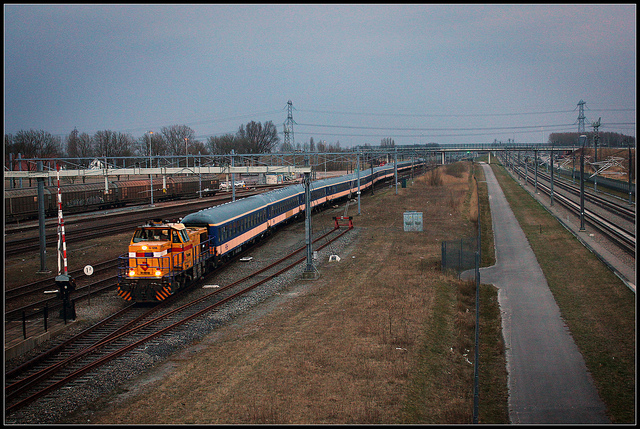

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

   16384/87910968 [..............................] - ETA: 0s

 4202496/87910968 [>.............................] - ETA: 6s

14524416/87910968 [===>..........................] - ETA: 1s

25174016/87910968 [=======>......................] - ETA: 3s

32997376/87910968 [==========>...................] - ETA: 2s

42663936/87910968 [=============>................] - ETA: 1s

51314688/87910968 [================>.............] - ETA: 1s

58728448/87910968 [===================>..........] - ETA: 0s

66674688/87910968 [=====================>........] - ETA: 0s

76079104/87910968 [========================>.....] - ETA: 0s

87302144/87910968 [============================>.] - ETA: 0s

87916544/87910968 [==============================] - 2s 0us/step


87924736/87910968 [==============================] - 2s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24017, 24017, 6003, 6003)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0182


Epoch 1 Batch 100 Loss 1.0458


Epoch 1 Batch 200 Loss 0.9401


Epoch 1 Batch 300 Loss 0.8349


Epoch 1 Loss 1.015788
Time taken for 1 epoch 143.32 sec



Epoch 2 Batch 0 Loss 0.8371


Epoch 2 Batch 100 Loss 0.7207


Epoch 2 Batch 200 Loss 0.8596


Epoch 2 Batch 300 Loss 0.7751


Epoch 2 Loss 0.772248
Time taken for 1 epoch 46.74 sec



Epoch 3 Batch 0 Loss 0.7620


Epoch 3 Batch 100 Loss 0.7014


Epoch 3 Batch 200 Loss 0.6455


Epoch 3 Batch 300 Loss 0.6229


Epoch 3 Loss 0.696630
Time taken for 1 epoch 46.76 sec



Epoch 4 Batch 0 Loss 0.7225


Epoch 4 Batch 100 Loss 0.6594


Epoch 4 Batch 200 Loss 0.7152


Epoch 4 Batch 300 Loss 0.6822


Epoch 4 Loss 0.649376
Time taken for 1 epoch 48.71 sec



Epoch 5 Batch 0 Loss 0.6595


Epoch 5 Batch 100 Loss 0.6266


Epoch 5 Batch 200 Loss 0.5742


Epoch 5 Batch 300 Loss 0.6266


Epoch 5 Loss 0.609125
Time taken for 1 epoch 46.72 sec



Epoch 6 Batch 0 Loss 0.6315


Epoch 6 Batch 100 Loss 0.5590


Epoch 6 Batch 200 Loss 0.5991


Epoch 6 Batch 300 Loss 0.5937


Epoch 6 Loss 0.576173
Time taken for 1 epoch 47.20 sec



Epoch 7 Batch 0 Loss 0.5468


Epoch 7 Batch 100 Loss 0.5491


Epoch 7 Batch 200 Loss 0.5973


Epoch 7 Batch 300 Loss 0.5055


Epoch 7 Loss 0.545744
Time taken for 1 epoch 46.78 sec



Epoch 8 Batch 0 Loss 0.5396


Epoch 8 Batch 100 Loss 0.5099


Epoch 8 Batch 200 Loss 0.5155


Epoch 8 Batch 300 Loss 0.5184


Epoch 8 Loss 0.517781
Time taken for 1 epoch 47.09 sec



Epoch 9 Batch 0 Loss 0.5564


Epoch 9 Batch 100 Loss 0.4831


Epoch 9 Batch 200 Loss 0.5242


Epoch 9 Batch 300 Loss 0.5074


Epoch 9 Loss 0.491817
Time taken for 1 epoch 47.33 sec



Epoch 10 Batch 0 Loss 0.5594


Epoch 10 Batch 100 Loss 0.4628


Epoch 10 Batch 200 Loss 0.4929


Epoch 10 Batch 300 Loss 0.4092


Epoch 10 Loss 0.468157
Time taken for 1 epoch 50.05 sec



Epoch 11 Batch 0 Loss 0.4717


Epoch 11 Batch 100 Loss 0.4652


Epoch 11 Batch 200 Loss 0.4518


Epoch 11 Batch 300 Loss 0.4027


Epoch 11 Loss 0.444083
Time taken for 1 epoch 49.64 sec



Epoch 12 Batch 0 Loss 0.4736


Epoch 12 Batch 100 Loss 0.4340


Epoch 12 Batch 200 Loss 0.4360


Epoch 12 Batch 300 Loss 0.3910


Epoch 12 Loss 0.422930
Time taken for 1 epoch 49.40 sec



Epoch 13 Batch 0 Loss 0.4415


Epoch 13 Batch 100 Loss 0.4012


Epoch 13 Batch 200 Loss 0.4012


Epoch 13 Batch 300 Loss 0.4083


Epoch 13 Loss 0.400933
Time taken for 1 epoch 46.93 sec



Epoch 14 Batch 0 Loss 0.4171


Epoch 14 Batch 100 Loss 0.3551


Epoch 14 Batch 200 Loss 0.3756


Epoch 14 Batch 300 Loss 0.3629


Epoch 14 Loss 0.381658
Time taken for 1 epoch 47.99 sec



Epoch 15 Batch 0 Loss 0.3761


Epoch 15 Batch 100 Loss 0.3958


Epoch 15 Batch 200 Loss 0.3563


Epoch 15 Batch 300 Loss 0.3671


Epoch 15 Loss 0.362227
Time taken for 1 epoch 47.82 sec



Epoch 16 Batch 0 Loss 0.3684


Epoch 16 Batch 100 Loss 0.3528


Epoch 16 Batch 200 Loss 0.3344


Epoch 16 Batch 300 Loss 0.3239


Epoch 16 Loss 0.346299
Time taken for 1 epoch 48.80 sec



Epoch 17 Batch 0 Loss 0.3399


Epoch 17 Batch 100 Loss 0.3339


Epoch 17 Batch 200 Loss 0.3464


Epoch 17 Batch 300 Loss 0.2917


Epoch 17 Loss 0.330310
Time taken for 1 epoch 48.89 sec



Epoch 18 Batch 0 Loss 0.3267


Epoch 18 Batch 100 Loss 0.3435


Epoch 18 Batch 200 Loss 0.2867


Epoch 18 Batch 300 Loss 0.2923


Epoch 18 Loss 0.315087
Time taken for 1 epoch 48.70 sec



Epoch 19 Batch 0 Loss 0.3377


Epoch 19 Batch 100 Loss 0.2811


Epoch 19 Batch 200 Loss 0.3111


Epoch 19 Batch 300 Loss 0.3143


Epoch 19 Loss 0.299675
Time taken for 1 epoch 48.44 sec



Epoch 20 Batch 0 Loss 0.3191


Epoch 20 Batch 100 Loss 0.2566


Epoch 20 Batch 200 Loss 0.3144


Epoch 20 Batch 300 Loss 0.2959


Epoch 20 Loss 0.286692
Time taken for 1 epoch 46.53 sec



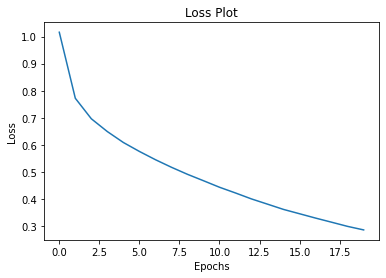

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a couple of men standing next to each other <end>
Prediction Caption: a group of people besides his horse and holding hay <end>


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


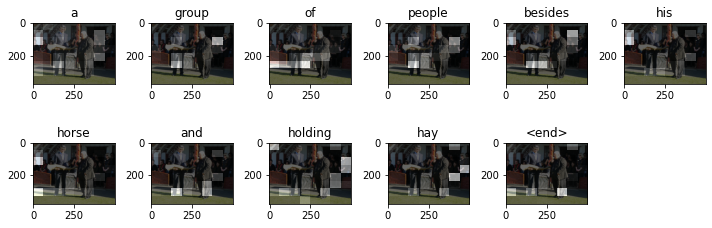

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


16384/64400 [======>.......................] - ETA: 0s

32768/64400 [==============>...............] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

65536/64400 [==============================] - 0s 5us/step


73728/64400 [==================================] - 0s 4us/step


Prediction Caption: surfer rides on in the crest <end>


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


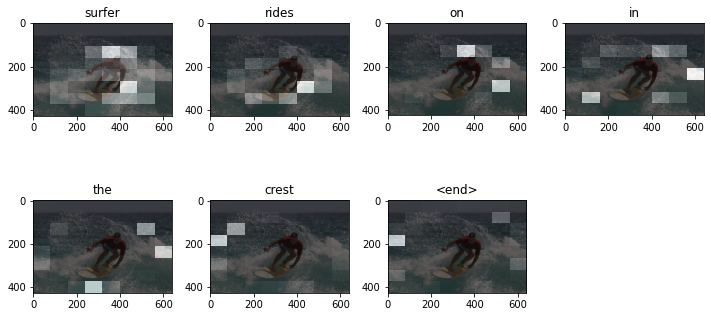

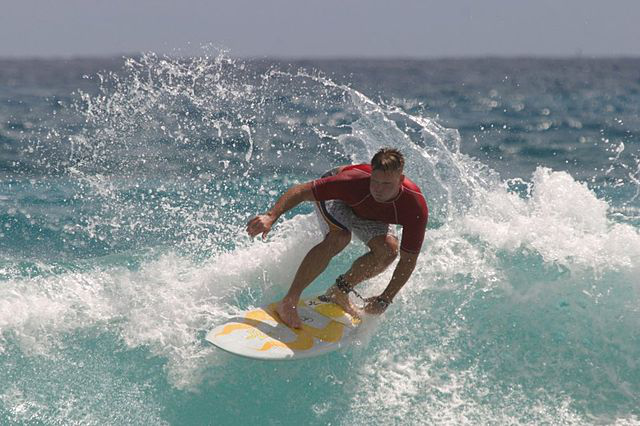

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.